In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import fcluster
import itertools
import scipy.stats as st
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
import random
import datetime as dt
from tqdm import tqdm
import pickle
RANDOM_SEED = 42
figsize = (17, 10)

c:\Users\danie\Desktop\PERSONAL PROJECT\00_VENVS\weld-anomaly-detection\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# parametri utilizzati per classificare una curva di saldatura come anomala o meno

# ISOLATION FOREST
NOT_ANOM = 20

# CONFIDENCE INTERVAL
NOT_ANOM_CI = 100


In [3]:
with open('../models/CI_global.pickle', 'rb') as f:
    dict_CI = pickle.load(f)
with open('../models/IF_models_cluster.pickle', 'rb') as f:
    list_IF_models = pickle.load(f)
with open('../models/dtw_cluster.pickle', 'rb') as f:
    dtw_cluster = pickle.load(f)
with open('../models/list_dbscan_daily_predictions.pickle', 'rb') as f:
    dbscan_daily_pred = pickle.load(f)

In [4]:
dataset = pd.read_pickle("../data/prepared/prepared_dataset.pkl")
dataset

spotName       Date      Time  n_week  \
0       60061_0_00 2019-09-17  17:33:48      38   
75852   60075_0_00 2019-09-17  17:33:48      38   
75853   60141_0_00 2019-09-17  17:33:48      38   
75854   60163_0_00 2019-09-17  17:33:48      38   
75855   60161_0_00 2019-09-17  17:33:48      38   
...            ...        ...       ...     ...   
222862  60021_0_00 2020-05-28  15:00:04      22   
222864  60025_0_00 2020-05-28  15:00:17      22   
222865  60027_0_00 2020-05-28  15:00:17      22   
222863  60023_0_00 2020-05-28  15:00:17      22   
222866   9999_9_99 2020-05-28  15:00:44      22   

                                             CurrentCurve  
0       [312, 2067, 3862, 5267, 6398, 7217, 7959, 8700...  
75852   [322, 2099, 3940, 5296, 6362, 7169, 7589, 7750...  
75853   [214, 1995, 3836, 5125, 6107, 6813, 7182, 7427...  
75854   [323, 2137, 4047, 5472, 6475, 7090, 7544, 7803...  
75855   [327, 2161, 4126, 5468, 6483, 7237, 7662, 7793...  
...                                                   ...  
222862  [317, 2095, 3809, 4984, 5714, 6222, 6698, 7110...  
222864  [344, 2225, 4011, 5234, 6017, 6613, 7051, 7365...  
222865  [303, 2034, 3644, 4767, 5526, 6103, 6437, 6680...  
222863  [317, 2065, 3781, 4926, 5688, 6229, 6801, 7118...  
222866  [339, 2926, 5598, 7380, 8567, 9585, 10349, 105...  

[140778 rows x 5 columns]

# Preprocessing

In [5]:
exploded_col_lists = dataset['CurrentCurve'].apply(pd.Series)
expanded_TS = pd.concat([dataset, exploded_col_lists],
                        axis=1)
expanded_TS.drop(columns='CurrentCurve', inplace=True)

# imputiamo i nan sostituendoli con la media delle misurazioni
expanded_TS.loc[:, 0:] = expanded_TS.loc[:, 0:].apply(
    lambda row: row.fillna(row.mean()), axis=1)

# creo colonna utile per analisi descrittive nel tempo delle anomalie
expanded_TS['TIMESTAMP'] = pd.to_datetime(
    expanded_TS['Date'].astype(str) + ' '+expanded_TS['Time'].astype(str))
expanded_TS.drop(columns=['Time', 'Date'], inplace=True)

# riordino colonne
list_cols = list(expanded_TS.columns)
reordered_cols = list_cols[0:1]
reordered_cols.append(list_cols[len(list_cols) - 1])
reordered_cols.append(list_cols[1])
reordered_cols.extend(list_cols[2:-1])
expanded_TS = expanded_TS[reordered_cols]
expanded_TS

spotName           TIMESTAMP  n_week      0       1       2       3  \
0       60061_0_00 2019-09-17 17:33:48      38  312.0  2067.0  3862.0  5267.0   
75852   60075_0_00 2019-09-17 17:33:48      38  322.0  2099.0  3940.0  5296.0   
75853   60141_0_00 2019-09-17 17:33:48      38  214.0  1995.0  3836.0  5125.0   
75854   60163_0_00 2019-09-17 17:33:48      38  323.0  2137.0  4047.0  5472.0   
75855   60161_0_00 2019-09-17 17:33:48      38  327.0  2161.0  4126.0  5468.0   
...            ...                 ...     ...    ...     ...     ...     ...   
222862  60021_0_00 2020-05-28 15:00:04      22  317.0  2095.0  3809.0  4984.0   
222864  60025_0_00 2020-05-28 15:00:17      22  344.0  2225.0  4011.0  5234.0   
222865  60027_0_00 2020-05-28 15:00:17      22  303.0  2034.0  3644.0  4767.0   
222863  60023_0_00 2020-05-28 15:00:17      22  317.0  2065.0  3781.0  4926.0   
222866   9999_9_99 2020-05-28 15:00:44      22  339.0  2926.0  5598.0  7380.0   

             4       5        6  ...          614          615          616  \
0       6398.0  7217.0   7959.0  ...  7925.502439  7925.502439  7925.502439   
75852   6362.0  7169.0   7589.0  ...  7933.513580  7933.513580  7933.513580   
75853   6107.0  6813.0   7182.0  ...  7533.835000  7533.835000  7533.835000   
75854   6475.0  7090.0   7544.0  ...  7918.039024  7918.039024  7918.039024   
75855   6483.0  7237.0   7662.0  ...  8003.117647  8003.117647  8003.117647   
...        ...     ...      ...  ...          ...          ...          ...   
222862  5714.0  6222.0   6698.0  ...  7802.875000  7802.875000  7802.875000   
222864  6017.0  6613.0   7051.0  ...  7479.355609  7479.355609  7479.355609   
222865  5526.0  6103.0   6437.0  ...  7441.092500  7441.092500  7441.092500   
222863  5688.0  6229.0   6801.0  ...  7778.020000  7778.020000  7778.020000   
222866  8567.0  9585.0  10349.0  ...  9776.110000  9776.110000  9776.110000   

                617          618          619          620          621  \
0       7925.502439  7925.502439  7925.502439  7925.502439  7925.502439   
75852   7933.513580  7933.513580  7933.513580  7933.513580  7933.513580   
75853   7533.835000  7533.835000  7533.835000  7533.835000  7533.835000   
75854   7918.039024  7918.039024  7918.039024  7918.039024  7918.039024   
75855   8003.117647  8003.117647  8003.117647  8003.117647  8003.117647   
...             ...          ...          ...          ...          ...   
222862  7802.875000  7802.875000  7802.875000  7802.875000  7802.875000   
222864  7479.355609  7479.355609  7479.355609  7479.355609  7479.355609   
222865  7441.092500  7441.092500  7441.092500  7441.092500  7441.092500   
222863  7778.020000  7778.020000  7778.020000  7778.020000  7778.020000   
222866  9776.110000  9776.110000  9776.110000  9776.110000  9776.110000   

                622          623  
0       7925.502439  7925.502439  
75852   7933.513580  7933.513580  
75853   7533.835000  7533.835000  
75854   7918.039024  7918.039024  
75855   8003.117647  8003.117647  
...             ...          ...  
222862  7802.875000  7802.875000  
222864  7479.355609  7479.355609  
222865  7441.092500  7441.092500  
222863  7778.020000  7778.020000  
222866  9776.110000  9776.110000  

[140778 rows x 627 columns]

# PREVISIONI ANOMALIE CC GIORNALIERE

In [6]:
# K-means
predictions = dtw_cluster.predict(expanded_TS.loc[:, 0:])
dataset['k_means_dtw'] = predictions
# DBSCAN
dataset['dbscan_daily'] = dbscan_daily_pred
dataset

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 140778 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


spotName       Date      Time  n_week  \
0       60061_0_00 2019-09-17  17:33:48      38   
75852   60075_0_00 2019-09-17  17:33:48      38   
75853   60141_0_00 2019-09-17  17:33:48      38   
75854   60163_0_00 2019-09-17  17:33:48      38   
75855   60161_0_00 2019-09-17  17:33:48      38   
...            ...        ...       ...     ...   
222862  60021_0_00 2020-05-28  15:00:04      22   
222864  60025_0_00 2020-05-28  15:00:17      22   
222865  60027_0_00 2020-05-28  15:00:17      22   
222863  60023_0_00 2020-05-28  15:00:17      22   
222866   9999_9_99 2020-05-28  15:00:44      22   

                                             CurrentCurve  k_means_dtw  \
0       [312, 2067, 3862, 5267, 6398, 7217, 7959, 8700...            2   
75852   [322, 2099, 3940, 5296, 6362, 7169, 7589, 7750...            2   
75853   [214, 1995, 3836, 5125, 6107, 6813, 7182, 7427...            0   
75854   [323, 2137, 4047, 5472, 6475, 7090, 7544, 7803...            2   
75855   [327, 2161, 4126, 5468, 6483, 7237, 7662, 7793...            2   
...                                                   ...          ...   
222862  [317, 2095, 3809, 4984, 5714, 6222, 6698, 7110...            0   
222864  [344, 2225, 4011, 5234, 6017, 6613, 7051, 7365...            0   
222865  [303, 2034, 3644, 4767, 5526, 6103, 6437, 6680...            0   
222863  [317, 2065, 3781, 4926, 5688, 6229, 6801, 7118...            0   
222866  [339, 2926, 5598, 7380, 8567, 9585, 10349, 105...            1   

        dbscan_daily  
0                  0  
75852              0  
75853              0  
75854              0  
75855              0  
...              ...  
222862             0  
222864             0  
222865             0  
222863             0  
222866             0  

[140778 rows x 7 columns]

In [7]:
def plot_CI_TS(spotname, dataframe_CI, df_CI_anomalies, axs):
    axs.set_title(f"C.I SU MEDIA CURVA GLOBALE")
    axs.set(xlabel='Millisecondi')
    axs.plot(dataframe_CI['mean'], color='blue',
             alpha=0.8, label=f'Media globale spotname n: {spotname}')
    axs.fill_between(
        dataframe_CI.index, dataframe_CI['lw_bound'], dataframe_CI['up_bound'], alpha=1, color='green', label='Intervallo di confidenza')
    axs.scatter(df_CI_anomalies['anom_index'], df_CI_anomalies['anom_values'],
                s=0.5, color='red', label=f'Anomalia --- Totale: {df_CI_anomalies.shape[0]}')
    axs.legend()
    plt.show()


def test_predictions(TS_daily, spotname, index_cluster, cut_off_thres, plot=False):
    model_IF = list_IF_models[index_cluster]
    predictions = model_IF.predict(np.array(TS_daily).reshape(-1, 1))

    dataset_test = pd.DataFrame(
        {'data': TS_daily, 'is_anomaly': predictions},
        index=range(0, len(TS_daily))
    )
    # non considero i primi cut_off_thres punti come anomalie -> is_anomaly ha indice pari a 1
    dataset_test.iloc[:cut_off_thres, 1] = 1
    anomaly_points = dataset_test[dataset_test.is_anomaly == -1]

    if plot:
        fig, axs = plt.subplots(1, 2,
                                figsize=figsize, sharex=True, sharey=True)
        fig.suptitle(
            f"SPOTNAME {spotname} --- MISURAZIONE GIORNALIERA", fontsize=15)
        axs[0].set_title(
            f"SPOTNAME CLUSTER {index_cluster} --- IS. FOREST")
        axs[0].set(xlabel='Millisecondi', ylabel='CurrentCurve (AMPERE)')
        axs[0].plot(anomaly_points.index,
                    anomaly_points['data'], 'ro', zorder=99, alpha=0.8, markersize=2.5, label=f'Anomalia -- TOTALE: {anomaly_points.shape[0]}')
        axs[0].plot(dataset_test['data'], 'g', linewidth=3,
                    zorder=2, label=f'Misurazione giornaliera spotname {spotname}')
        axs[0].legend()
    # lista tuple indice - valore del punto anomalo
    l_CI_anomalies = []
    for index, row in dict_CI[spotname].iterrows():
        if TS_daily[index] > row['up_bound'] or TS_daily[index] < row['lw_bound']:
            l_CI_anomalies.append((index, TS_daily[index]))

    df_CI_anomalies = pd.DataFrame(l_CI_anomalies, columns=[
        'anom_index', 'anom_values'])
    # non considero anomali i primi cut_off_thres punti
    df_CI_anomalies = df_CI_anomalies.iloc[cut_off_thres:]

    if plot:
        plot_CI_TS(spotname, dict_CI[spotname], df_CI_anomalies, axs[1])
    # ritorno numero anomalie trovate da CI e da IF
    return df_CI_anomalies.shape[0], anomaly_points.shape[0]

Si consiglia di commentare questa parte a causa del tempo necessario a terminare la sua esecuzione, circa 1h, e di caricare direttamente il daily_dataset_analysis.pickle nella cella successiva.

In [8]:
# numero di punti anomali INIZIALI da non considerare
cut_off_thres = 10
# flag per decidere di plottare o no i grafici delle curve e delle loro anomalie
plot = False
for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    spotname = row['spotName']
    # lista di tutte le cc di uno spotname
    CC_list = row['CurrentCurve']
    index_cluster = row['k_means_dtw']
    n_CI_anom, n_IF_anom = test_predictions(CC_list, spotname, index_cluster,
                                            cut_off_thres, plot)
    # per ogni curvatura assegno # anomalie alle rispettive colonne
    dataset.loc[index, 'n_CI_anom'] = n_CI_anom
    dataset.loc[index, 'n_IF_anom'] = n_IF_anom
dataset

100%|█████████████████████████████████████████████████████████████| 140778/140778 [2:05:35<00:00, 18.68it/s]


spotName       Date      Time  n_week  \
0       60061_0_00 2019-09-17  17:33:48      38   
75852   60075_0_00 2019-09-17  17:33:48      38   
75853   60141_0_00 2019-09-17  17:33:48      38   
75854   60163_0_00 2019-09-17  17:33:48      38   
75855   60161_0_00 2019-09-17  17:33:48      38   
...            ...        ...       ...     ...   
222862  60021_0_00 2020-05-28  15:00:04      22   
222864  60025_0_00 2020-05-28  15:00:17      22   
222865  60027_0_00 2020-05-28  15:00:17      22   
222863  60023_0_00 2020-05-28  15:00:17      22   
222866   9999_9_99 2020-05-28  15:00:44      22   

                                             CurrentCurve  k_means_dtw  \
0       [312, 2067, 3862, 5267, 6398, 7217, 7959, 8700...            2   
75852   [322, 2099, 3940, 5296, 6362, 7169, 7589, 7750...            2   
75853   [214, 1995, 3836, 5125, 6107, 6813, 7182, 7427...            0   
75854   [323, 2137, 4047, 5472, 6475, 7090, 7544, 7803...            2   
75855   [327, 2161, 4126, 5468, 6483, 7237, 7662, 7793...            2   
...                                                   ...          ...   
222862  [317, 2095, 3809, 4984, 5714, 6222, 6698, 7110...            0   
222864  [344, 2225, 4011, 5234, 6017, 6613, 7051, 7365...            0   
222865  [303, 2034, 3644, 4767, 5526, 6103, 6437, 6680...            0   
222863  [317, 2065, 3781, 4926, 5688, 6229, 6801, 7118...            0   
222866  [339, 2926, 5598, 7380, 8567, 9585, 10349, 105...            1   

        dbscan_daily  n_CI_anom  n_IF_anom  
0                  0      354.0        9.0  
75852              0      277.0        0.0  
75853              0      285.0        0.0  
75854              0      360.0        0.0  
75855              0      241.0        0.0  
...              ...        ...        ...  
222862             0      258.0      265.0  
222864             0      374.0        9.0  
222865             0      340.0        4.0  
222863             0      193.0      188.0  
222866             0       72.0       67.0  

[140778 rows x 9 columns]

In [9]:
# dataset con andamenti giornalieri x spotname + anomalie
dataset.to_pickle('../data/prepared/daily_dataset_analysis.pickle')

# Analisi descrittive anomalie su serie giornaliere (ISOLATION FOREST)

In [10]:
with open('../data/prepared/daily_dataset_analysis.pickle', 'rb') as f:
    daily_analysis = pickle.load(f)

### Tot. serie anomalie per spotname

<AxesSubplot:title={'center':'Tot. serie anomale per spotname (I. F.)'}, xlabel='spotName'>

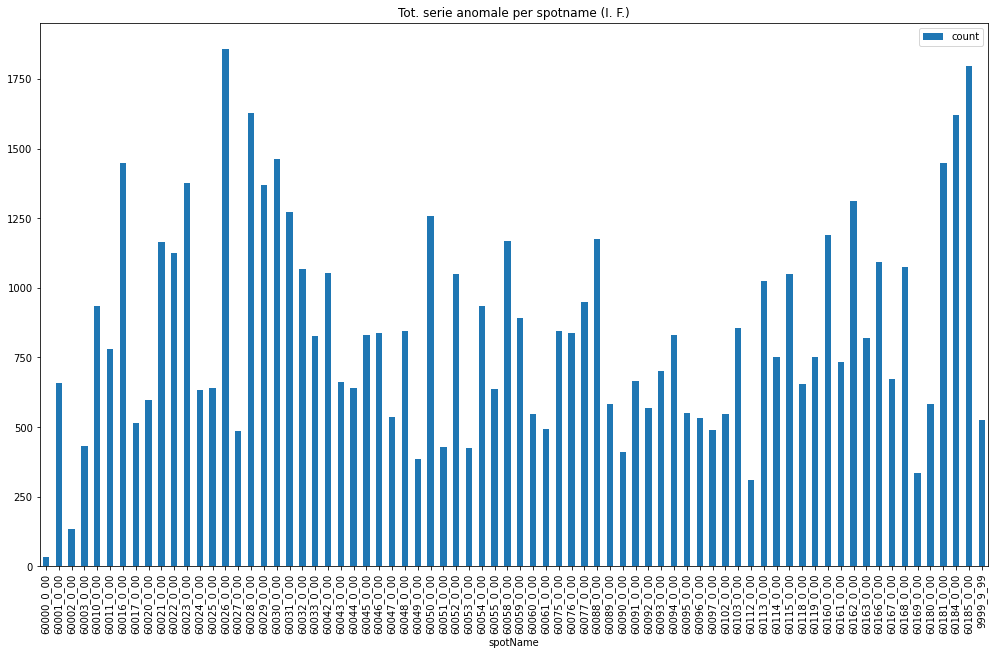

In [11]:
daily_analysis[daily_analysis.n_IF_anom > NOT_ANOM].groupby(['spotName'])['CurrentCurve'].agg(
    count='count').plot.bar(title="Tot. serie anomale per spotname (I. F.)", figsize=figsize)

### Per spotname, andamento anomalie nel tempo

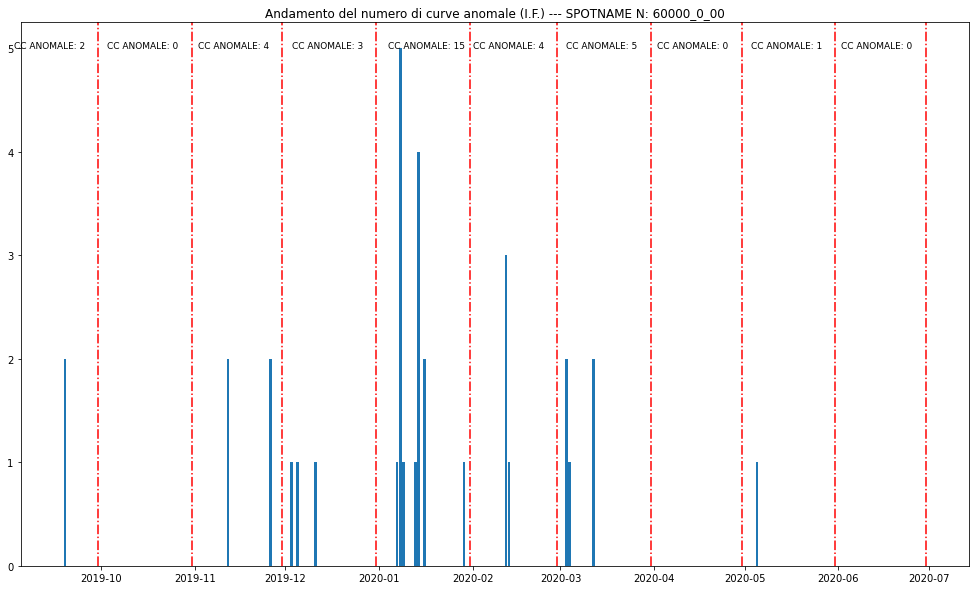

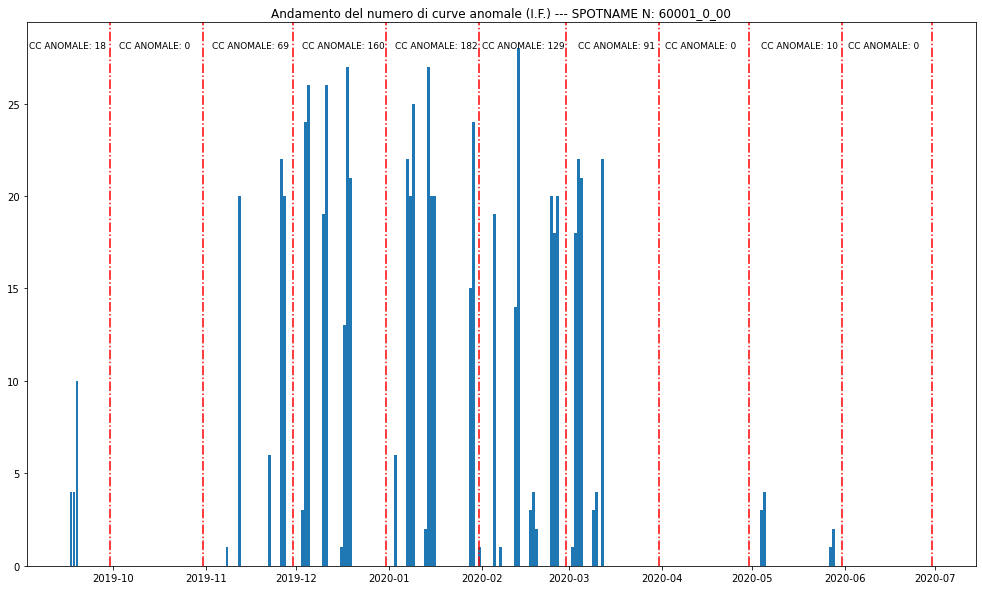

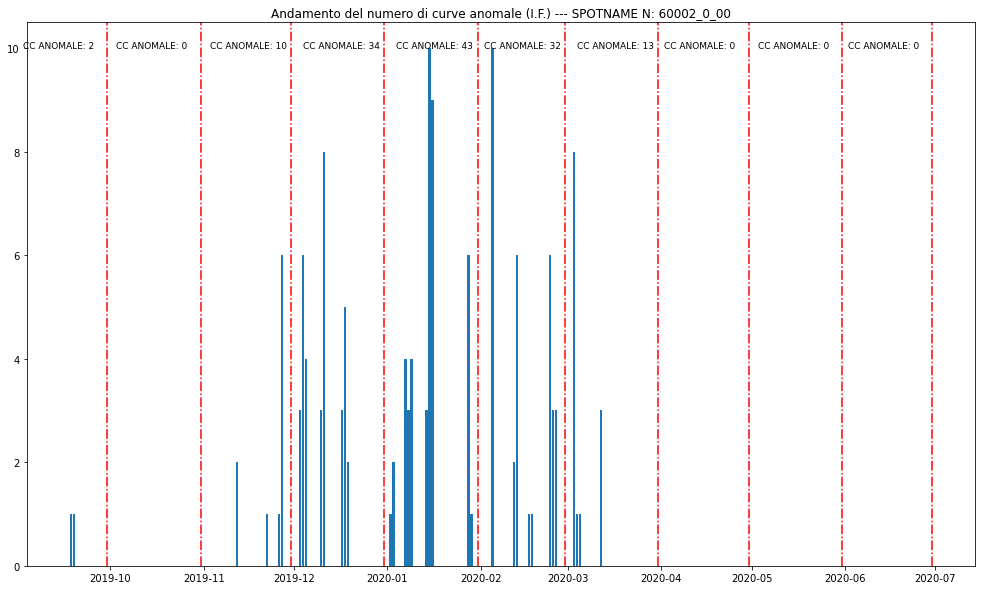

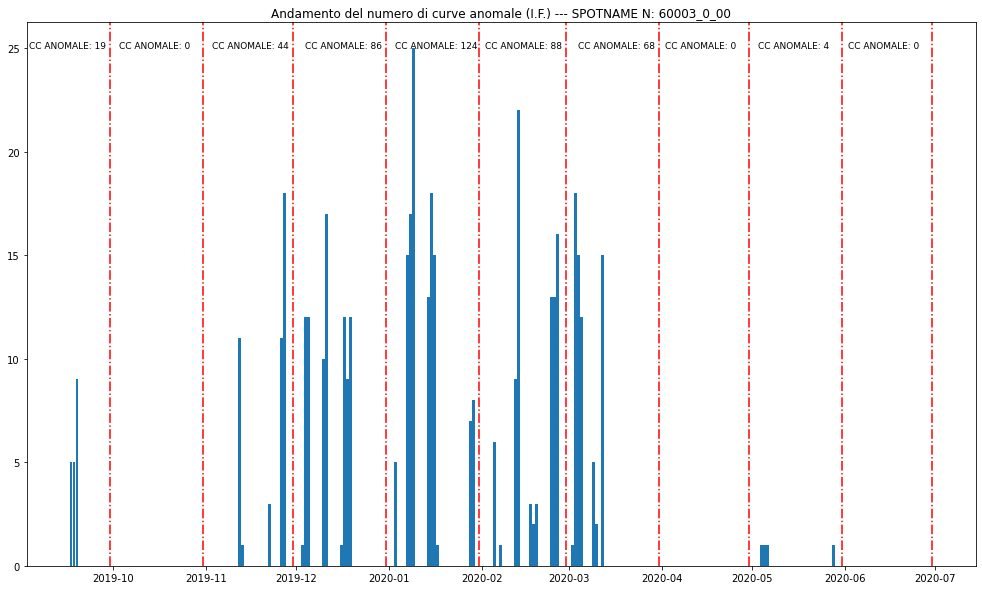

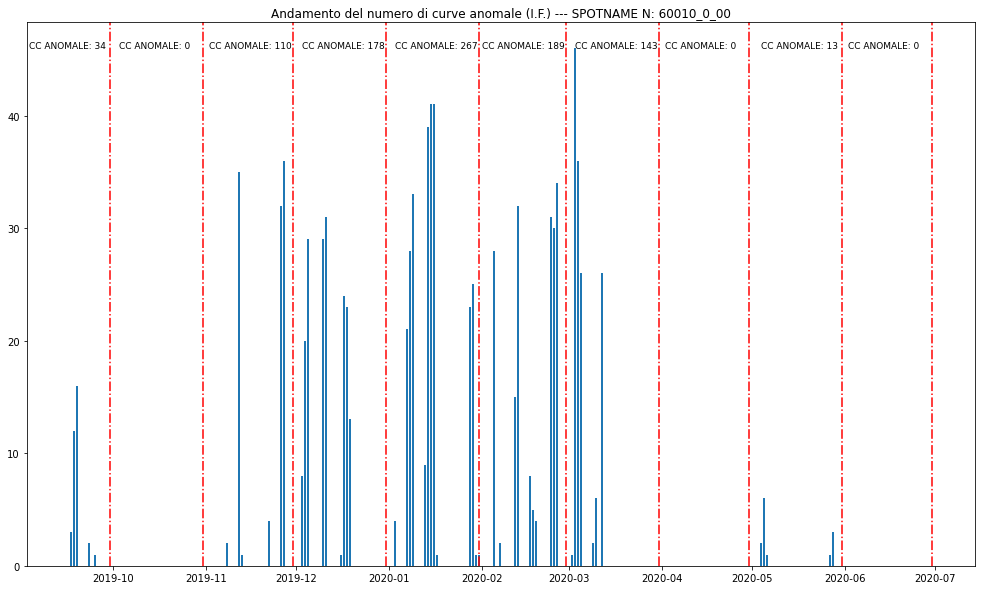

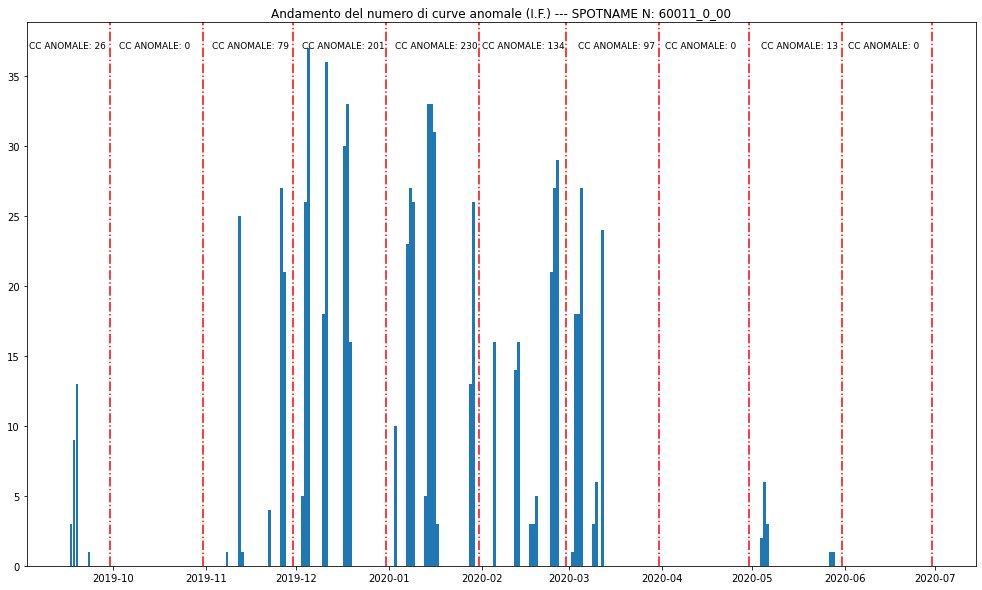

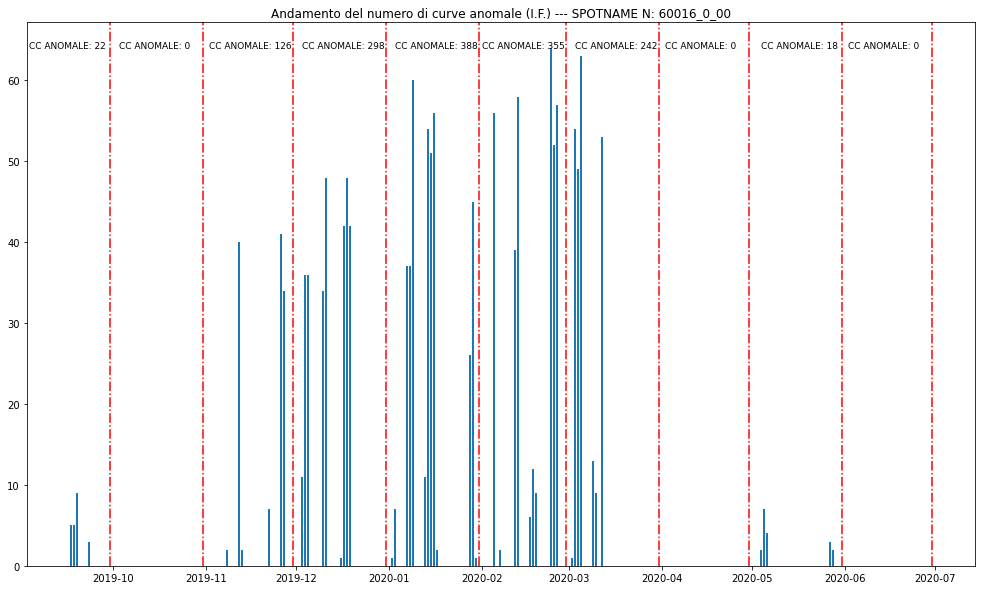

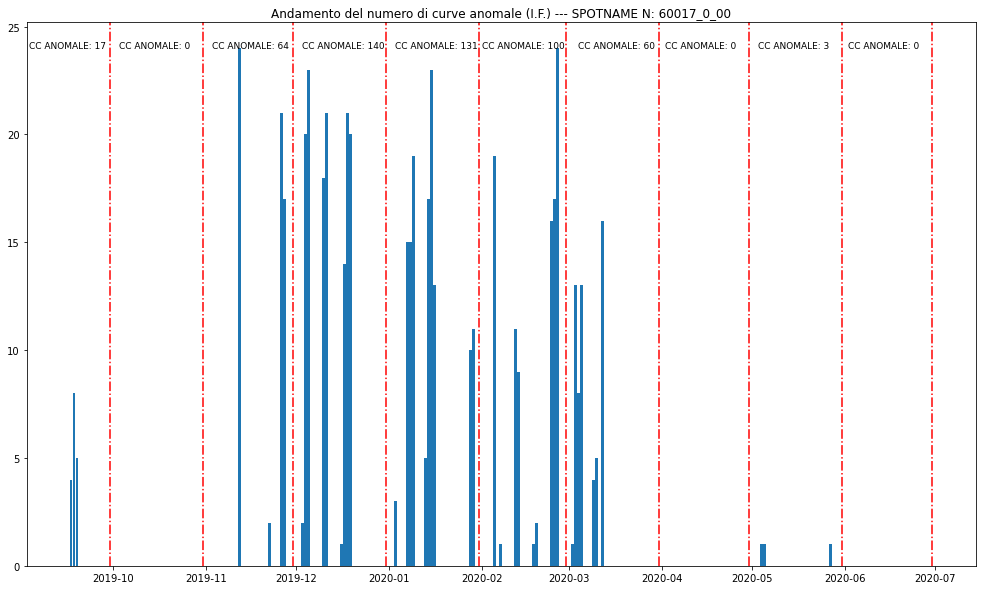

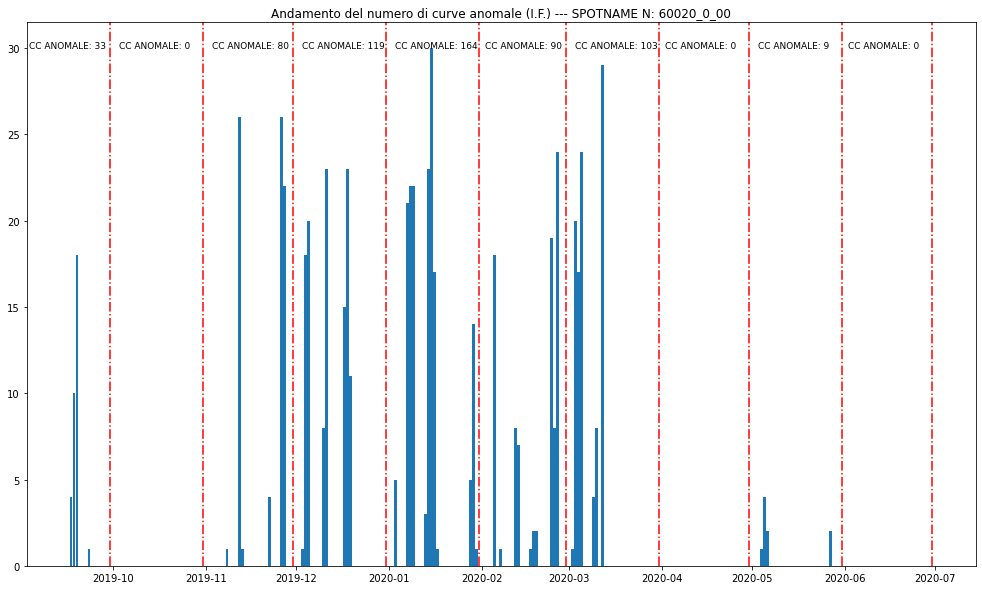

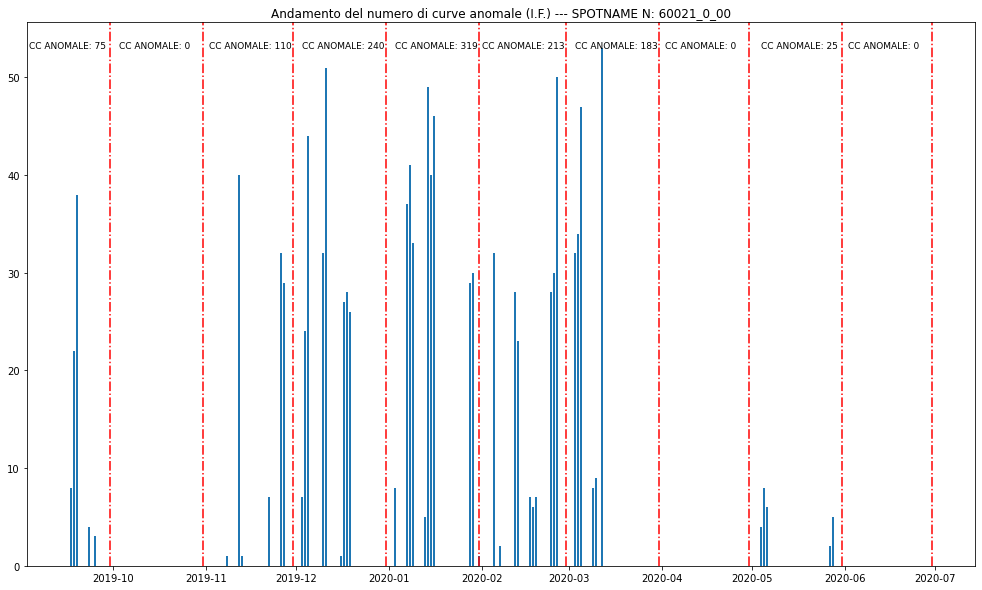

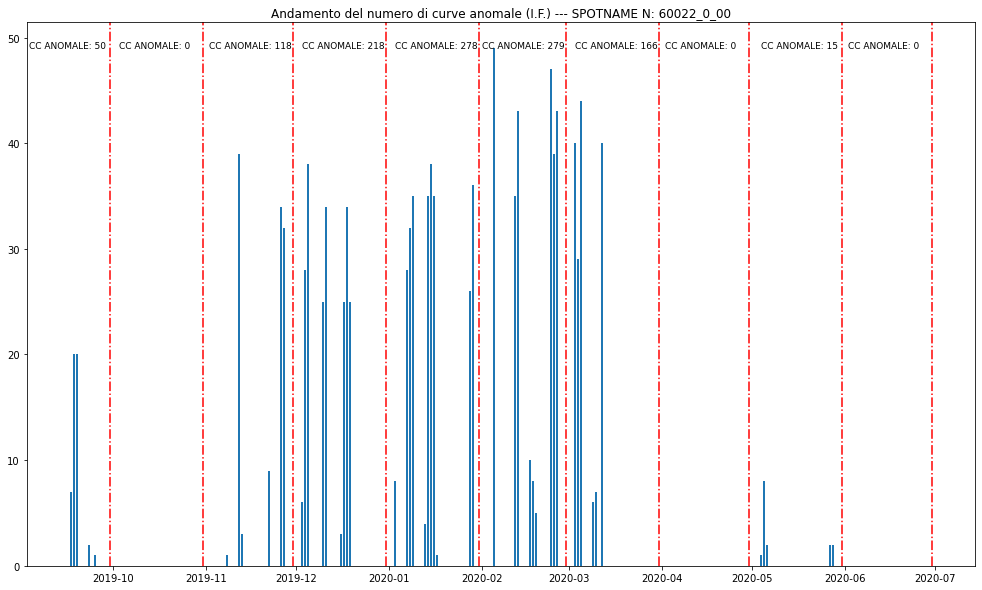

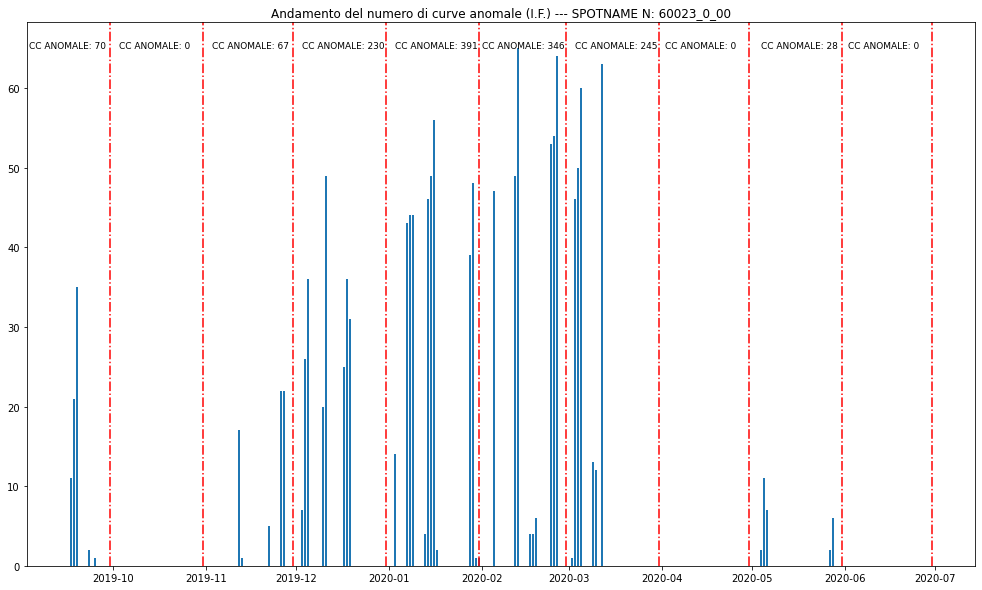

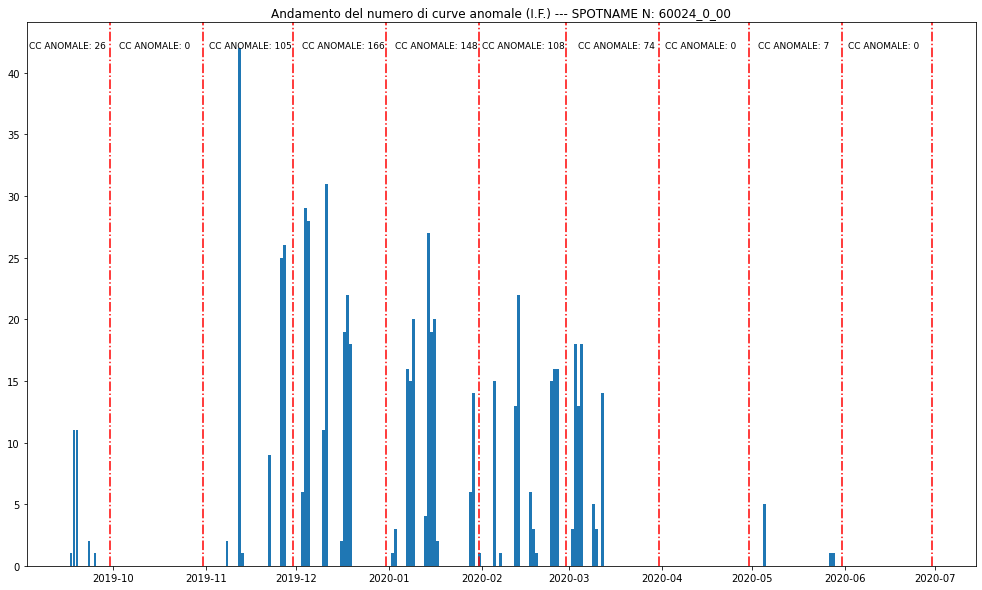

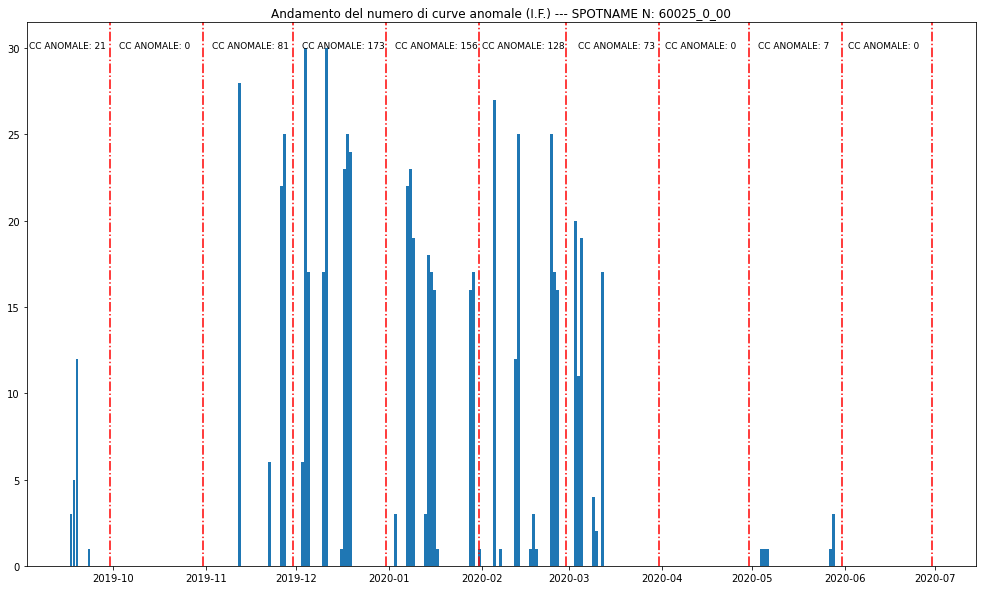

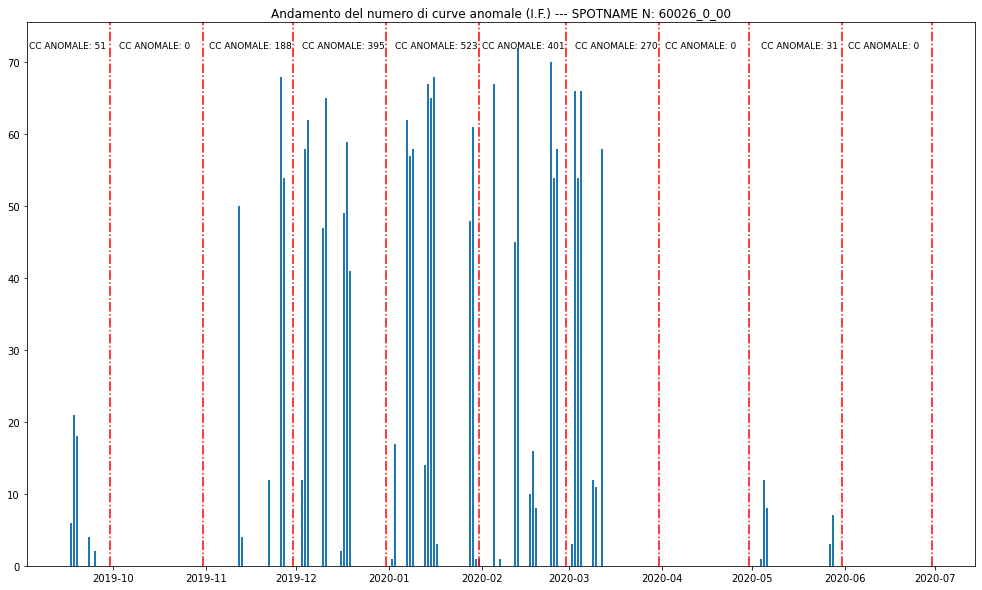

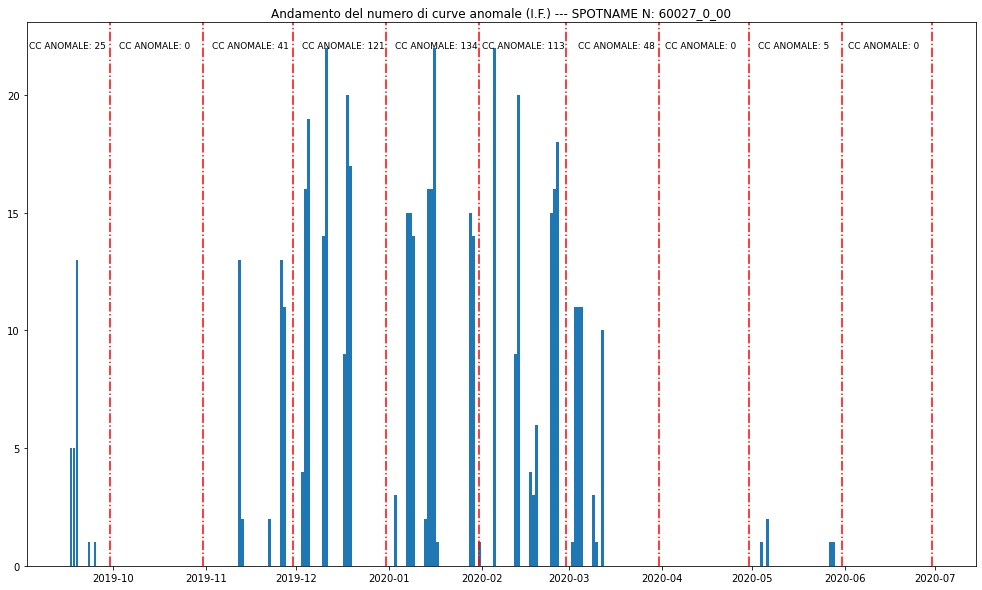

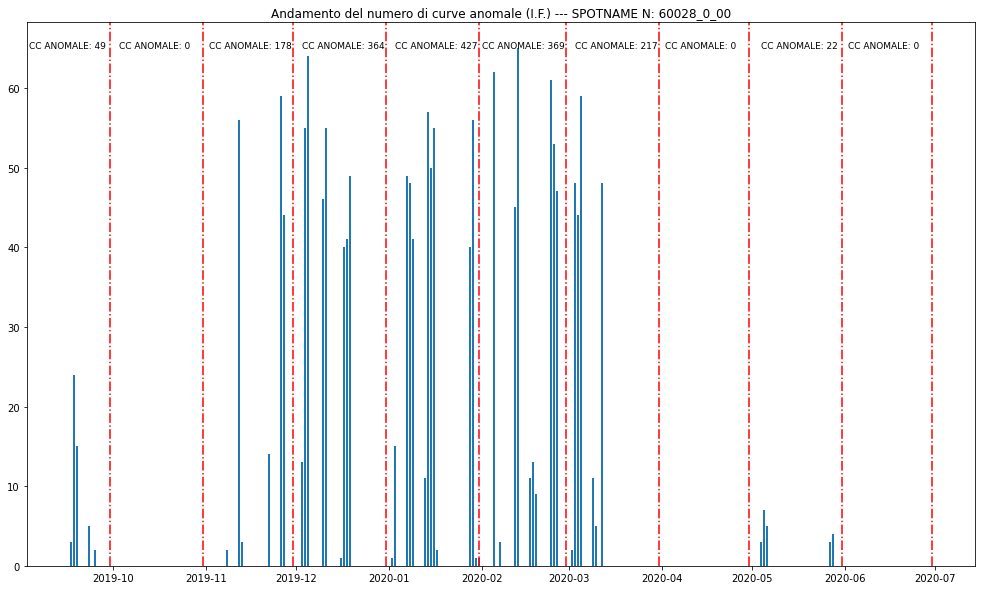

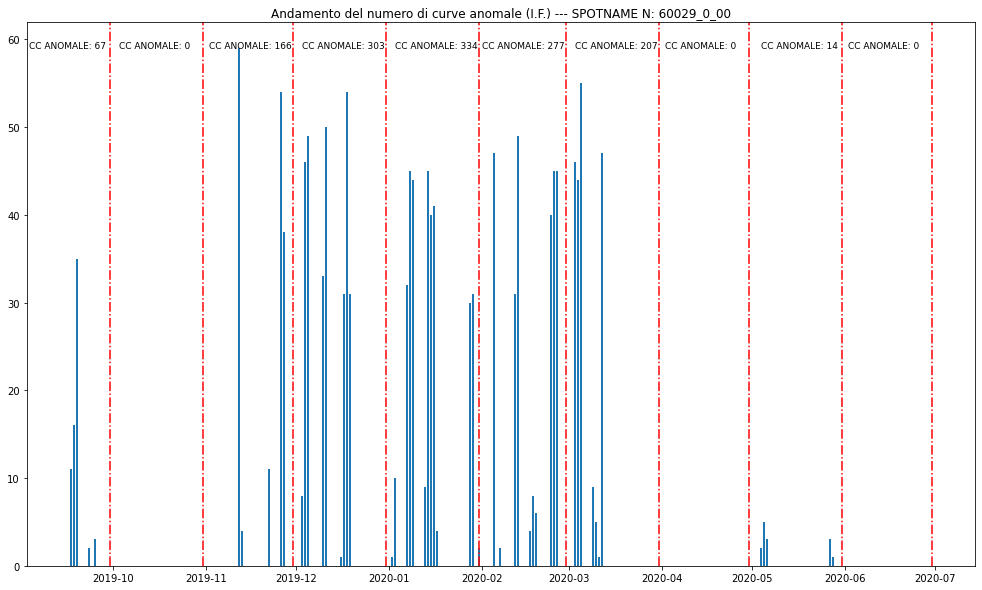

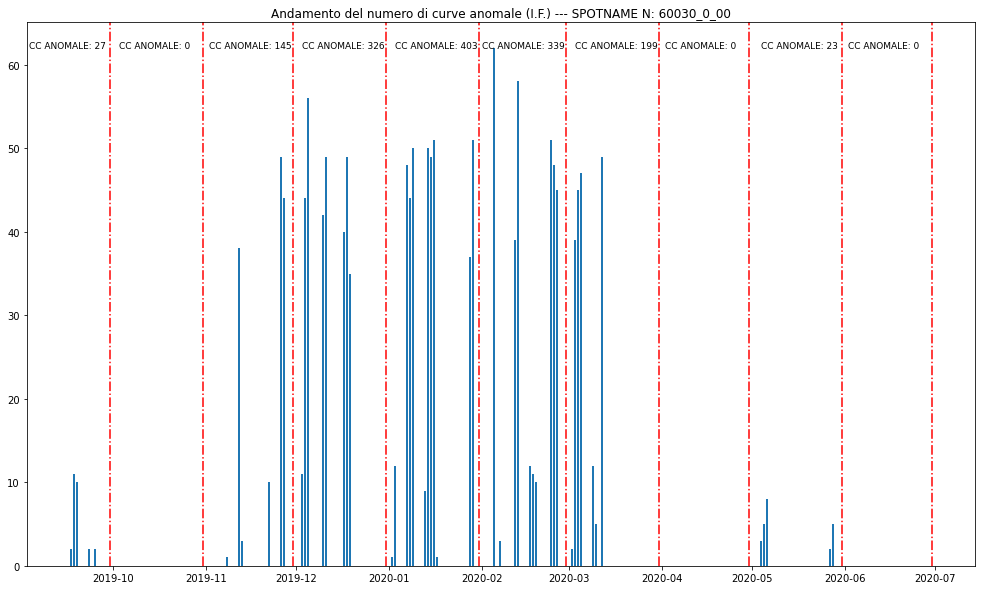

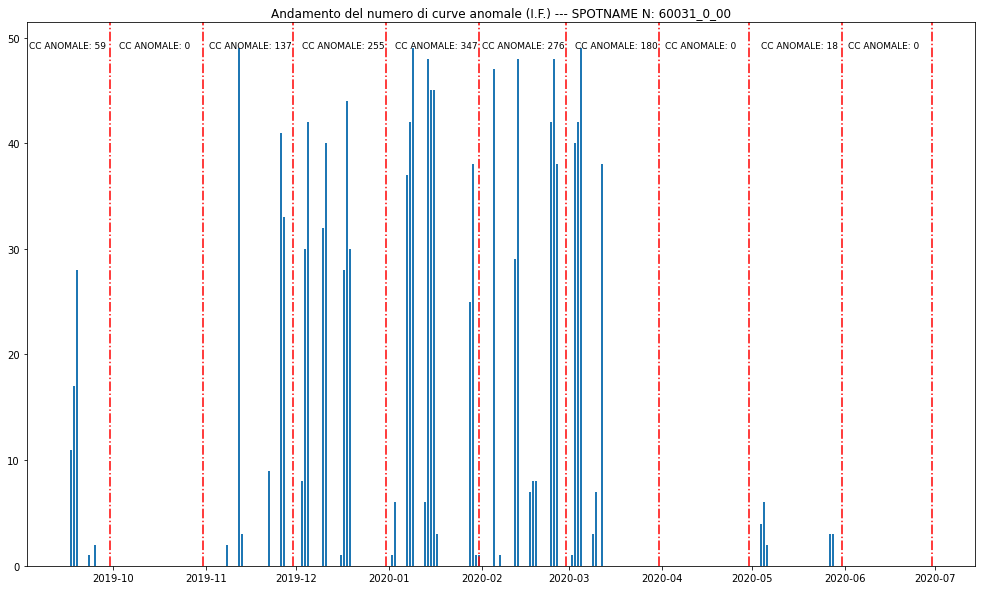

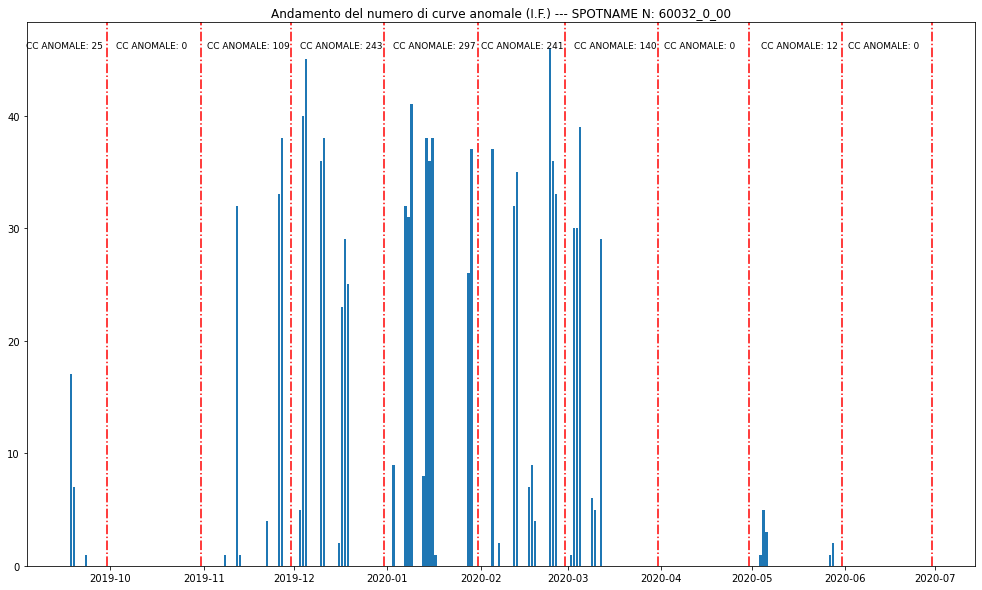

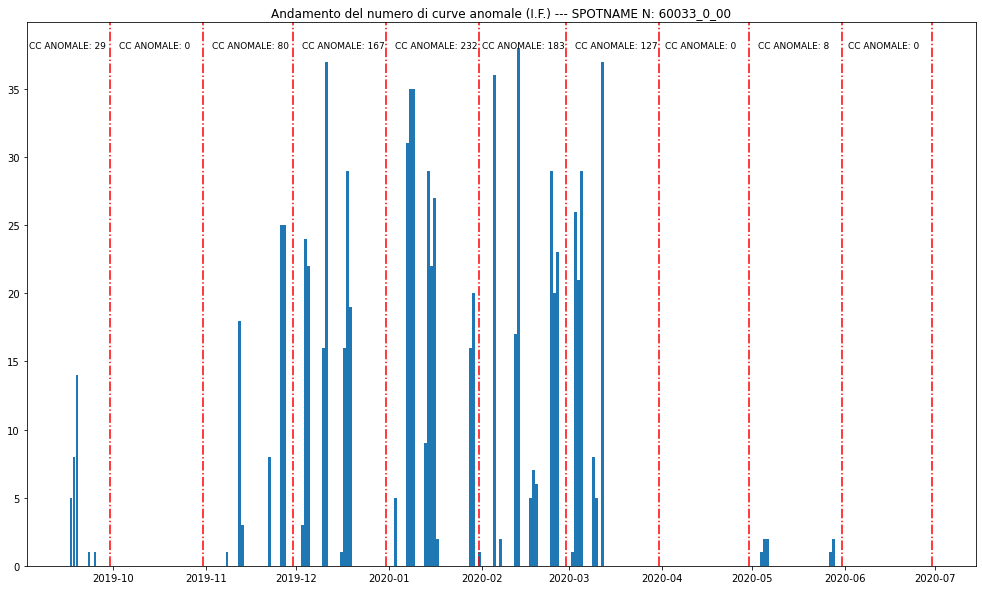

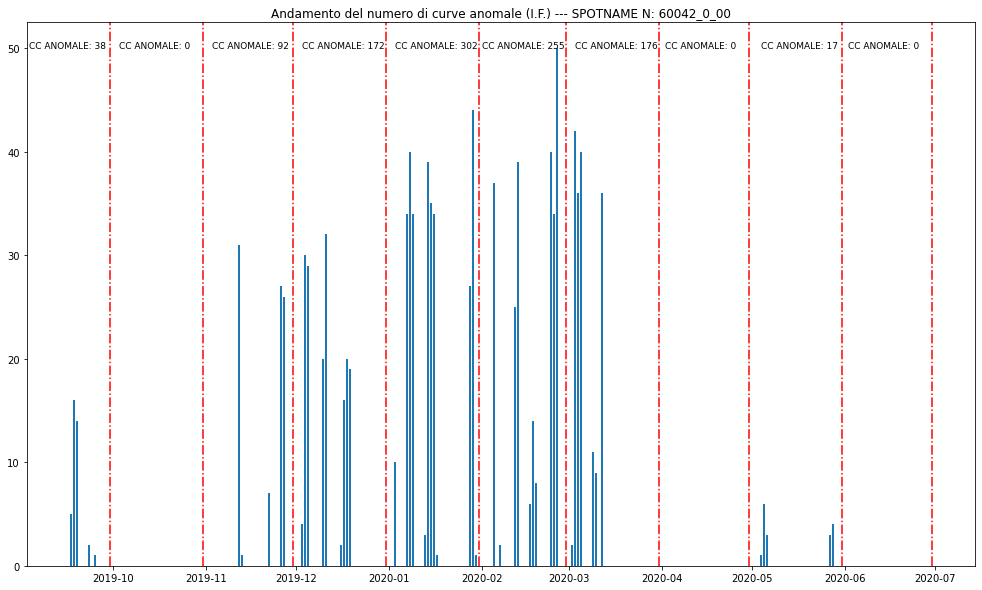

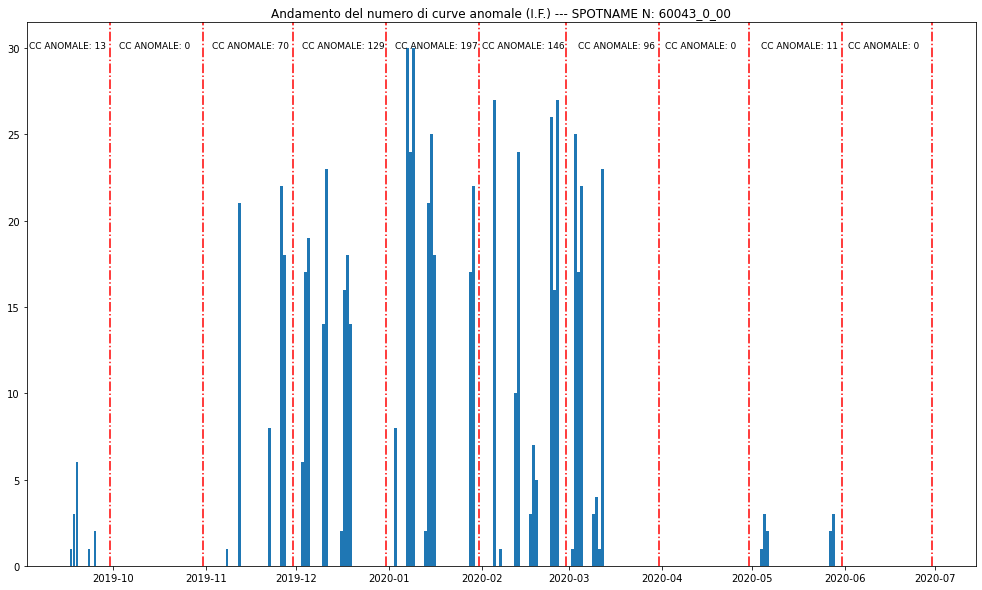

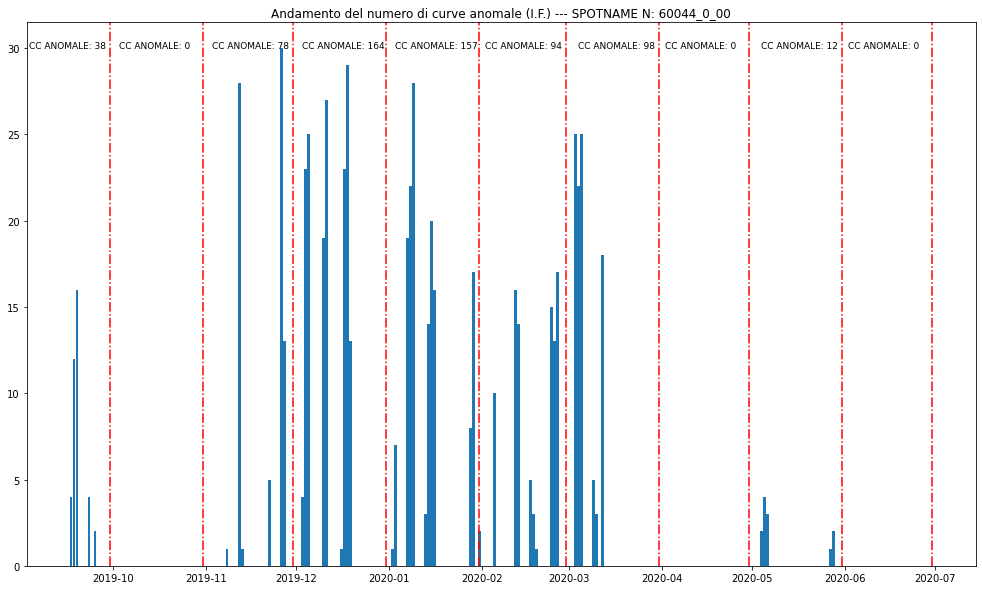

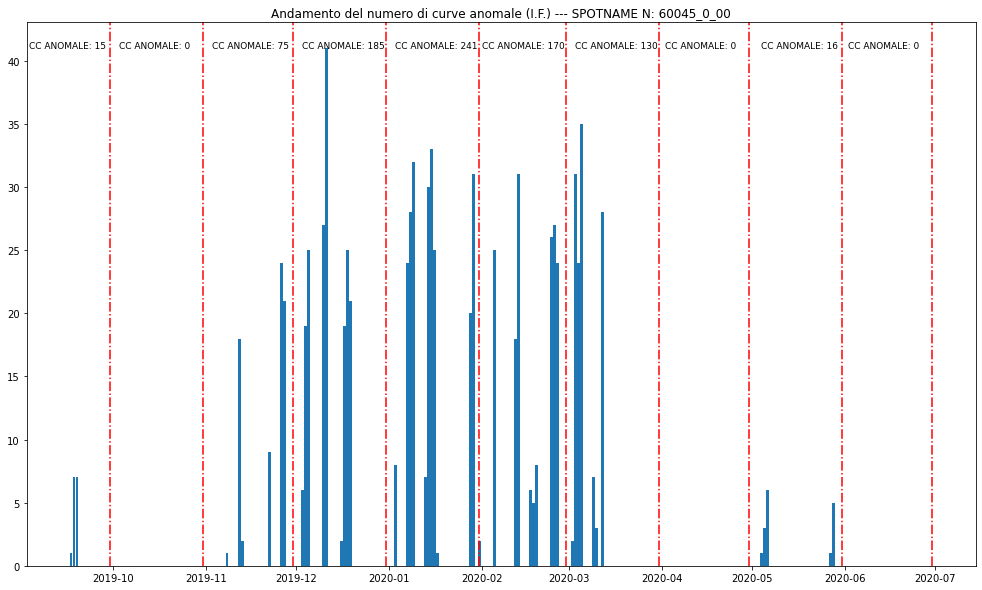

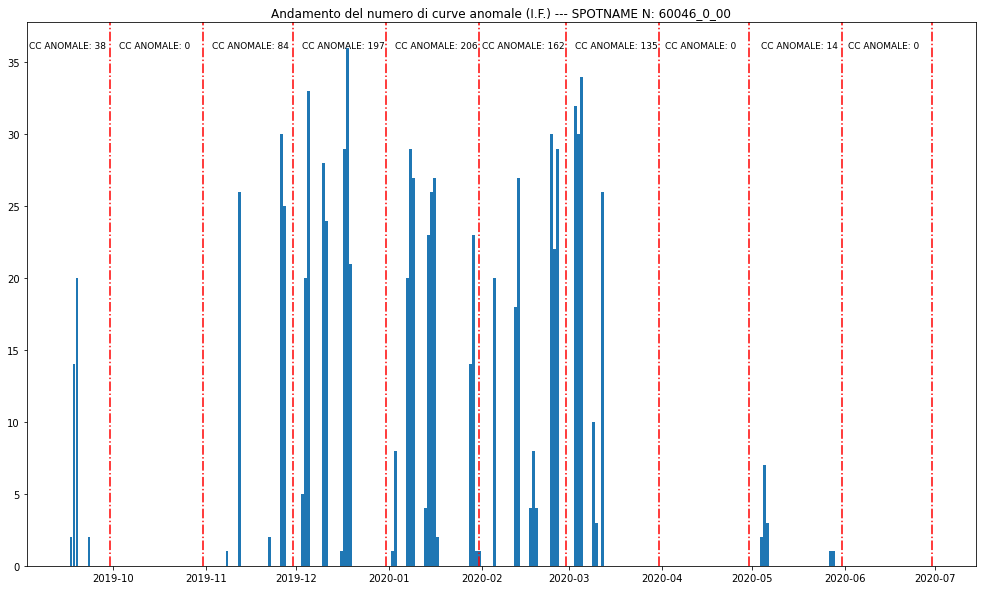

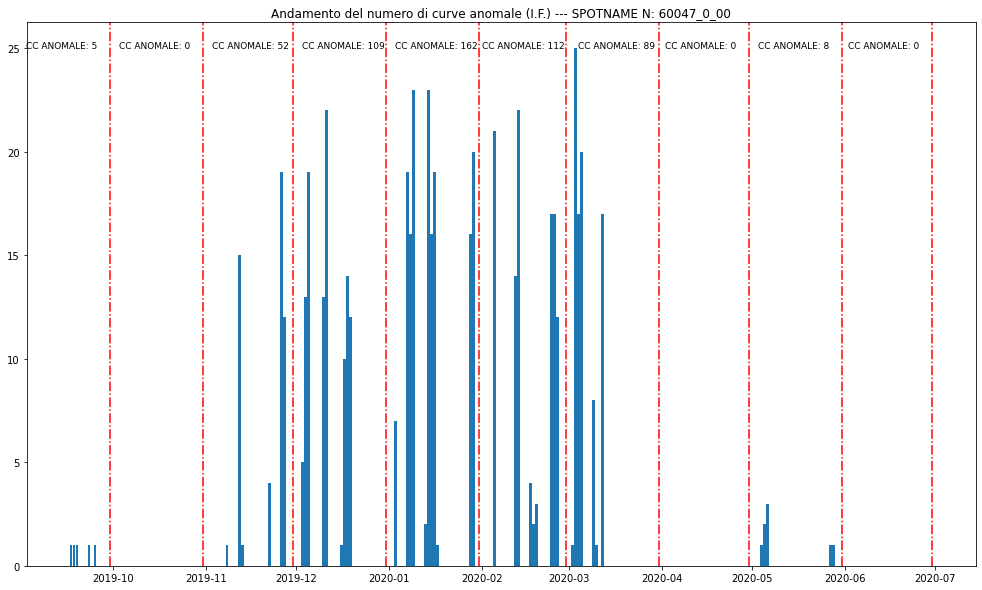

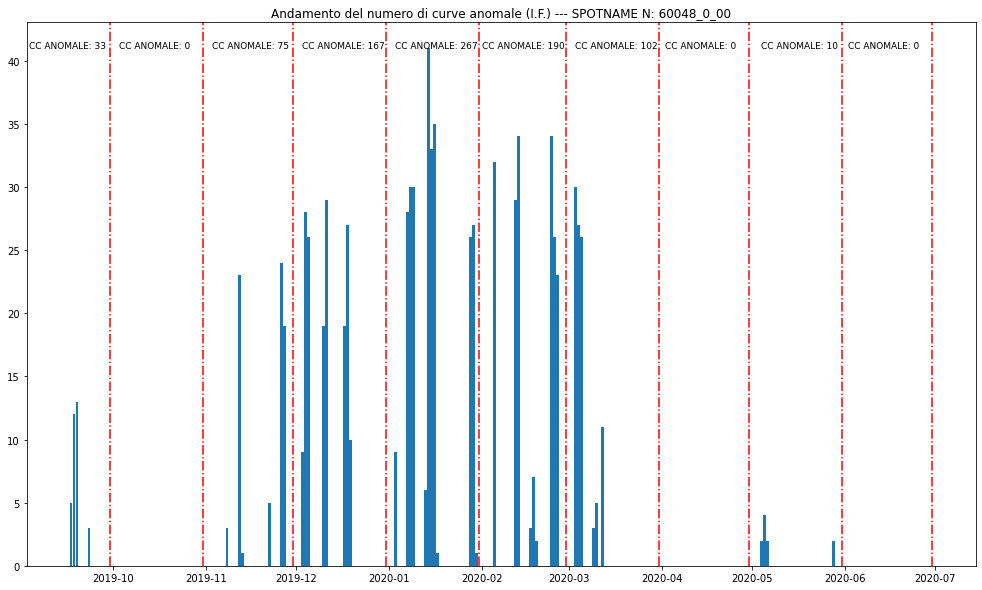

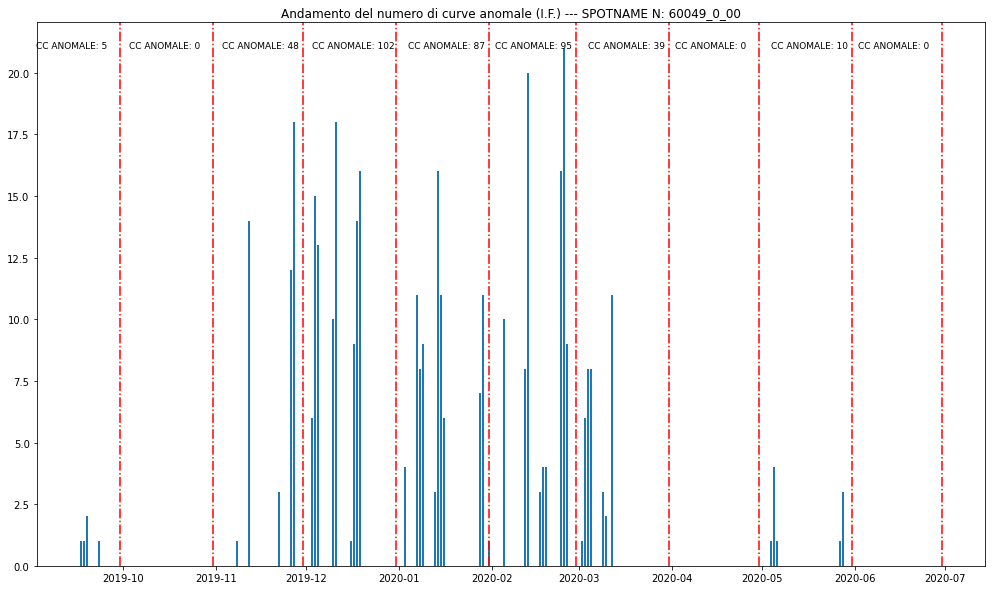

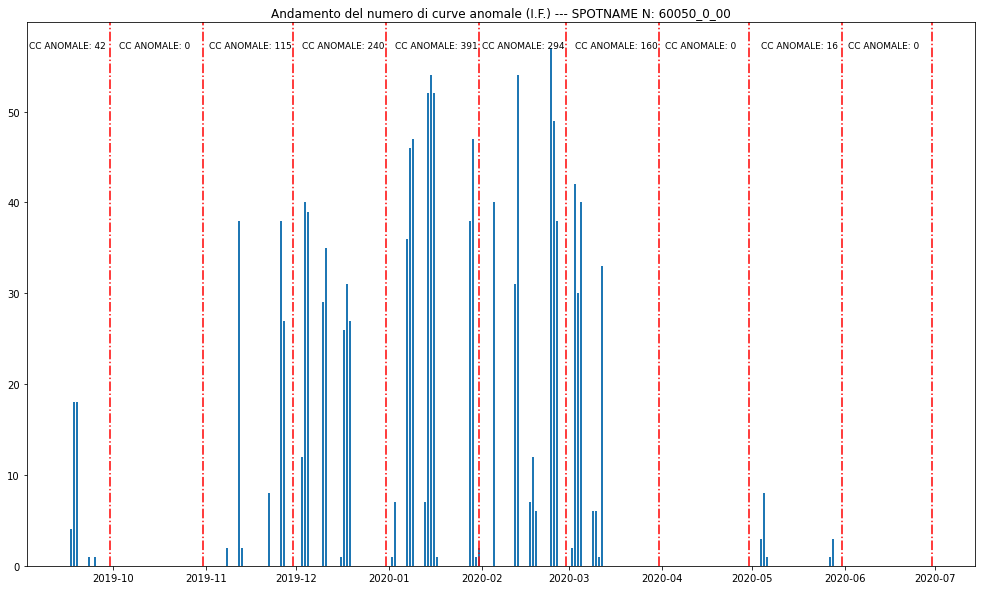

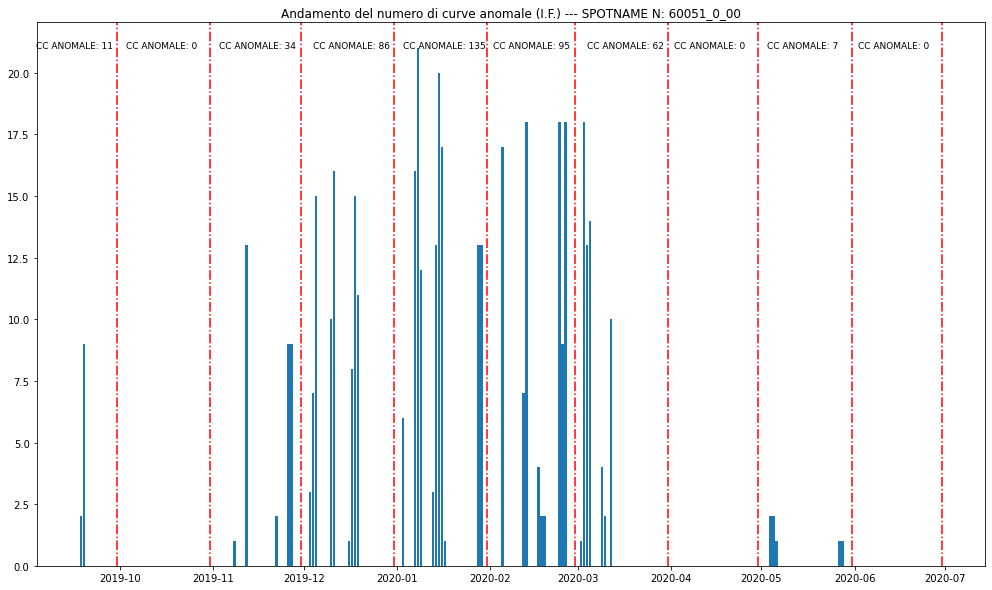

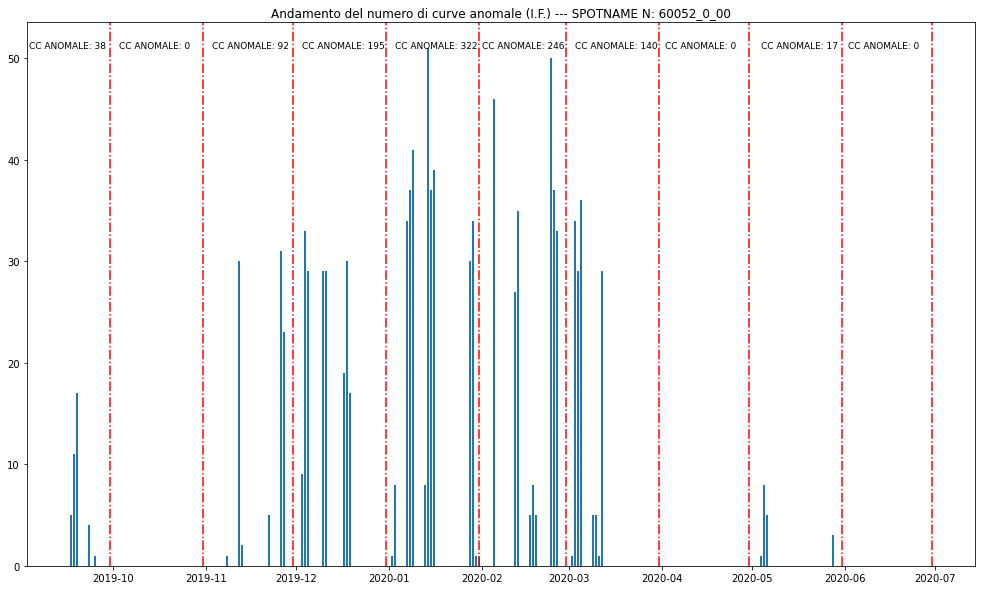

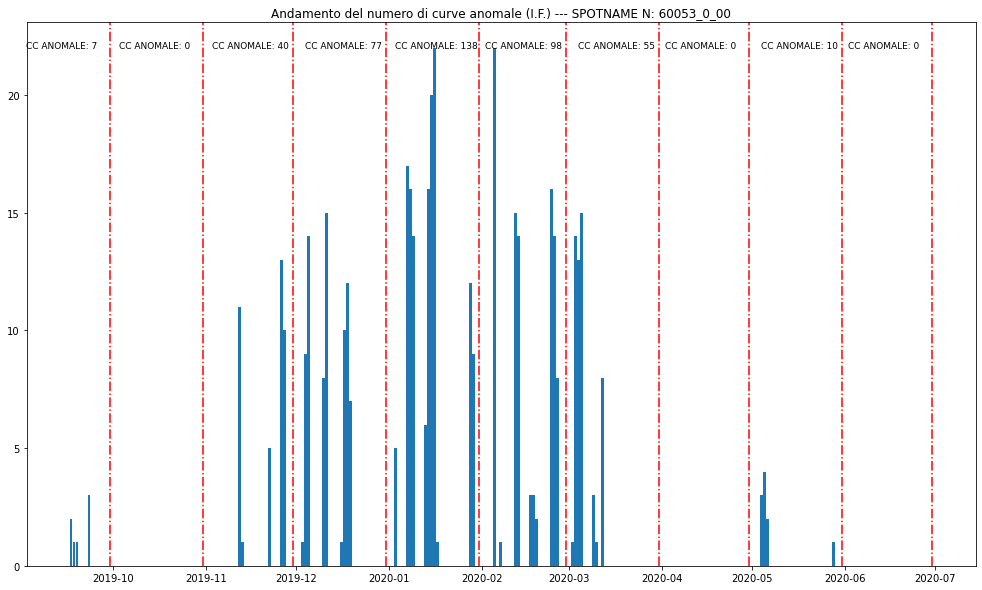

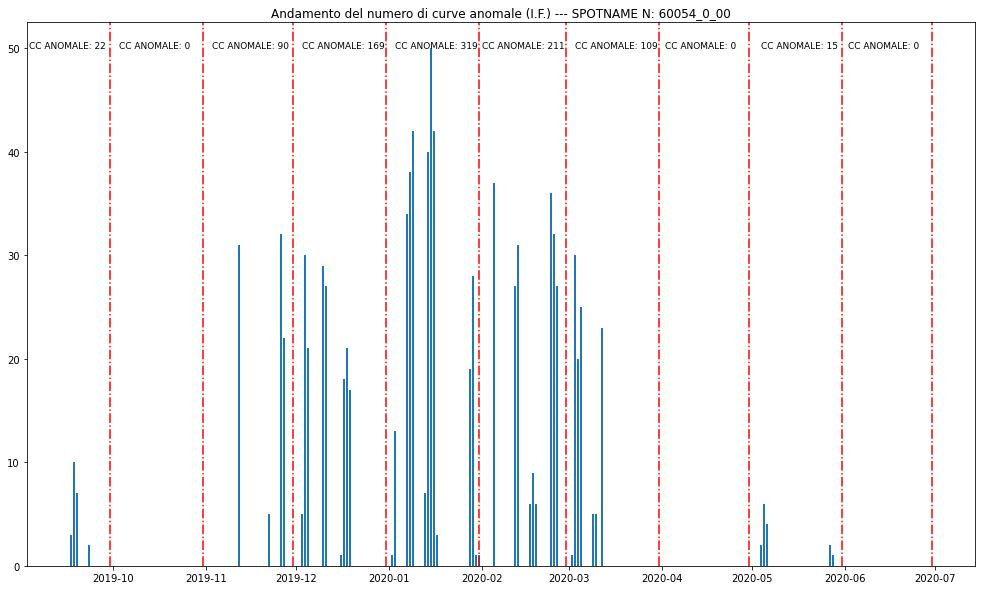

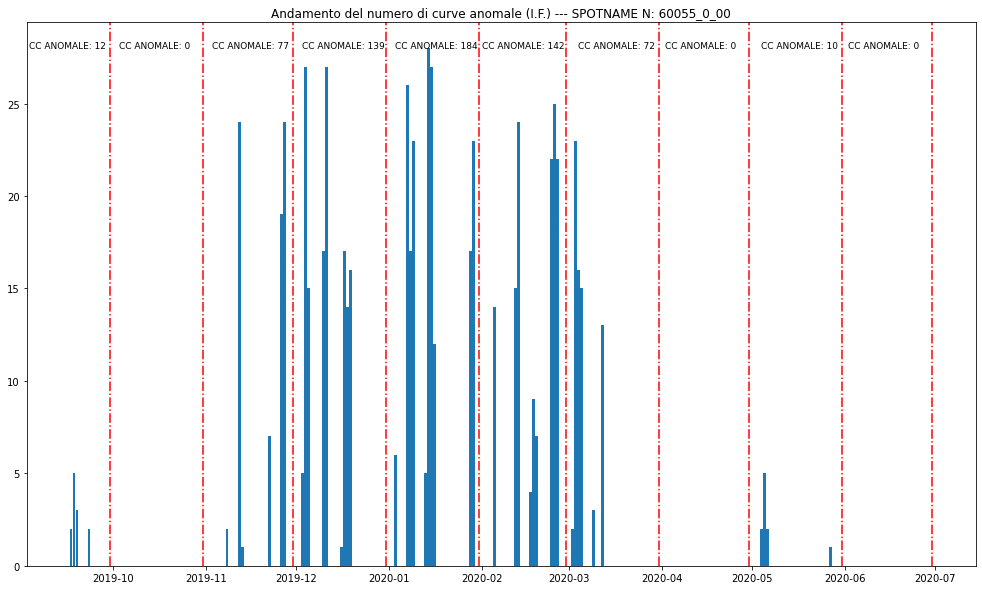

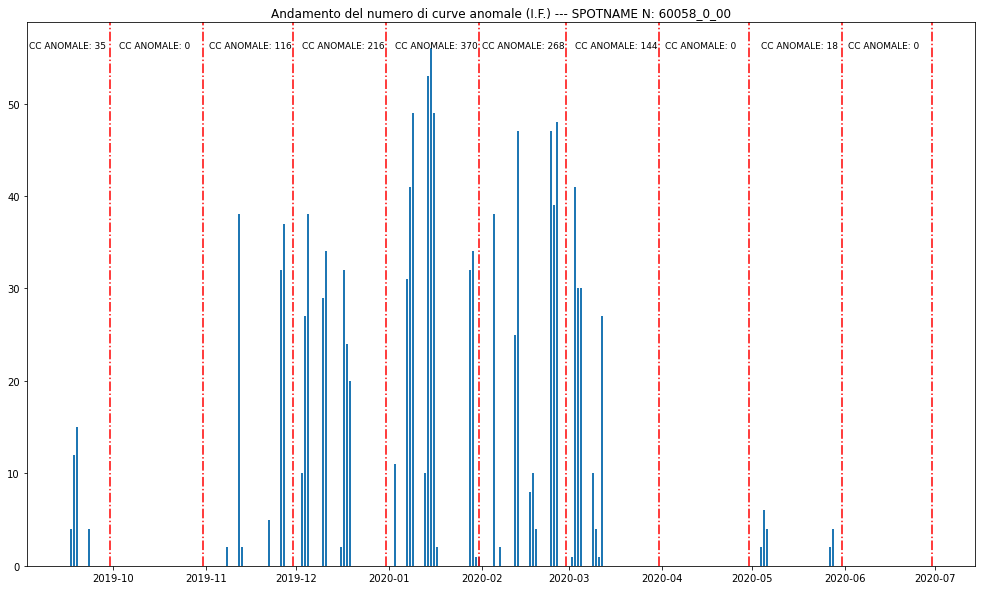

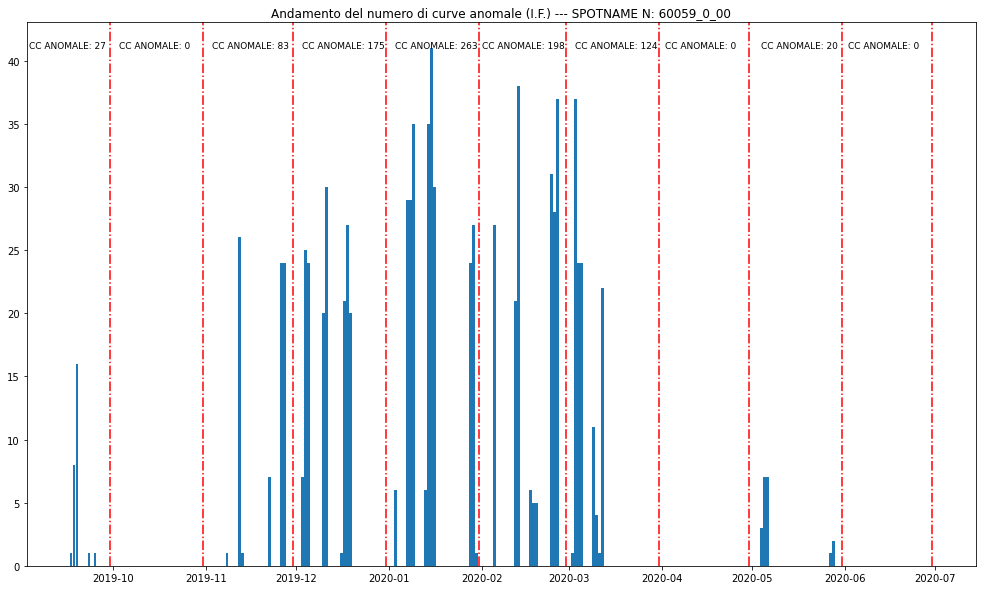

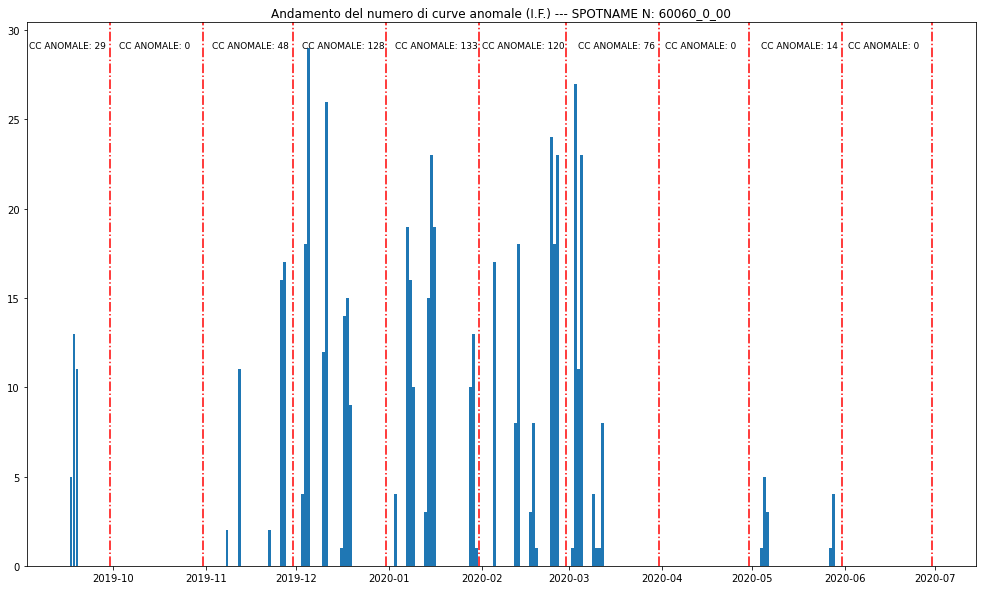

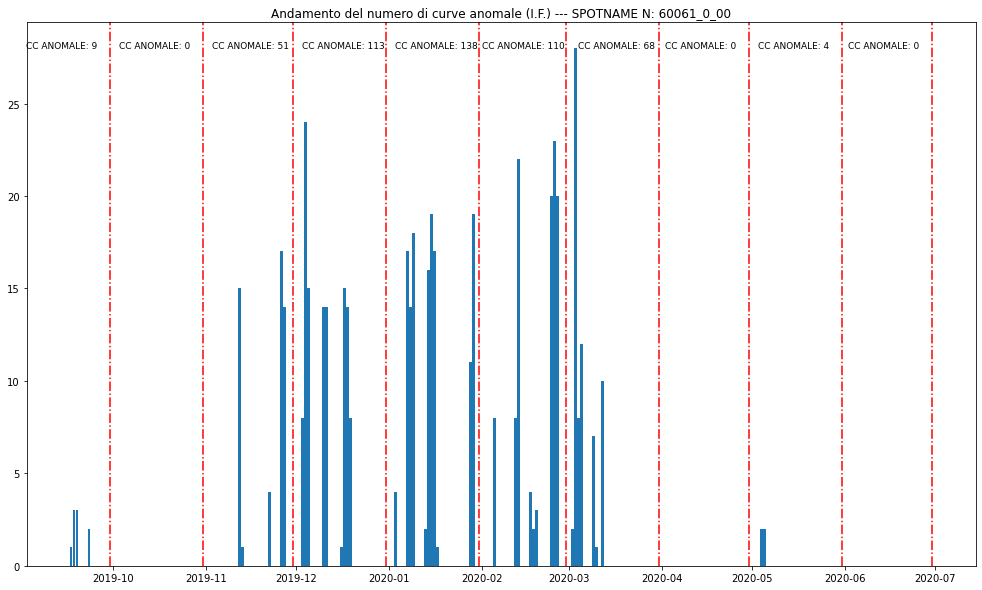

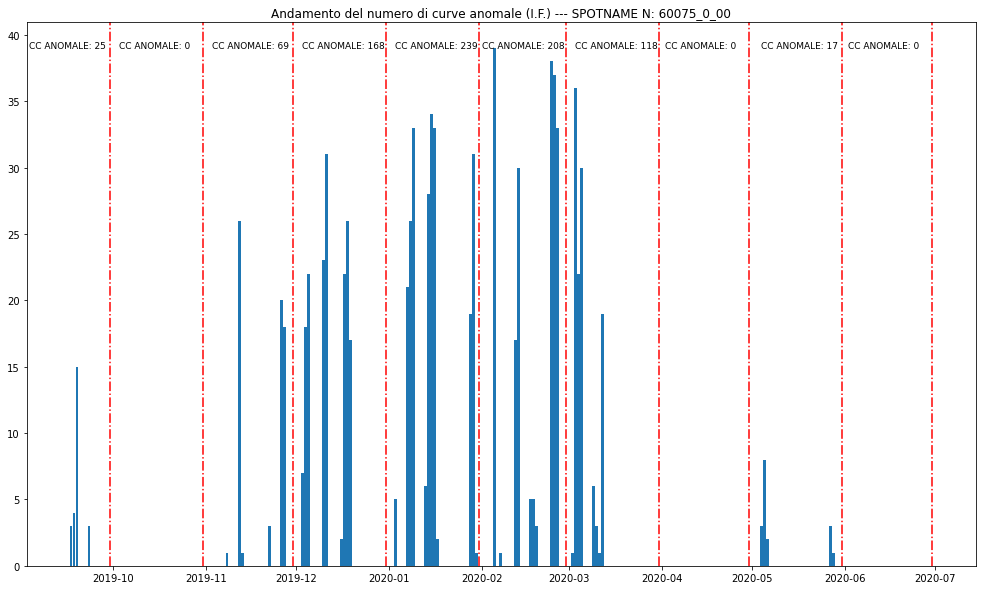

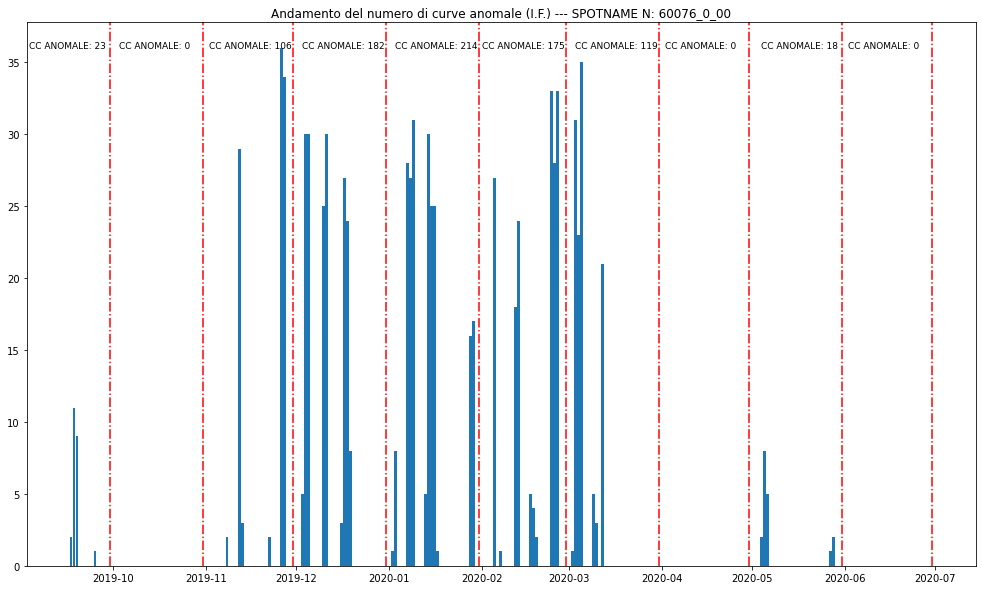

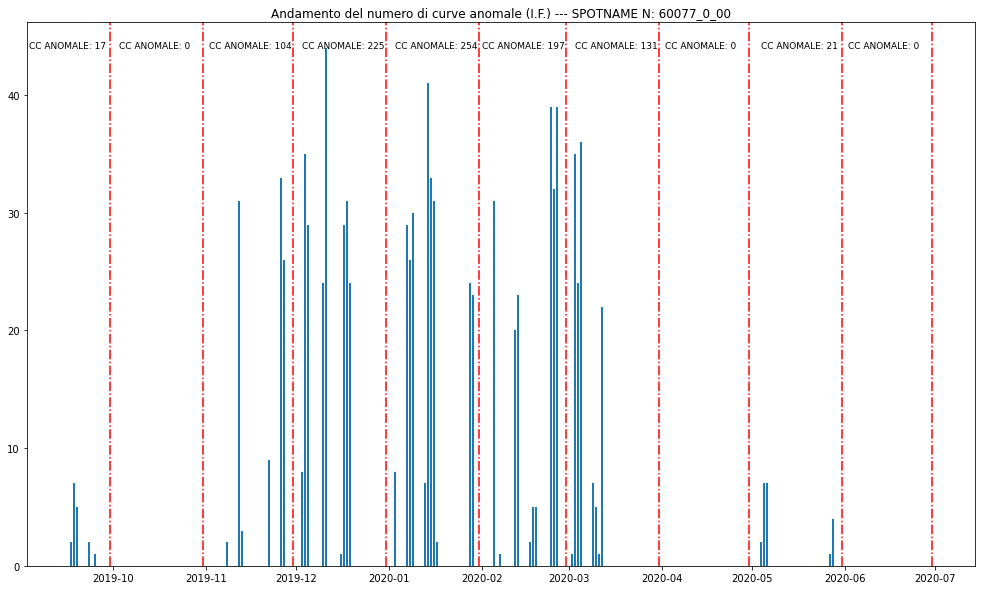

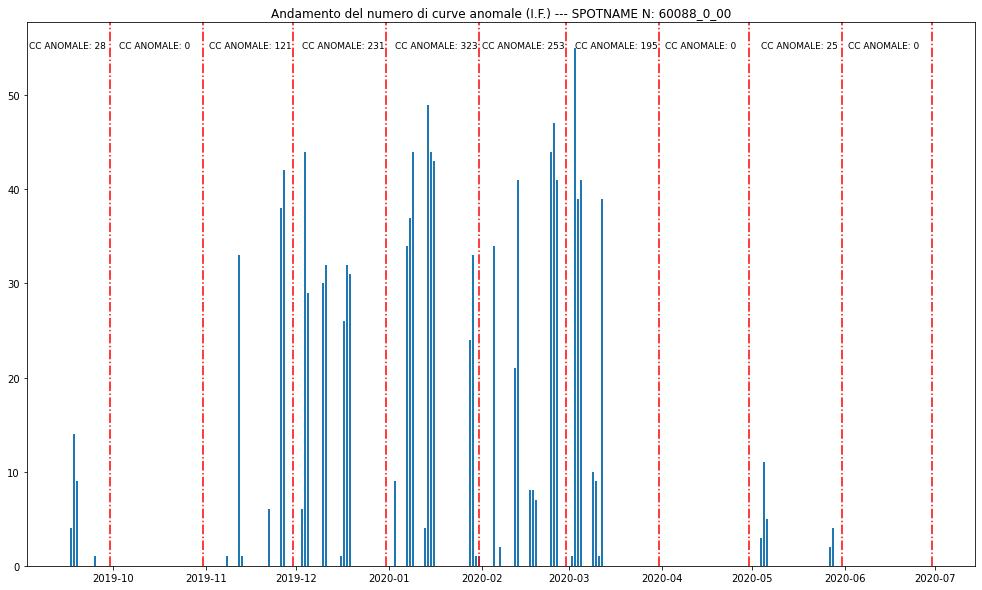

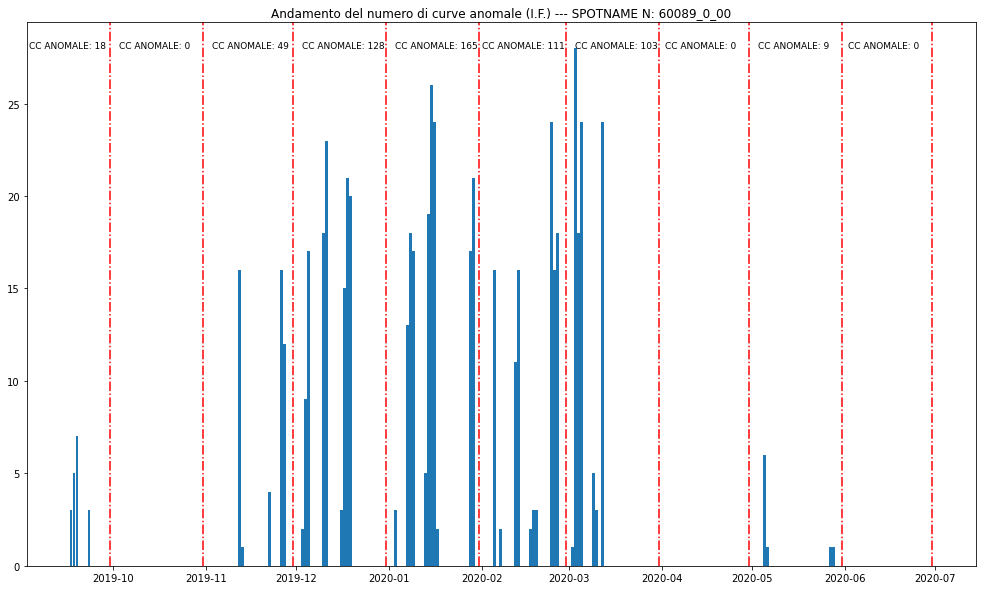

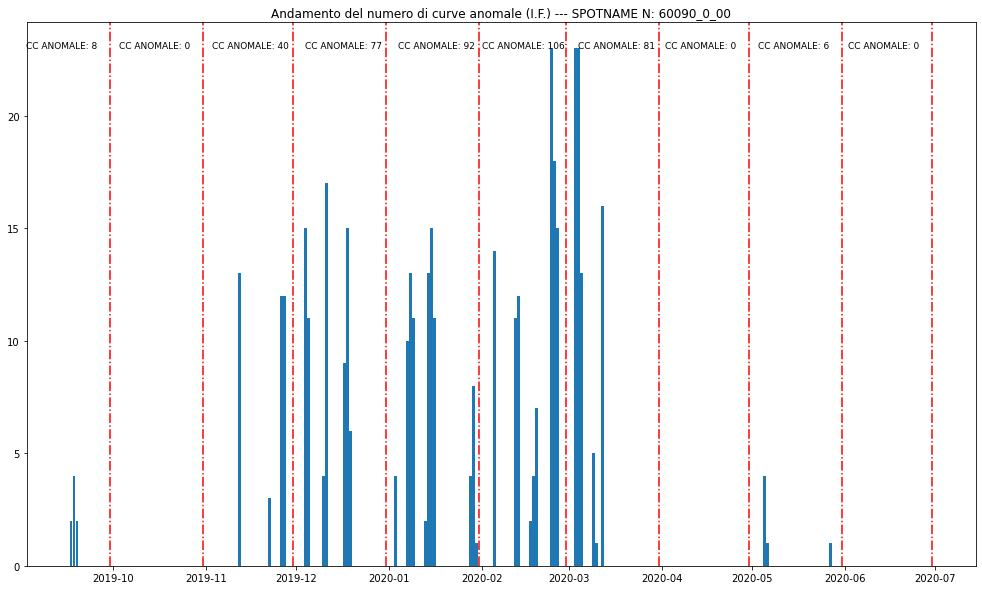

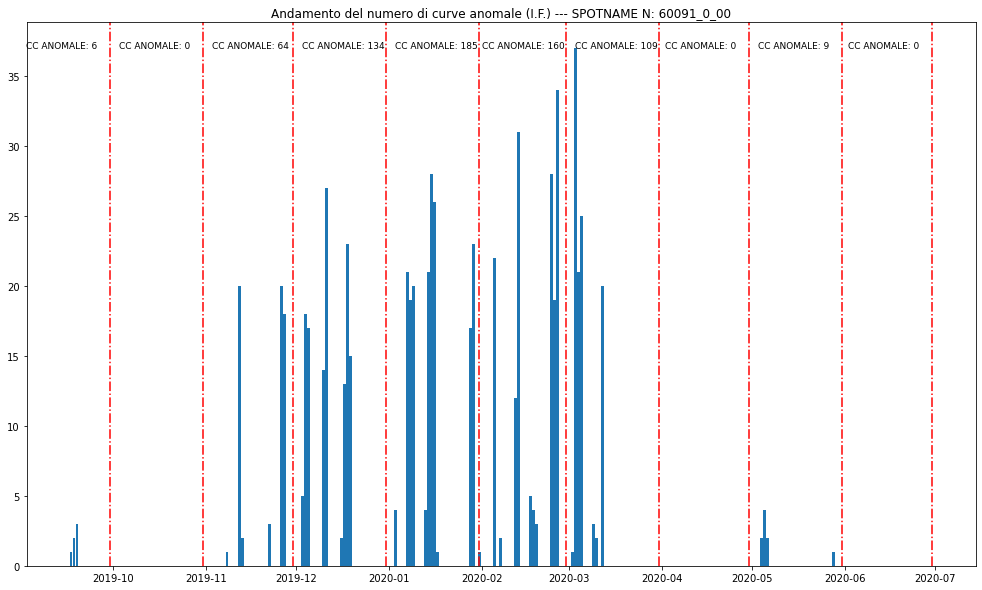

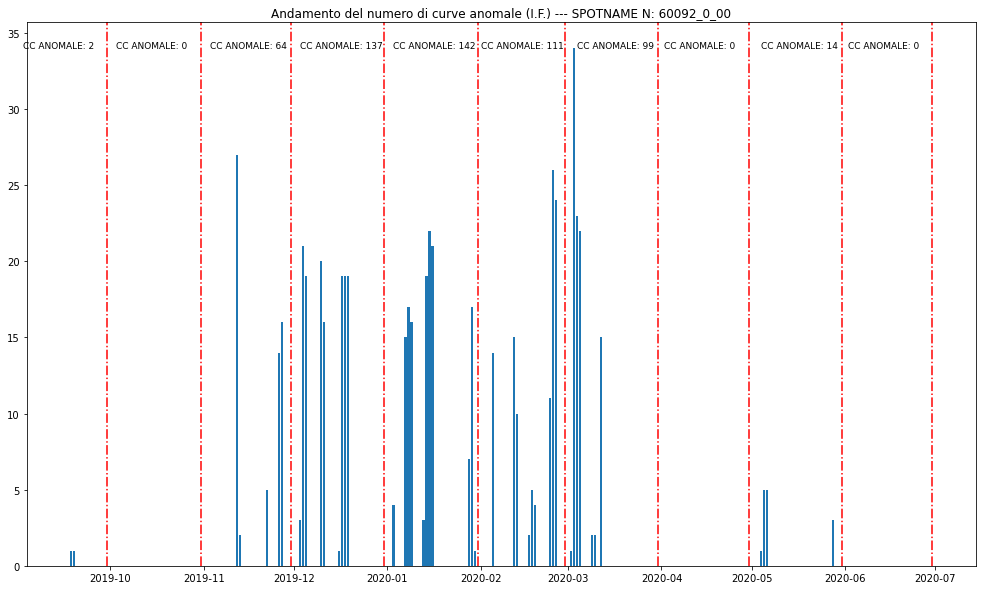

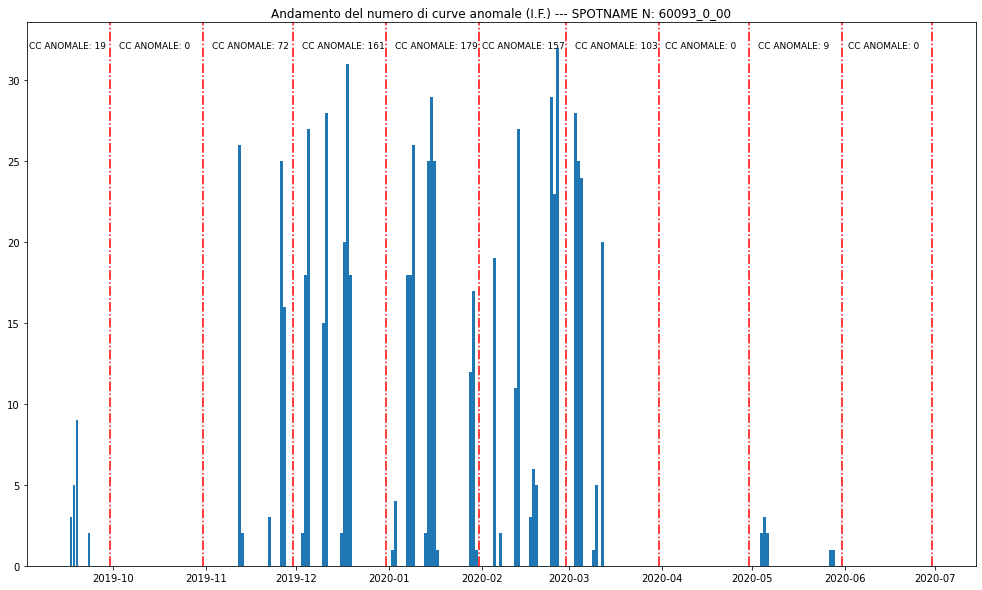

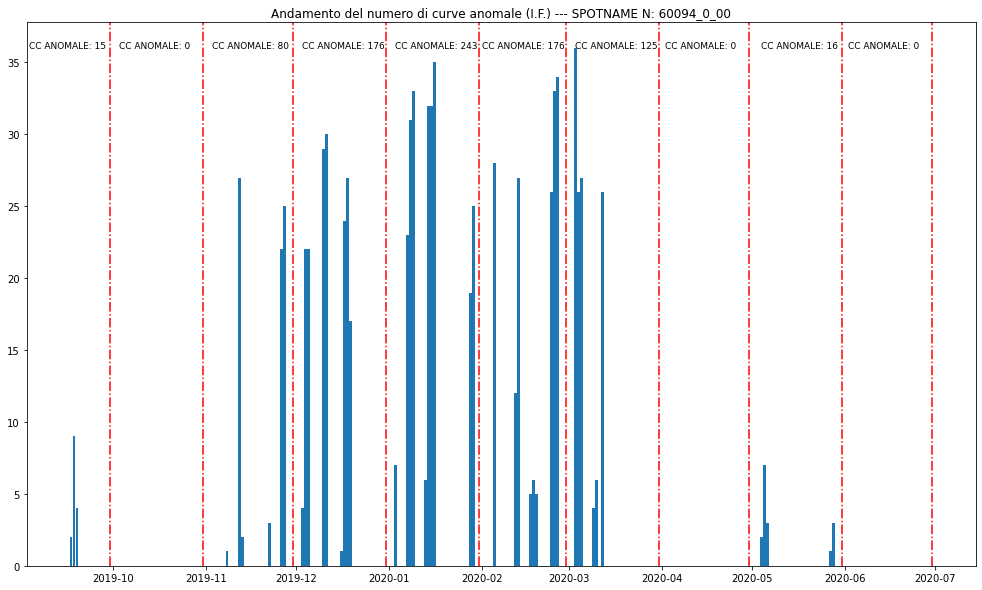

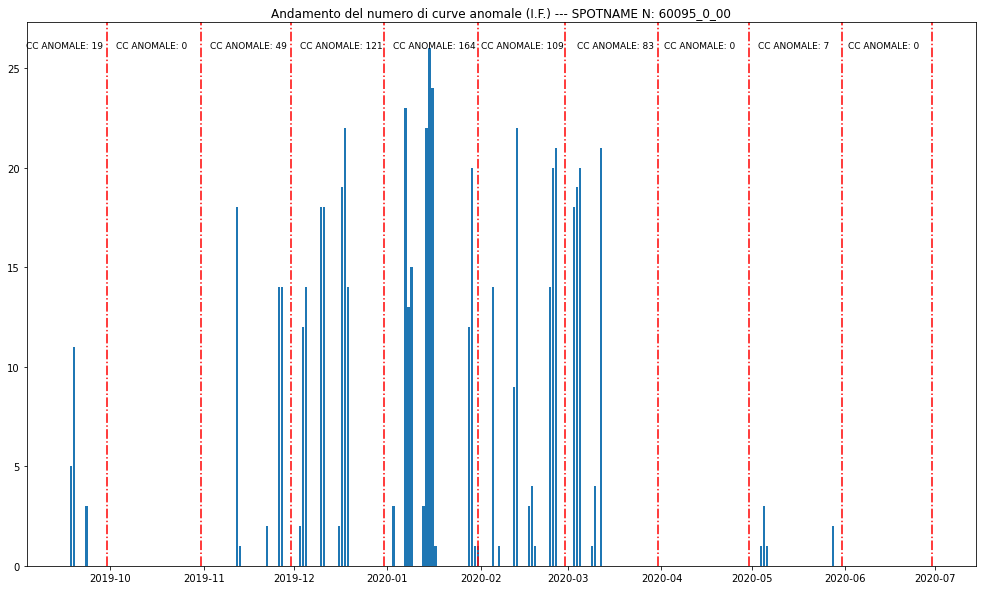

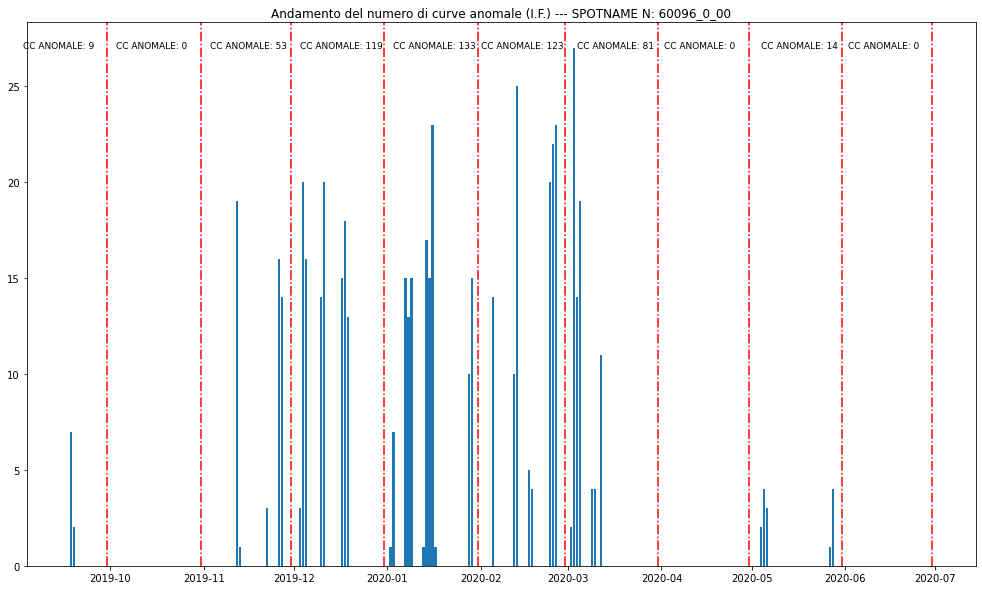

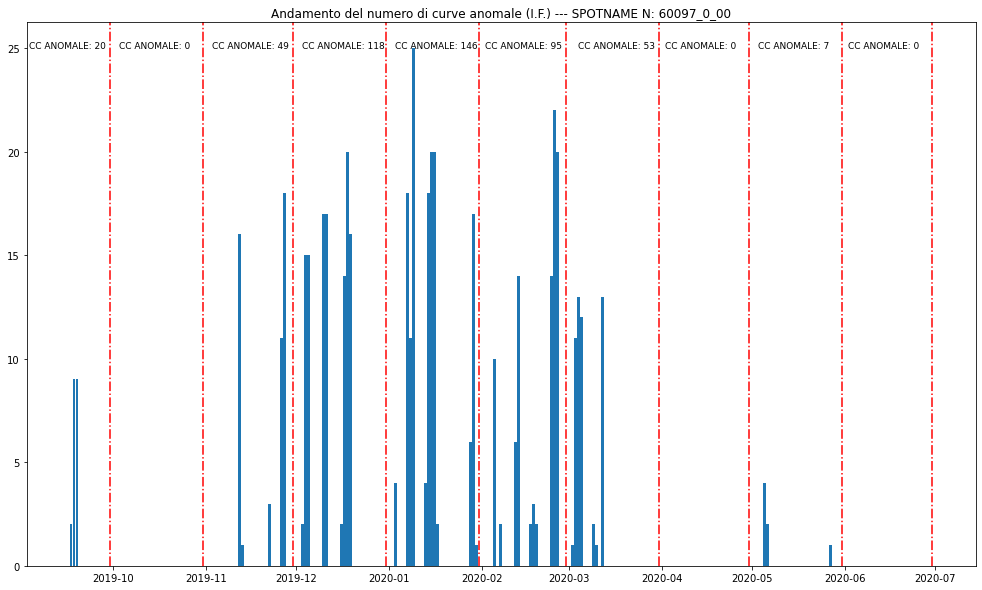

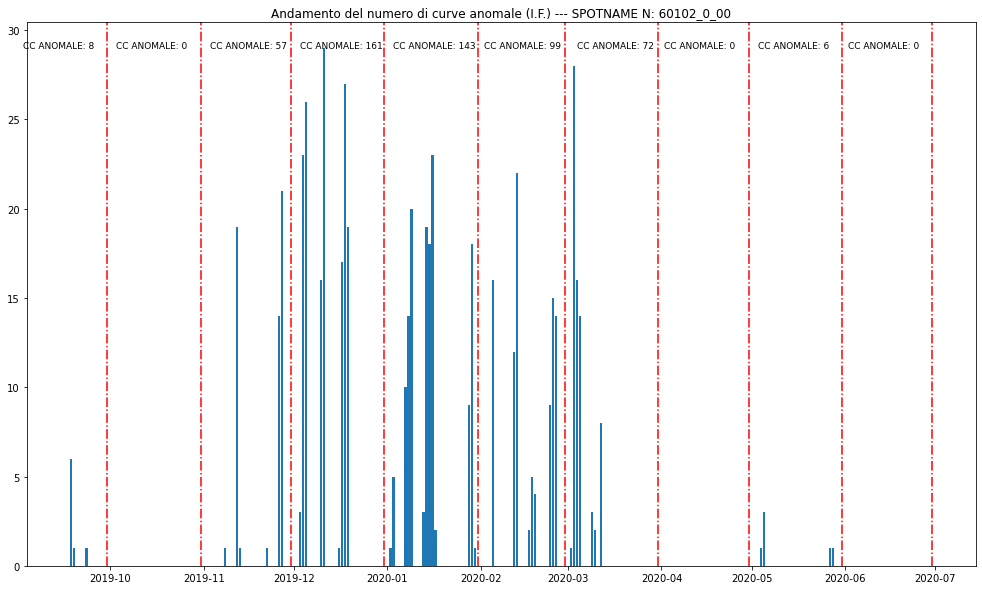

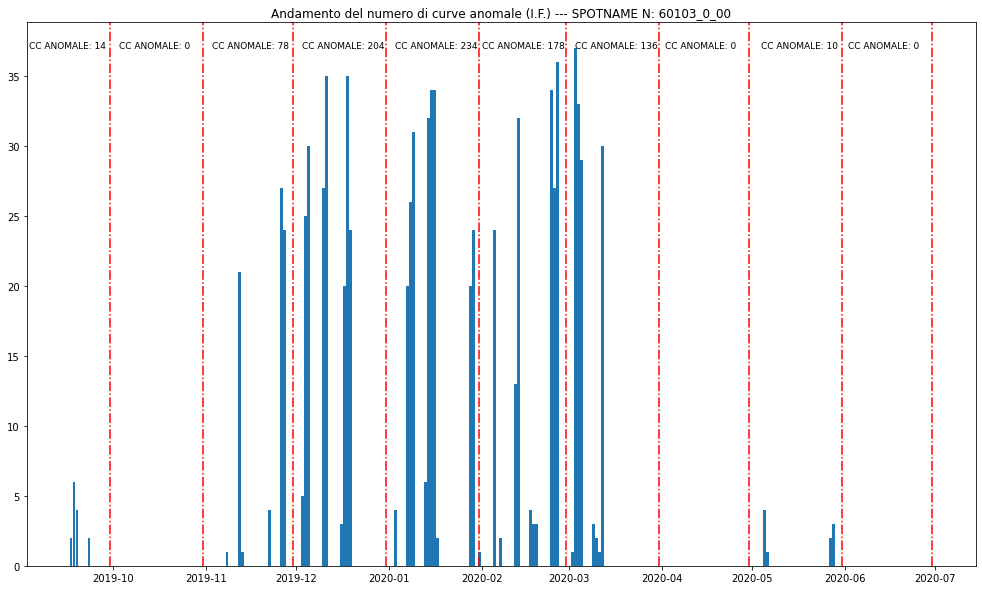

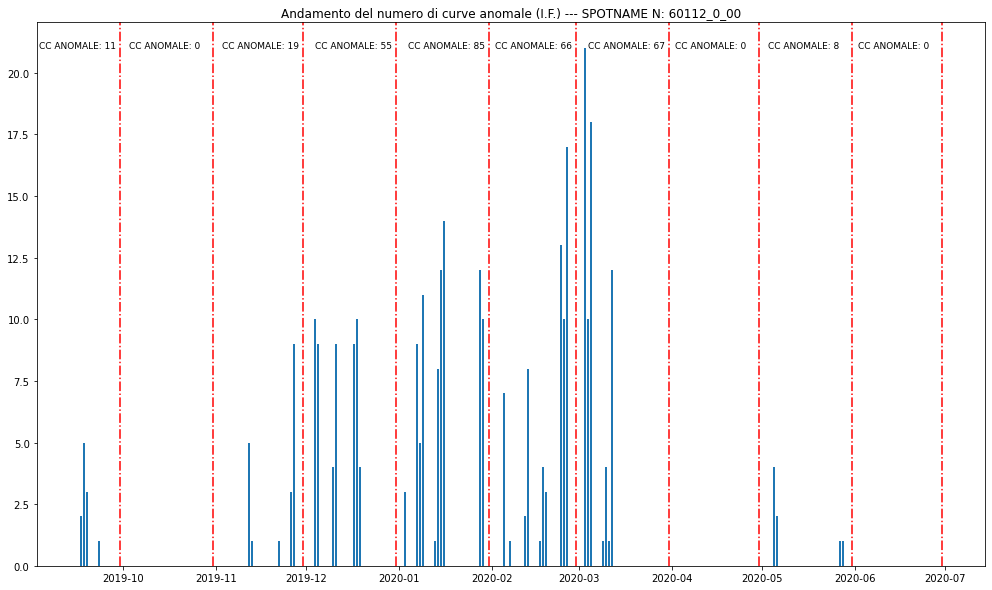

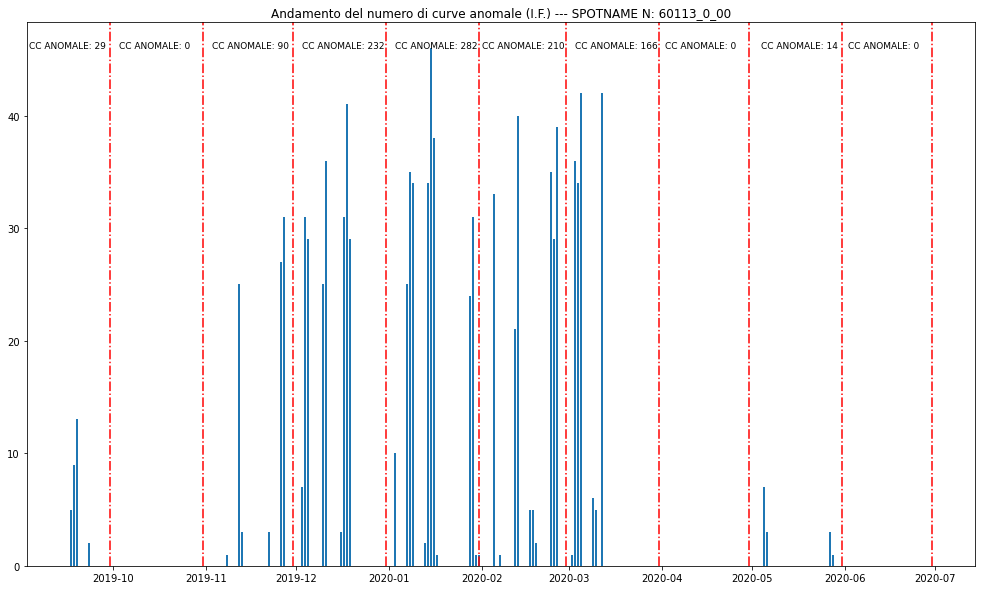

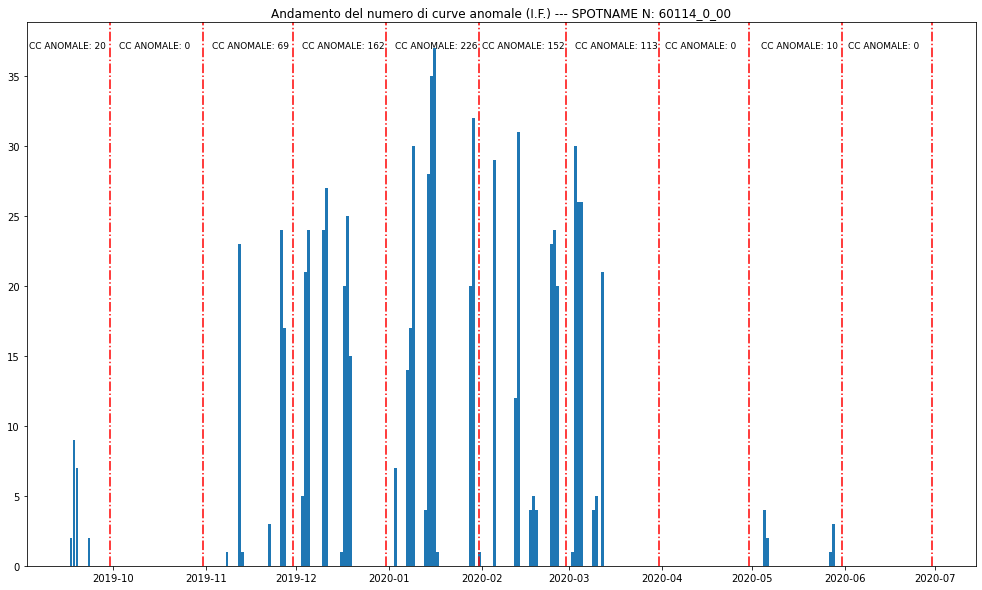

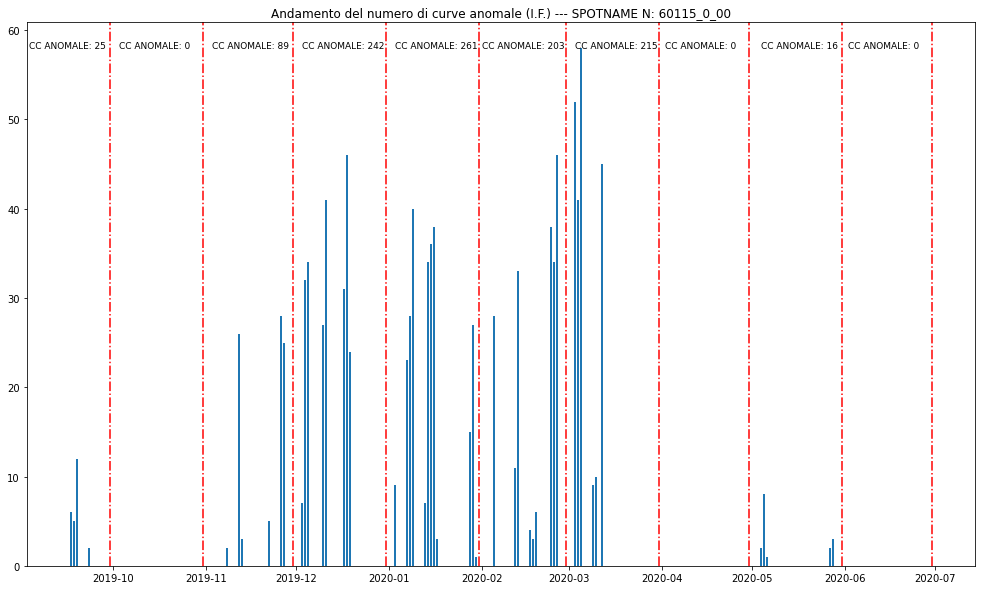

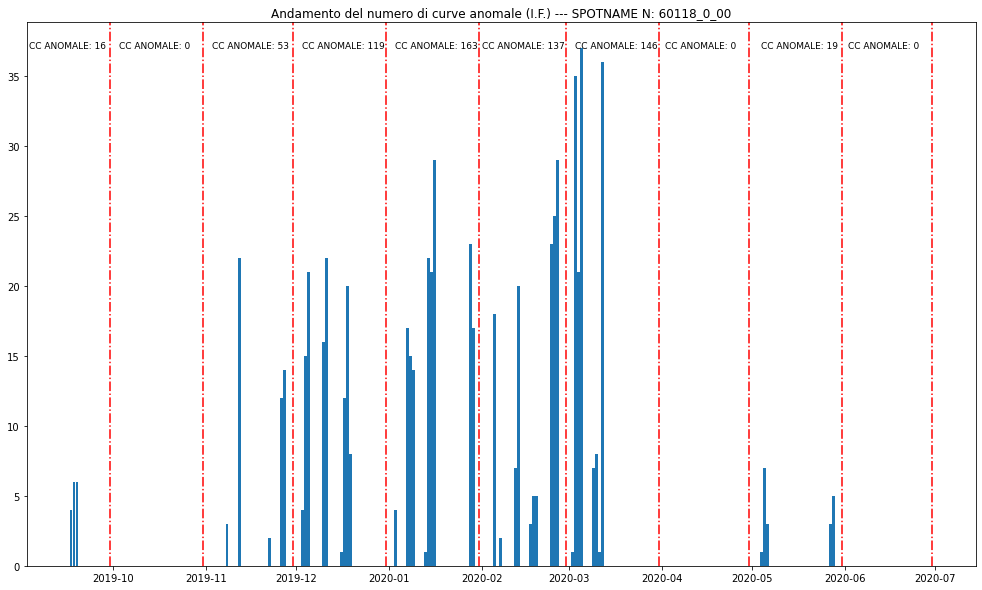

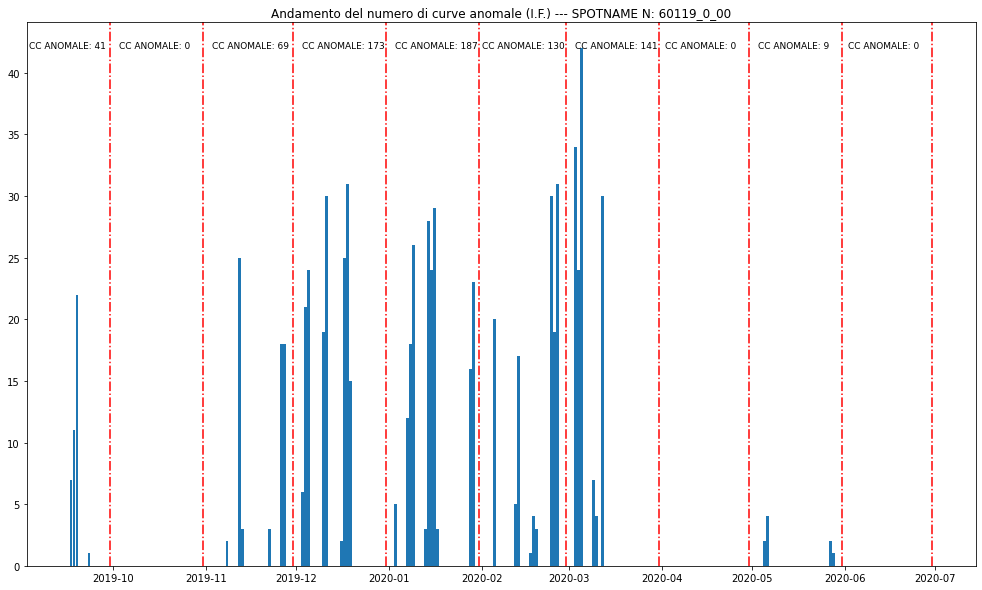

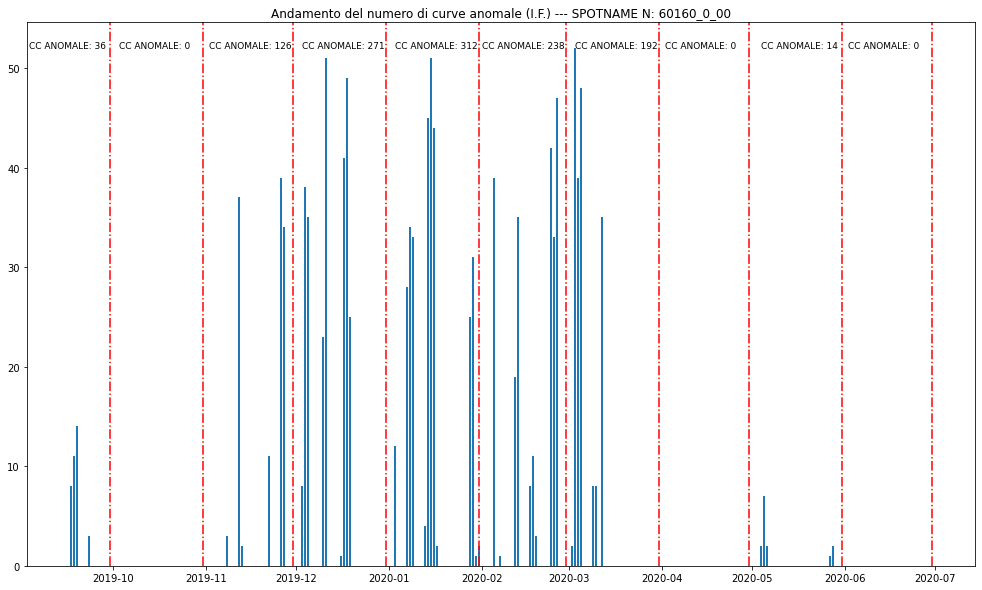

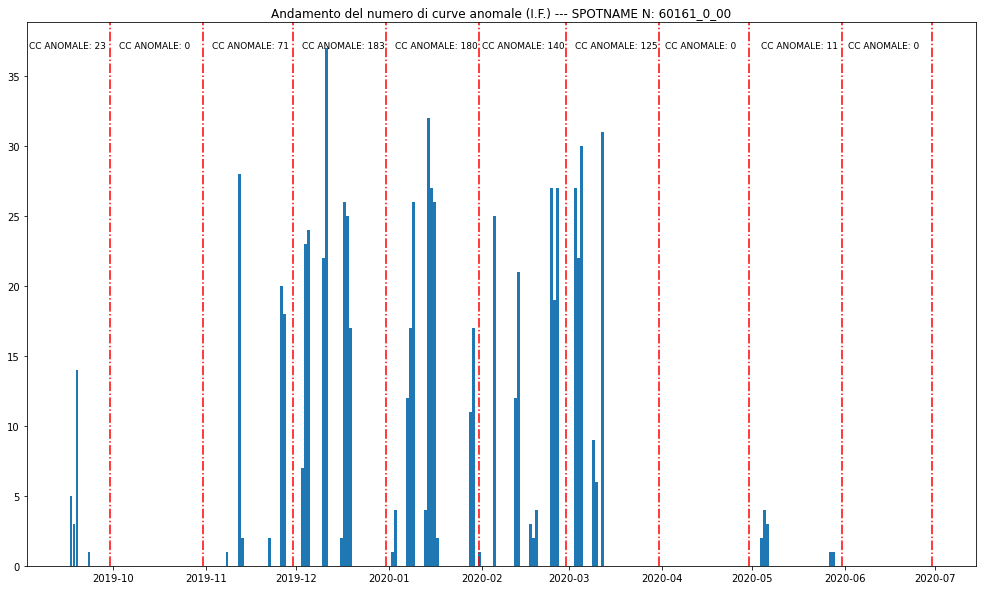

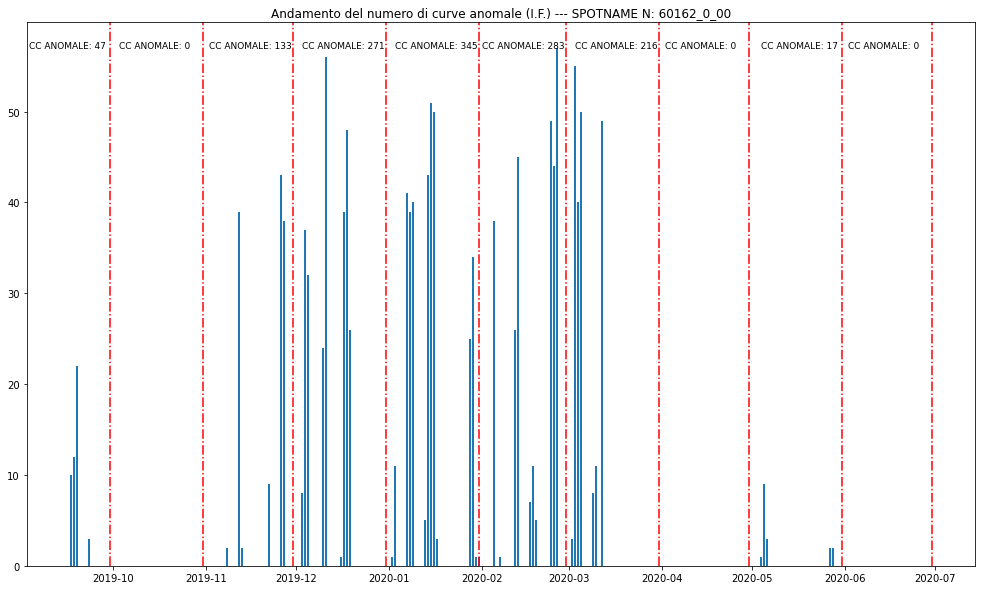

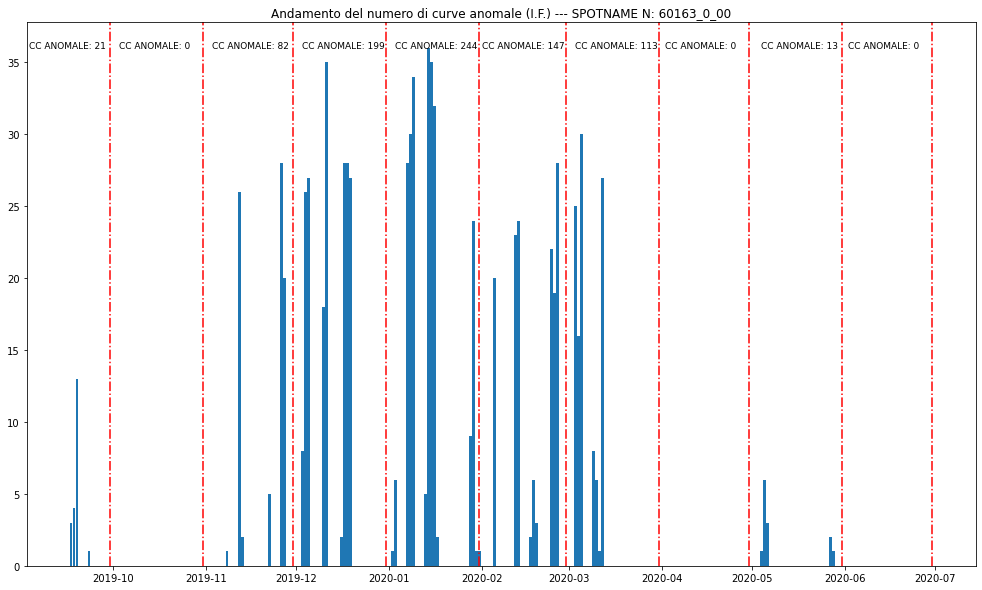

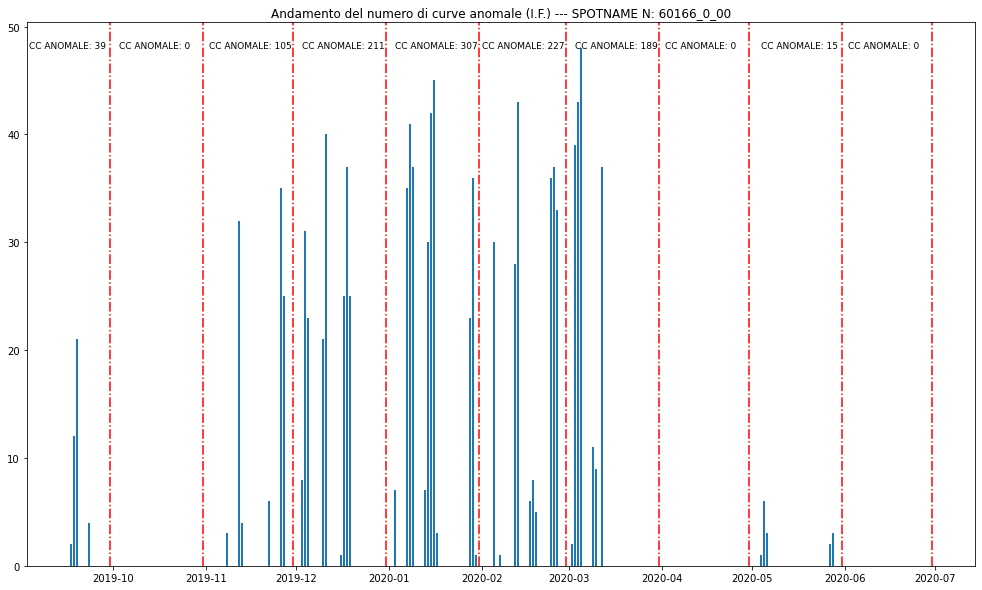

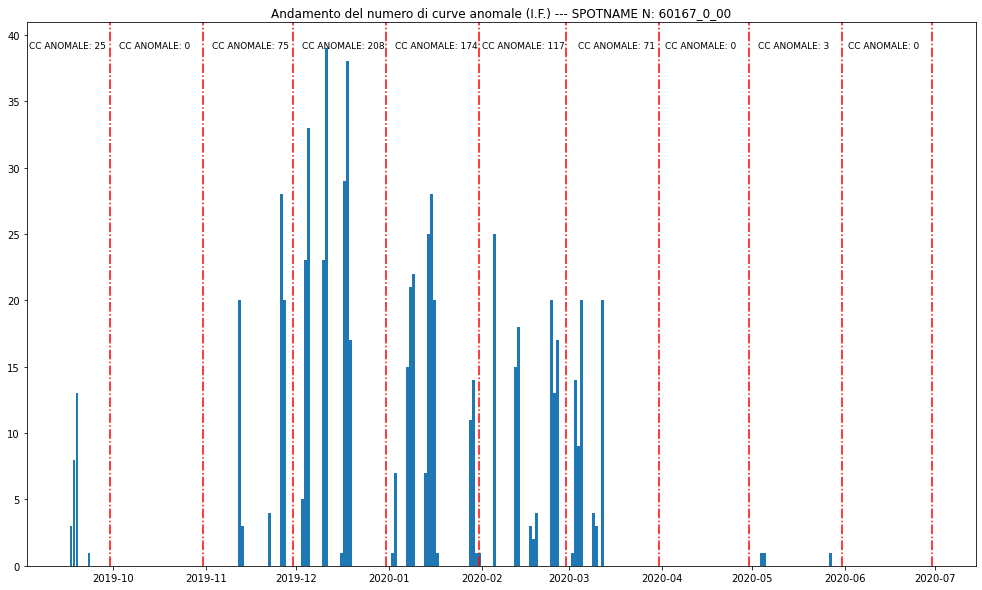

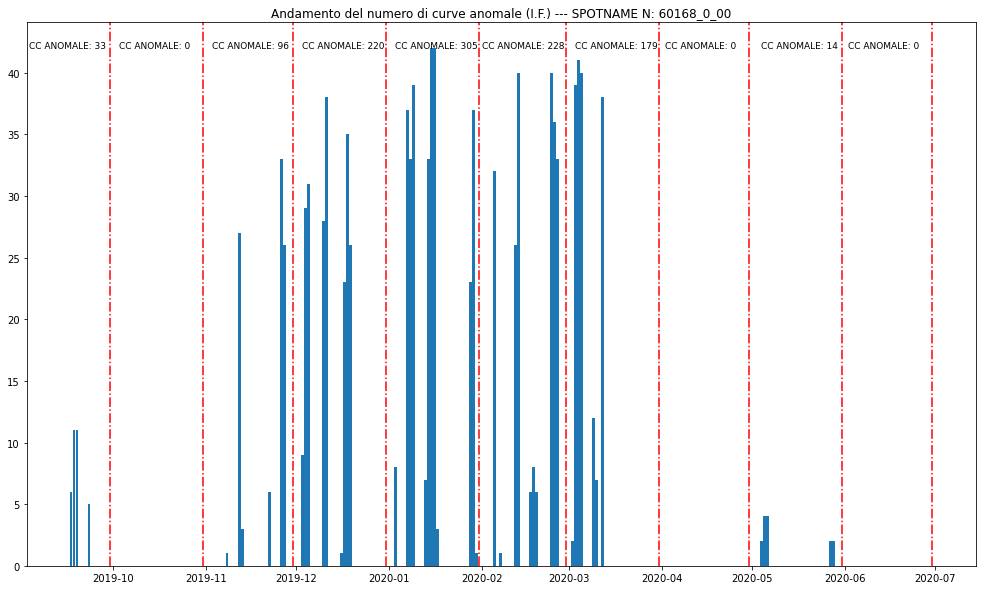

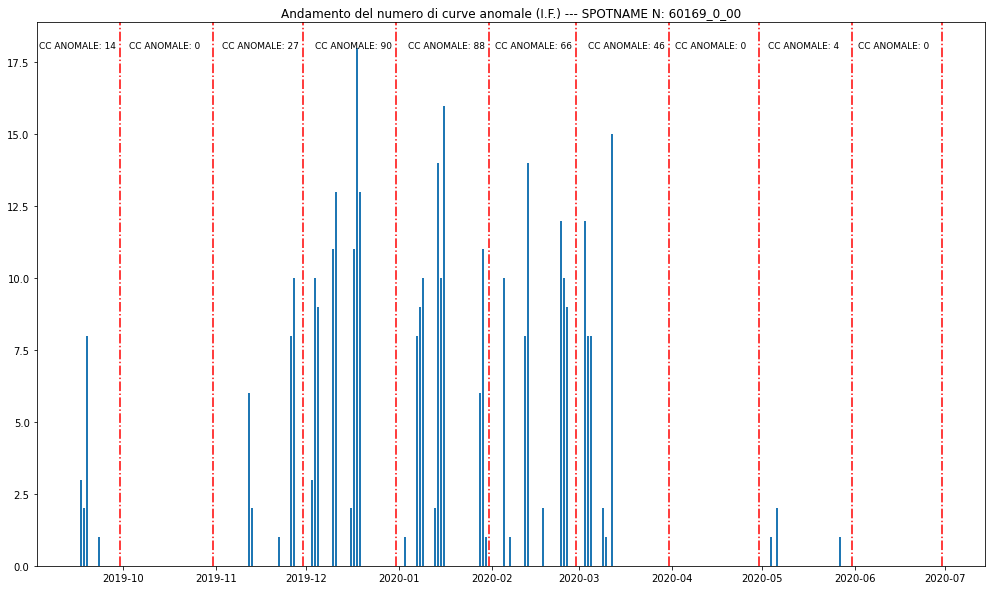

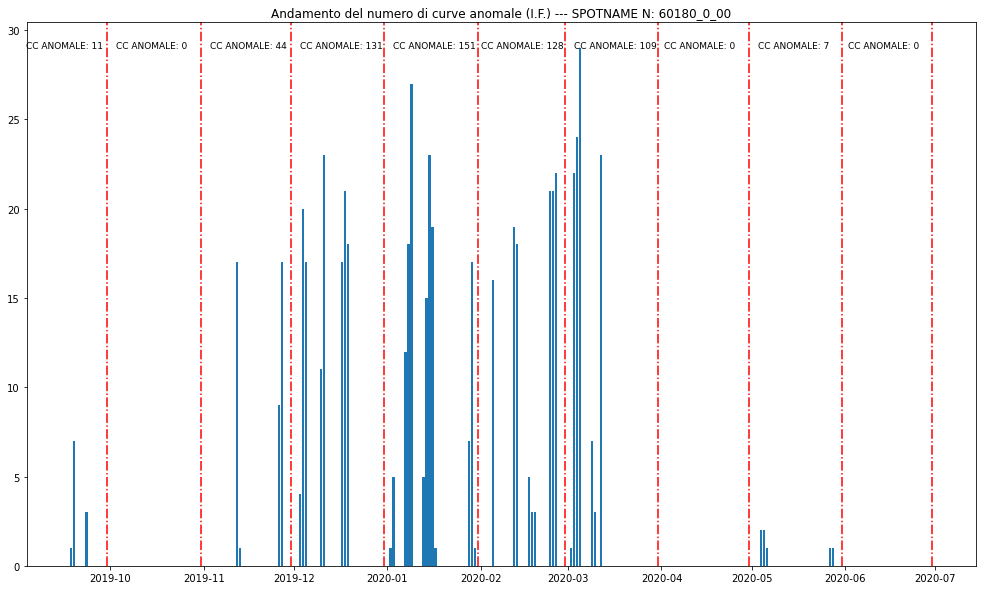

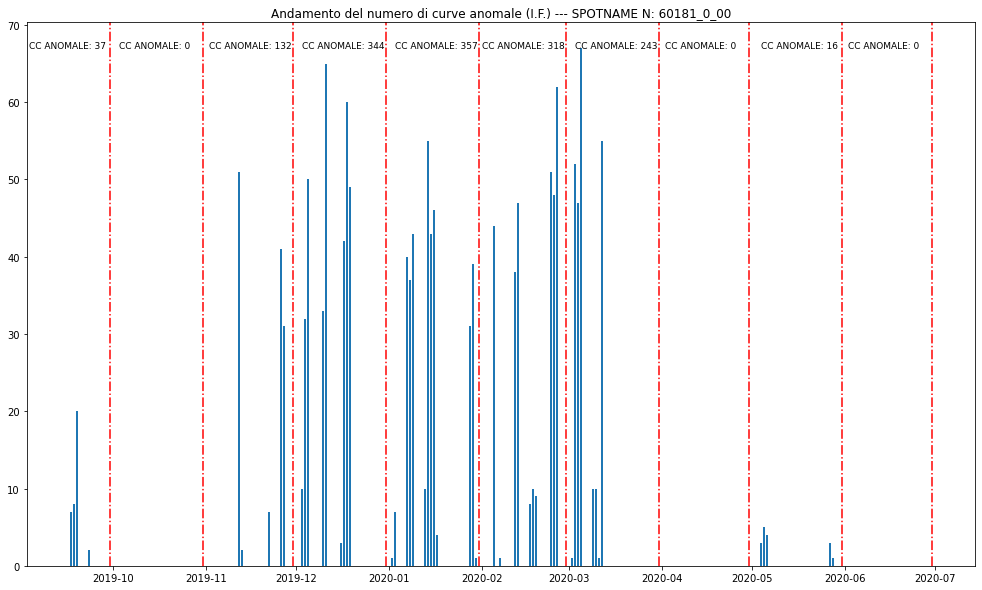

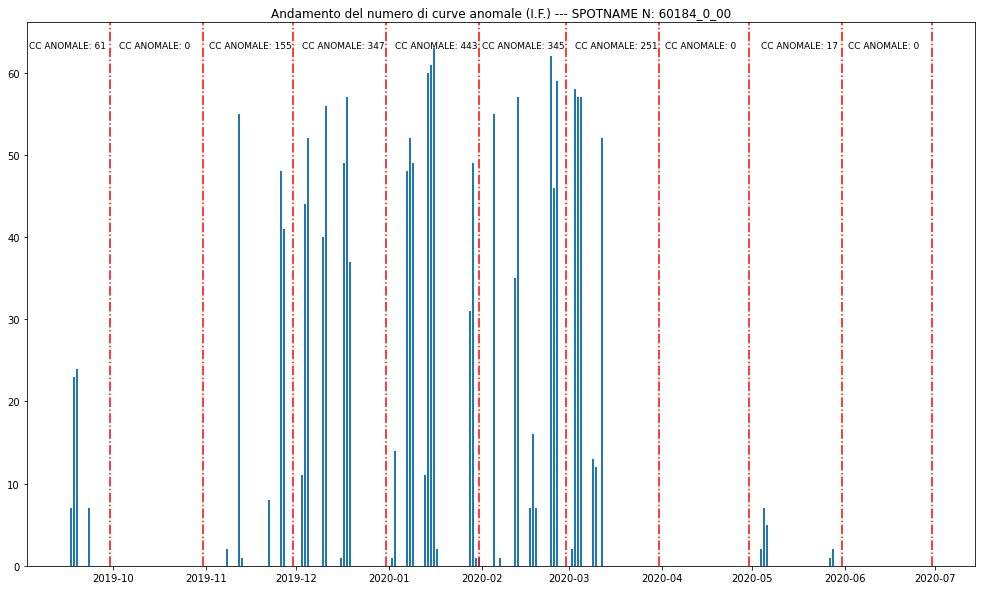

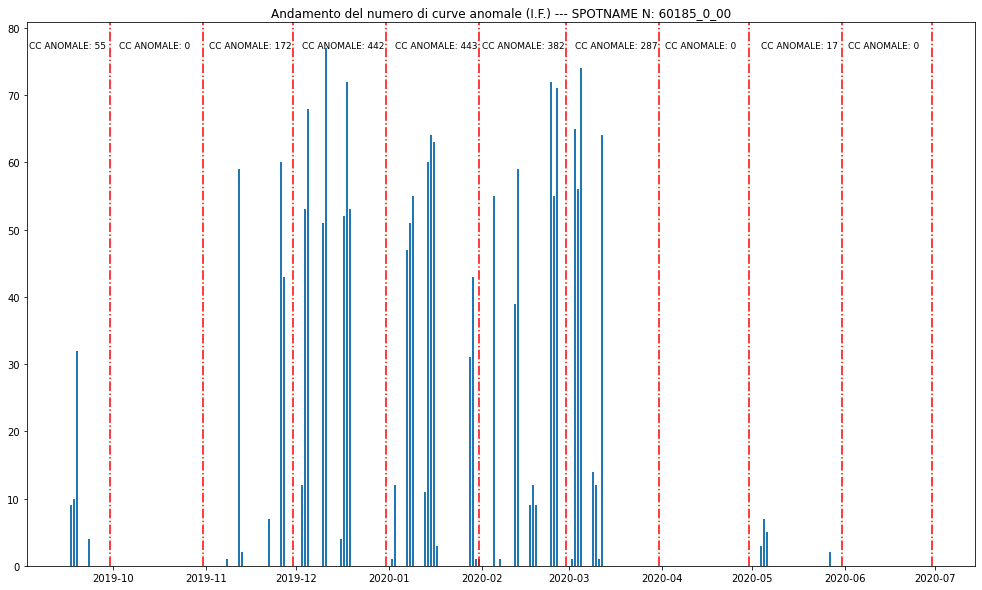

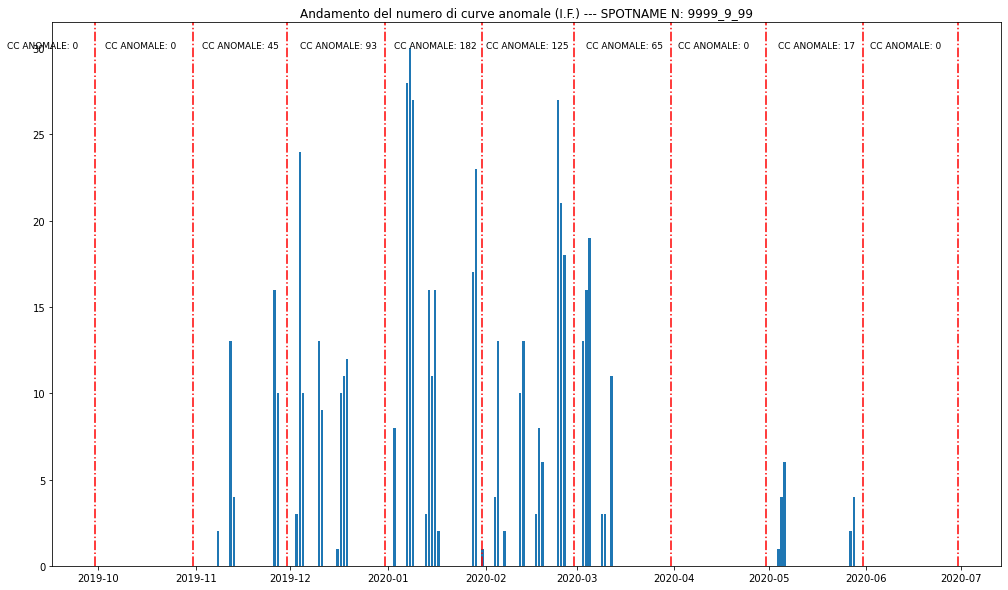

In [12]:
data = daily_analysis[daily_analysis.n_IF_anom > NOT_ANOM].groupby(['spotName', 'Date'])['CurrentCurve'].agg(
    count='count').reset_index()
list_date = pd.date_range(pd.to_datetime(
    '2019-09-01'), pd.to_datetime('2020-06-30'), freq='1M')
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]
    plt.figure(figsize=figsize)
    plt.title(
        f"Andamento del numero di curve anomale (I.F.) --- SPOTNAME N: {spotname}")
    # visualizziamo delle linee verticali per ogni mese
    for date in list_date:
        # plot linea per ogni mese
        plt.axvline(date, linestyle='-.', color='r')
        # numero di giorni da cui iniziare a plottare il testo
        left_shift = 24
        month = date.month
        year = date.year
        # totale numero cc anomale per rispettivo anno e mese
        tot_anom = sum(temp_ds[(temp_ds.Date.dt.year == year) & (
            temp_ds.Date.dt.month == month)]['count'])
        # sposto testo a sx in base al numero di cifre -> riduco errori grafici
        if tot_anom > 99 or tot_anom < 10:
            left_shift = 28
        if 10 <= tot_anom <= 99:
            left_shift = 27
        # scrivo il testo ogni mese - tot giorni, in modo da accentrarlo per ogni mese
        text = f"CC ANOMALE: {tot_anom}"
        plt.text(date - dt.timedelta(days=left_shift),
                 max(temp_ds['count']), text, fontsize=9)

    plt.bar(temp_ds.Date, temp_ds['count'])
    plt.show()

### Per ogni spotname, tot. anomalie per anno

In media nel 2020 sembra che ci sia stato un incremento del numero delle curve anomale indipendentemente dallo spotname.

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


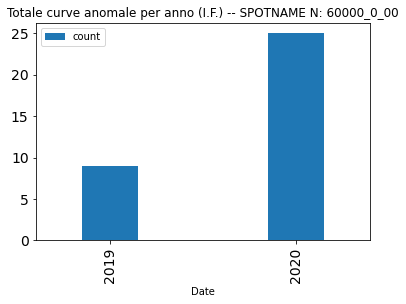

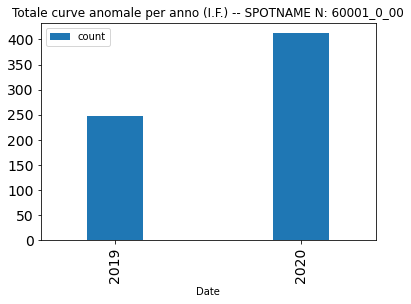

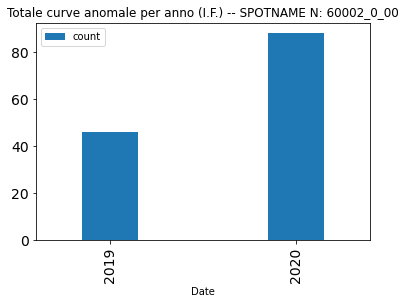

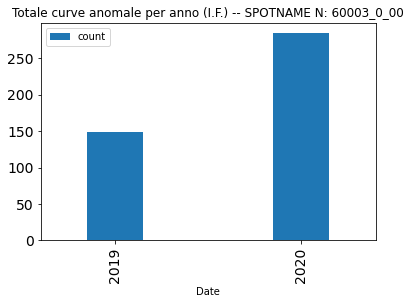

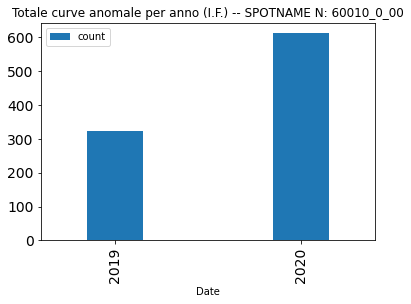

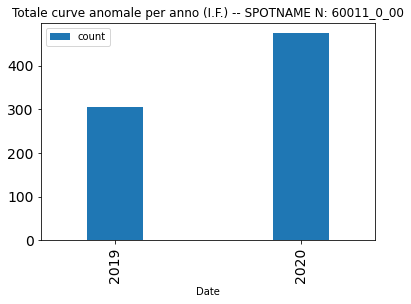

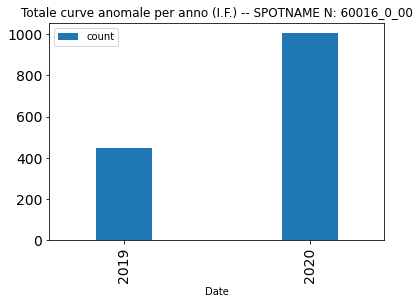

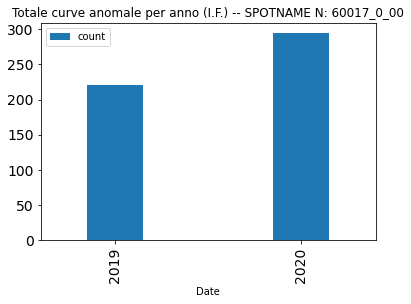

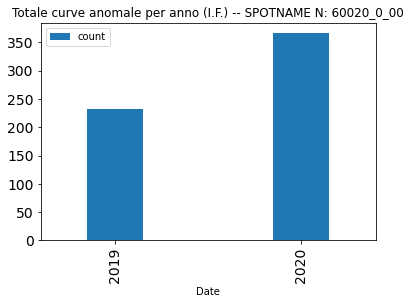

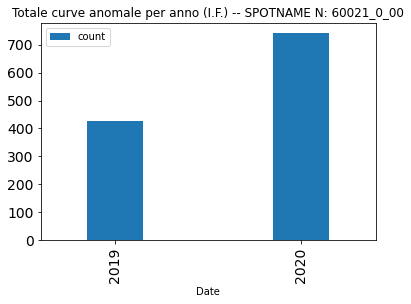

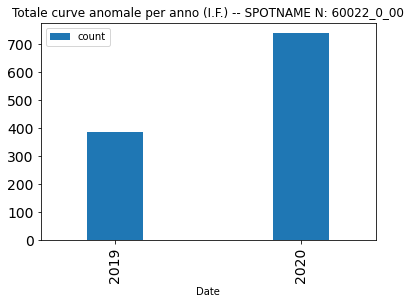

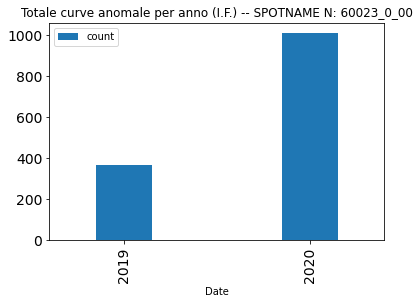

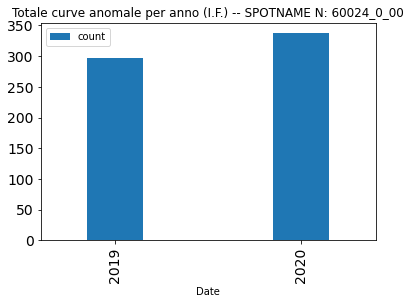

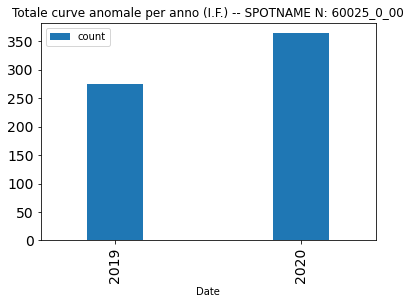

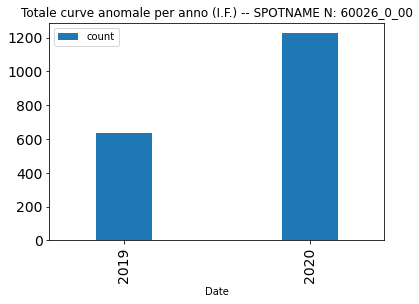

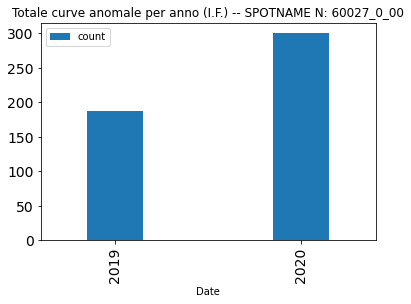

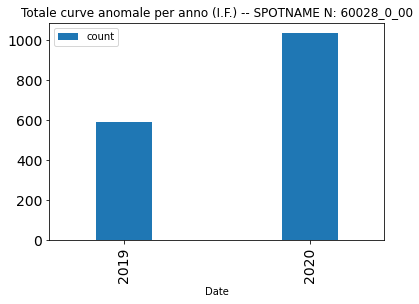

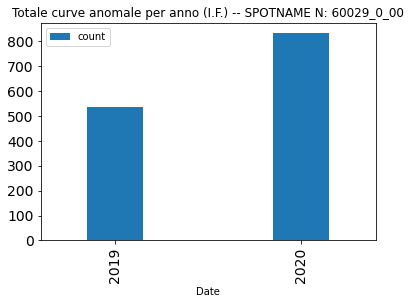

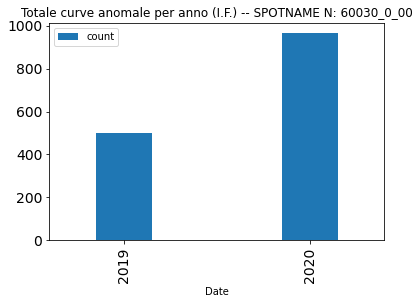

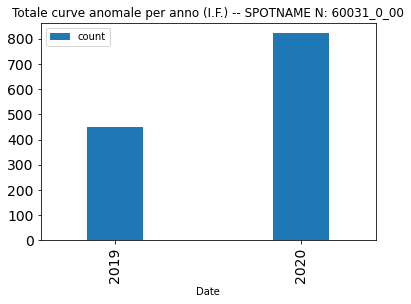

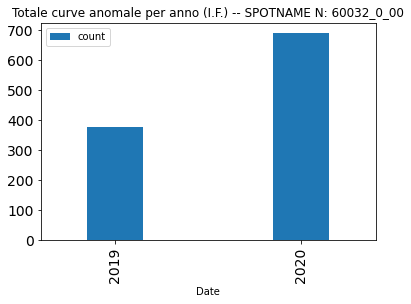

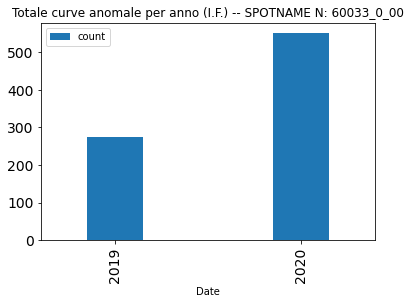

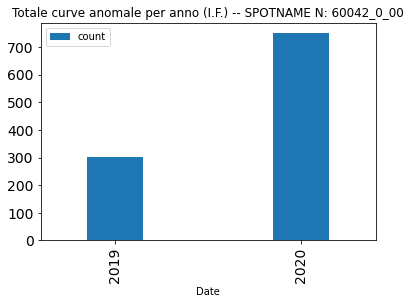

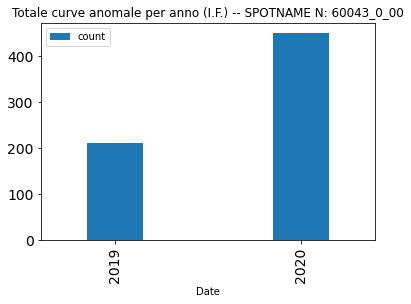

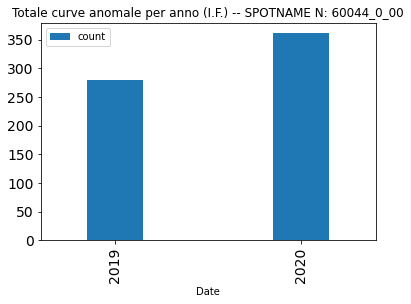

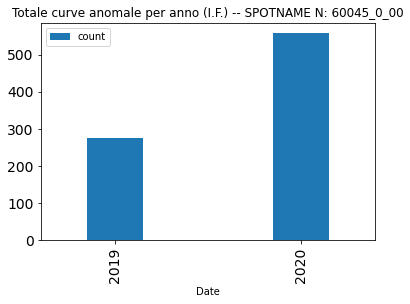

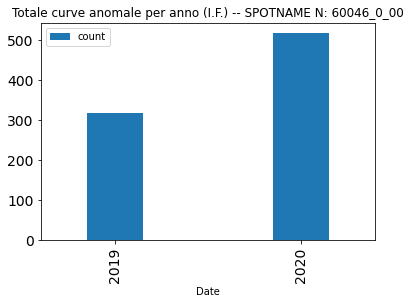

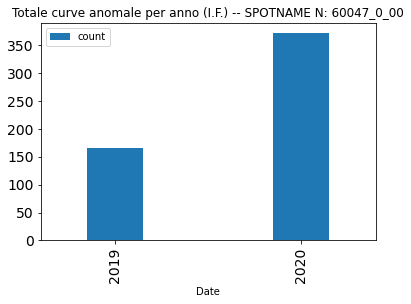

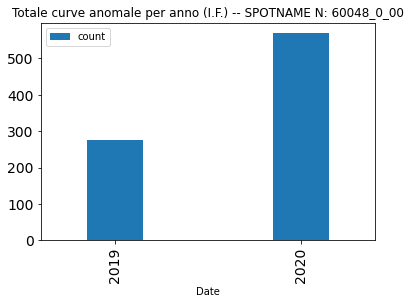

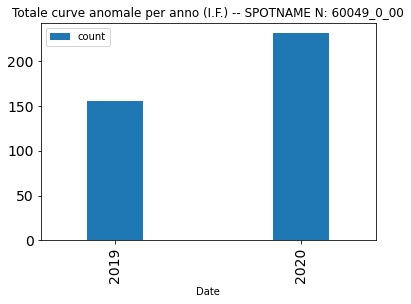

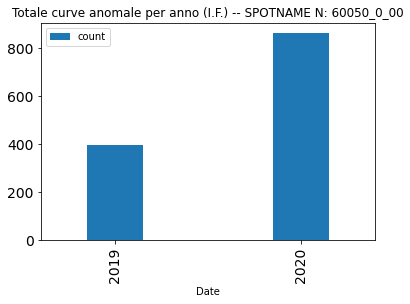

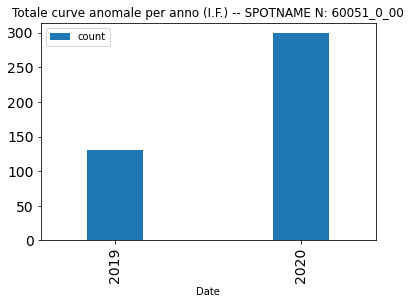

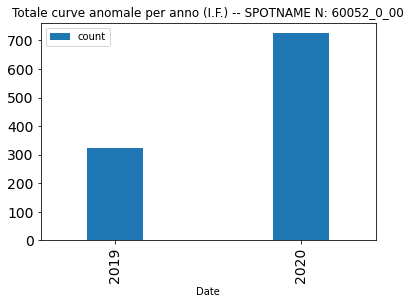

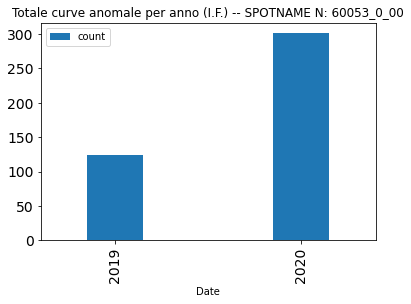

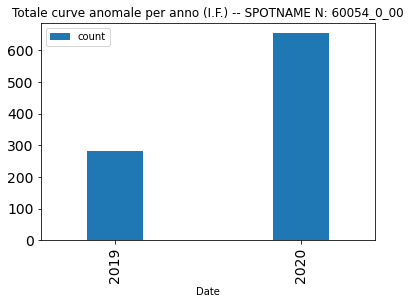

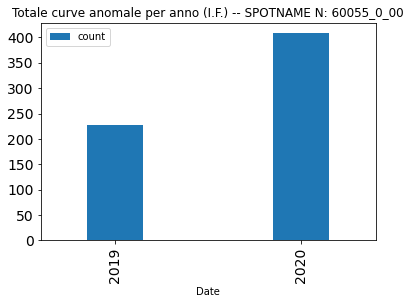

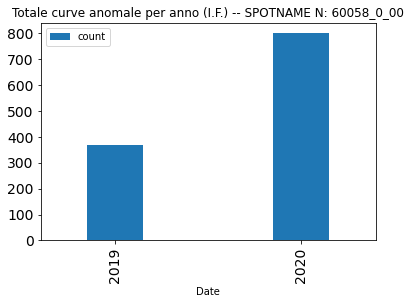

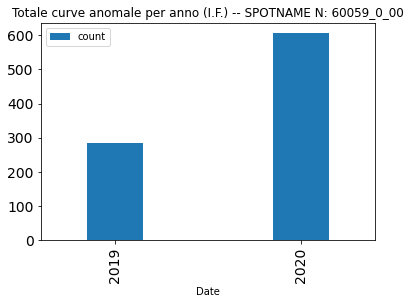

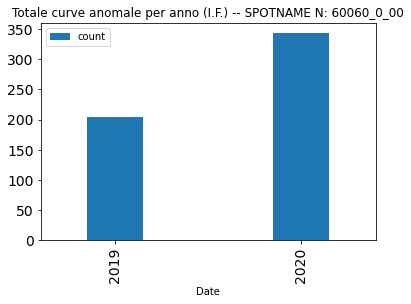

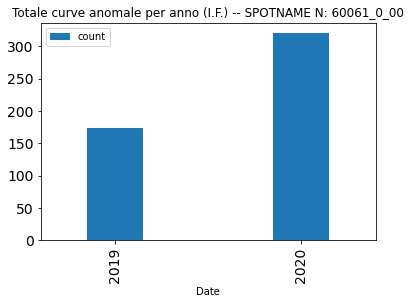

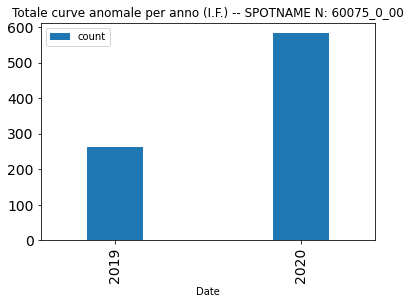

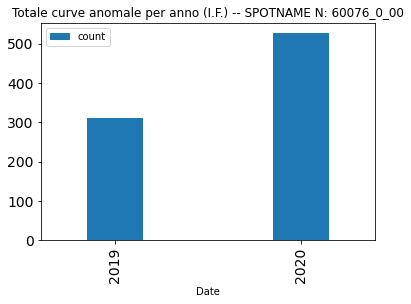

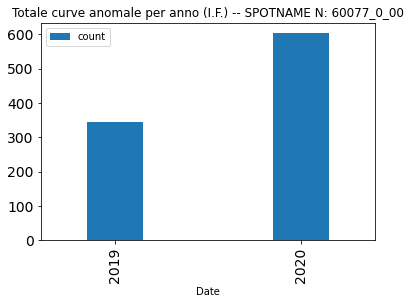

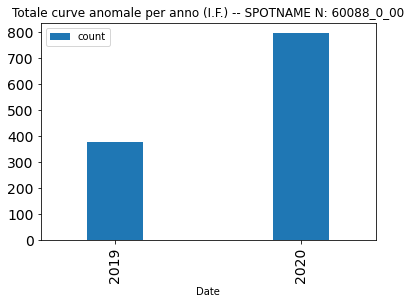

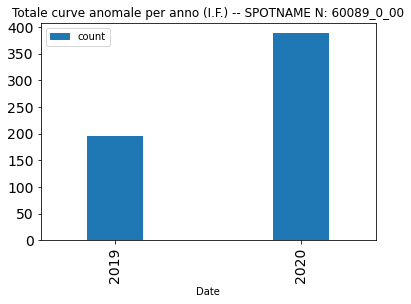

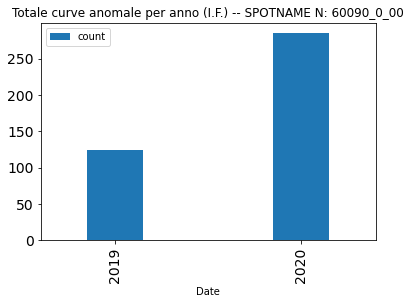

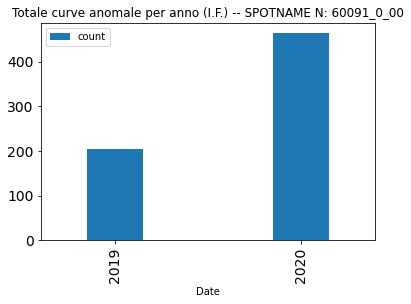

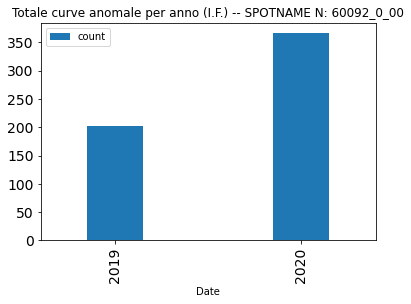

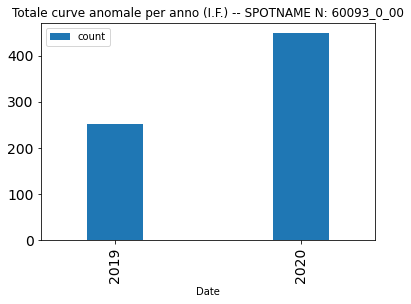

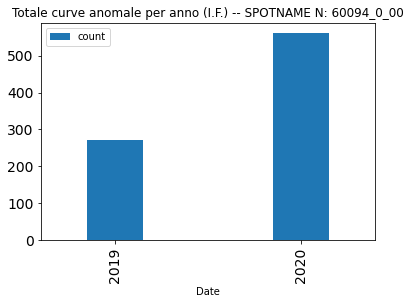

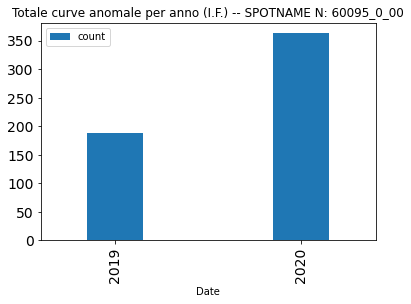

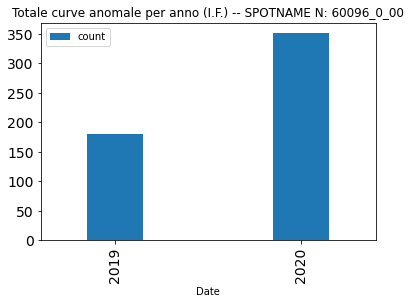

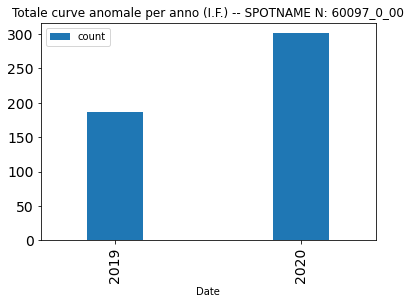

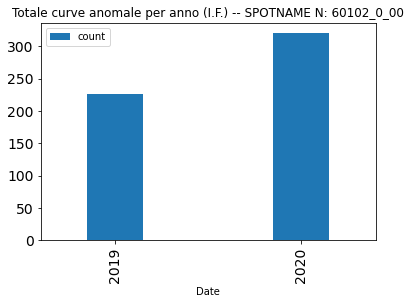

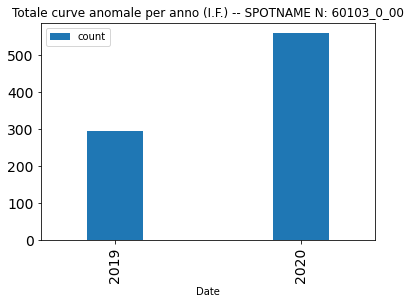

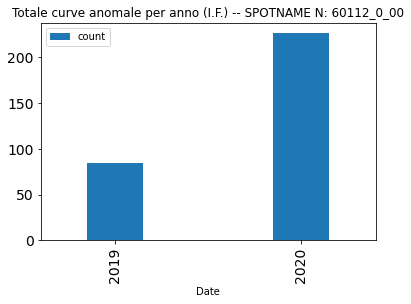

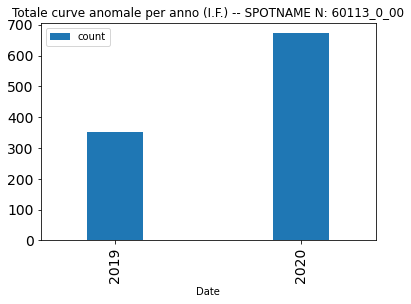

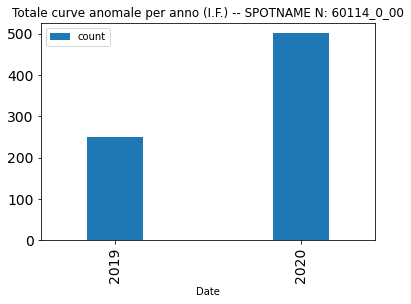

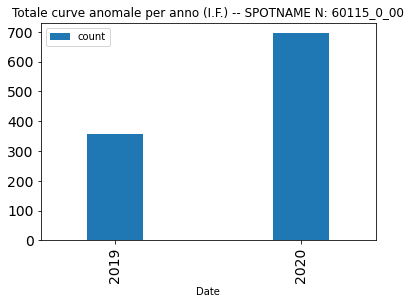

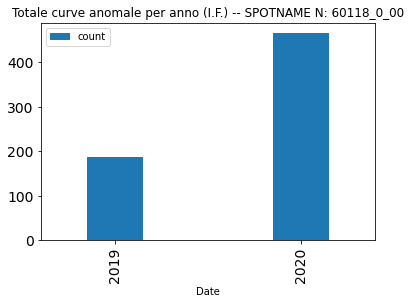

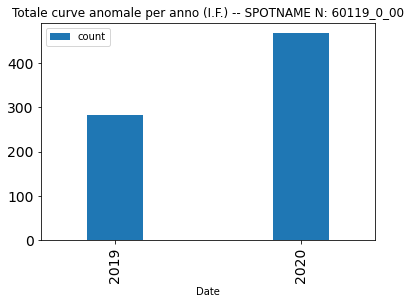

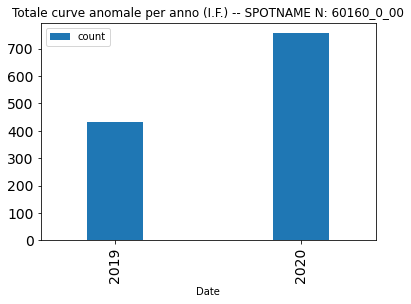

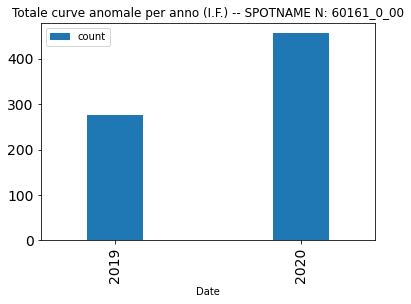

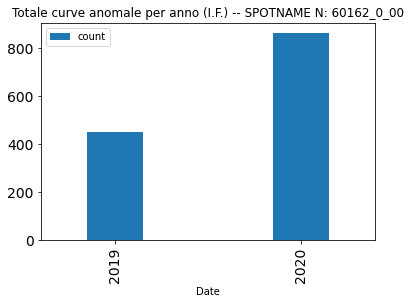

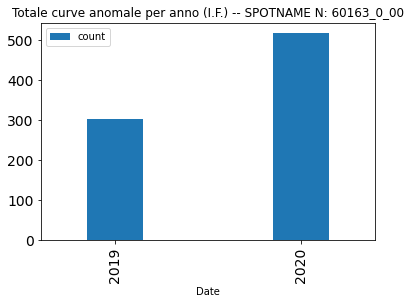

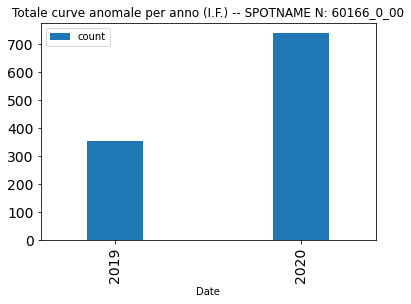

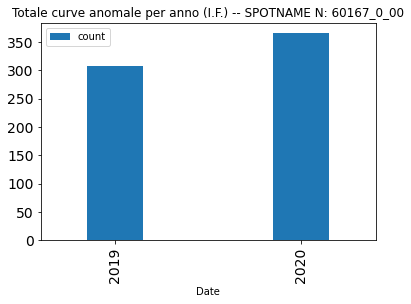

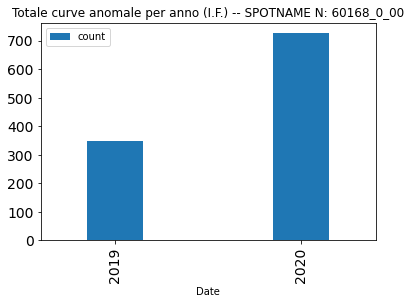

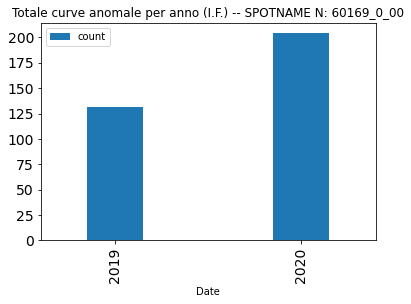

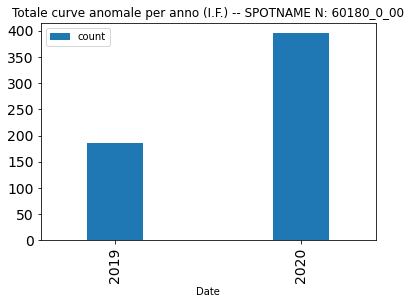

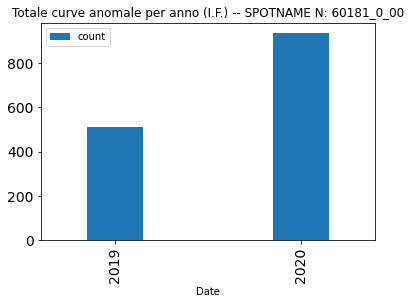

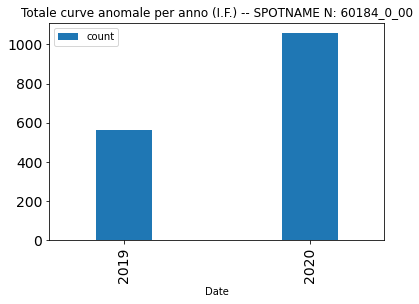

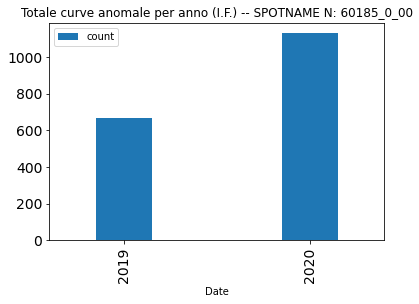

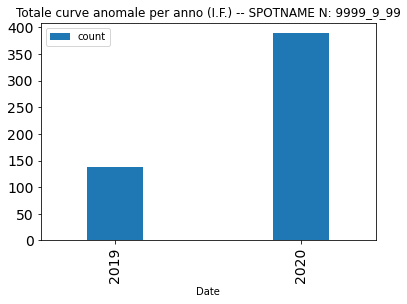

In [13]:
data = daily_analysis[daily_analysis.n_IF_anom > NOT_ANOM].groupby(['spotName', daily_analysis.Date.dt.year])['CurrentCurve'].agg(
    count='count').reset_index()
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]\
        .plot(title=f"Totale curve anomale per anno (I.F.) -- SPOTNAME N: {spotname}",
              x='Date', kind='bar', width=0.3, fontsize=14)

### Lunghezza media delle CC considerate anomale

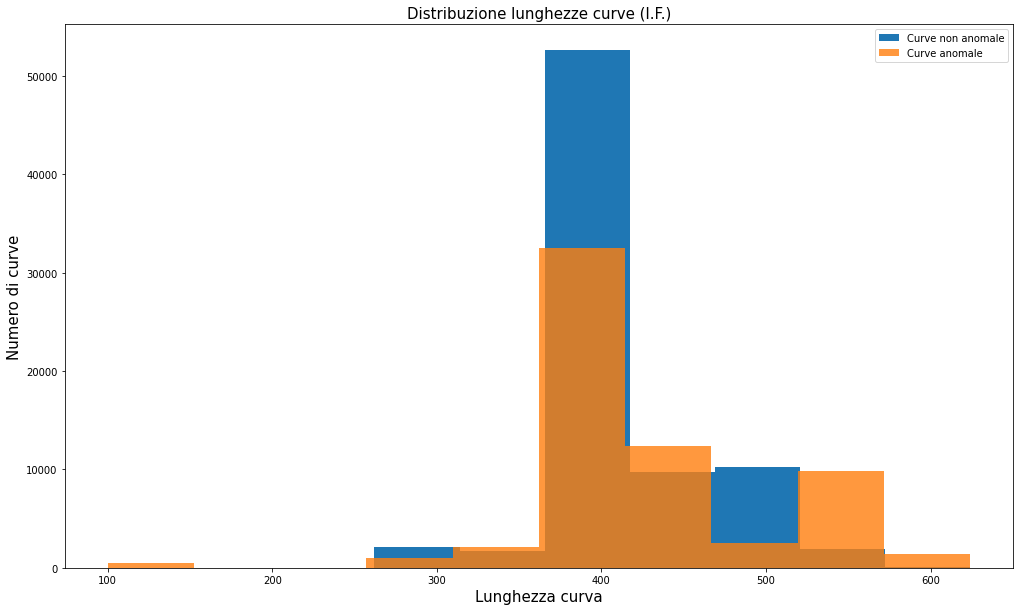

In [14]:
data_anom = daily_analysis[daily_analysis.n_IF_anom > NOT_ANOM]
data_not_anom = daily_analysis[daily_analysis.n_IF_anom <= NOT_ANOM]

distr_leng_anom = [len(curve) for curve in data_anom['CurrentCurve'].to_list()]
distr_leng_not_anom = [len(curve)
                       for curve in data_not_anom['CurrentCurve'].to_list()]

plt.figure(figsize=figsize)
plt.title("Distribuzione lunghezze curve (I.F.)", fontsize=15)
plt.hist(distr_leng_not_anom, label='Curve non anomale')
plt.hist(distr_leng_anom, alpha=0.8, label='Curve anomale')
plt.ylabel("Numero di curve", fontsize=15)
plt.xlabel("Lunghezza curva", fontsize=15)
plt.legend(loc='upper right')
plt.show()

# Analisi descrittive anomalie su serie giornaliere (DBSCAN)

### Tot. serie anomalie per spotname

<AxesSubplot:title={'center':'Tot. serie anomale per spotname (DBSCAN)'}, xlabel='spotName'>

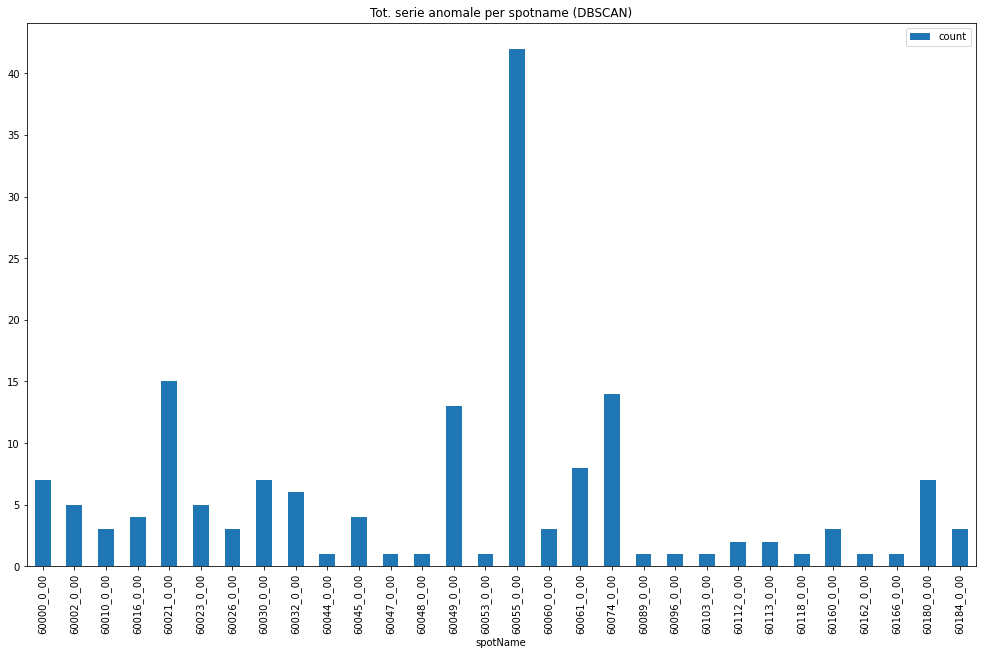

In [15]:
daily_analysis[daily_analysis.dbscan_daily == -1].groupby(['spotName'])['CurrentCurve'].agg(
    count='count').plot.bar(title="Tot. serie anomale per spotname (DBSCAN)", figsize=figsize)

### Per spotname, andamento anomalie nel tempo

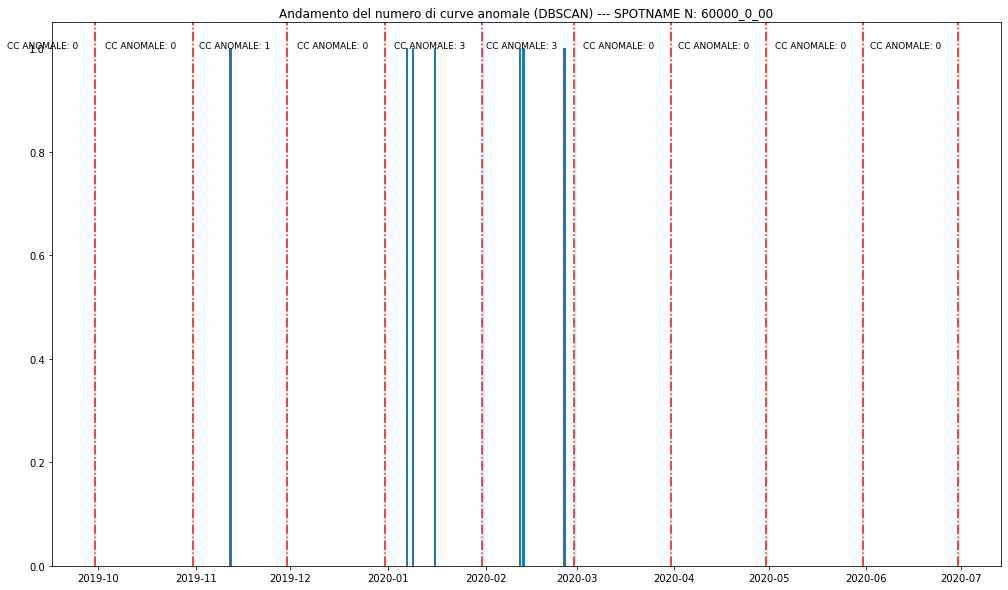

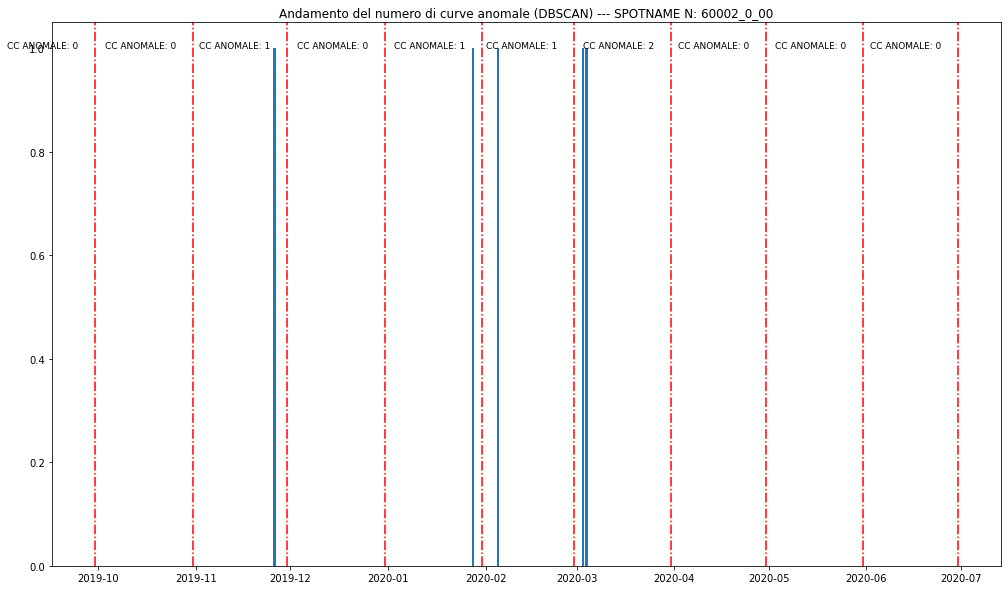

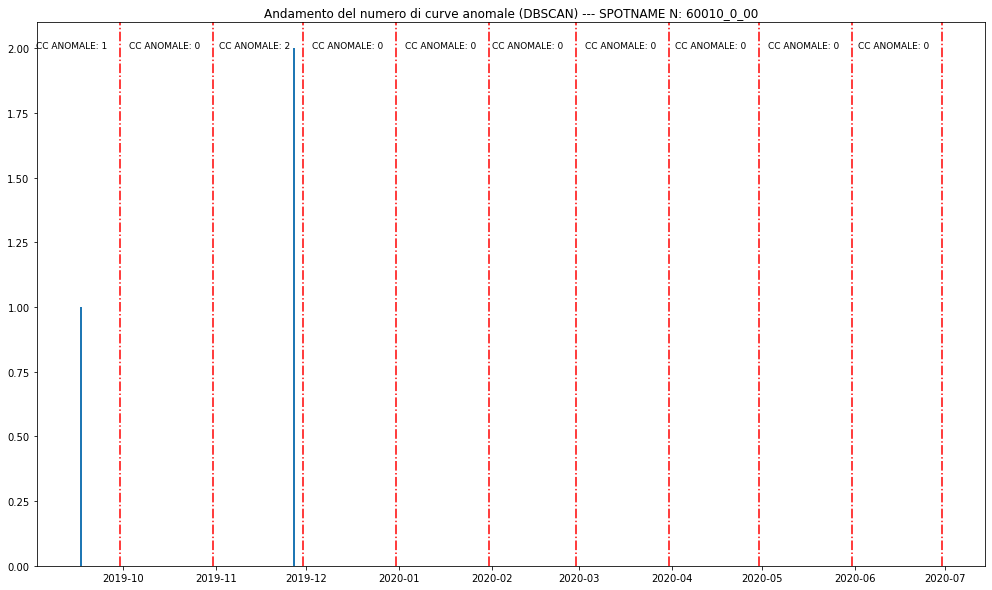

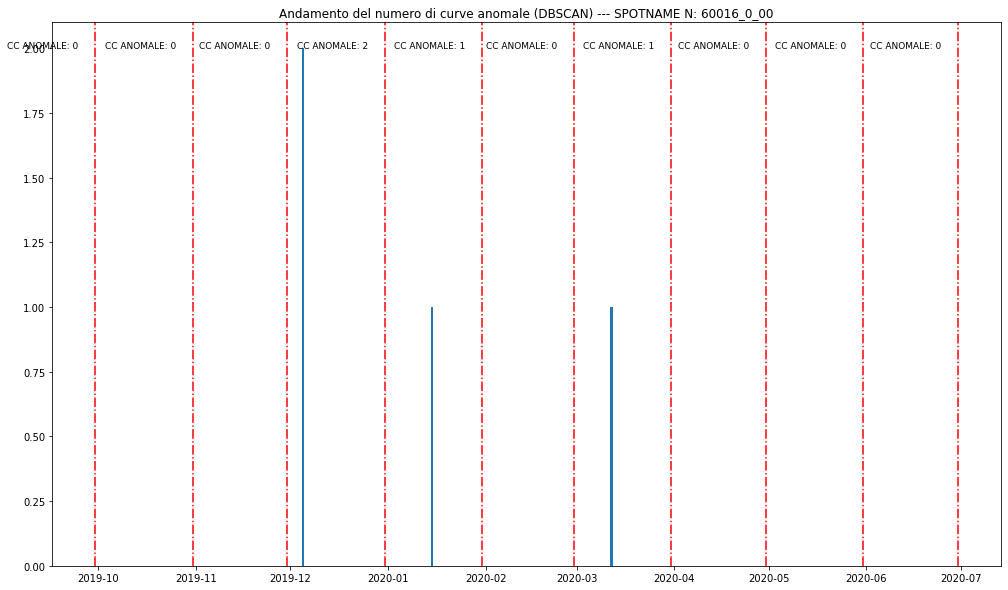

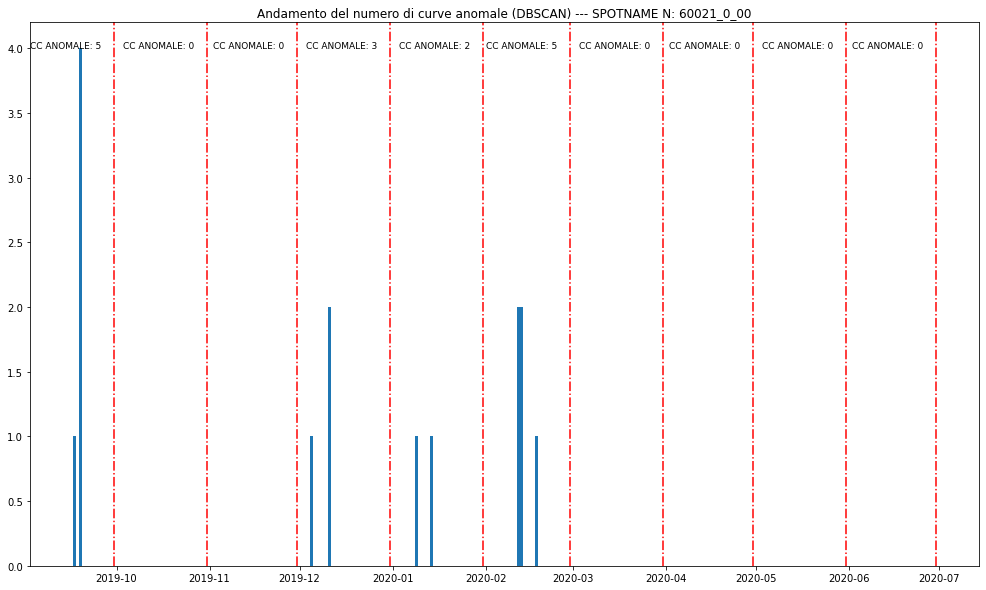

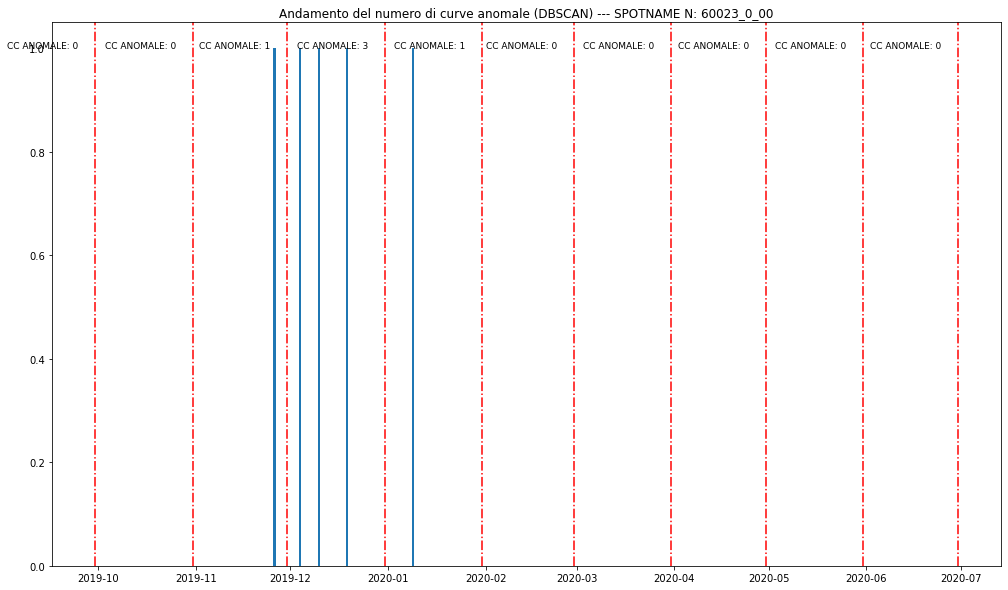

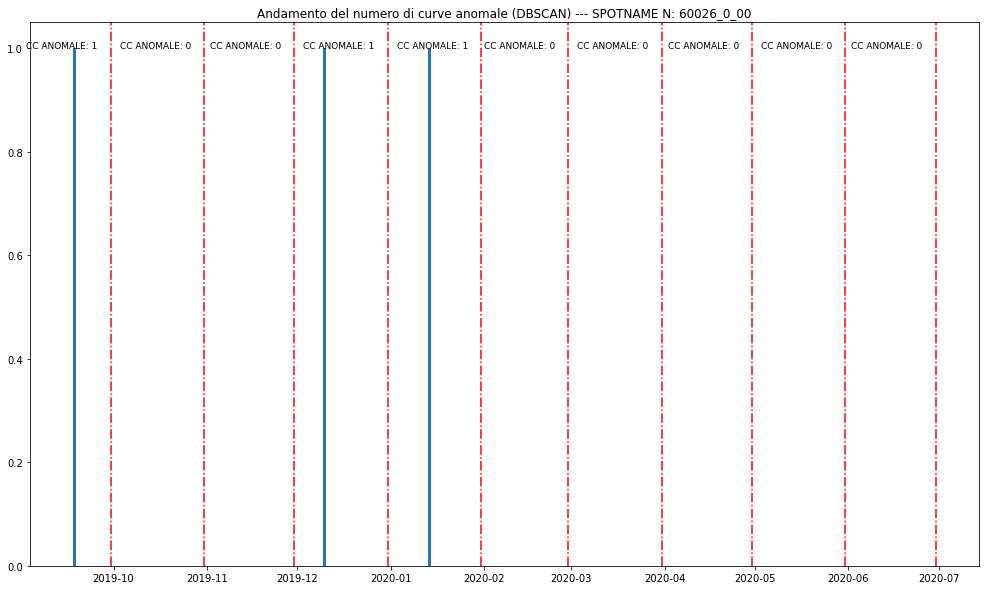

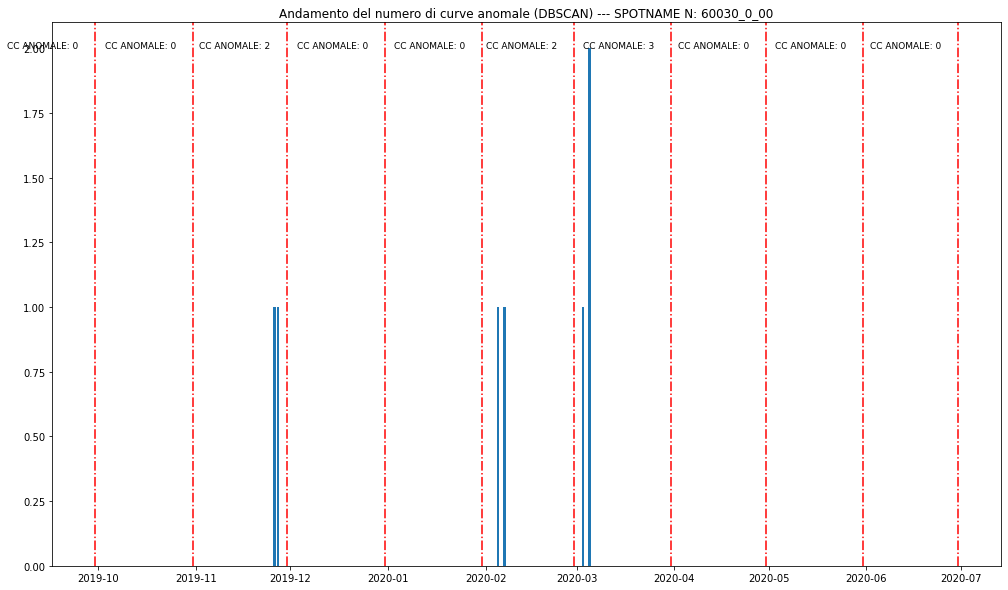

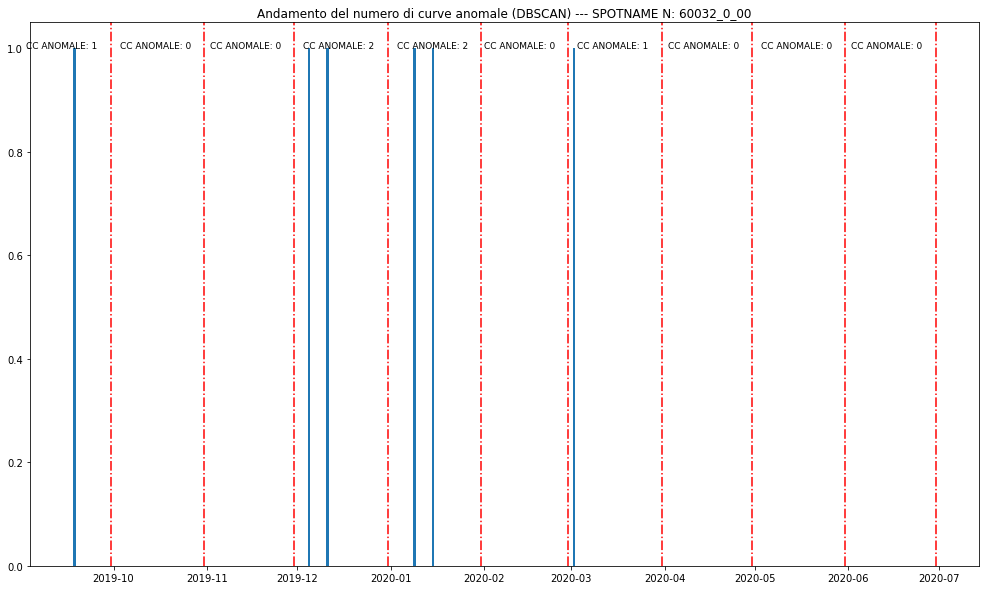

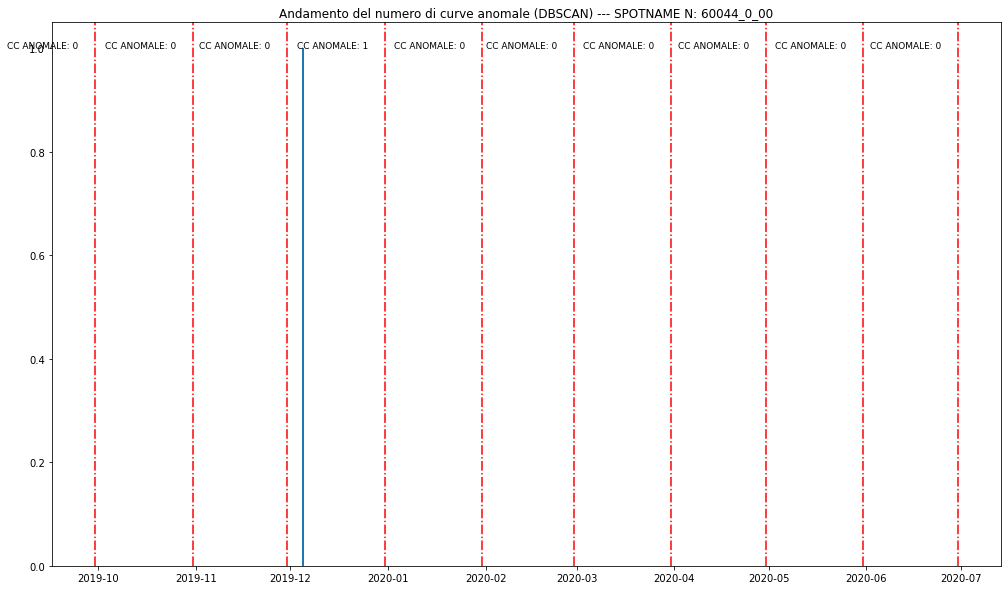

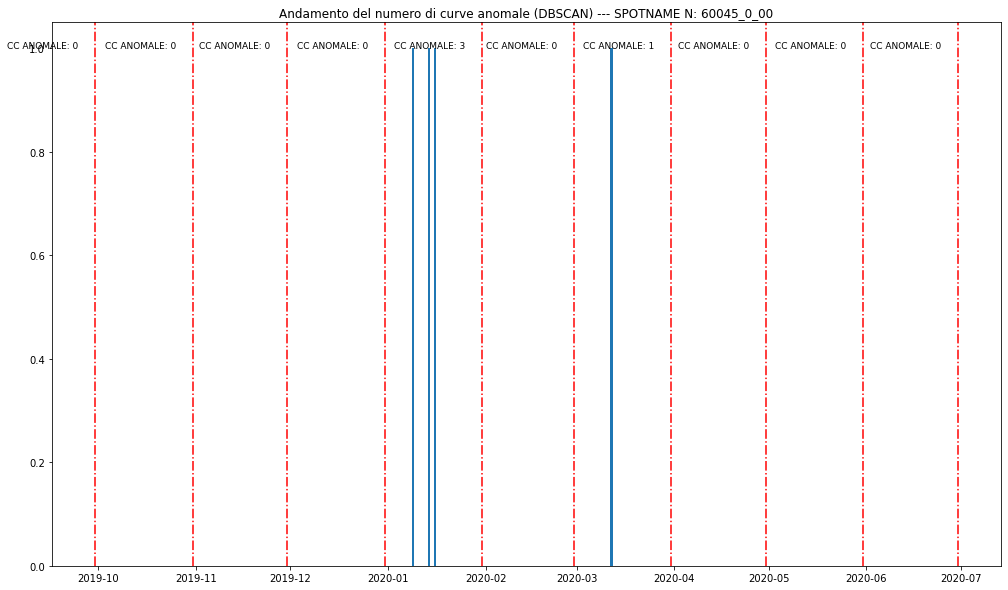

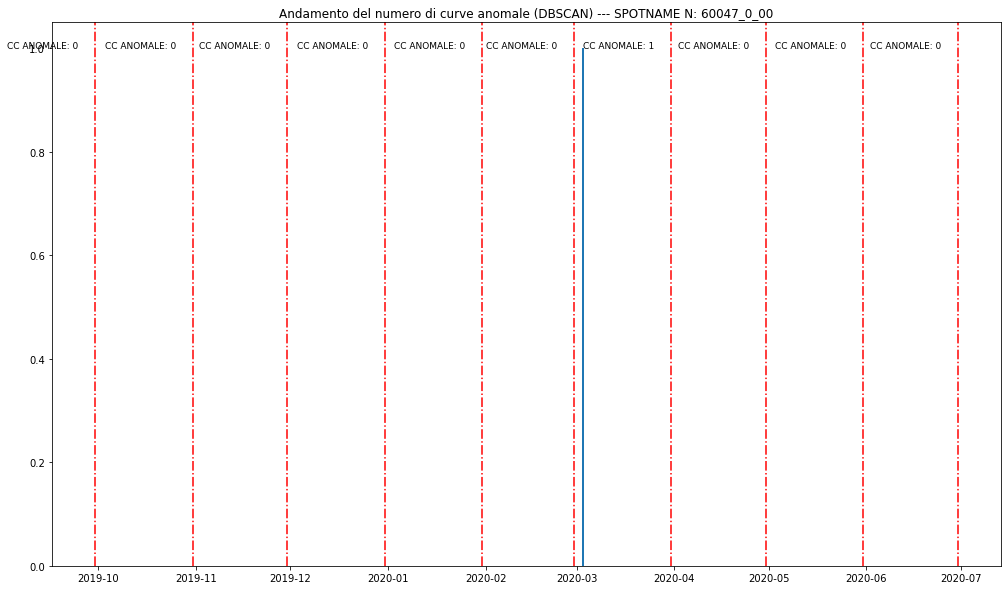

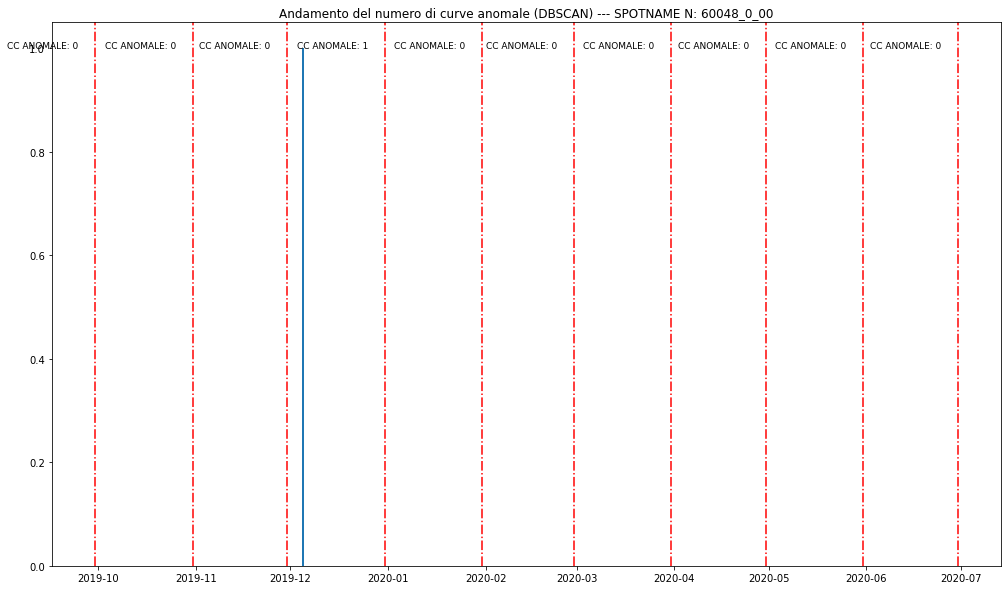

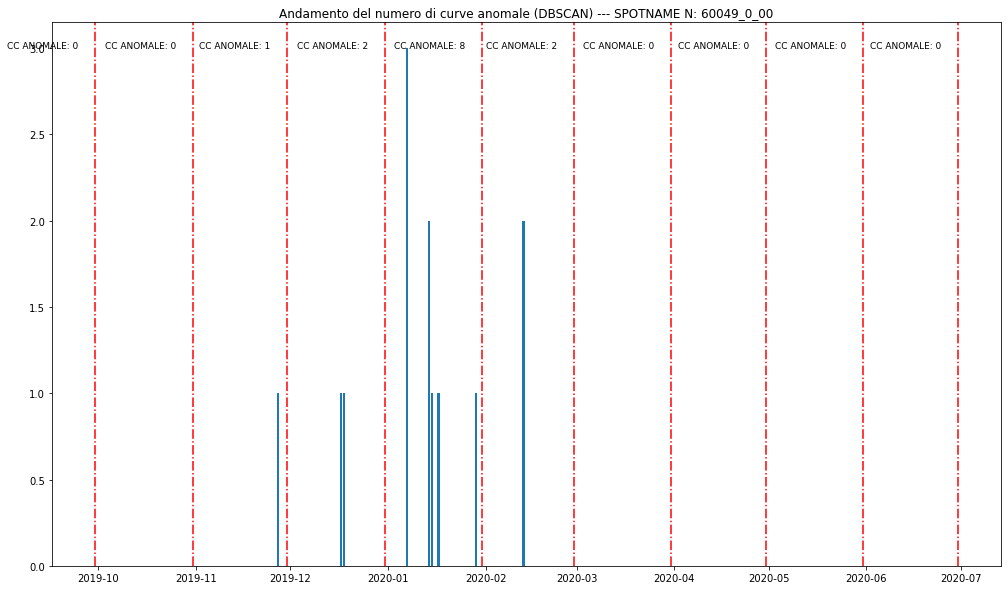

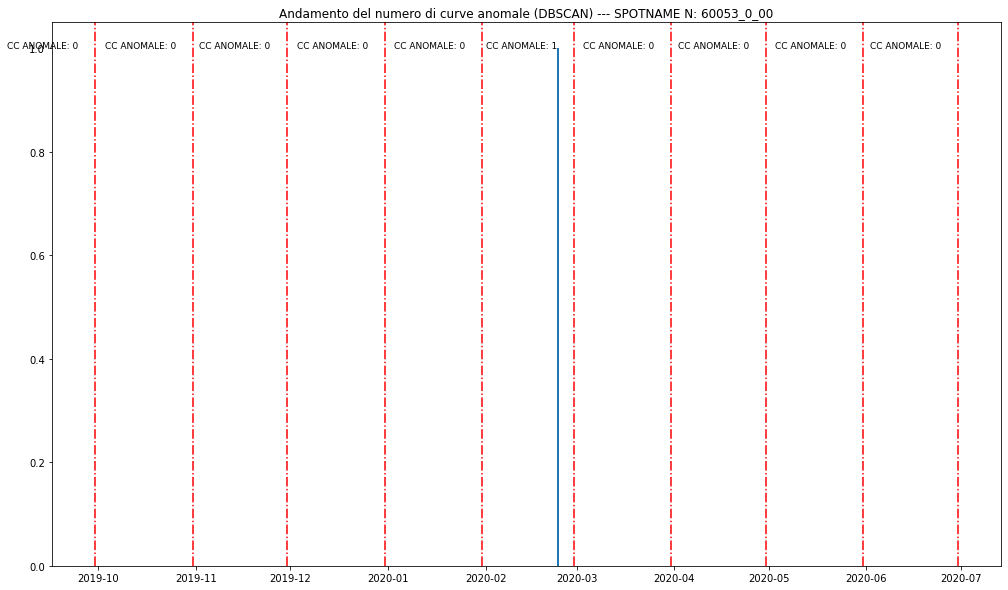

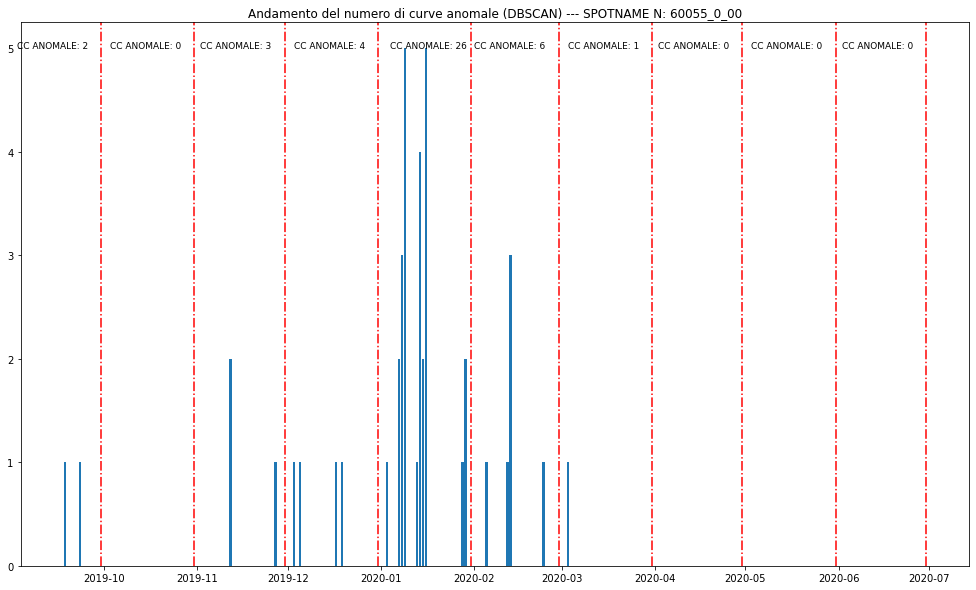

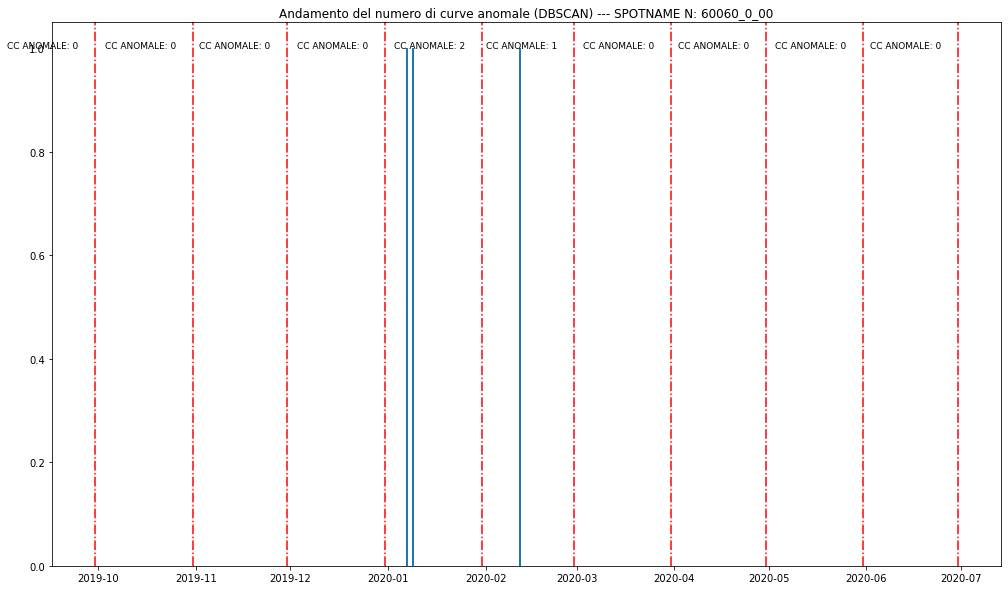

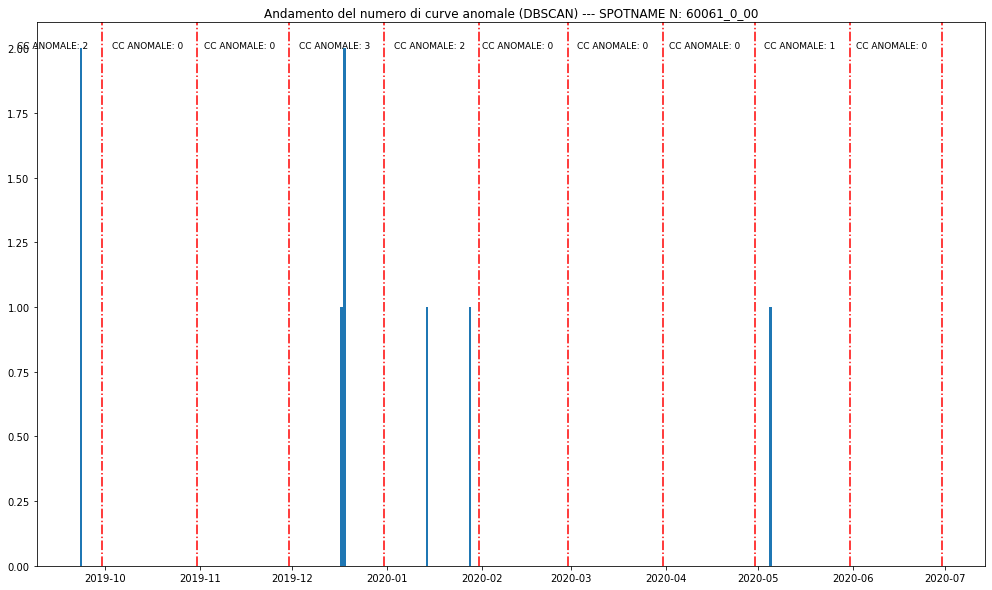

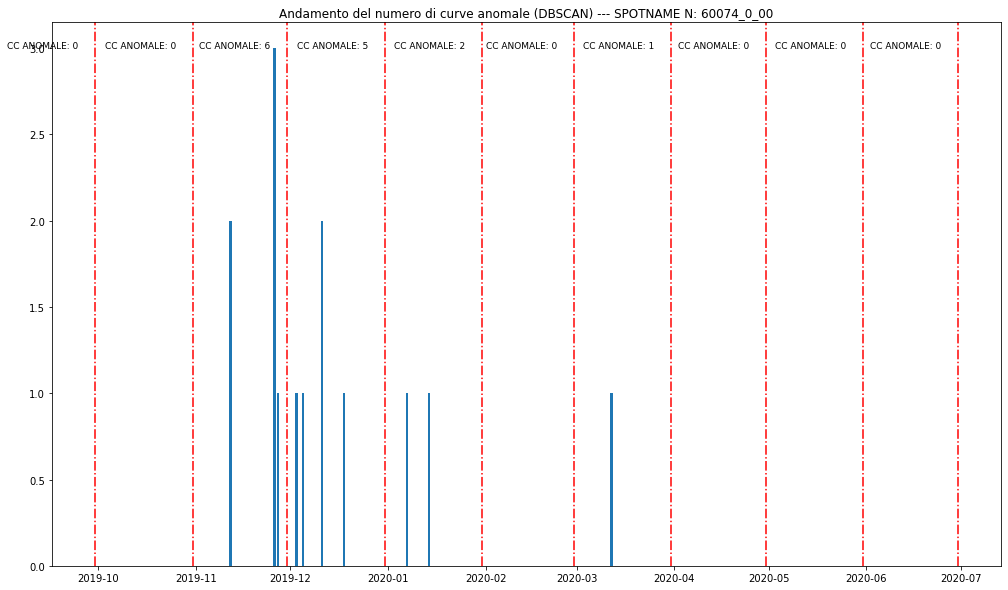

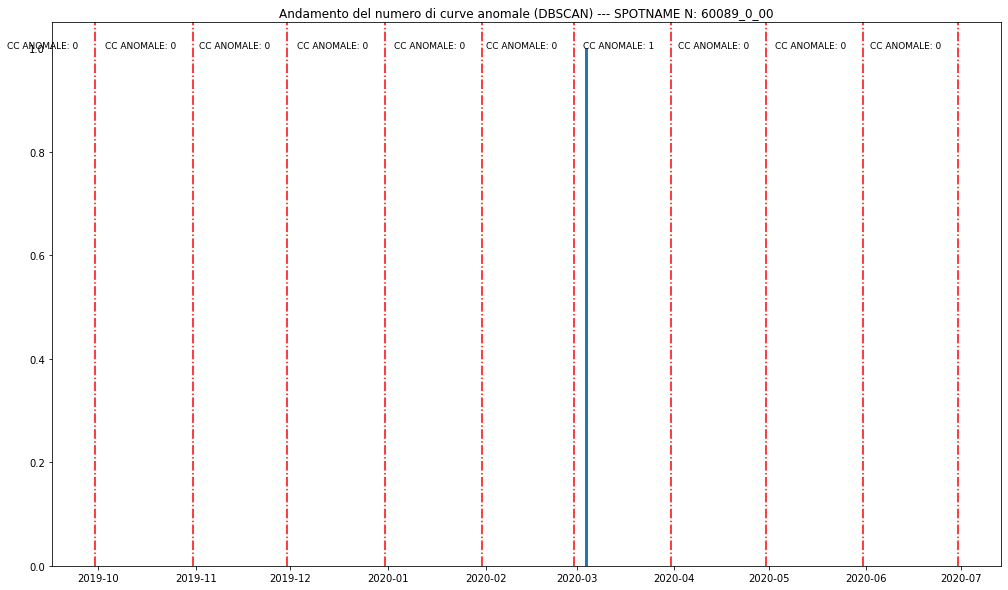

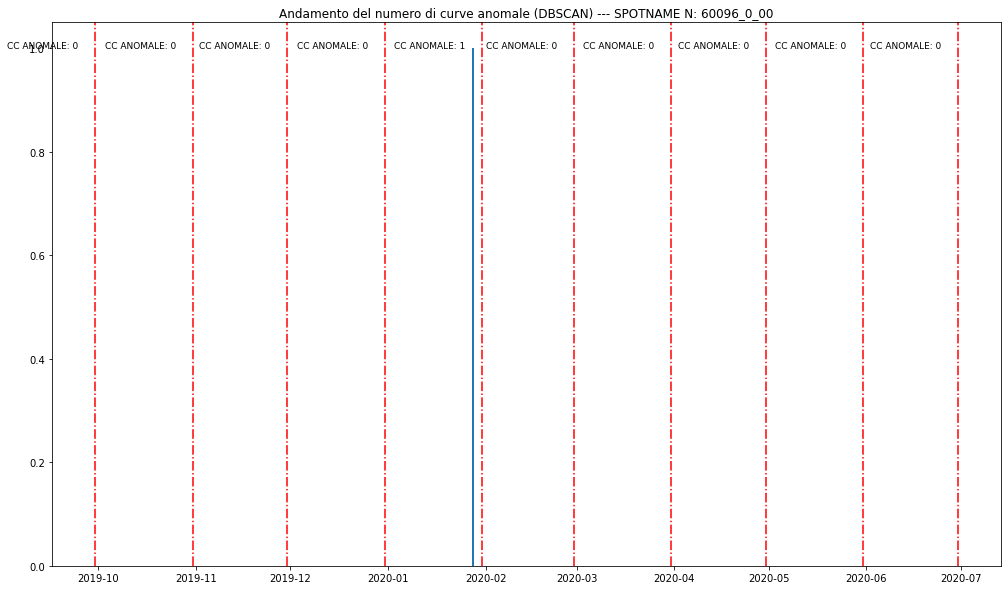

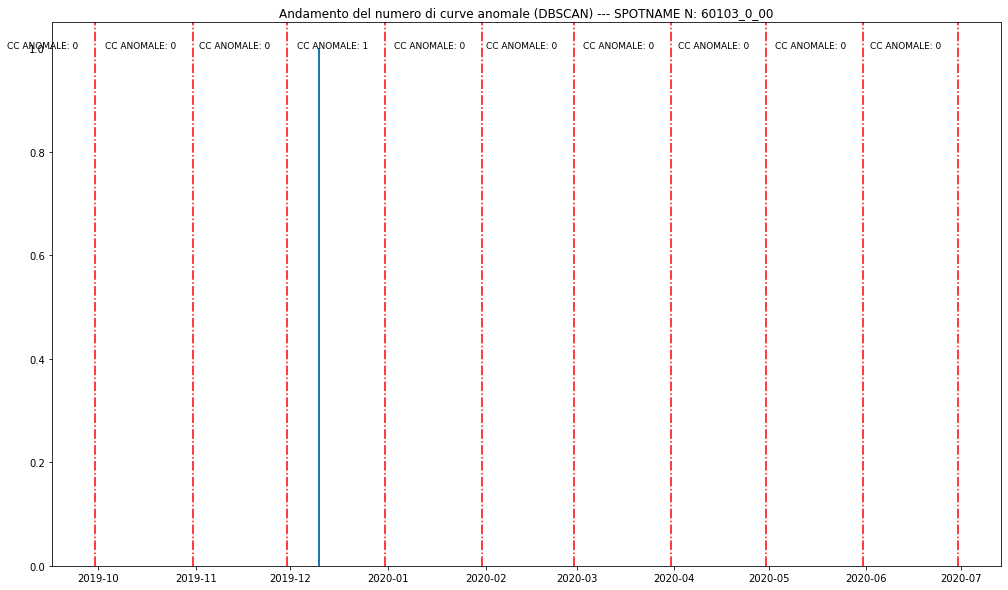

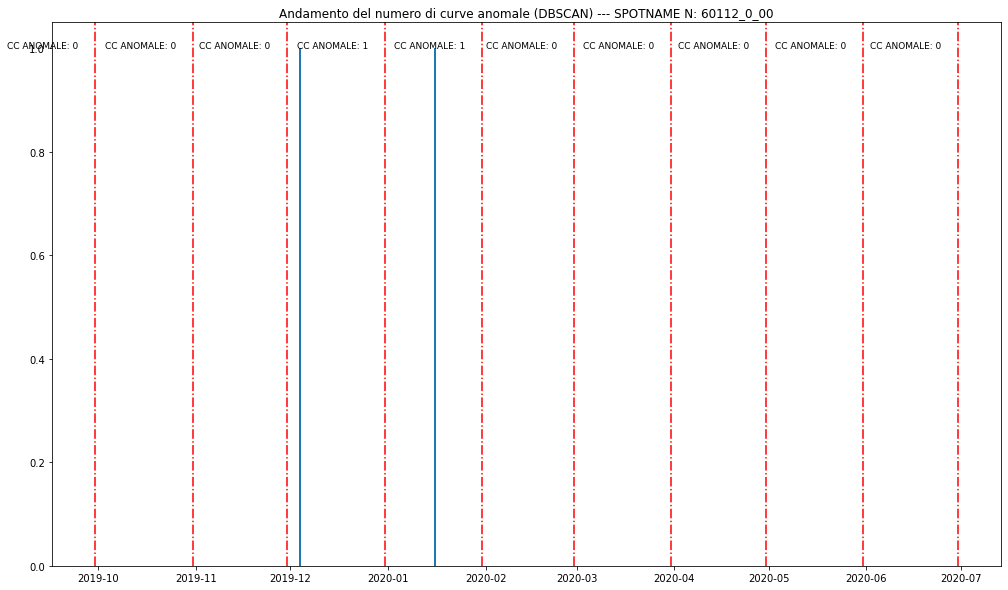

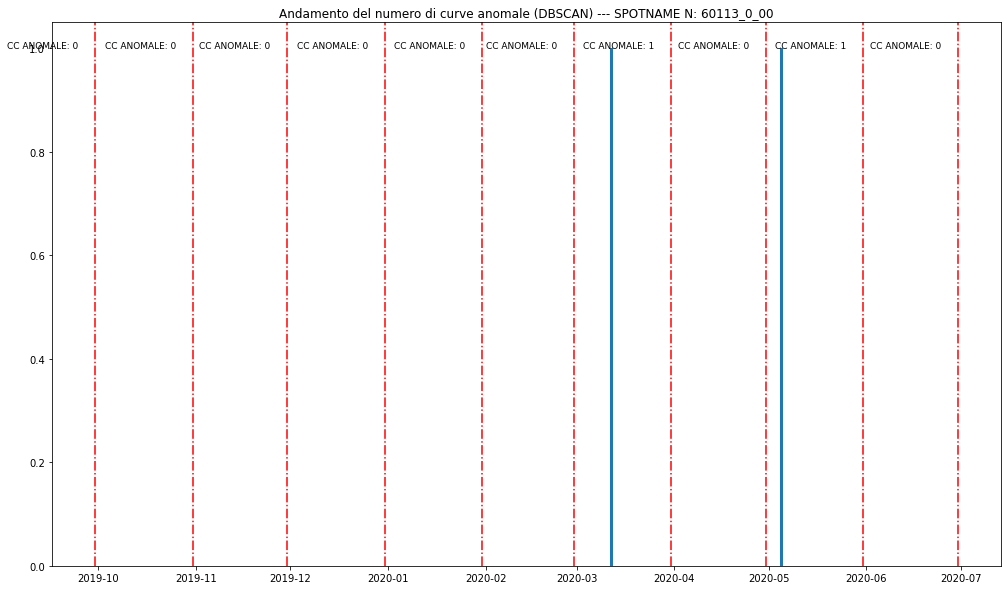

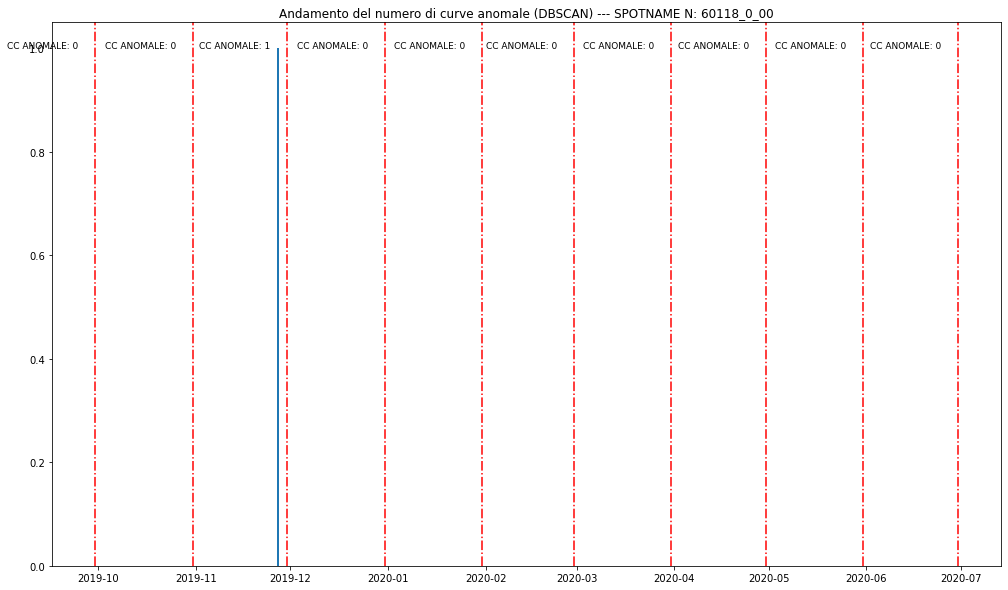

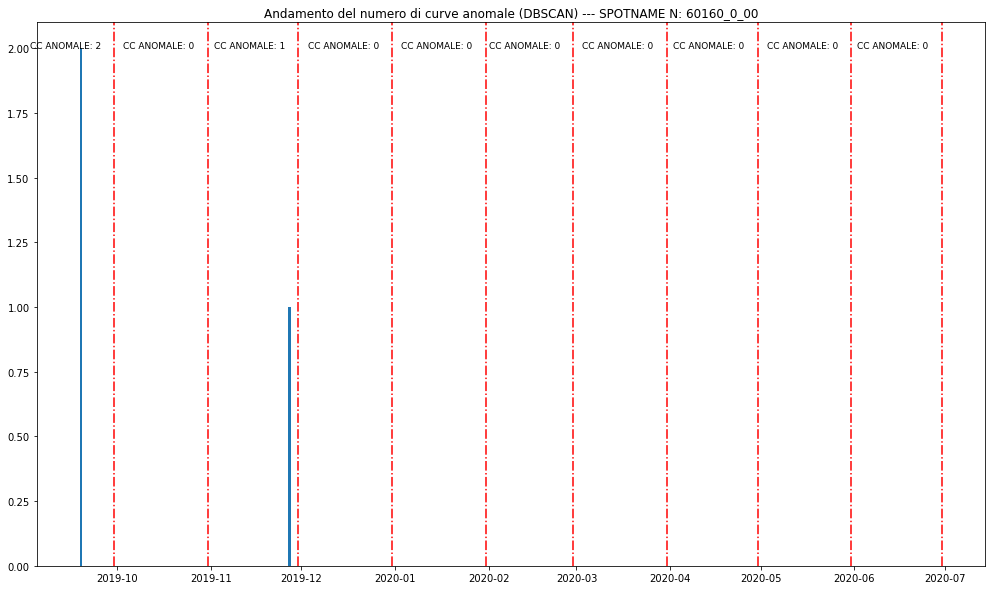

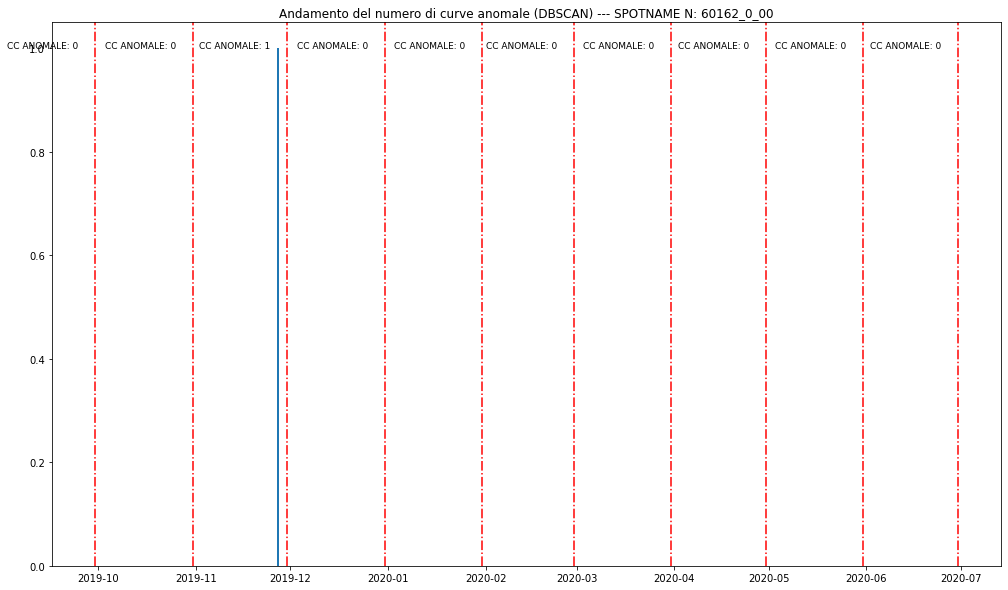

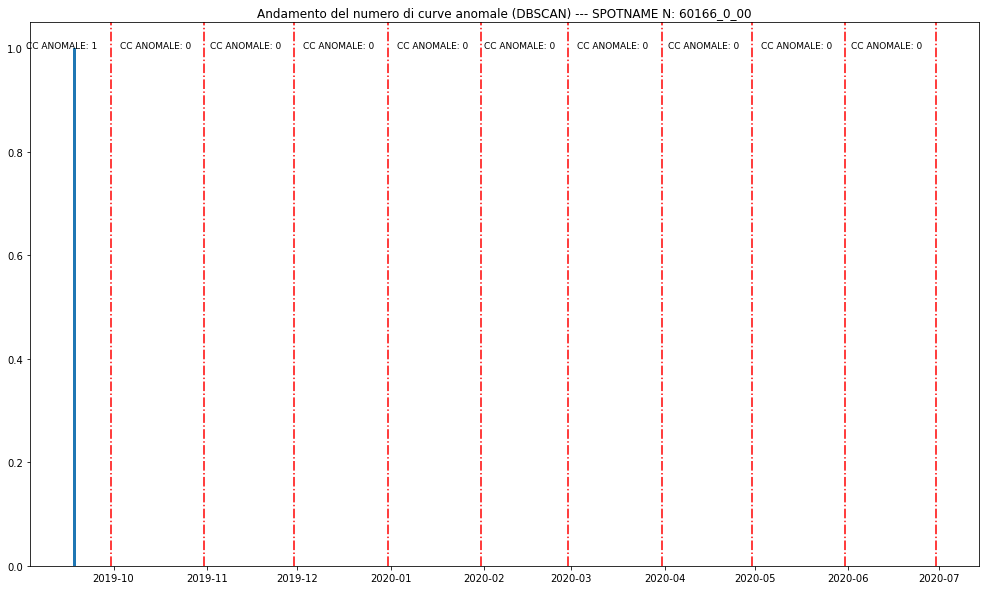

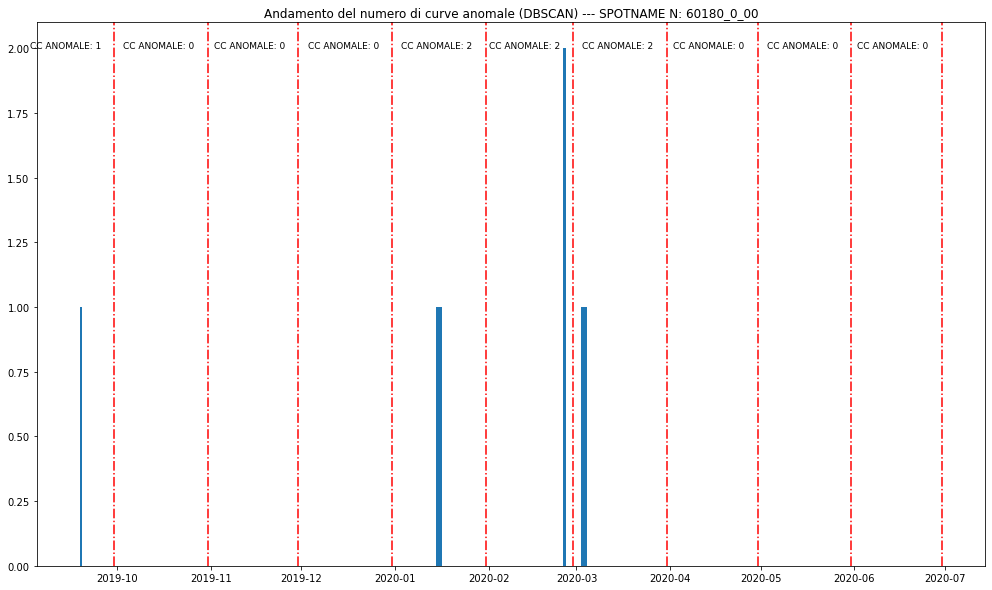

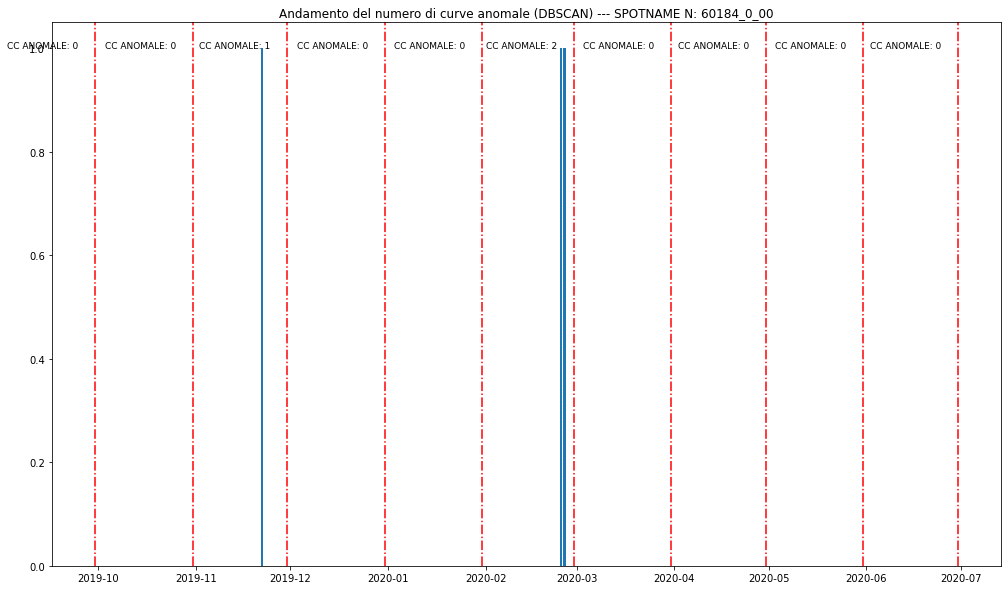

In [16]:
data = daily_analysis[daily_analysis.dbscan_daily == -1].groupby(['spotName', 'Date'])['CurrentCurve'].agg(
    count='count').reset_index()
list_date = pd.date_range(pd.to_datetime(
    '2019-09-01'), pd.to_datetime('2020-06-30'), freq='1M')
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]
    plt.figure(figsize=figsize)
    plt.title(
        f"Andamento del numero di curve anomale (DBSCAN) --- SPOTNAME N: {spotname}")
    # visualizziamo delle linee verticali per ogni mese
    for date in list_date:
        # plot linea per ogni mese
        plt.axvline(date, linestyle='-.', color='r')
        # numero di giorni da cui iniziare a plottare il testo
        left_shift = 24
        month = date.month
        year = date.year
        # totale numero cc anomale per rispettivo anno e mese
        tot_anom = sum(temp_ds[(temp_ds.Date.dt.year == year) & (
            temp_ds.Date.dt.month == month)]['count'])
        # sposto testo a sx in base al numero di cifre -> riduco errori grafici
        if tot_anom > 99 or tot_anom < 10:
            left_shift = 28
        if 10 <= tot_anom <= 99:
            left_shift = 27
        # scrivo il testo ogni mese - tot giorni, in modo da accentrarlo per ogni mese
        text = f"CC ANOMALE: {tot_anom}"
        plt.text(date - dt.timedelta(days=left_shift),
                 max(temp_ds['count']), text, fontsize=9)

    plt.bar(temp_ds.Date, temp_ds['count'])
    plt.show()

### Per ogni spotname, tot. anomalie per anno

In media nel 2020 sembra che ci sia stato un incremento del numero delle curve anomale indipendentemente dallo spotname.

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


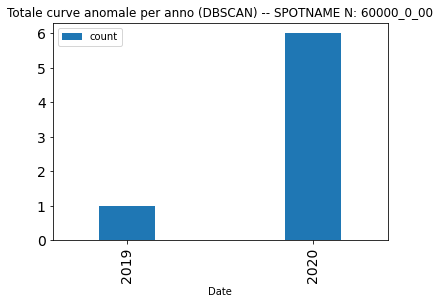

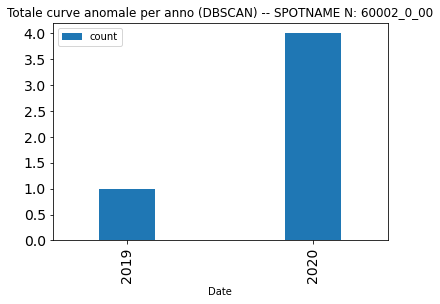

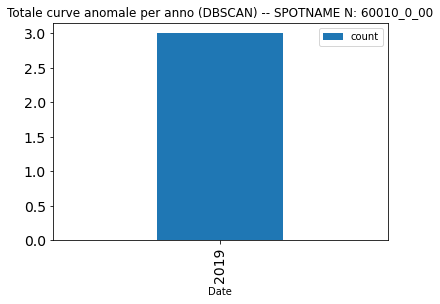

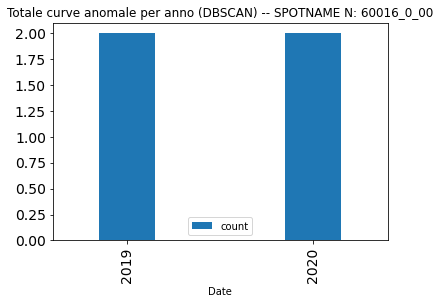

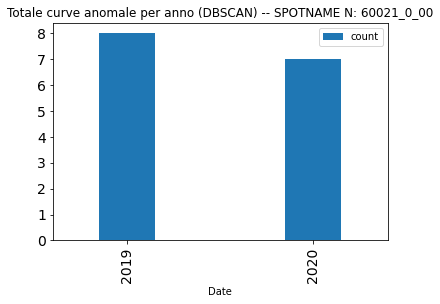

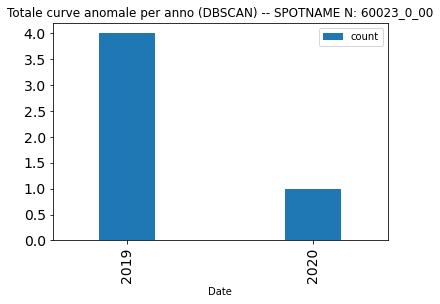

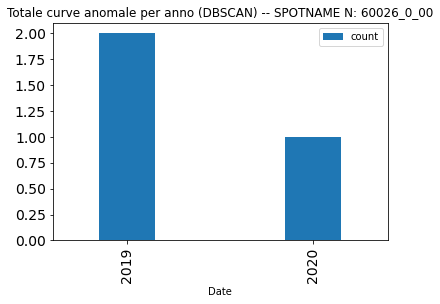

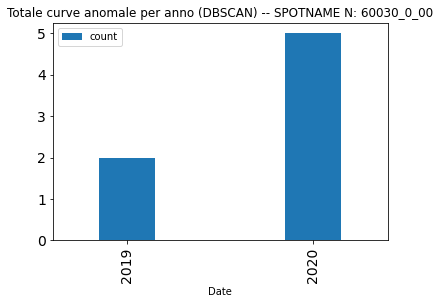

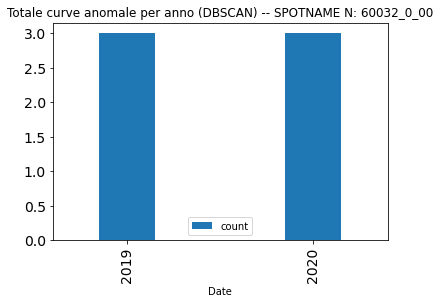

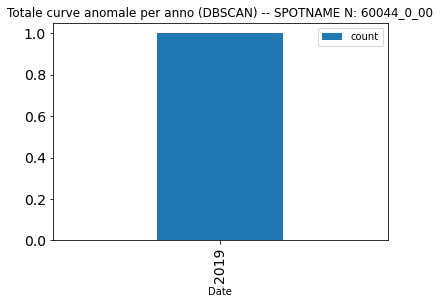

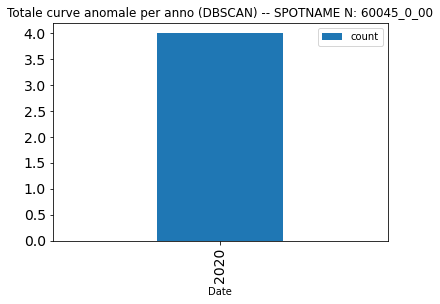

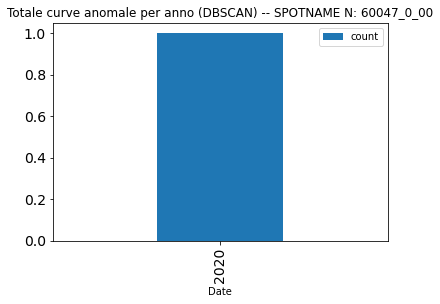

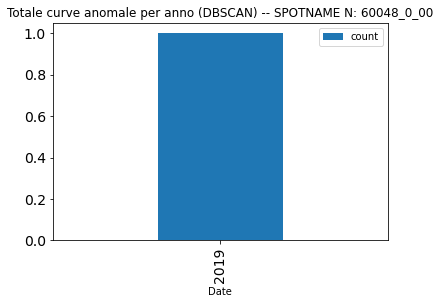

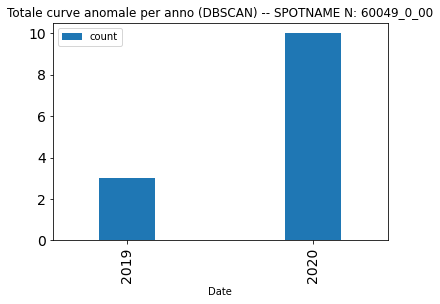

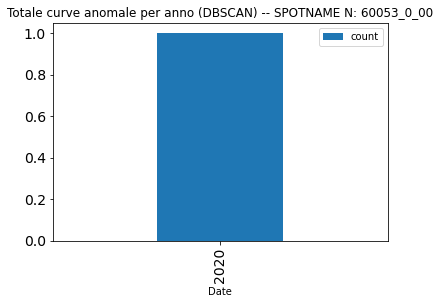

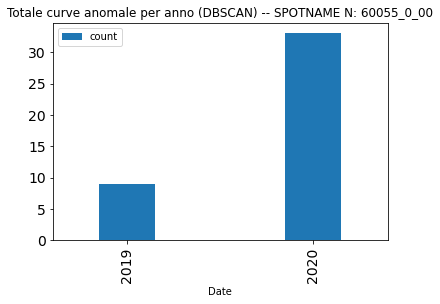

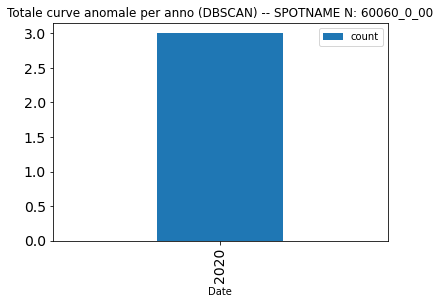

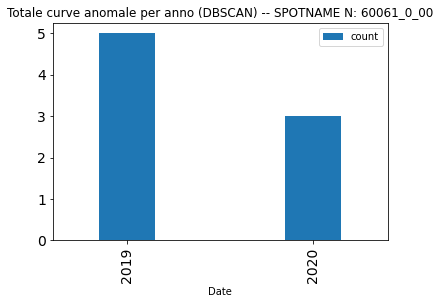

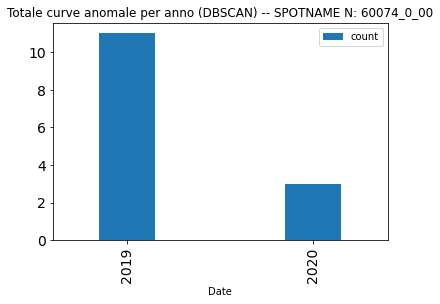

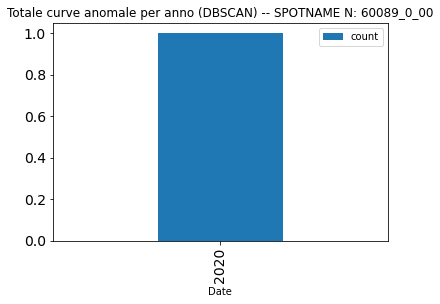

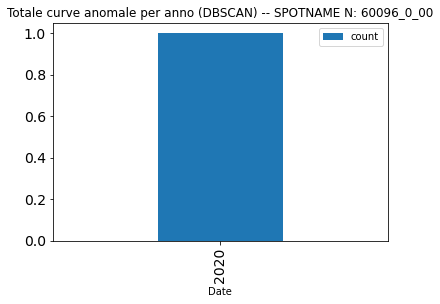

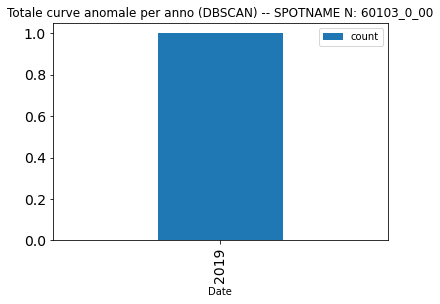

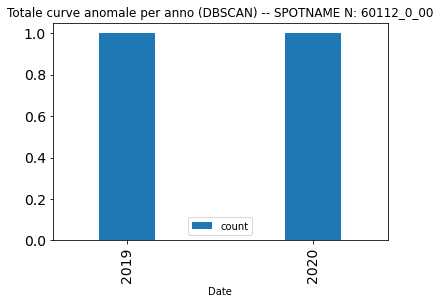

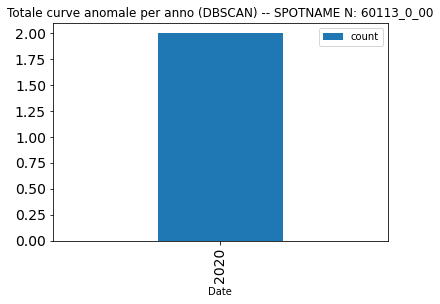

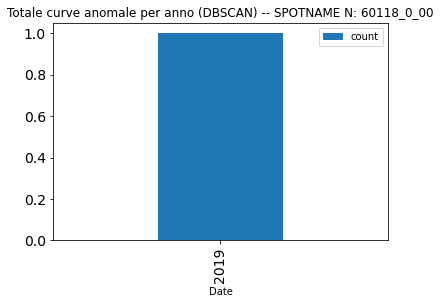

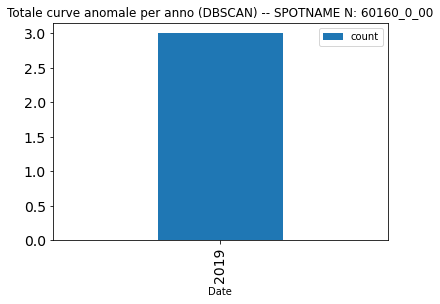

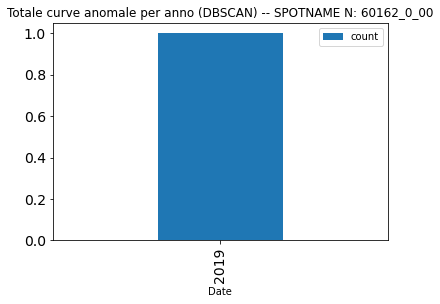

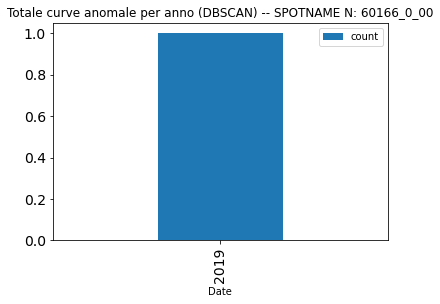

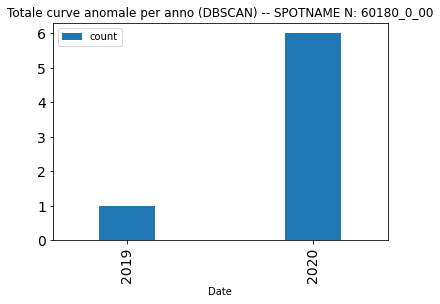

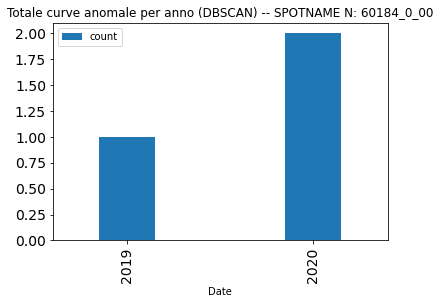

In [17]:
data = daily_analysis[daily_analysis.dbscan_daily == -1].groupby(['spotName', daily_analysis.Date.dt.year])['CurrentCurve'].agg(
    count='count').reset_index()
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]\
        .plot(title=f"Totale curve anomale per anno (DBSCAN) -- SPOTNAME N: {spotname}",
              x='Date', kind='bar', width=0.3, fontsize=14)

### Lunghezza media delle CC considerate anomale

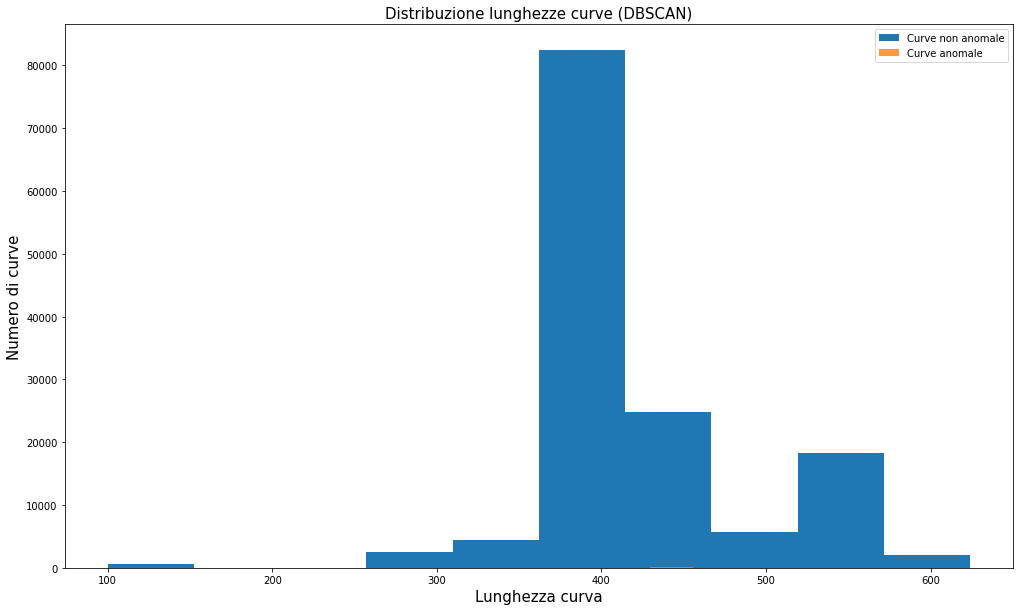

In [18]:
data_anom = daily_analysis[daily_analysis.dbscan_daily == -1]
data_not_anom = daily_analysis[daily_analysis.dbscan_daily == 0]

distr_leng_anom = [len(curve) for curve in data_anom['CurrentCurve'].to_list()]
distr_leng_not_anom = [len(curve)
                       for curve in data_not_anom['CurrentCurve'].to_list()]

plt.figure(figsize=figsize)
plt.title("Distribuzione lunghezze curve (DBSCAN)", fontsize=15)
plt.hist(distr_leng_not_anom, label='Curve non anomale')
plt.hist(distr_leng_anom, alpha=0.8, label='Curve anomale')
plt.ylabel("Numero di curve", fontsize=15)
plt.xlabel("Lunghezza curva", fontsize=15)
plt.legend(loc='upper right')
plt.show()

# Analisi descrittive anomalie su serie giornaliere (CONFIDENCE INTERVAL)

### Tot. serie anomalie per spotname

<AxesSubplot:title={'center':'Tot. serie anomale per spotname (C.I.)'}, xlabel='spotName'>

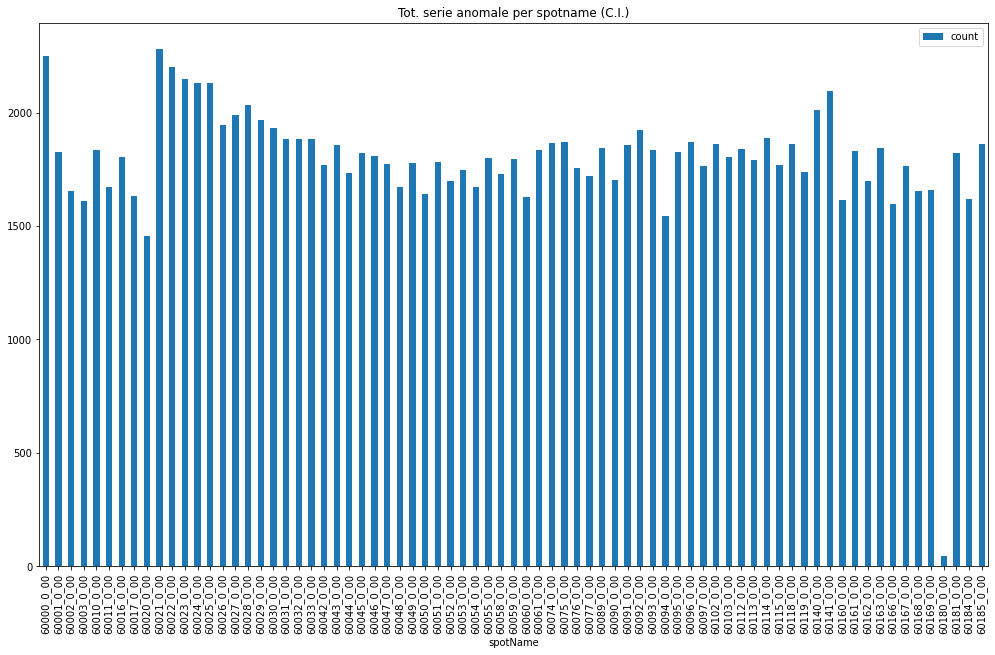

In [19]:
daily_analysis[daily_analysis.n_CI_anom > NOT_ANOM_CI].groupby(['spotName'])['CurrentCurve'].agg(
    count='count').plot.bar(title="Tot. serie anomale per spotname (C.I.)", figsize=figsize)

### Per spotname, andamento anomalie nel tempo

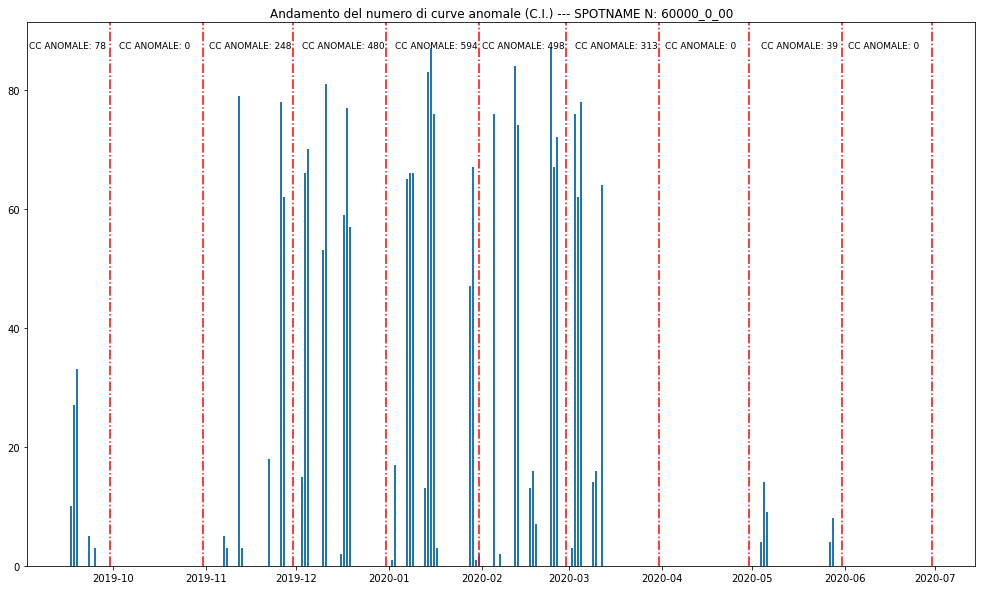

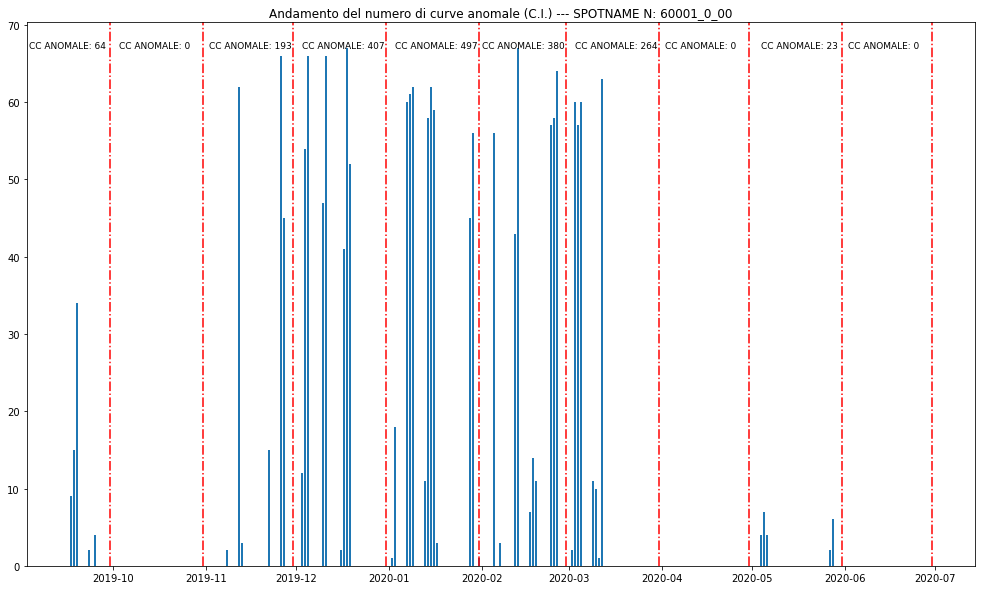

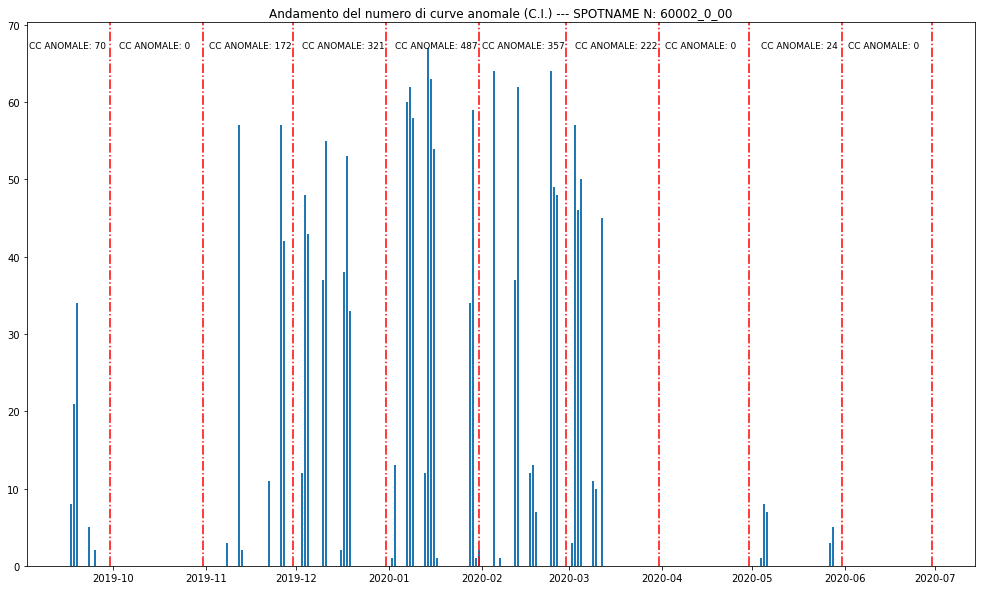

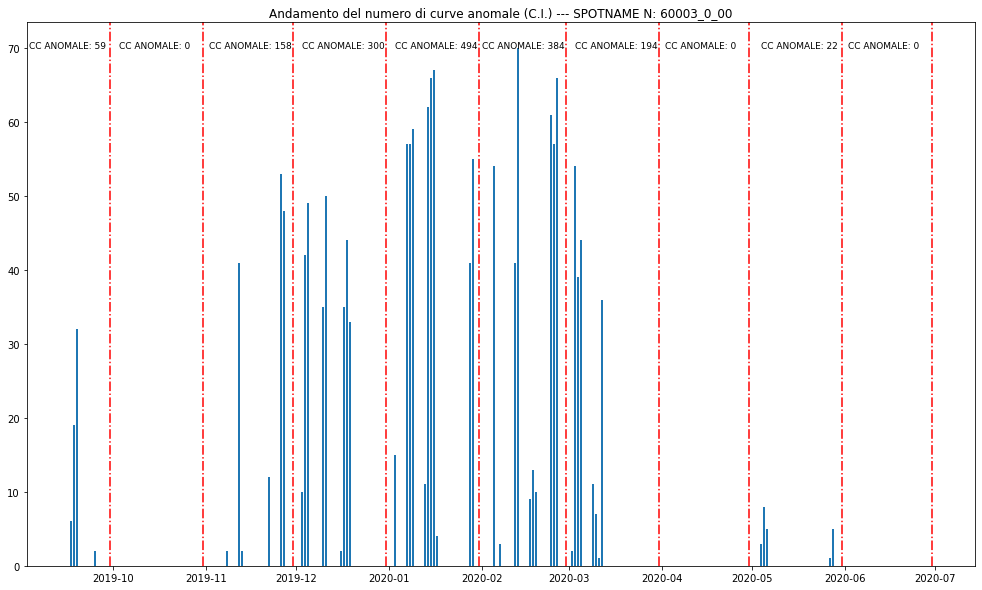

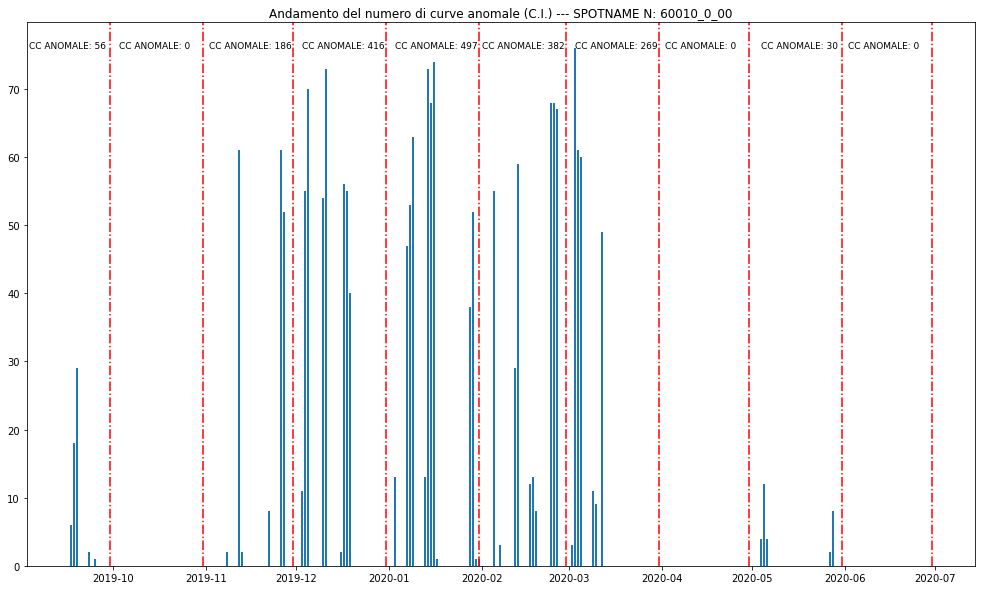

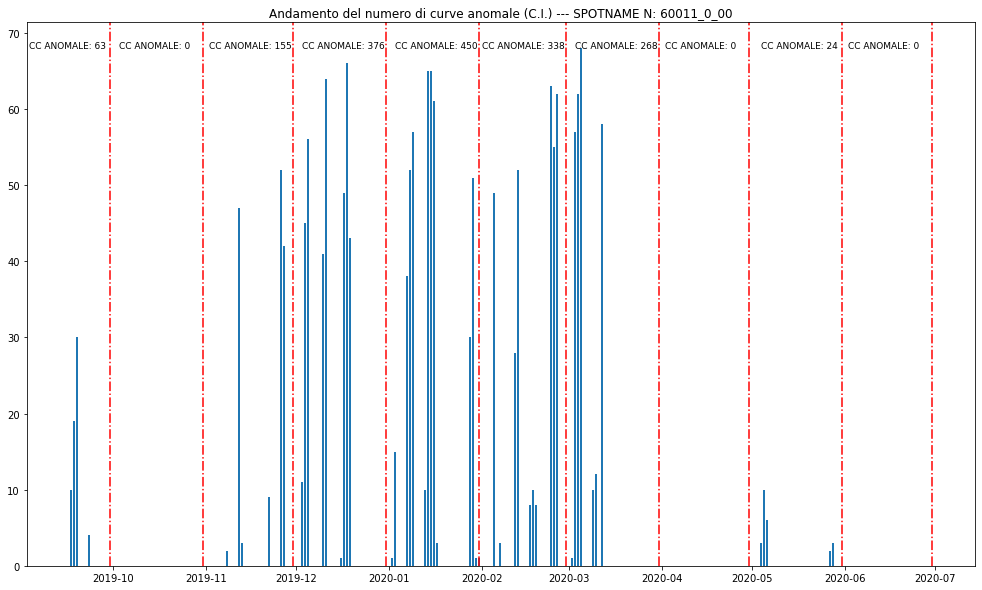

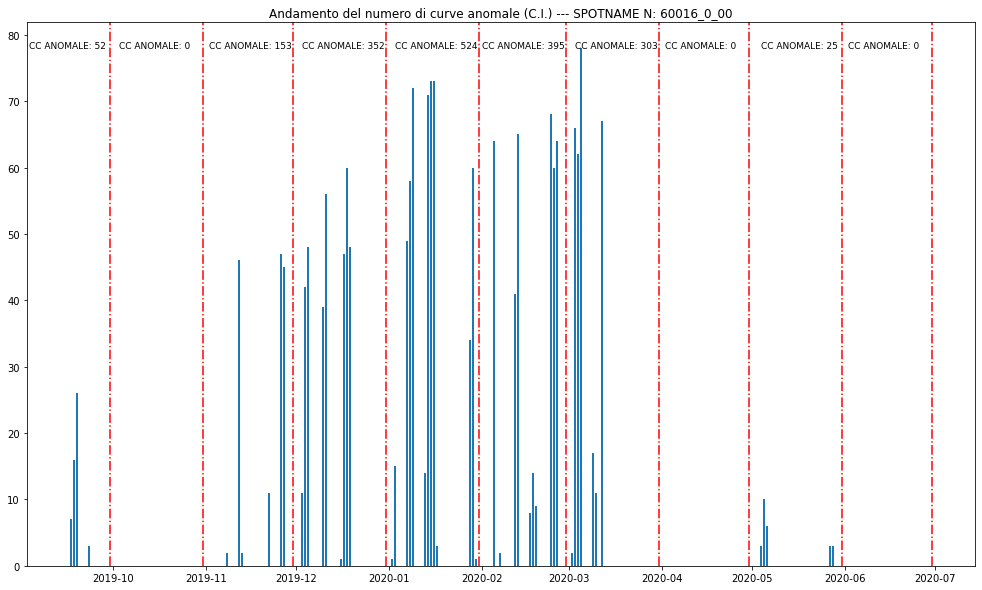

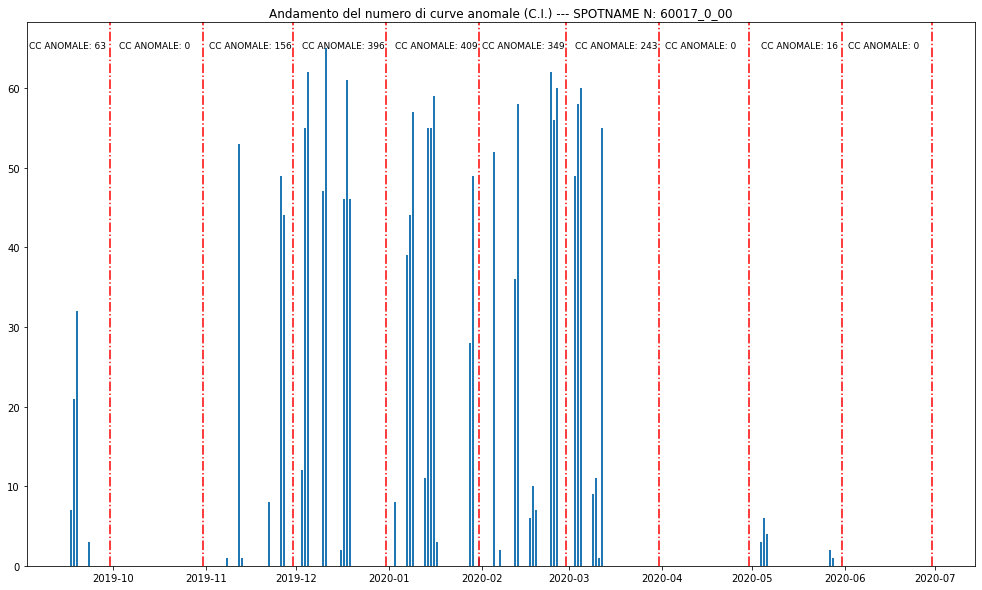

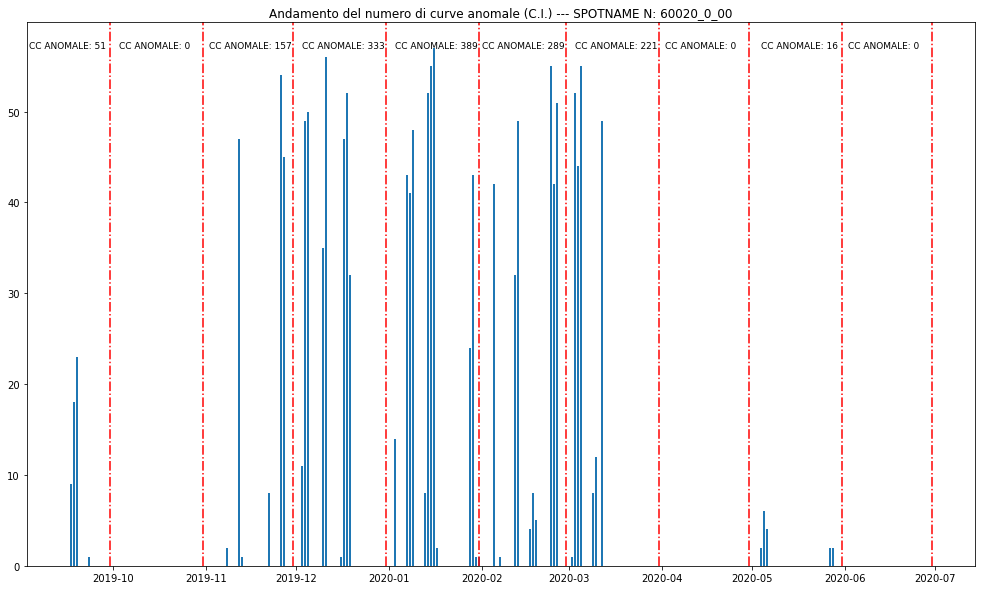

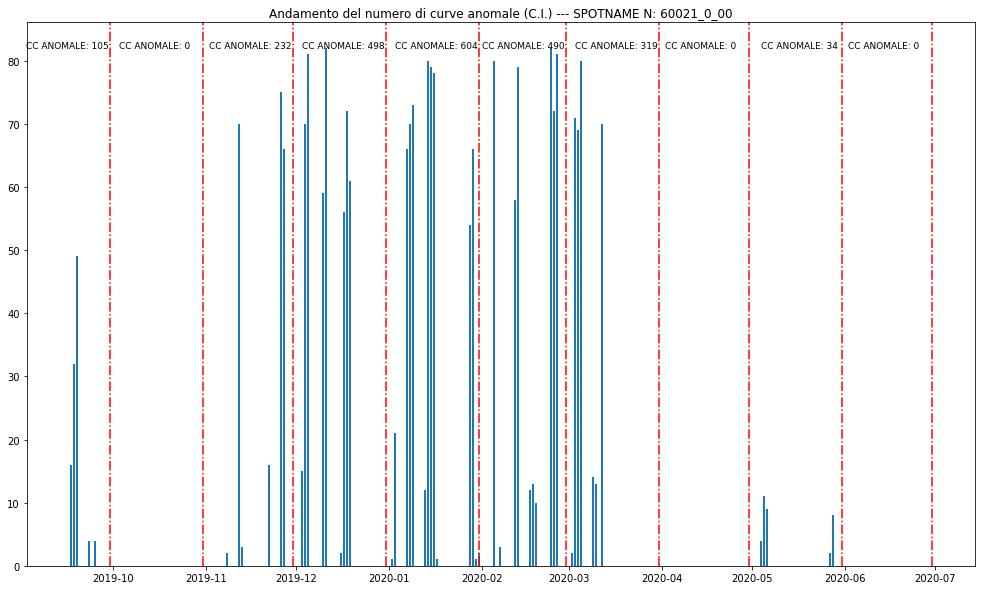

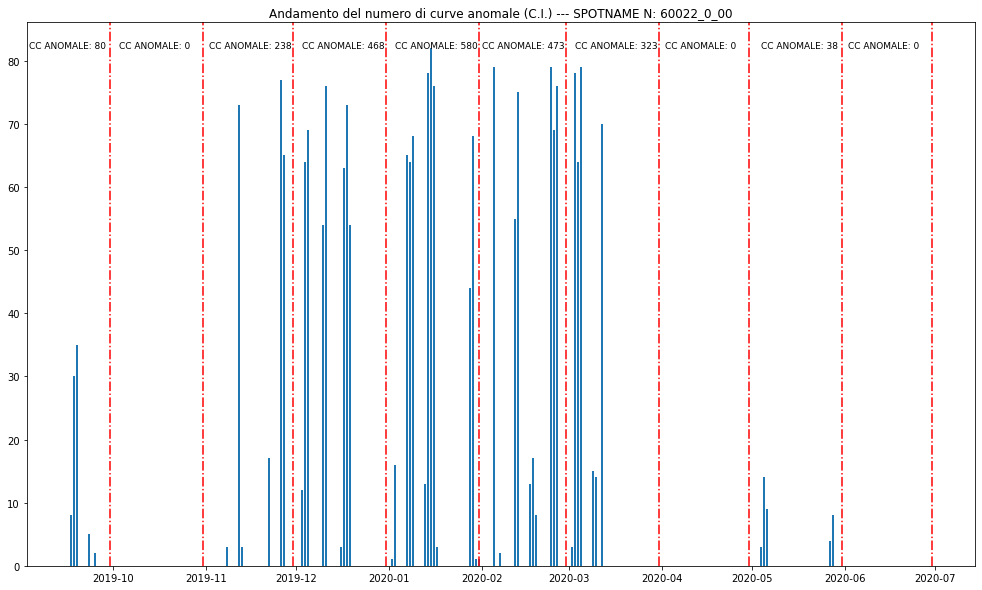

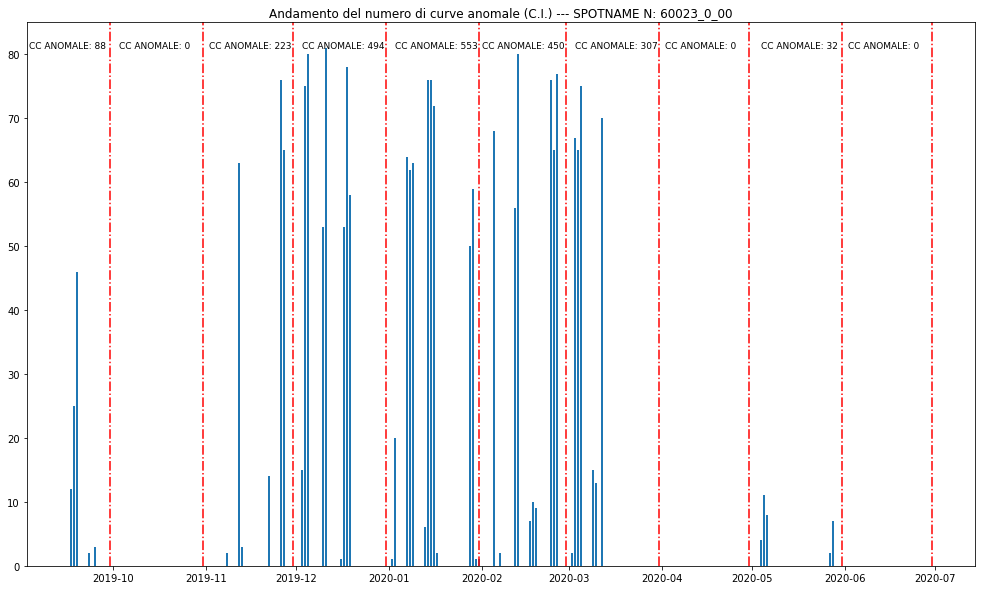

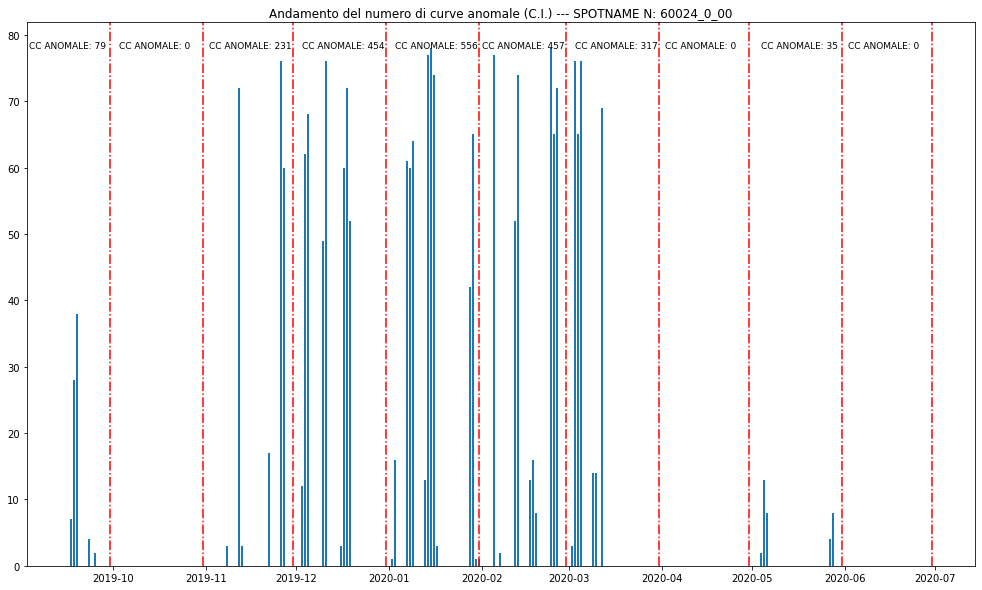

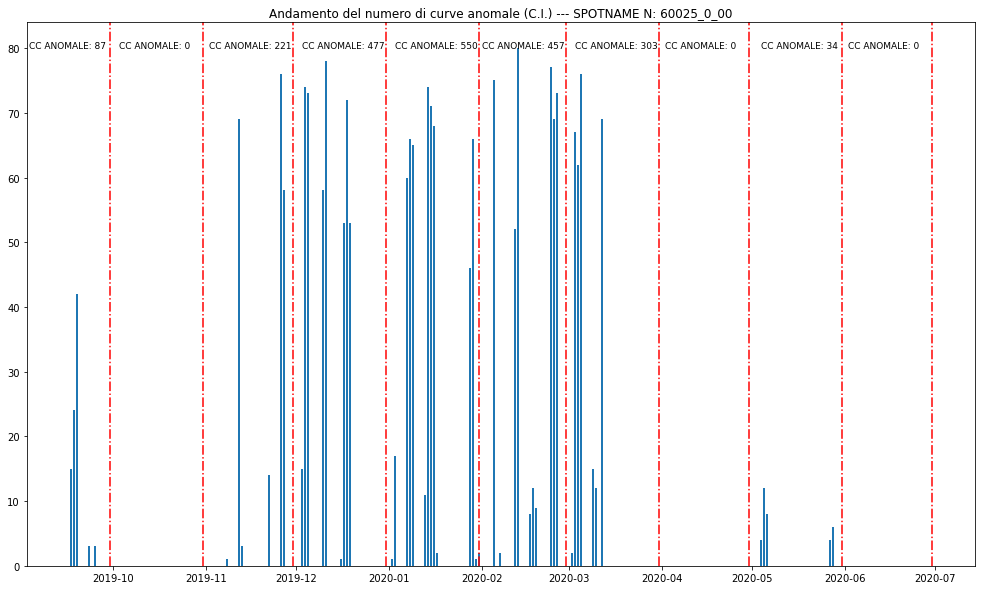

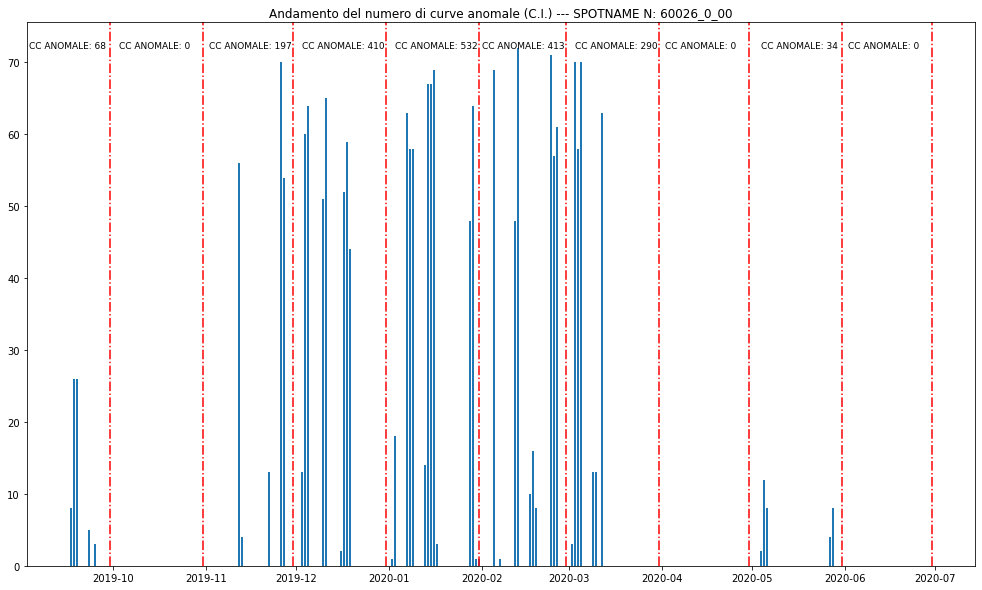

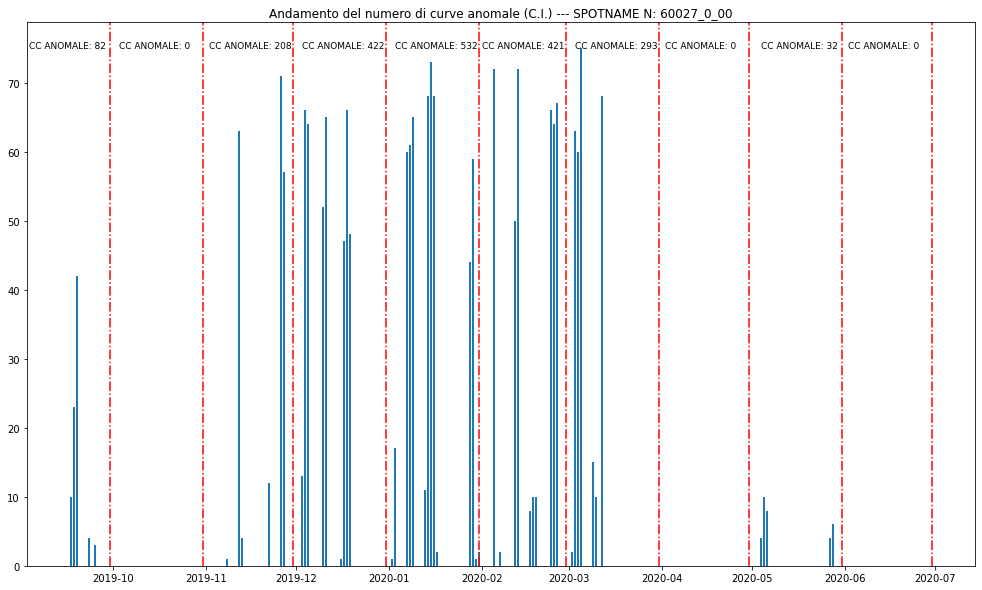

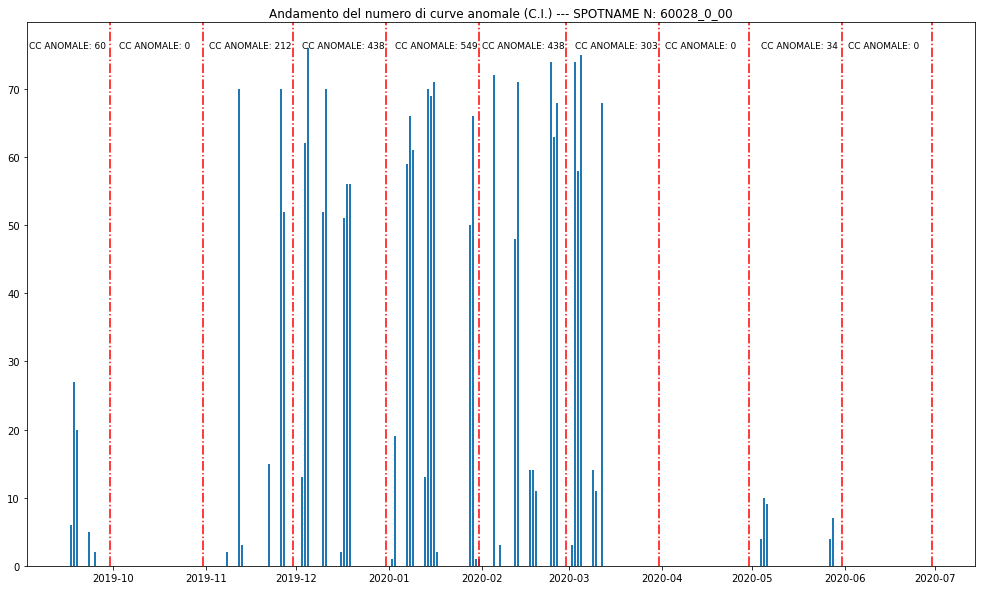

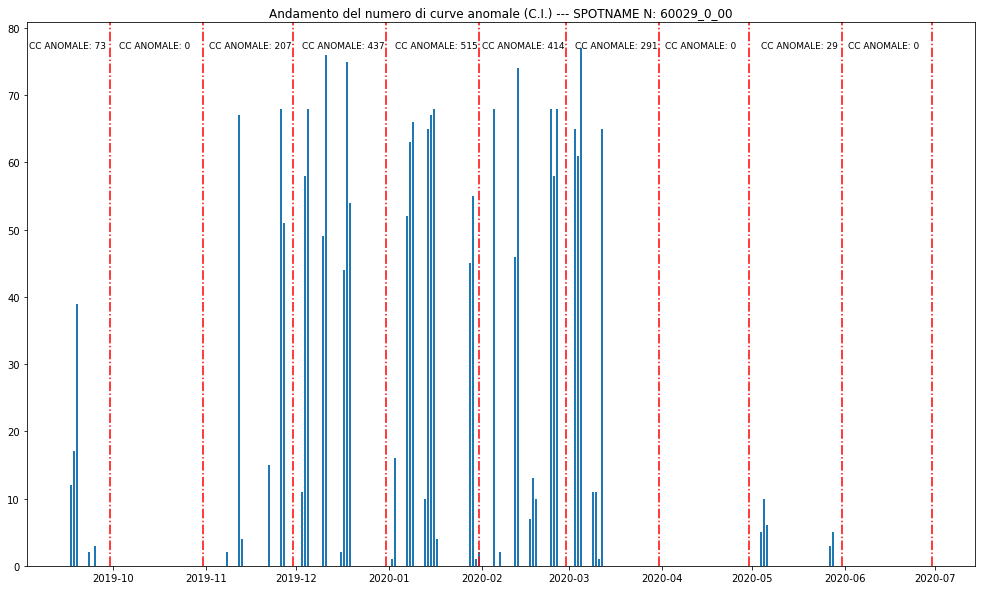

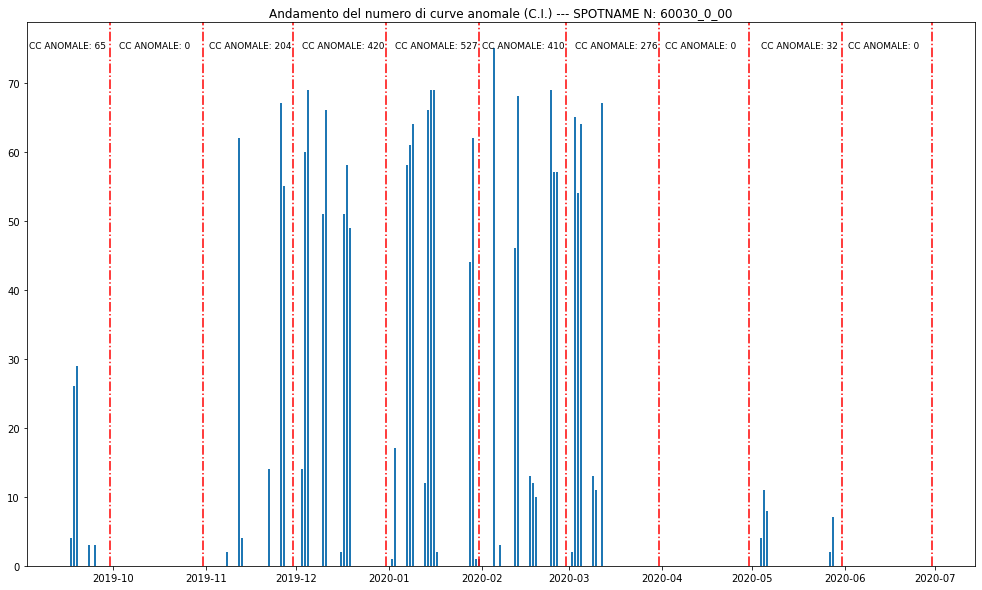

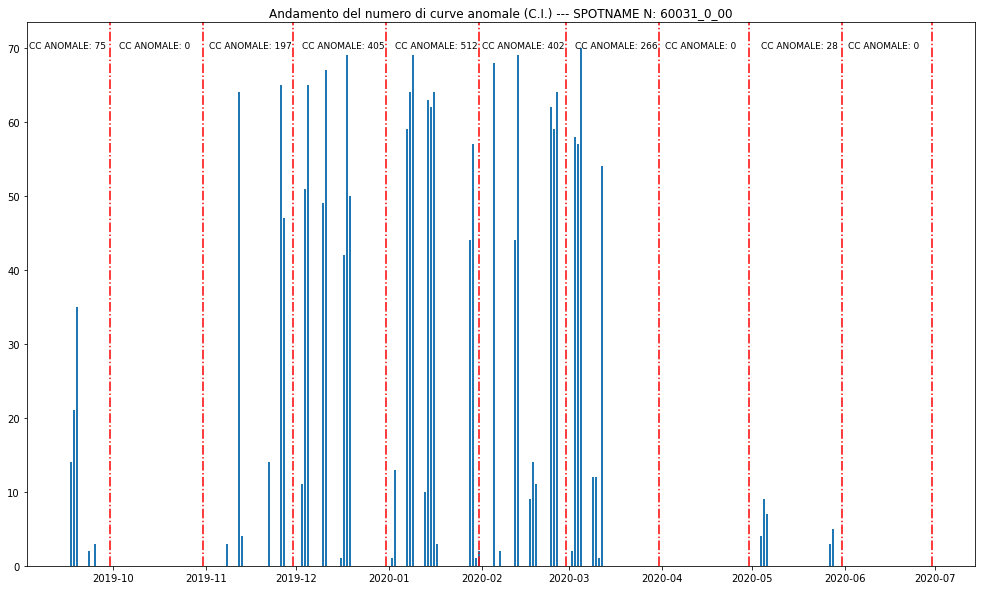

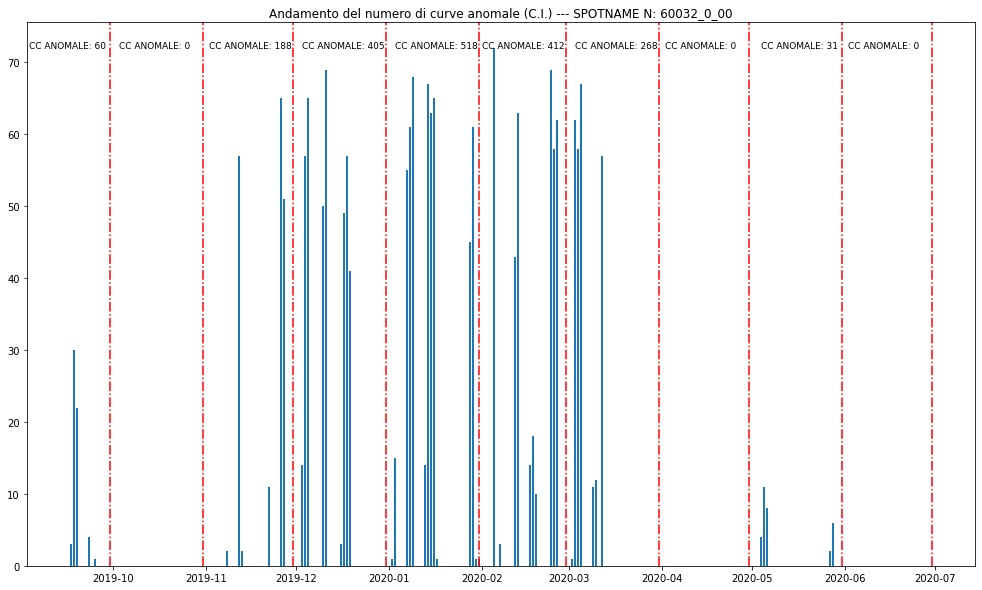

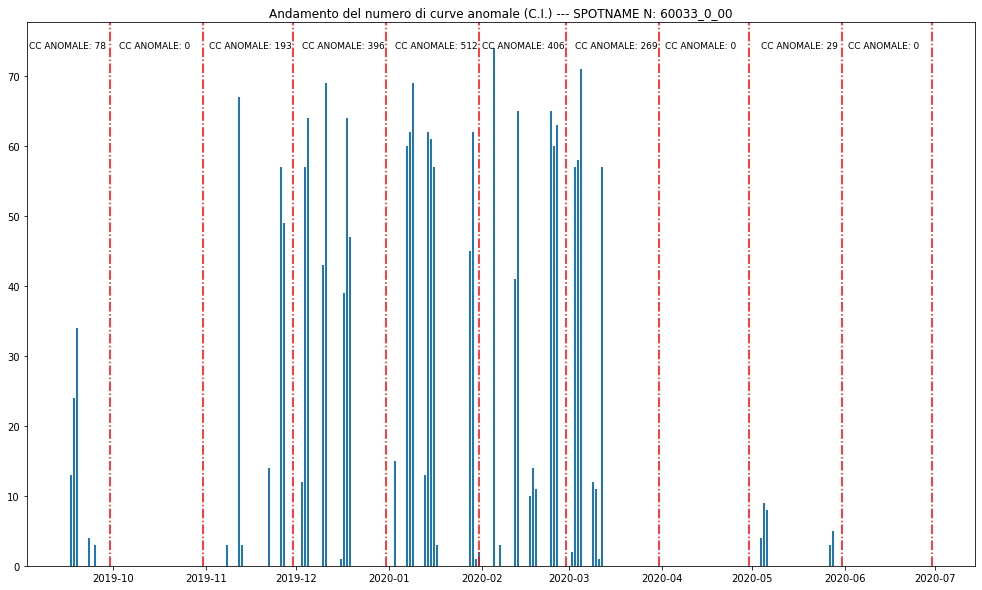

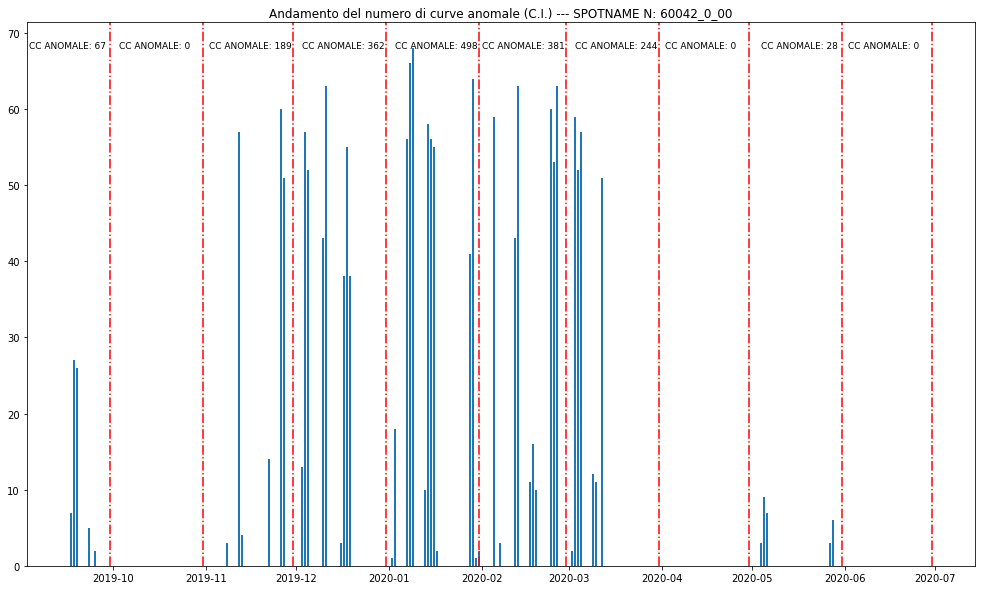

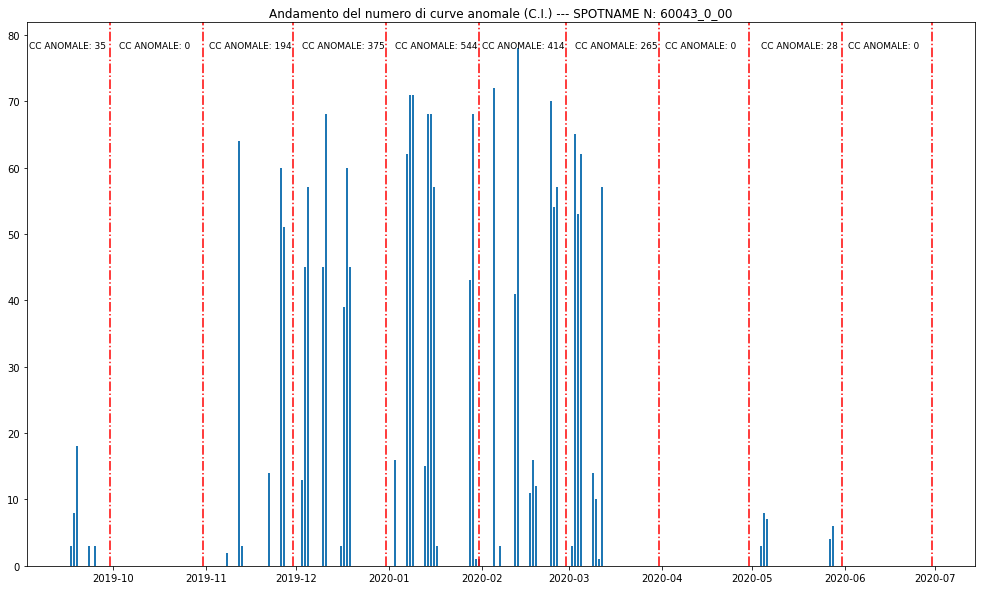

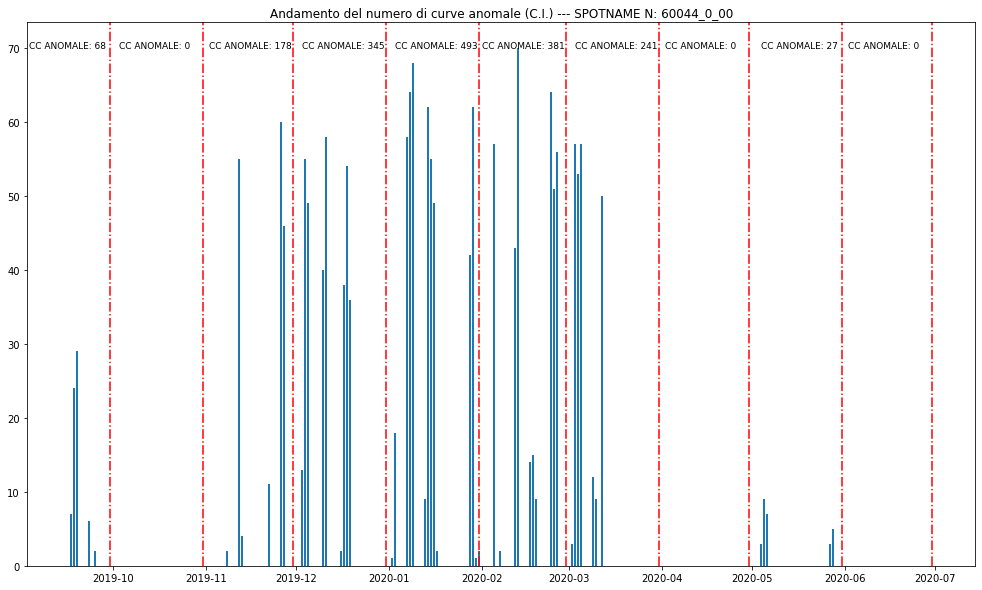

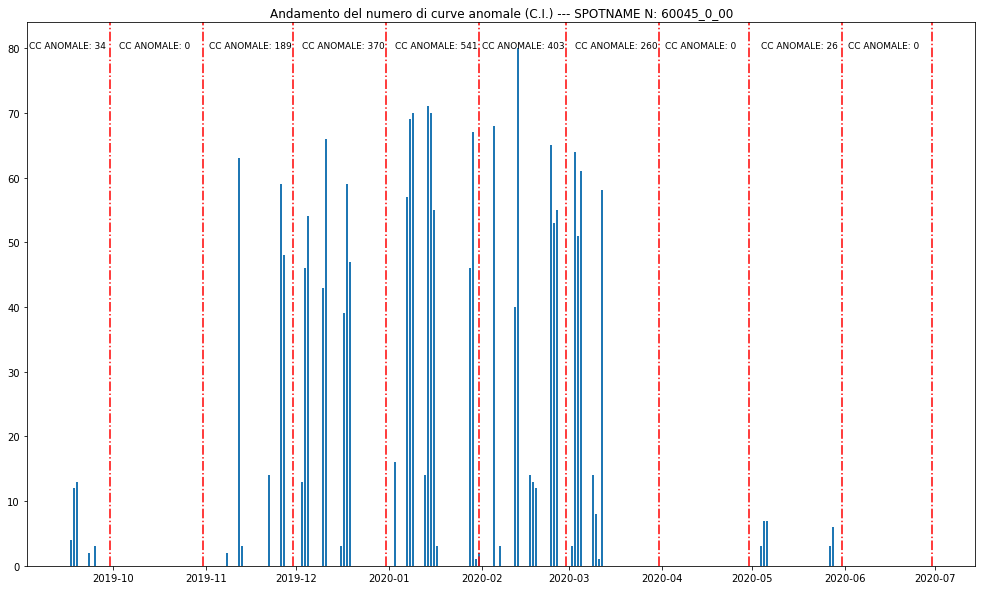

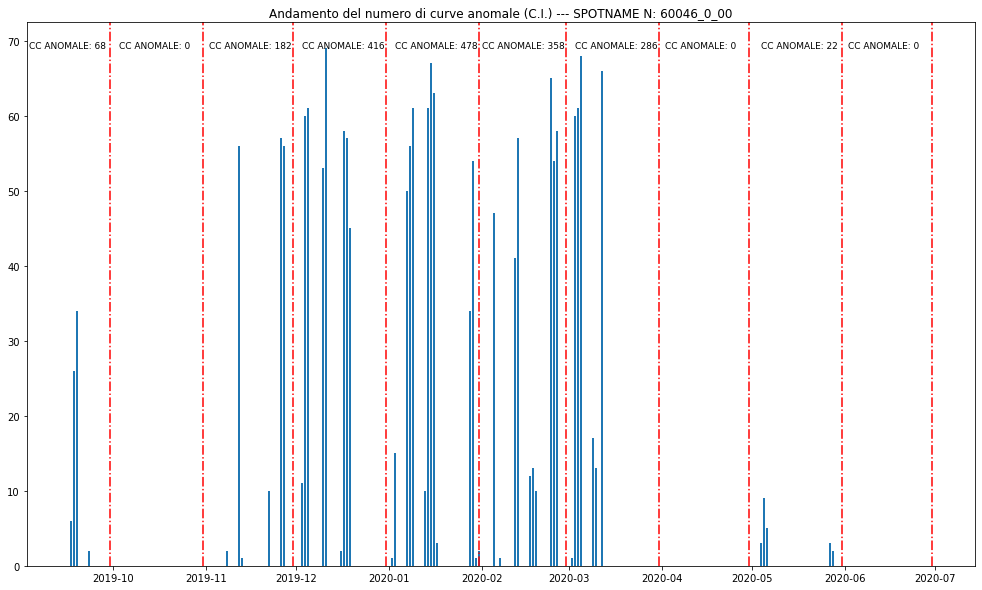

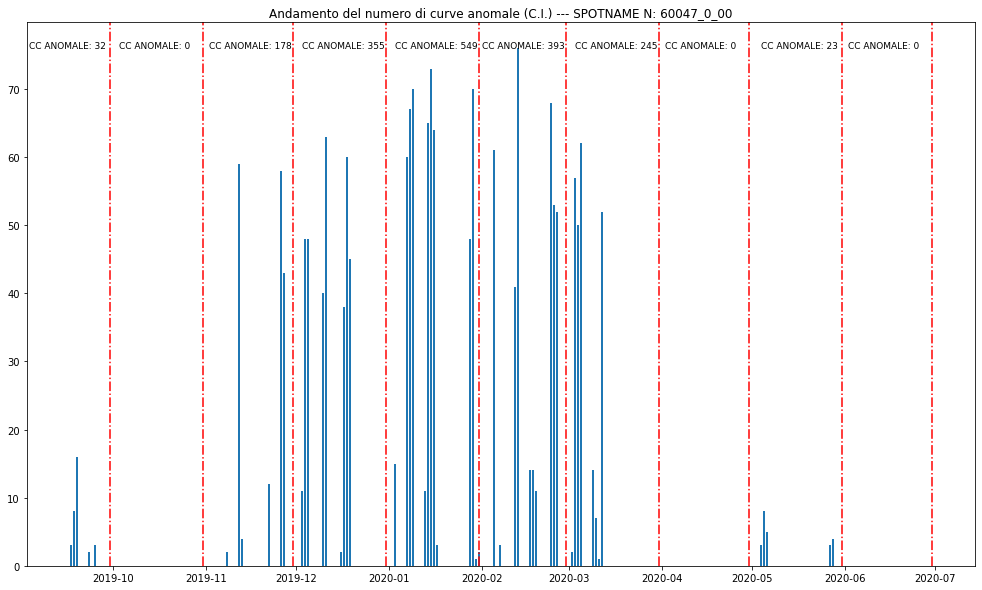

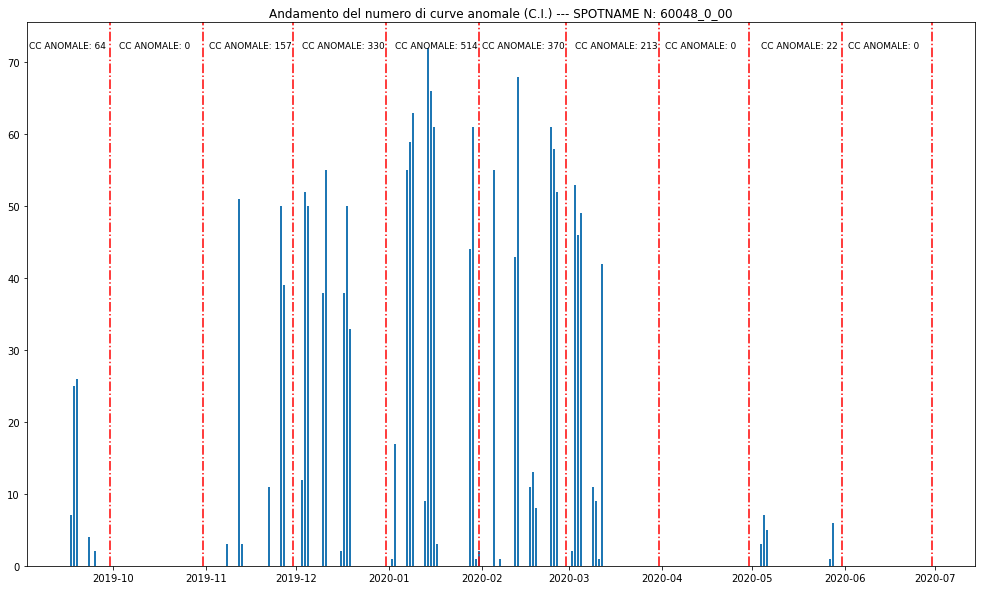

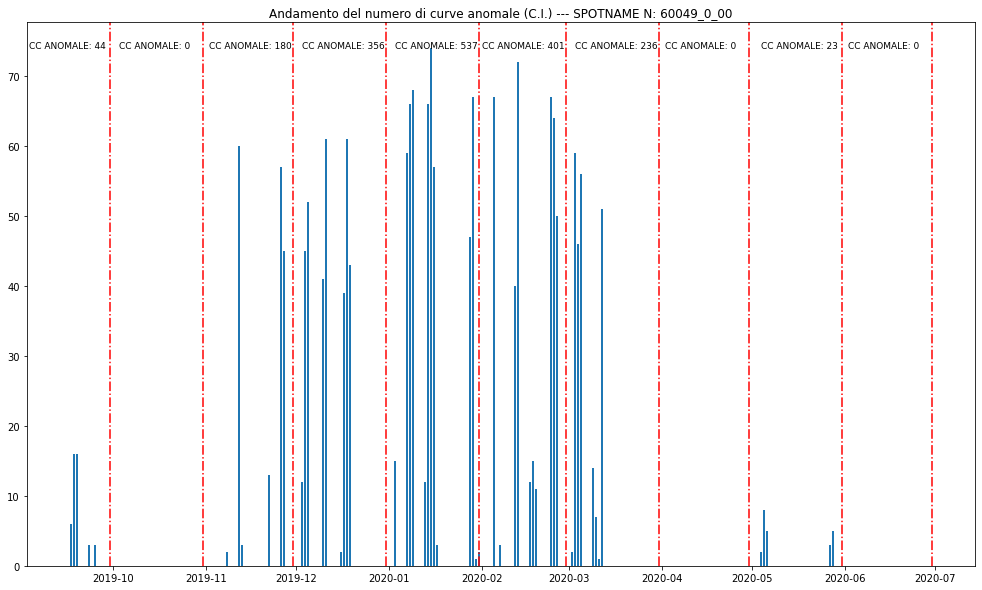

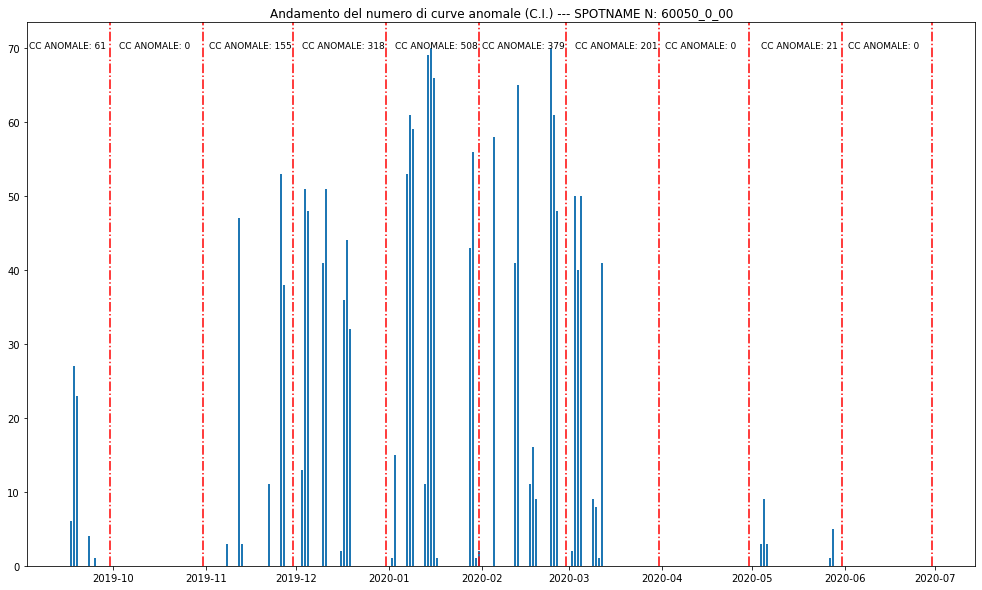

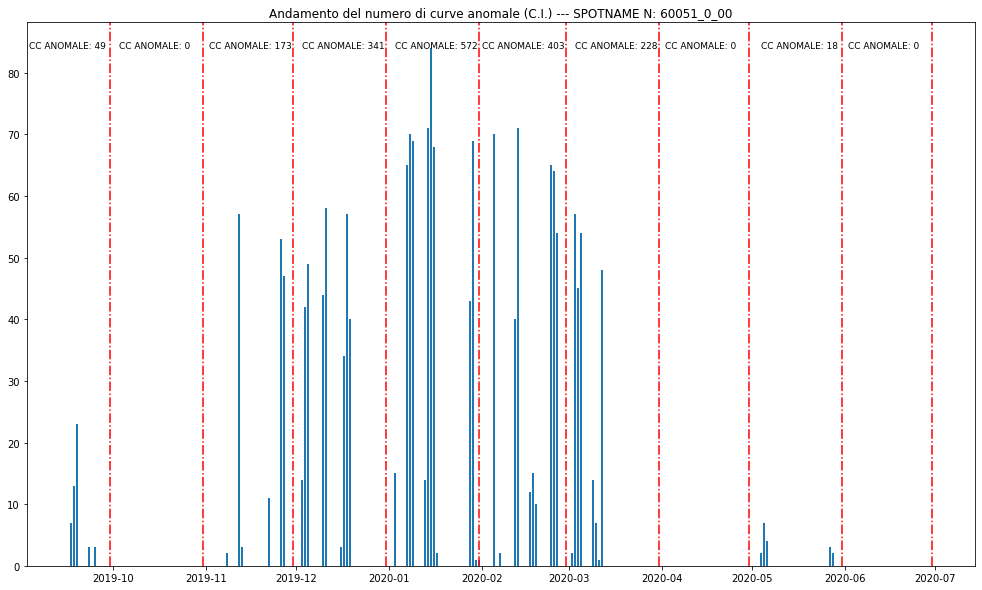

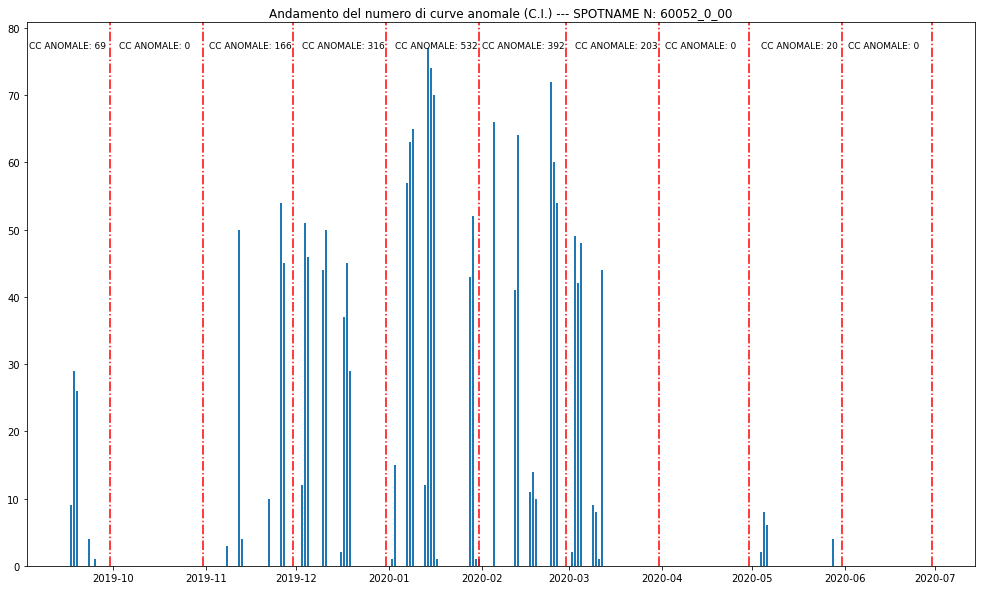

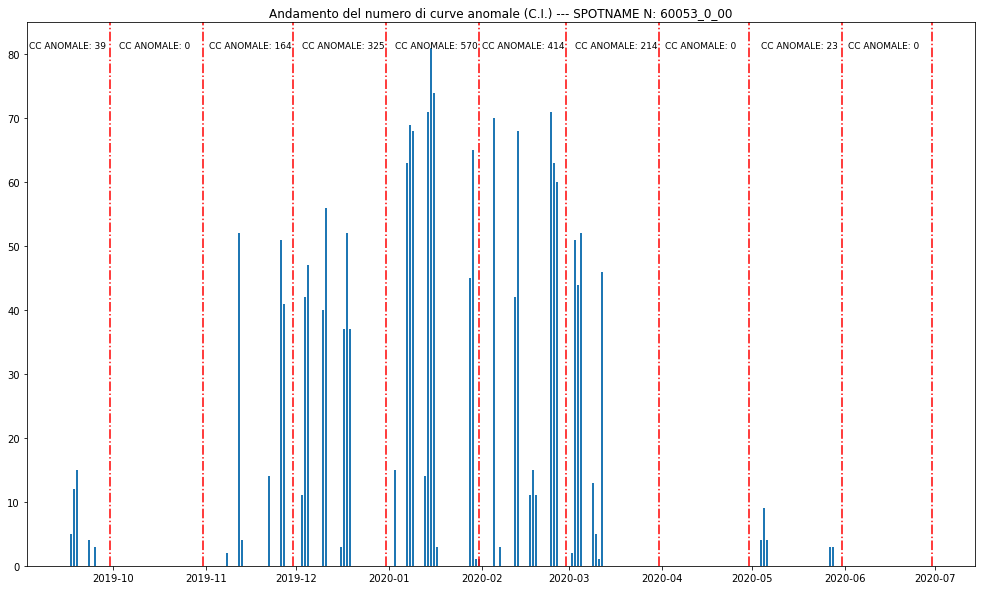

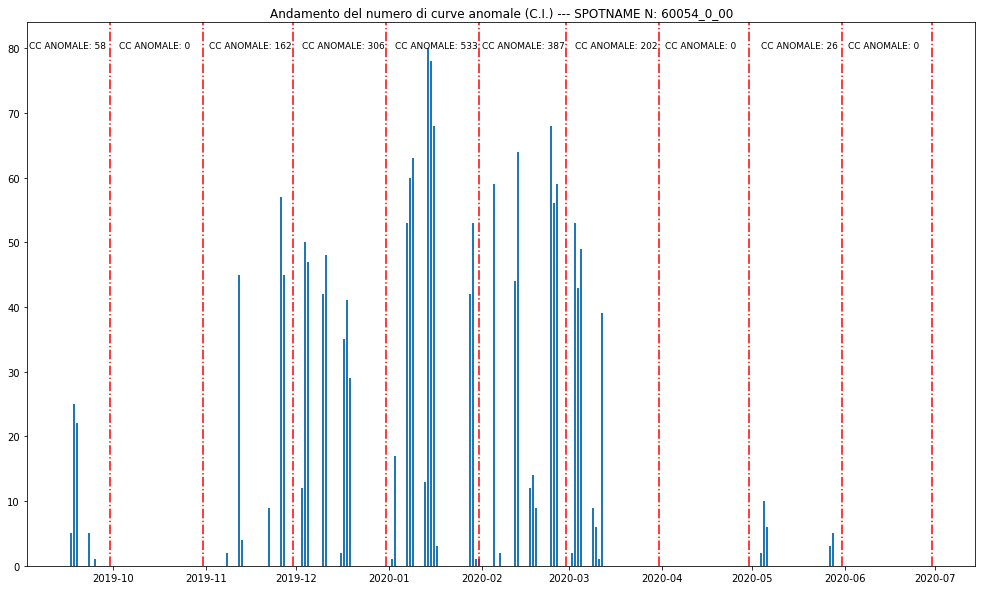

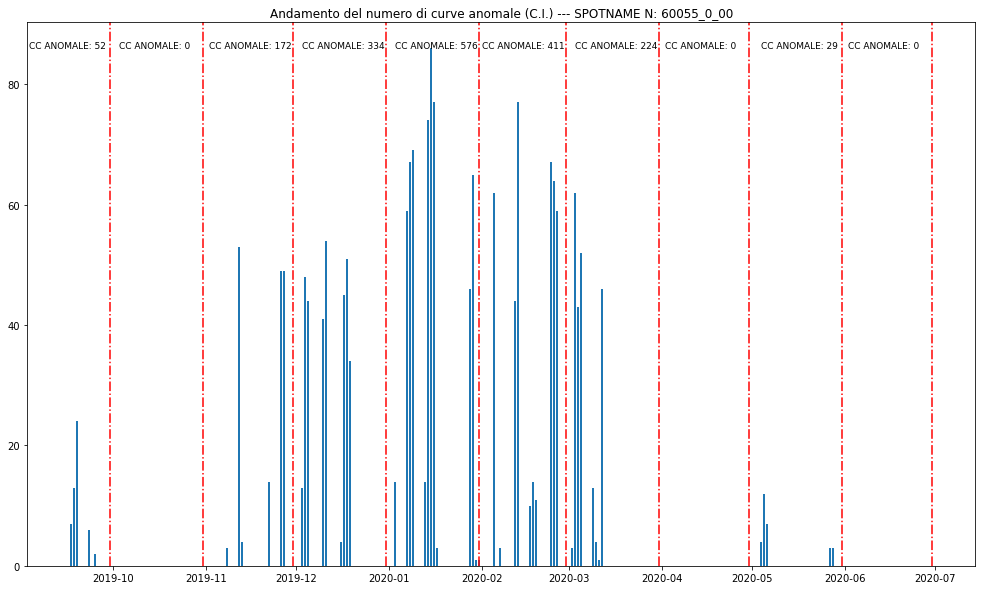

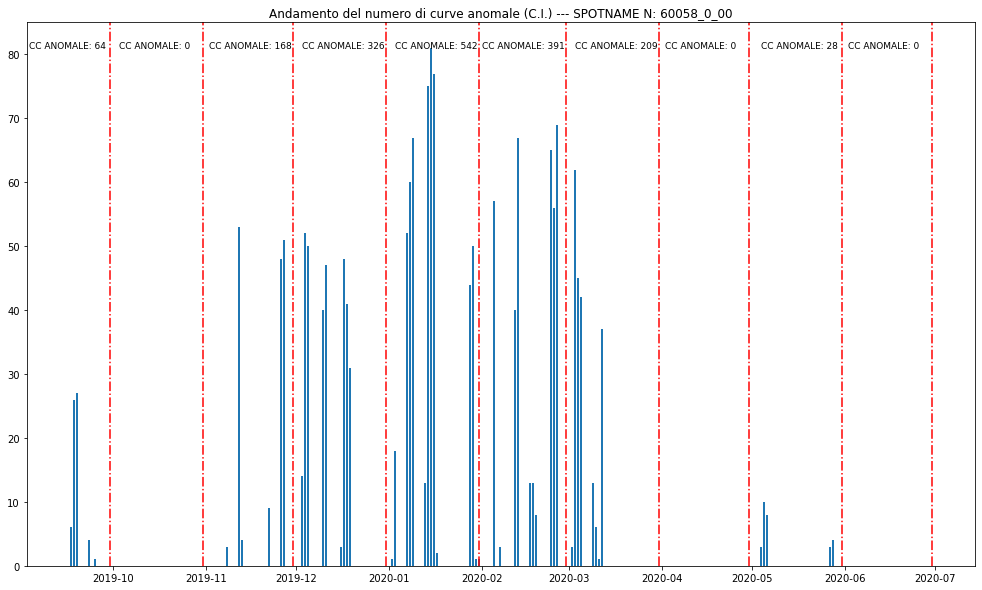

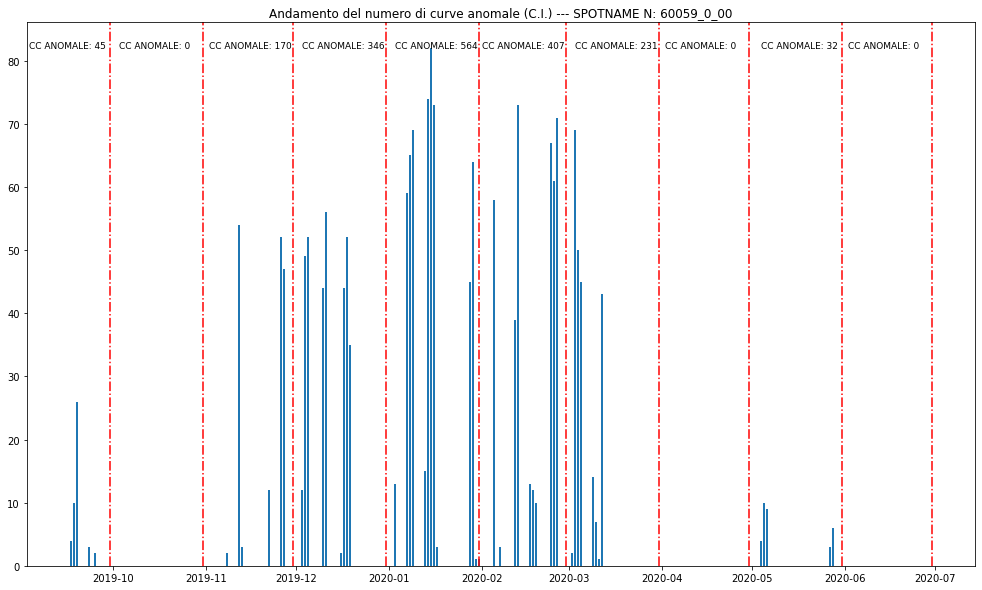

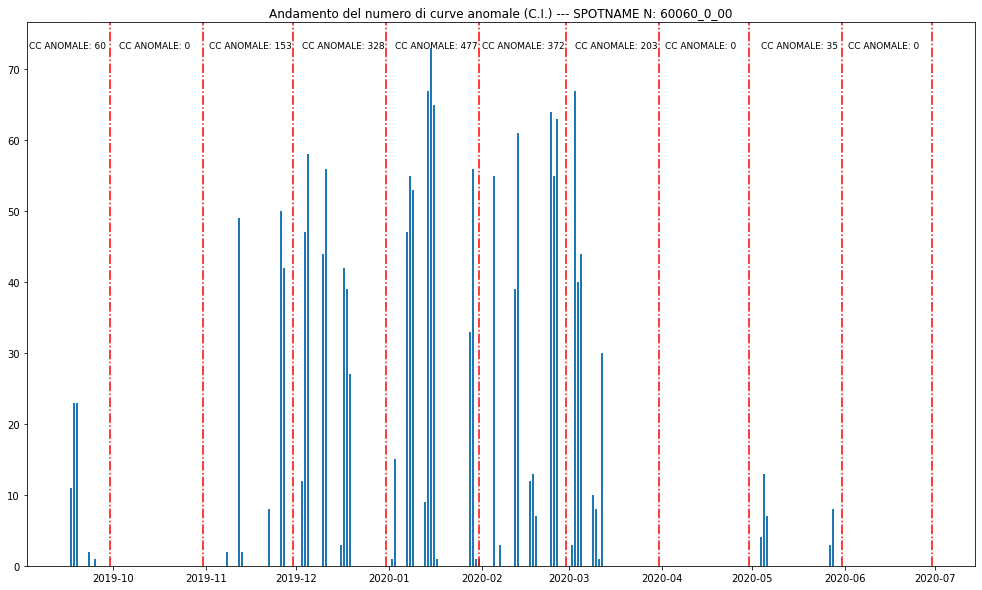

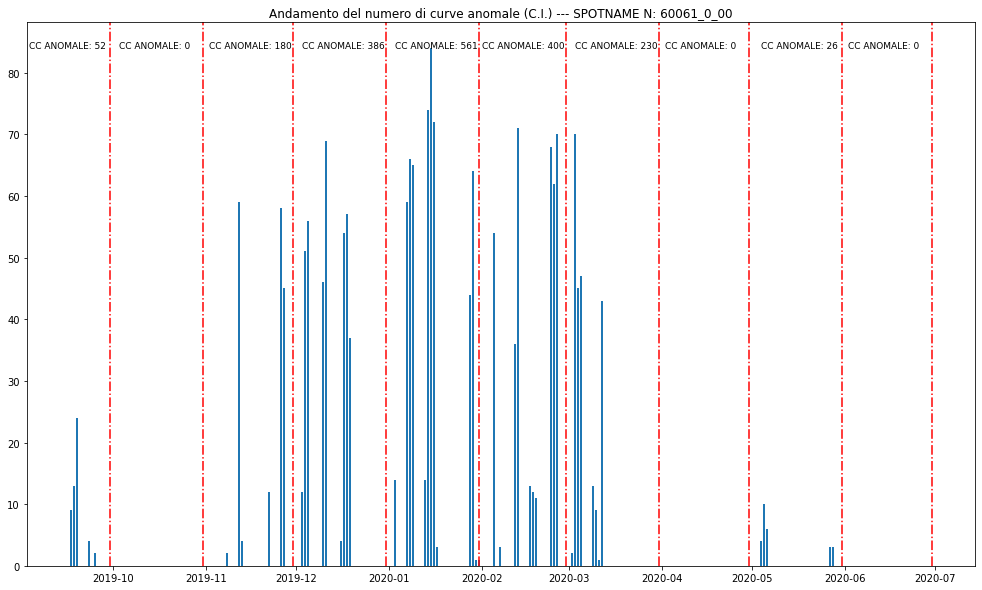

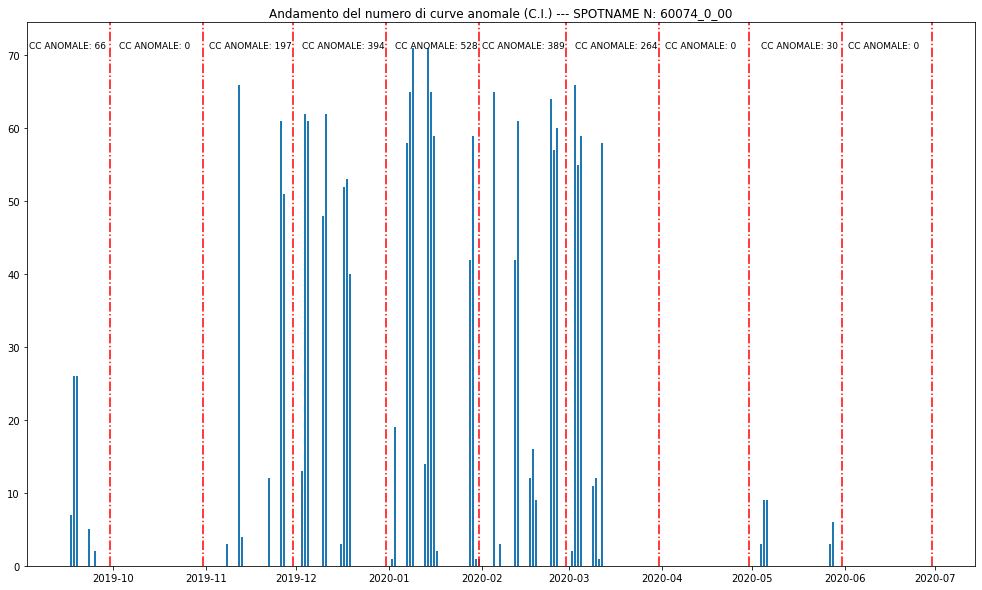

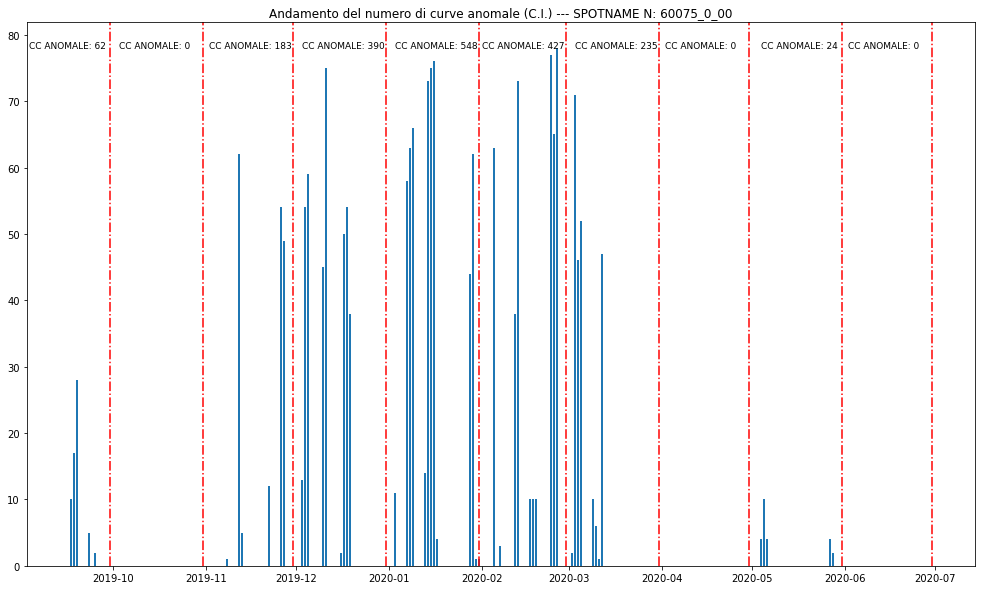

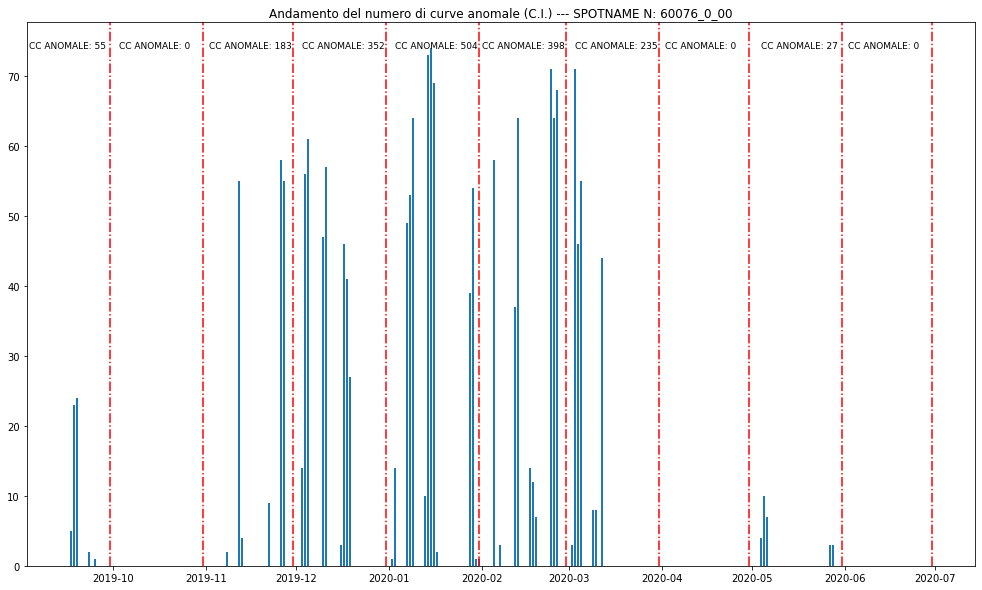

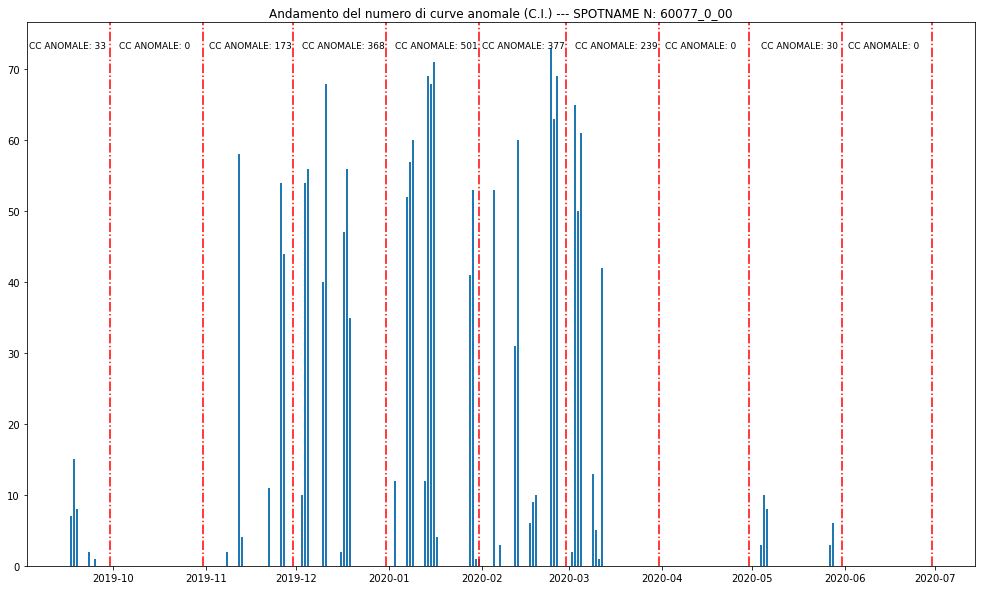

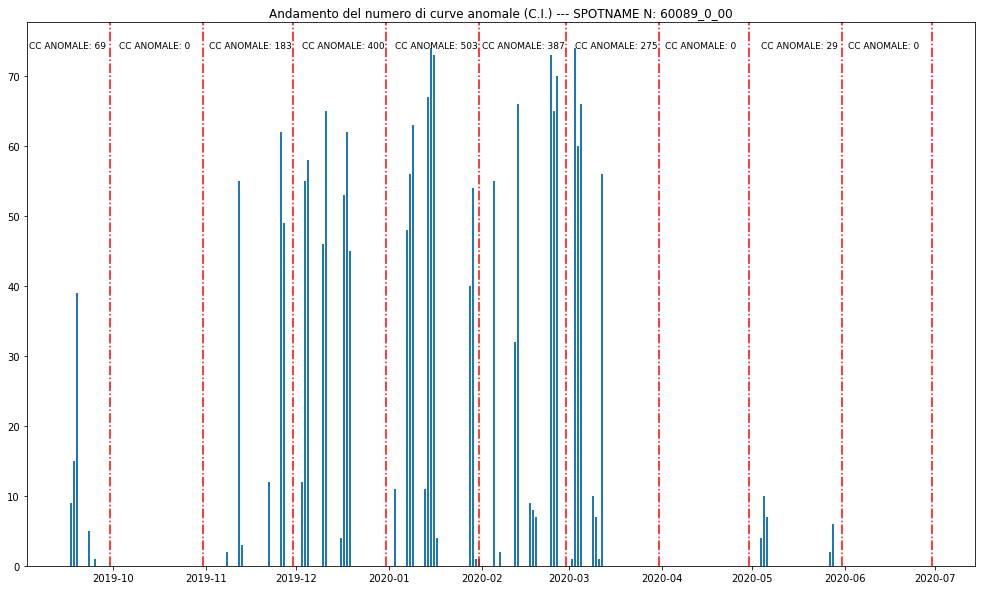

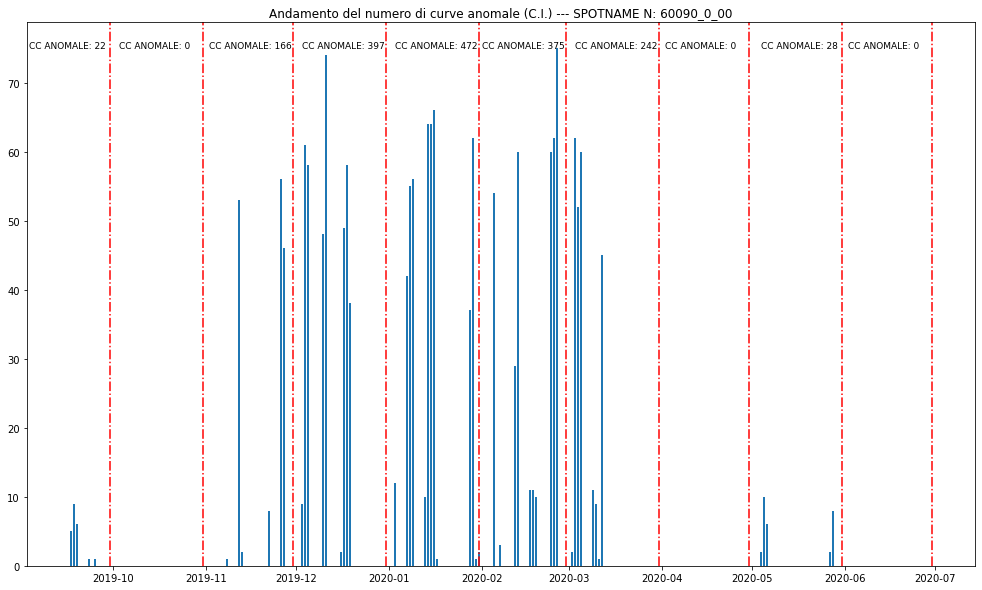

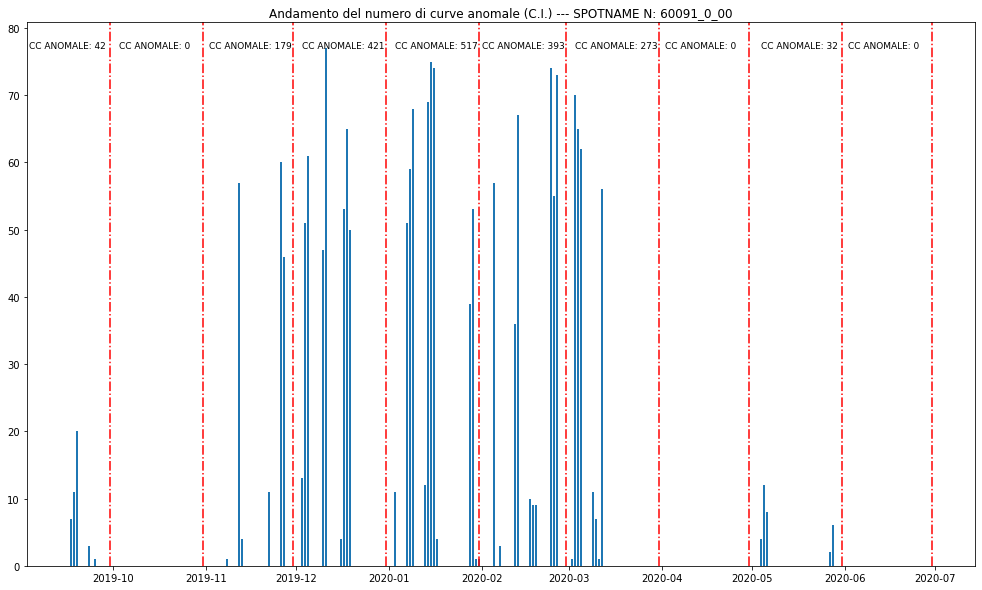

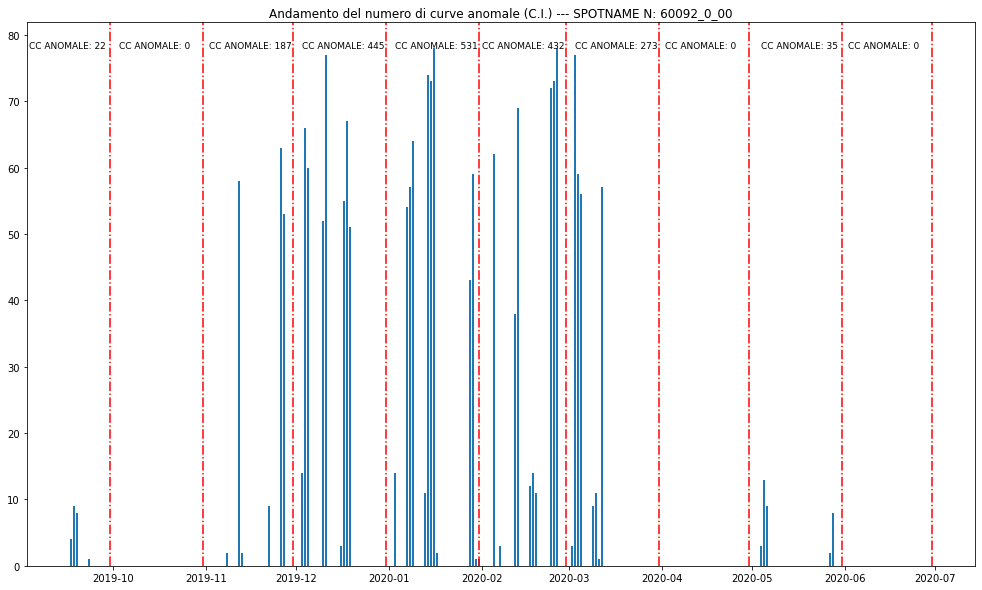

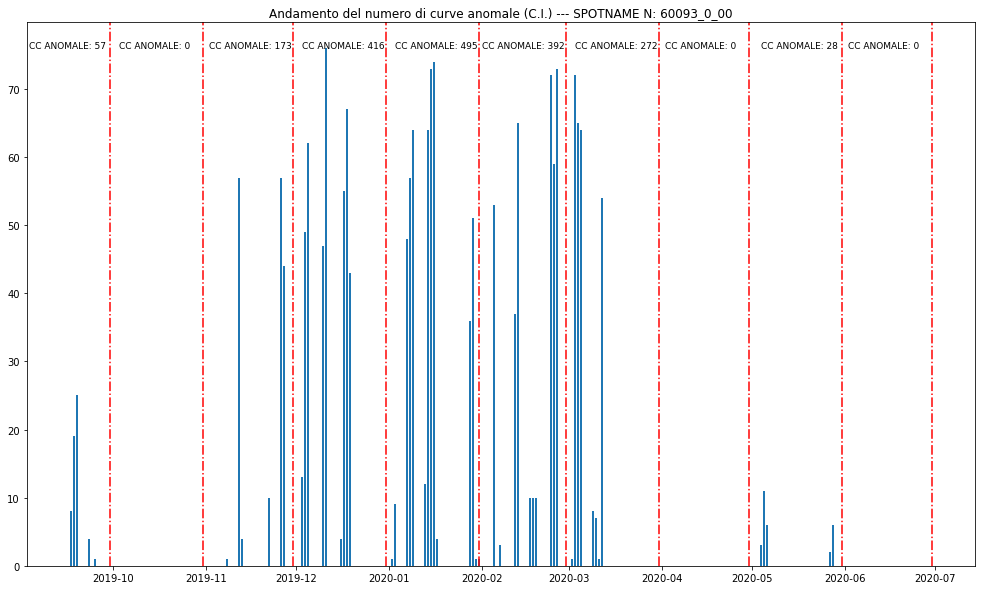

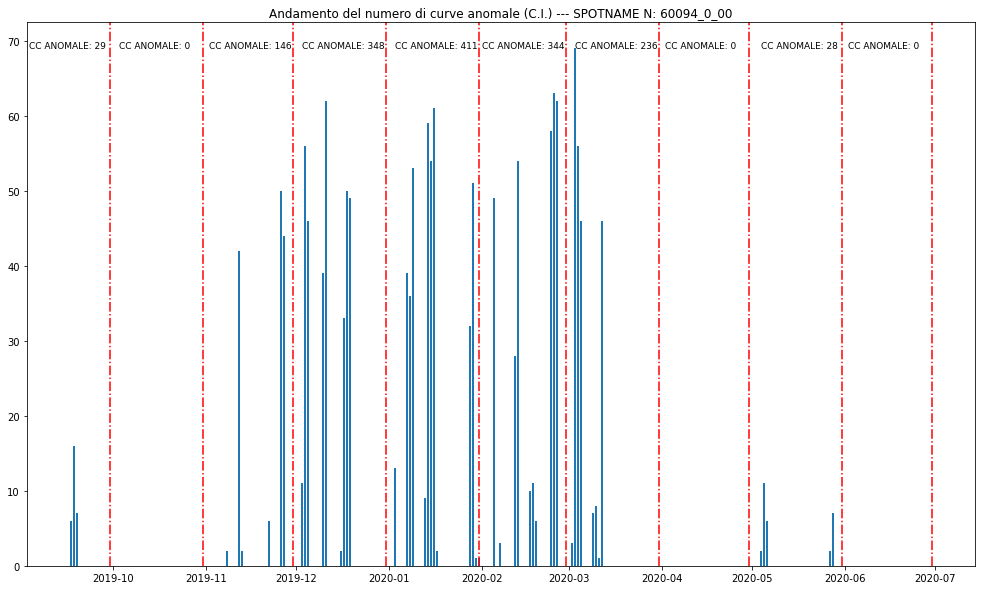

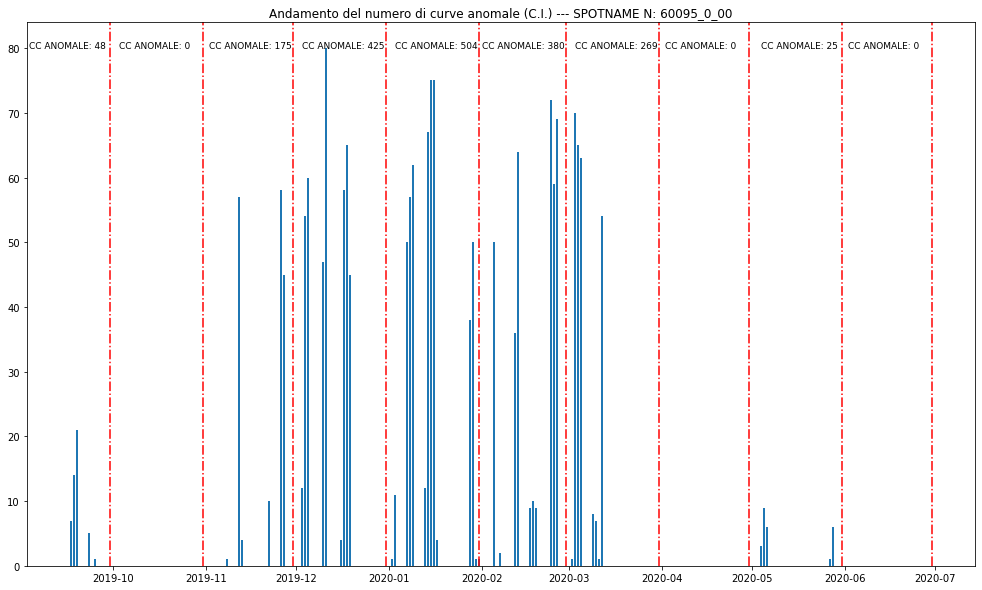

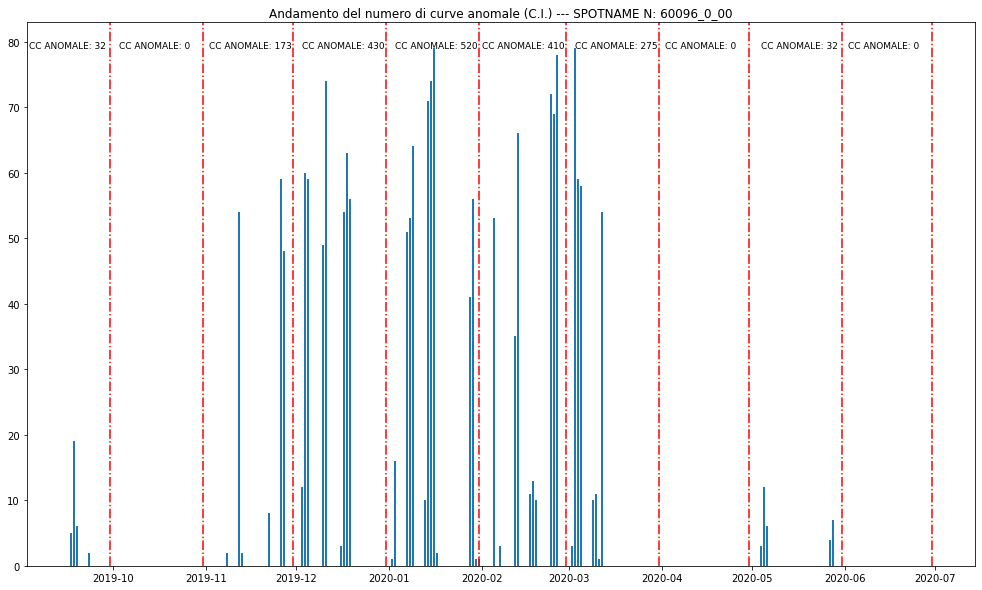

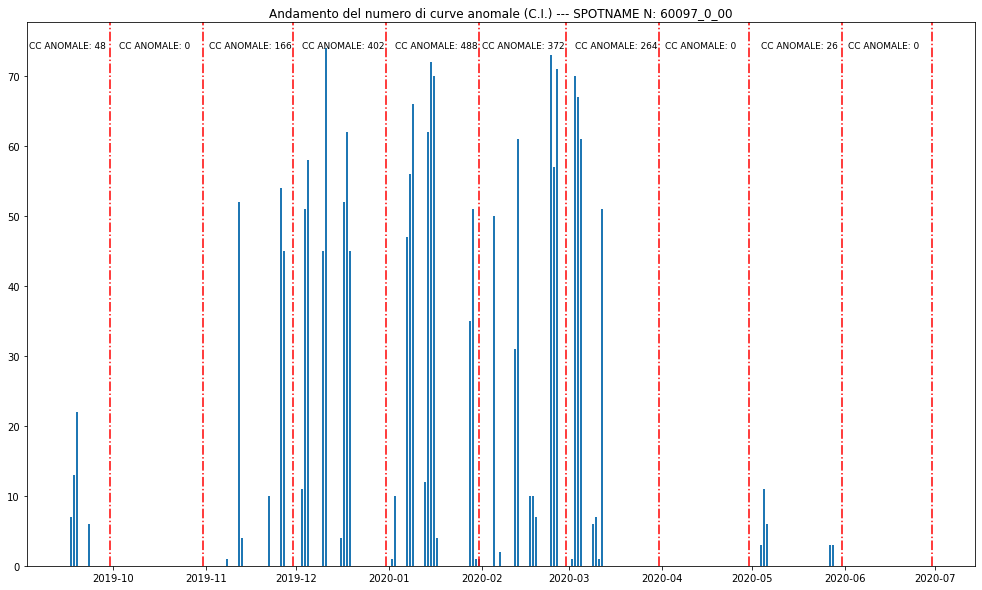

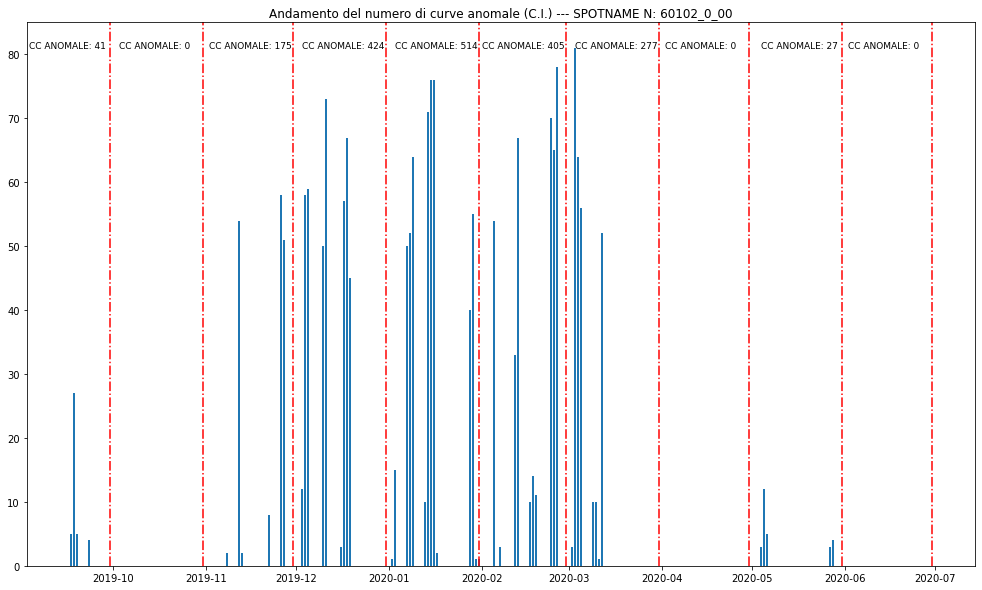

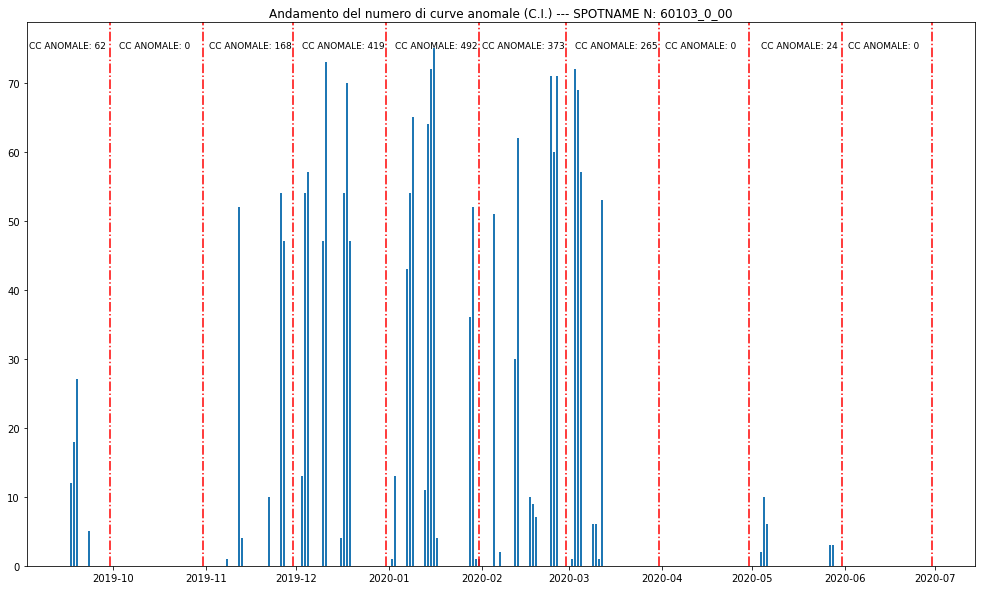

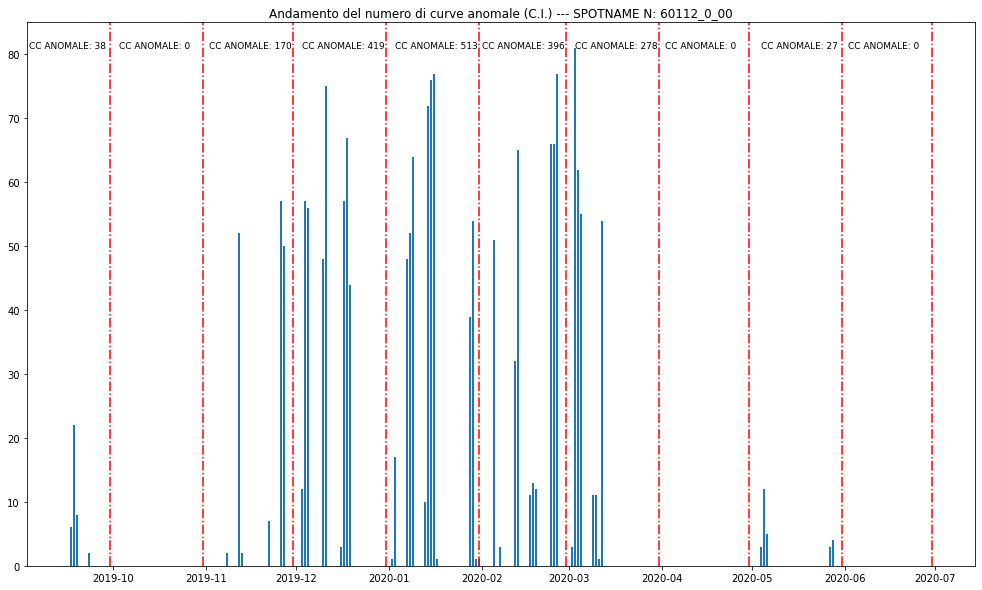

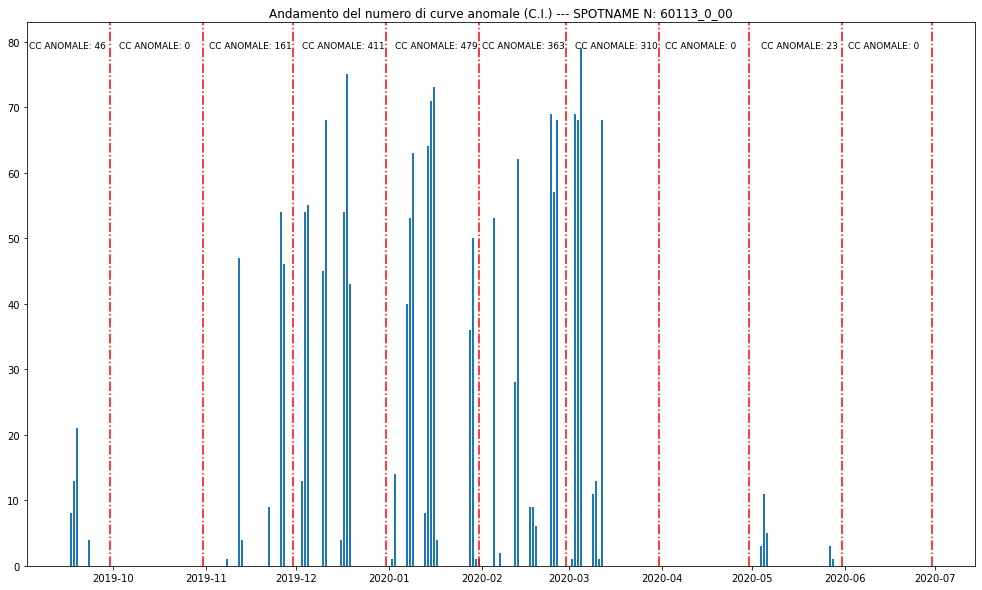

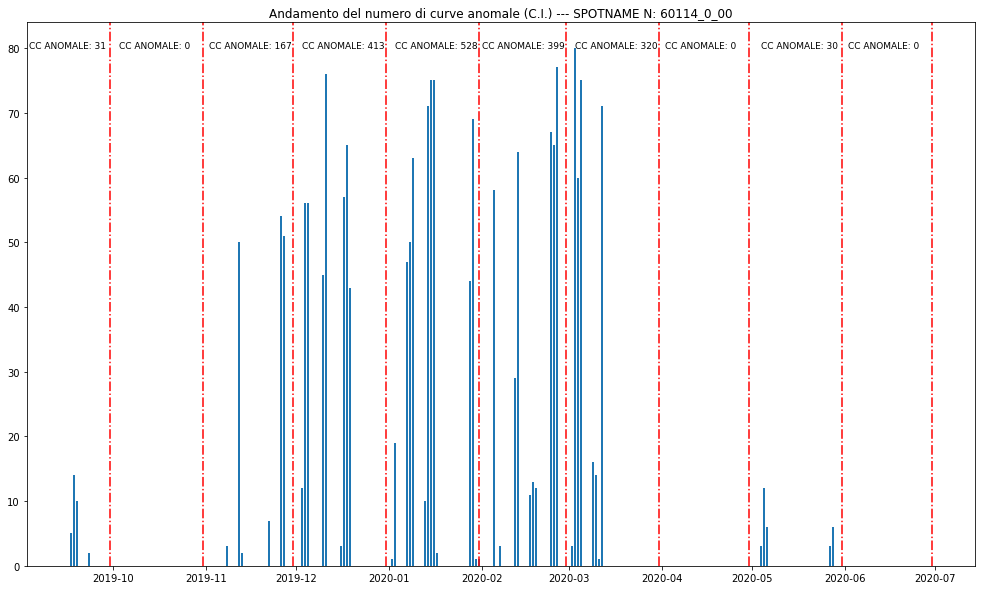

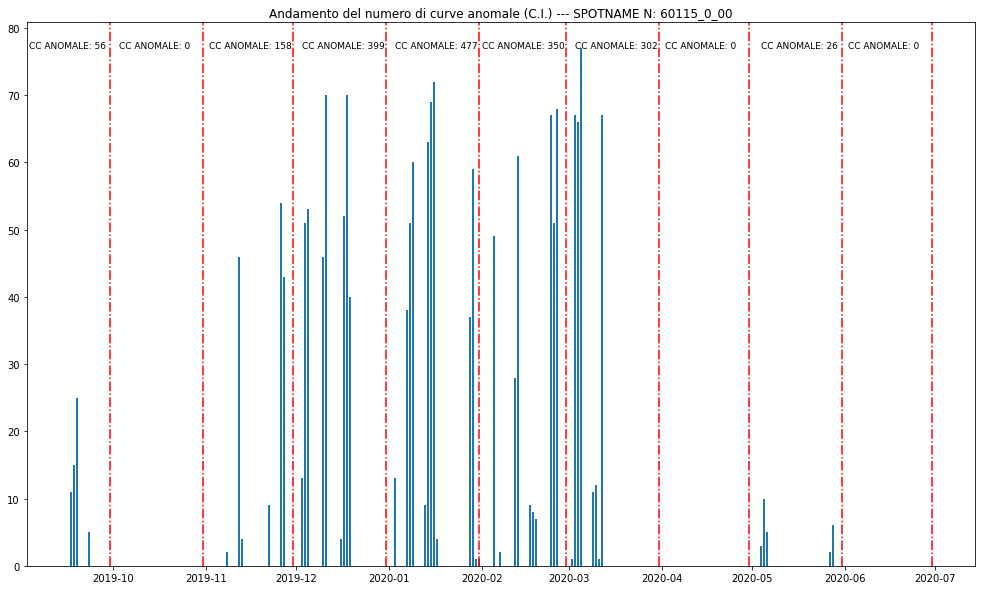

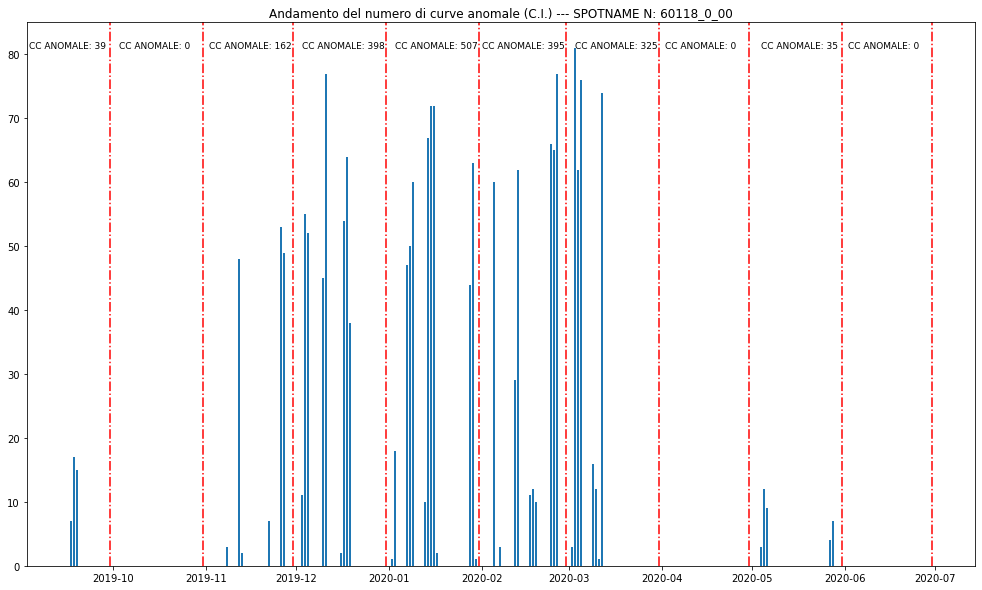

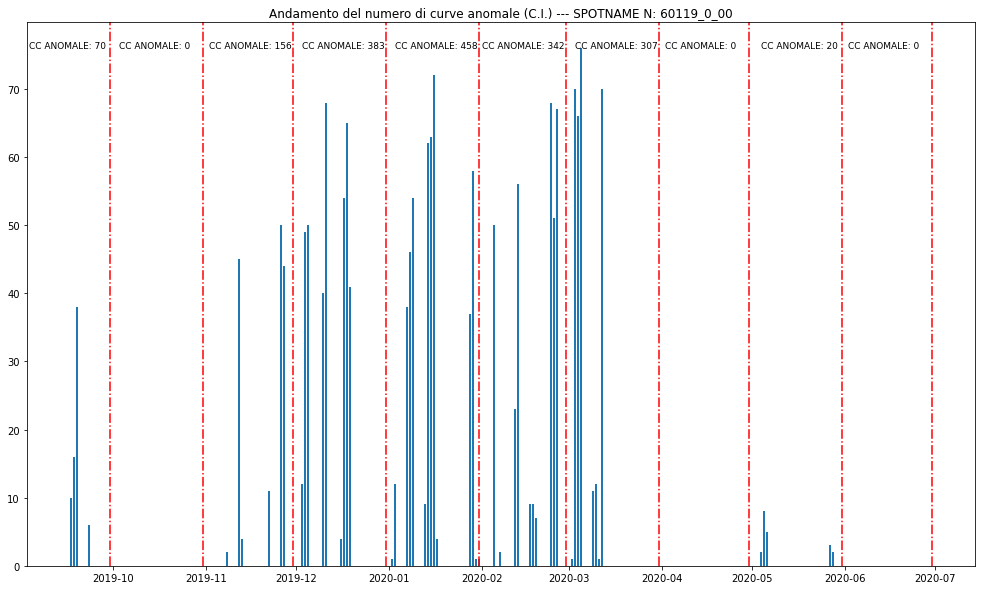

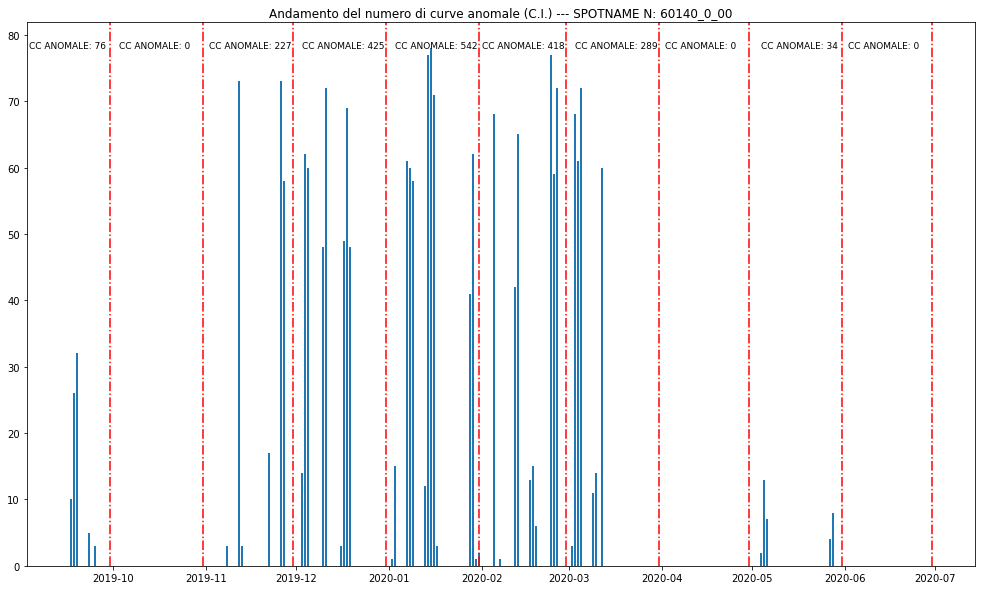

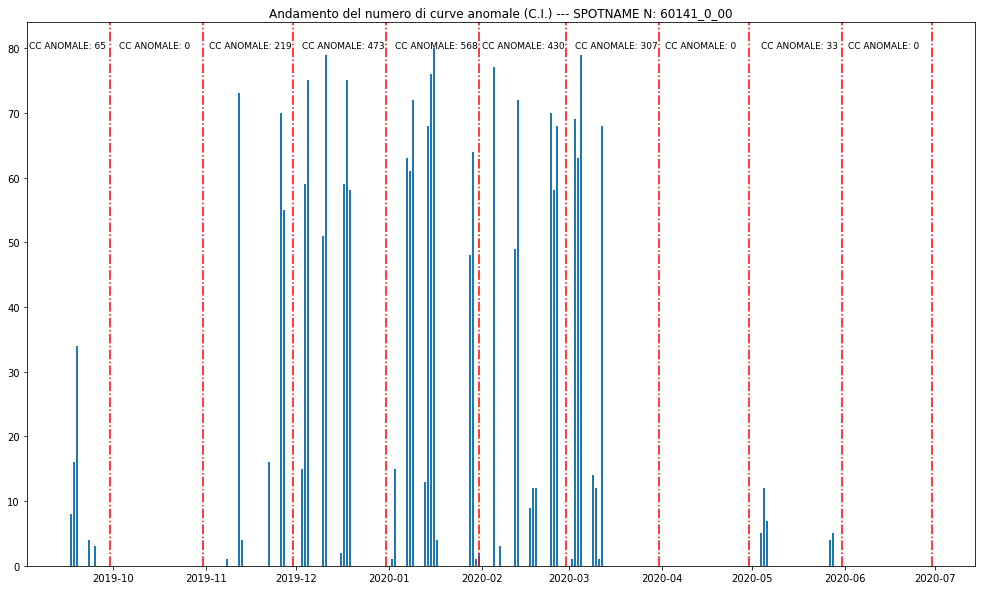

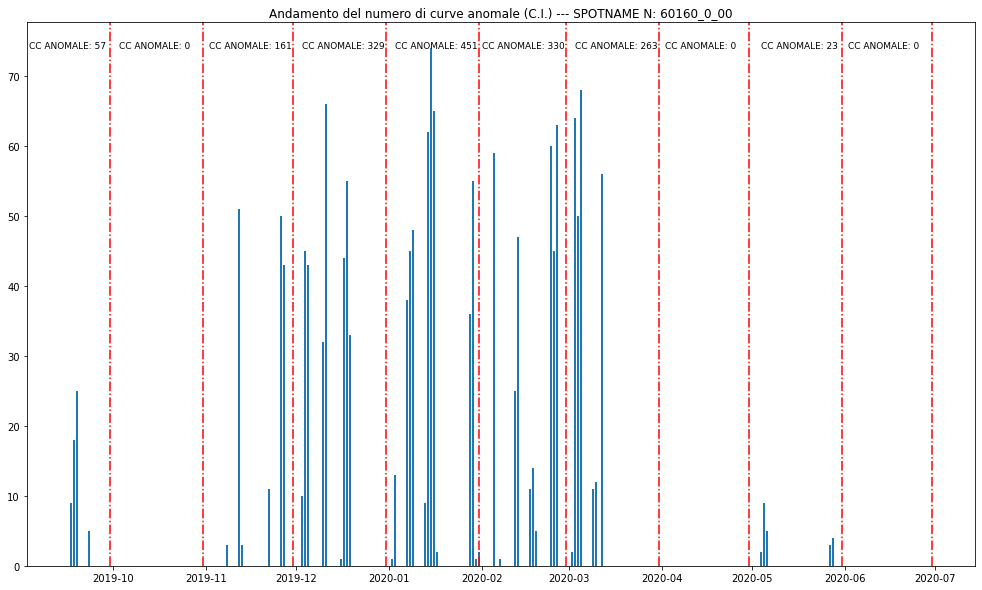

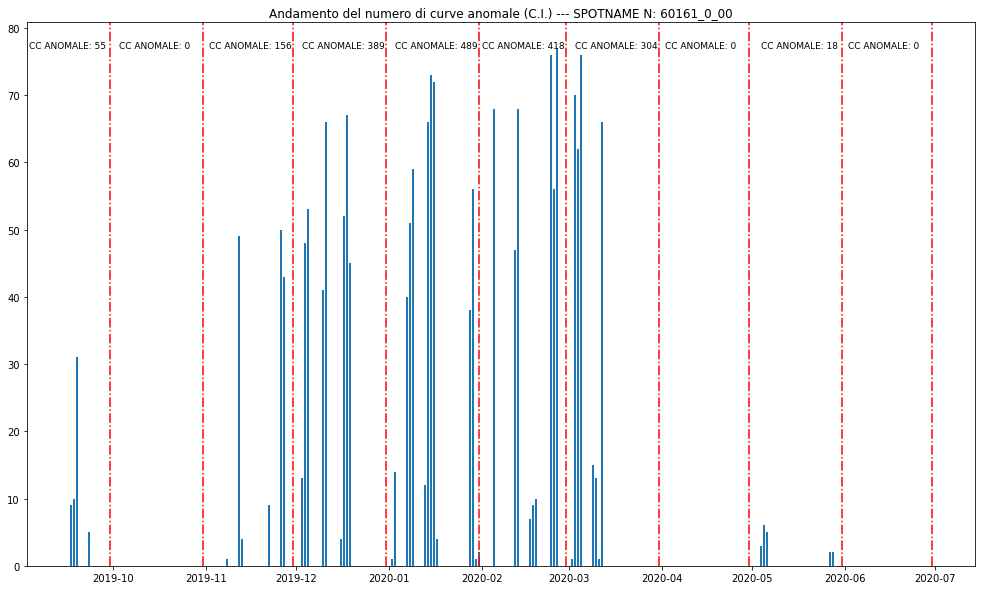

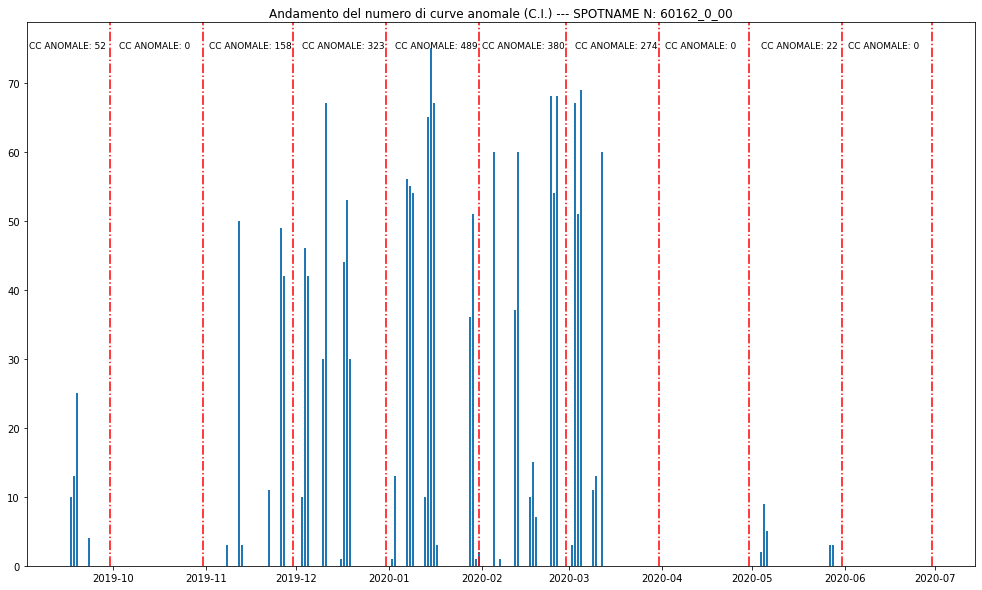

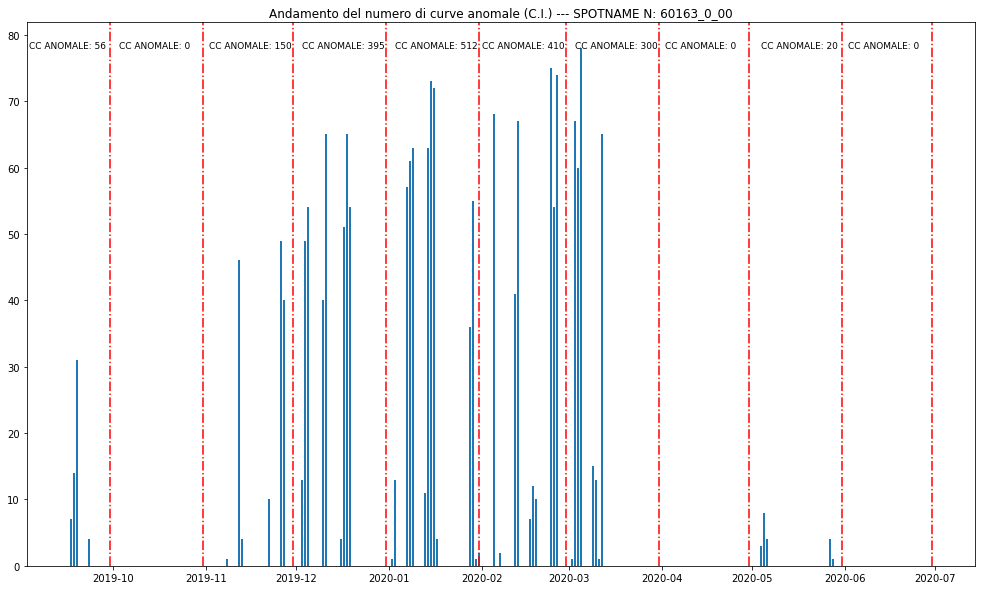

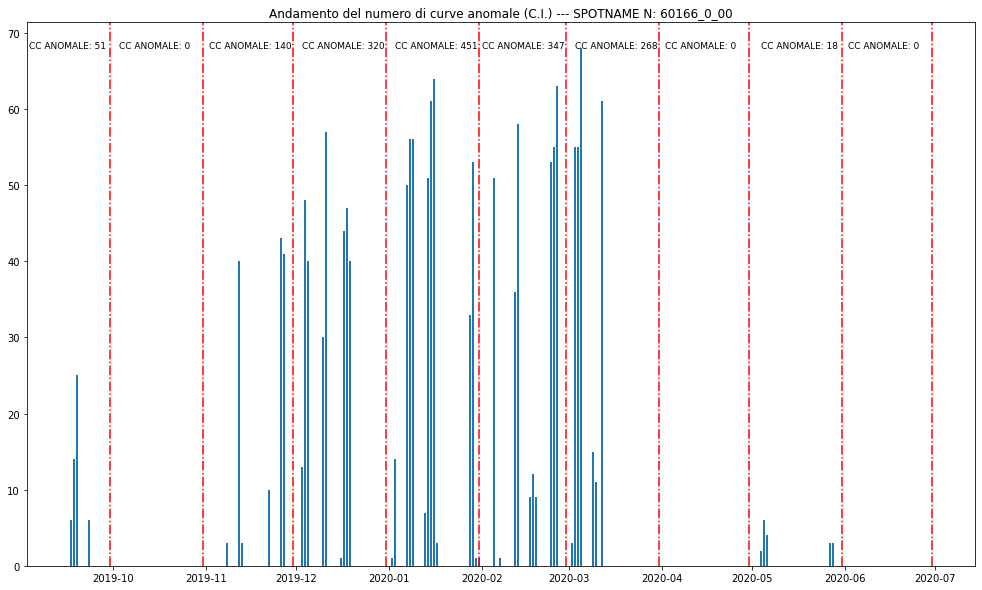

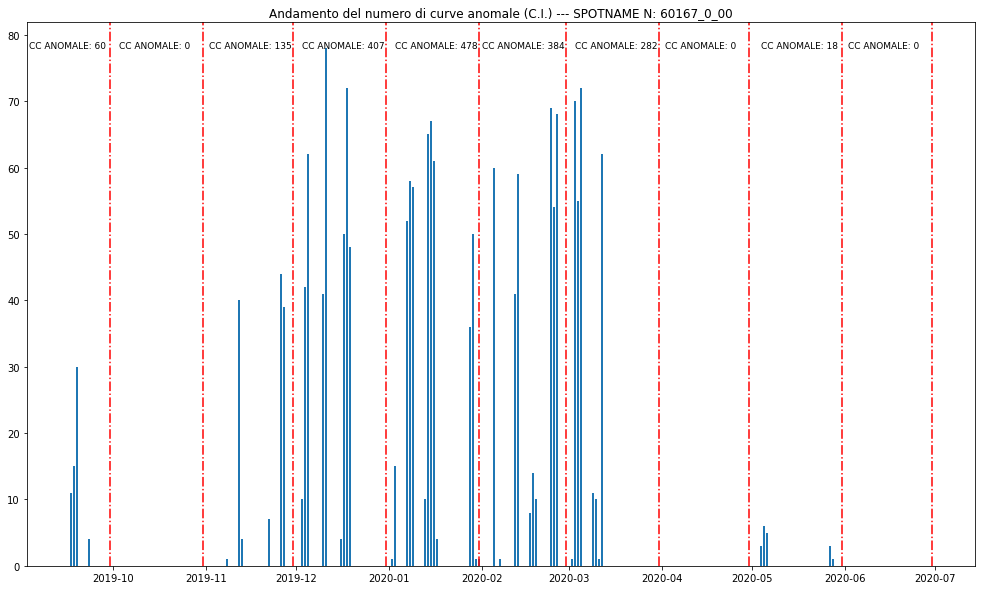

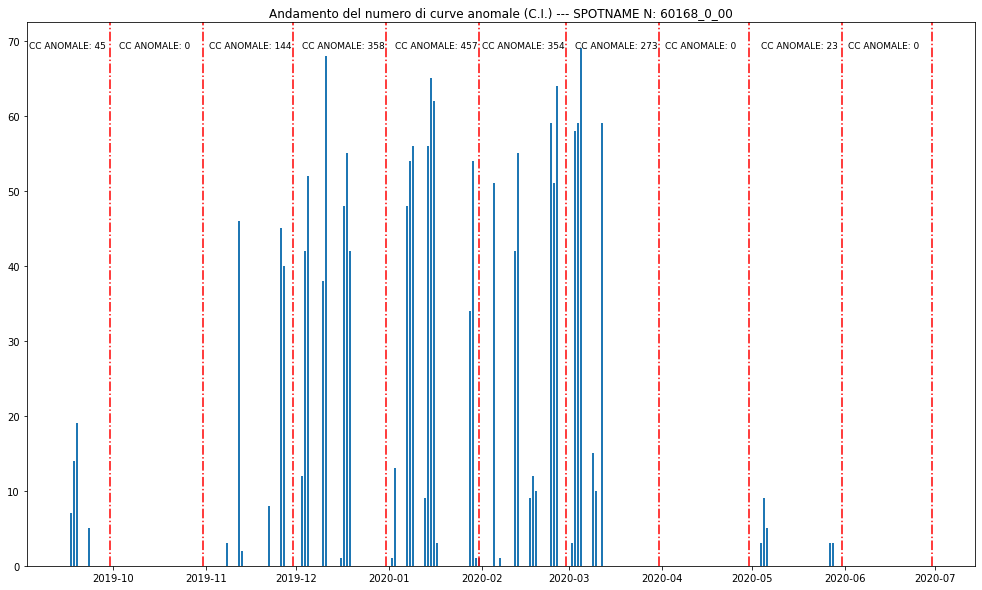

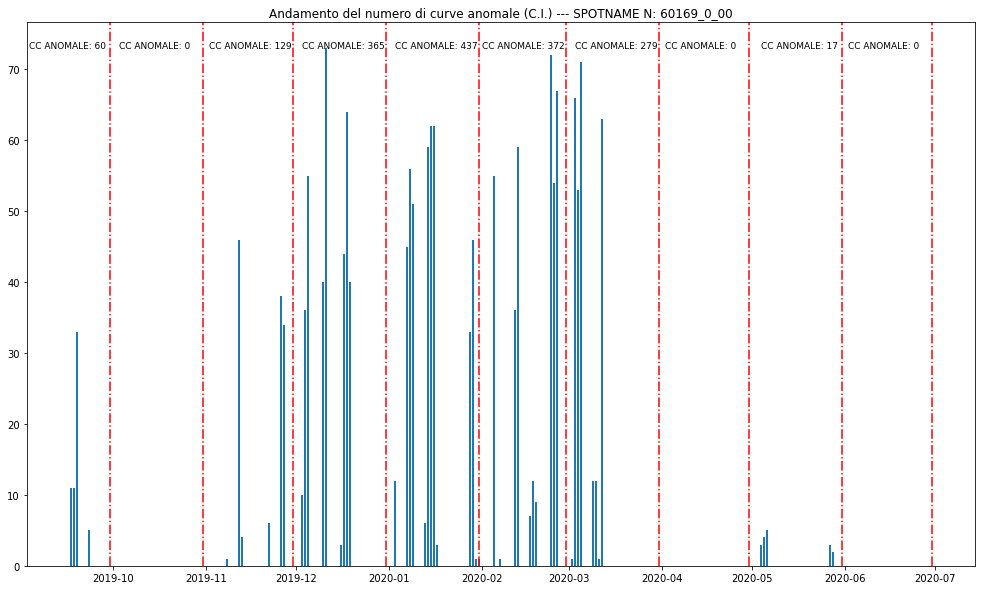

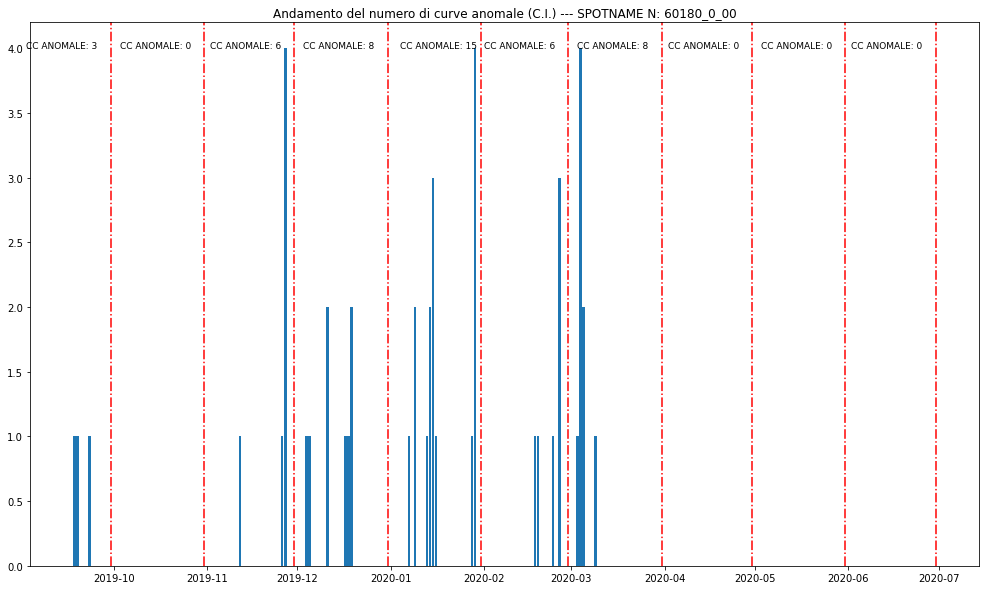

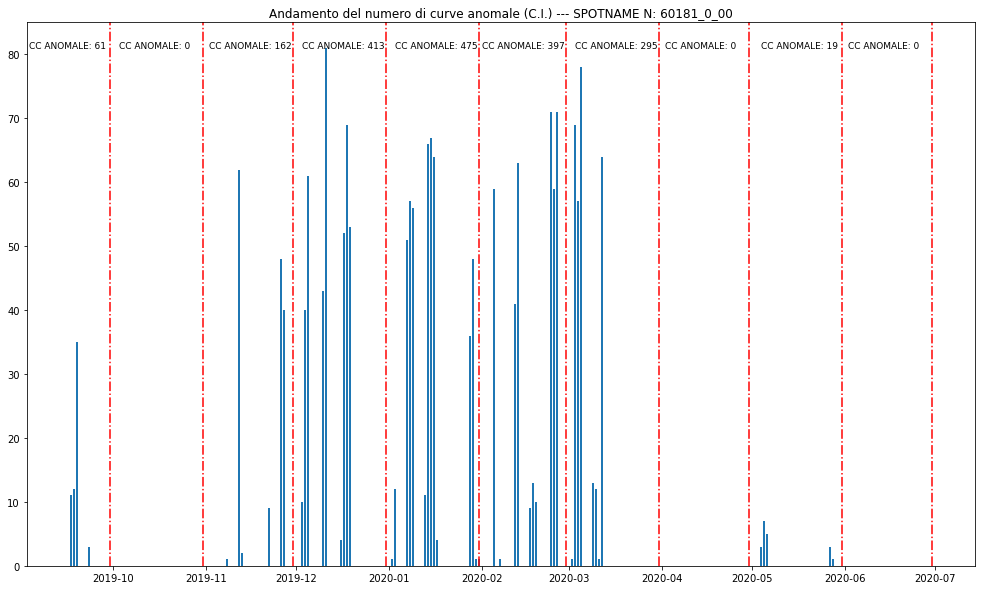

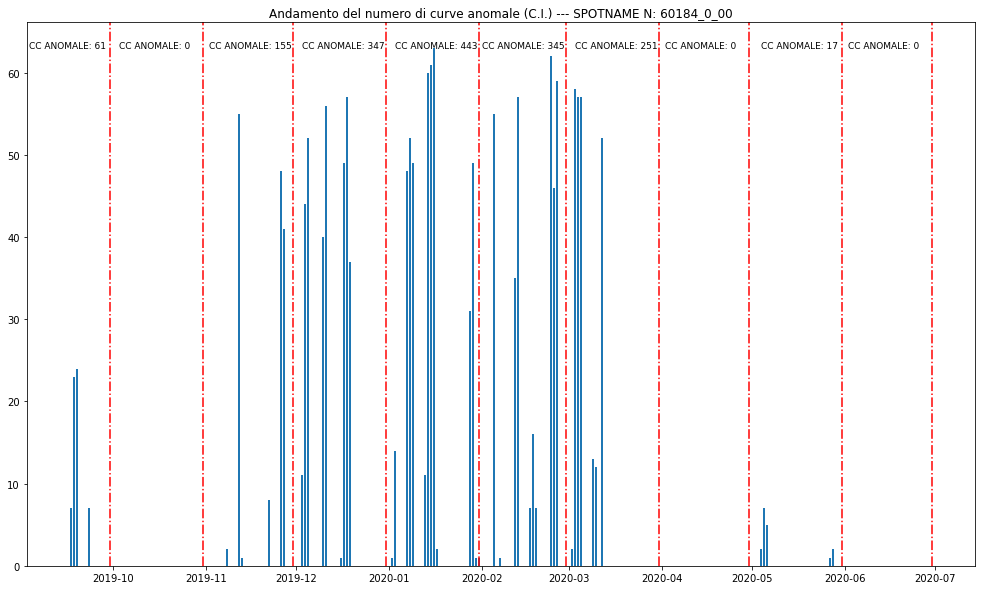

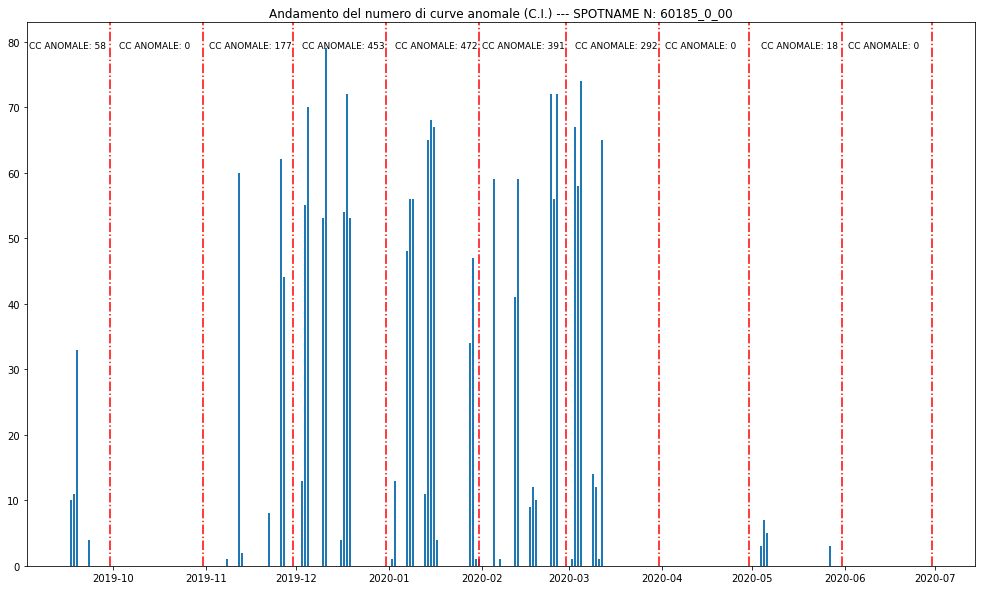

In [20]:
data = daily_analysis[daily_analysis.n_CI_anom > NOT_ANOM_CI].groupby(['spotName', 'Date'])['CurrentCurve'].agg(
    count='count').reset_index()
list_date = pd.date_range(pd.to_datetime(
    '2019-09-01'), pd.to_datetime('2020-06-30'), freq='1M')
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]
    plt.figure(figsize=figsize)
    plt.title(
        f"Andamento del numero di curve anomale (C.I.) --- SPOTNAME N: {spotname}")
    # visualizziamo delle linee verticali per ogni mese
    for date in list_date:
        # plot linea per ogni mese
        plt.axvline(date, linestyle='-.', color='r')
        # numero di giorni da cui iniziare a plottare il testo
        left_shift = 24
        month = date.month
        year = date.year
        # totale numero cc anomale per rispettivo anno e mese
        tot_anom = sum(temp_ds[(temp_ds.Date.dt.year == year) & (
            temp_ds.Date.dt.month == month)]['count'])
        # sposto testo a sx in base al numero di cifre -> riduco errori grafici
        if tot_anom > 99 or tot_anom < 10:
            left_shift = 28
        if 10 <= tot_anom <= 99:
            left_shift = 27
        # scrivo il testo ogni mese - tot giorni, in modo da accentrarlo per ogni mese
        text = f"CC ANOMALE: {tot_anom}"
        plt.text(date - dt.timedelta(days=left_shift),
                 max(temp_ds['count']), text, fontsize=9)

    plt.bar(temp_ds.Date, temp_ds['count'])
    plt.show()

### Per ogni spotname, tot. anomalie per anno

In media nel 2020 sembra che ci sia stato un incremento del numero delle curve anomale indipendentemente dallo spotname.

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


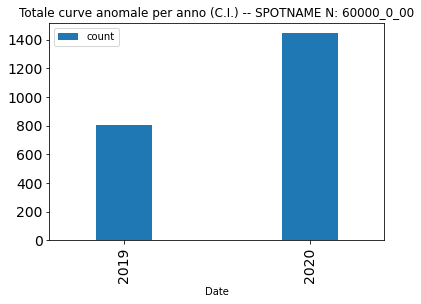

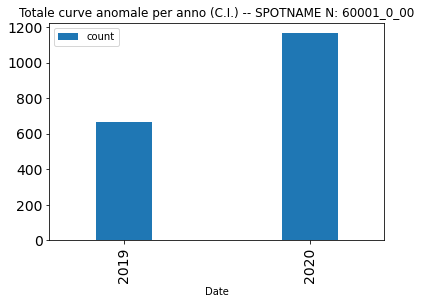

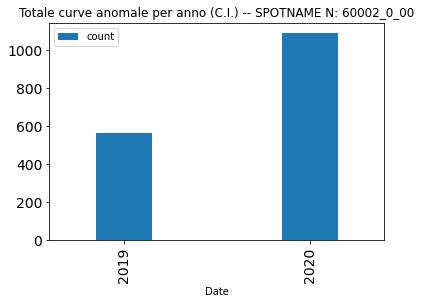

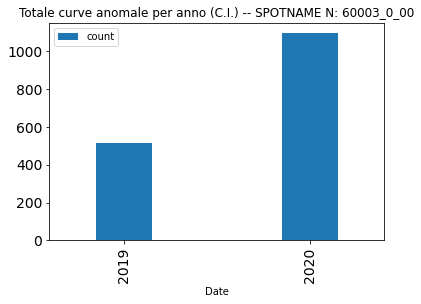

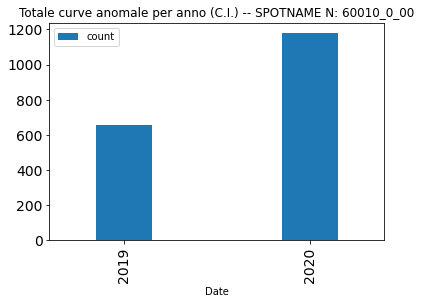

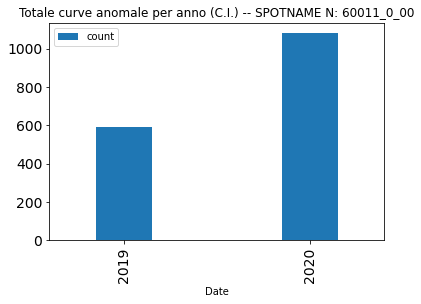

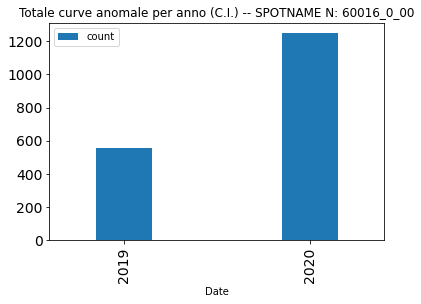

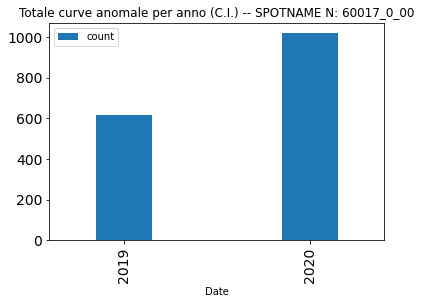

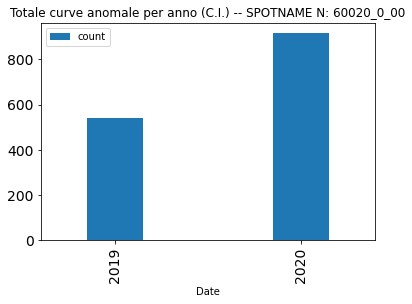

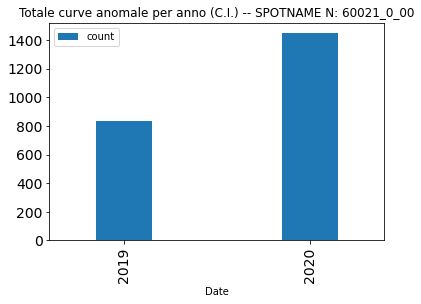

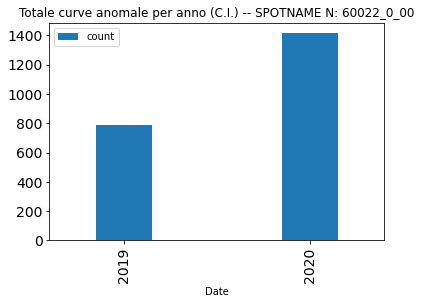

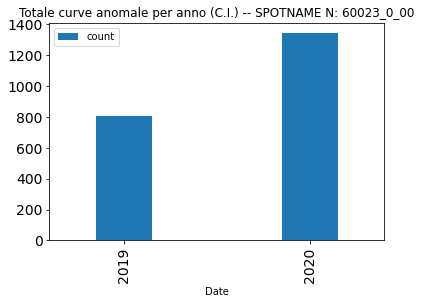

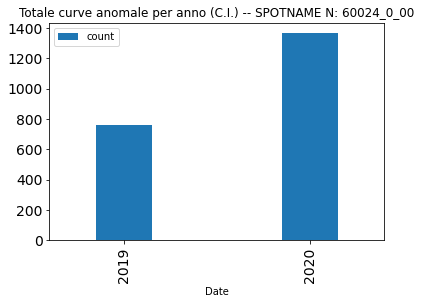

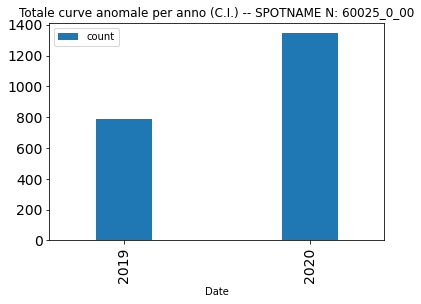

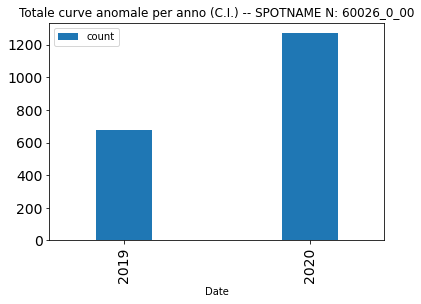

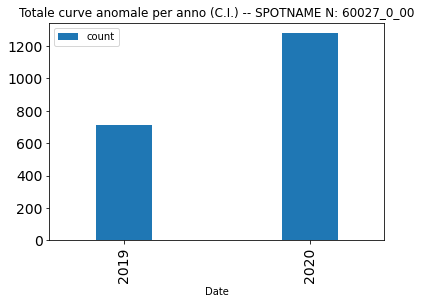

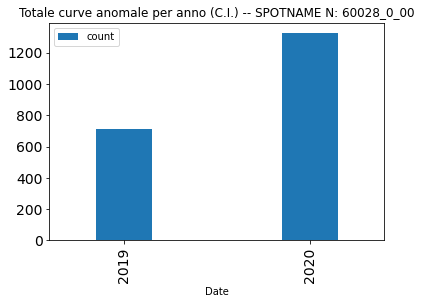

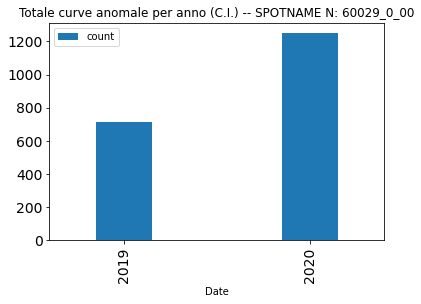

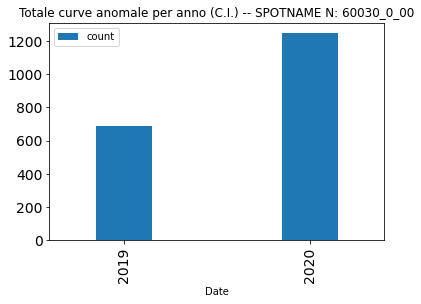

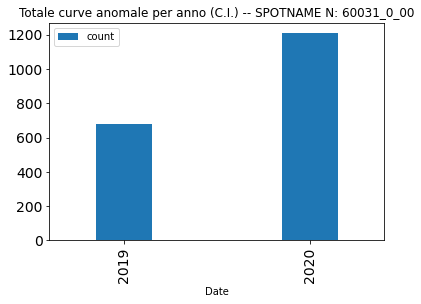

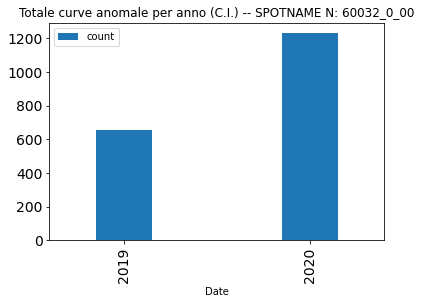

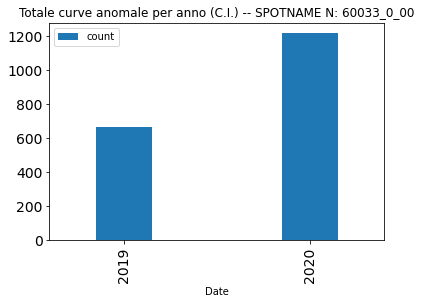

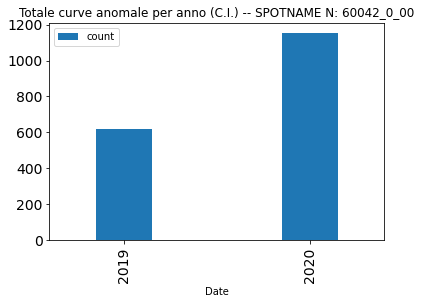

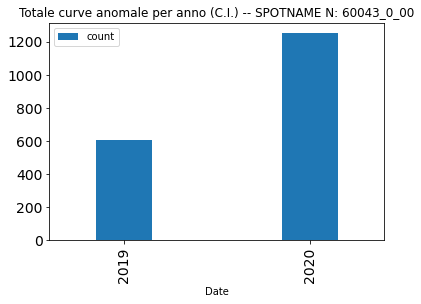

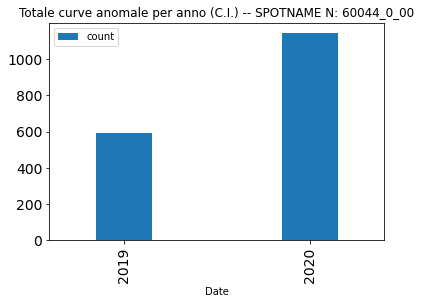

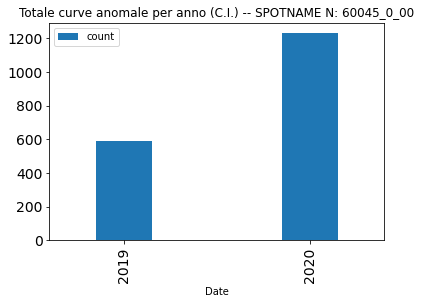

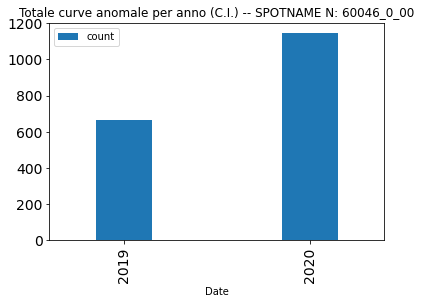

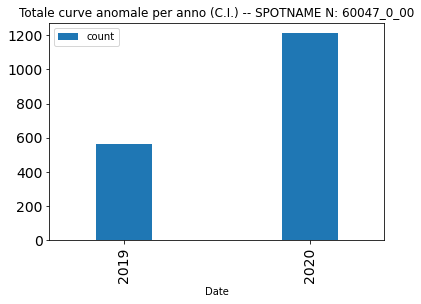

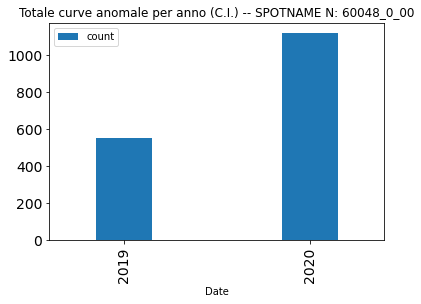

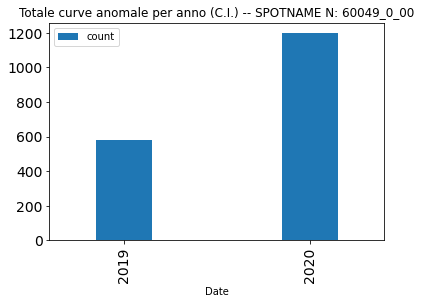

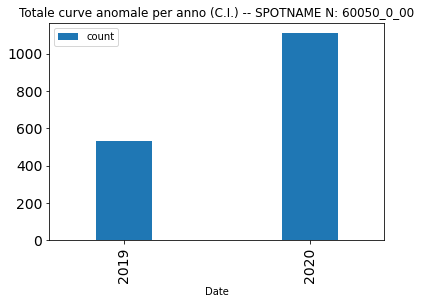

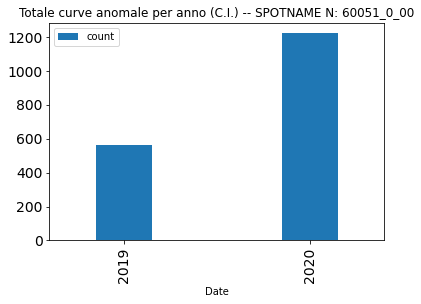

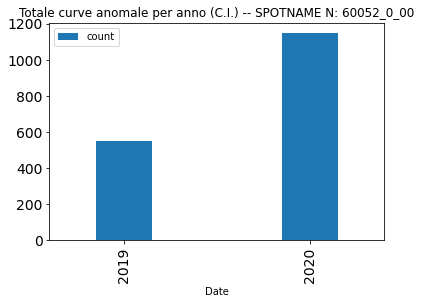

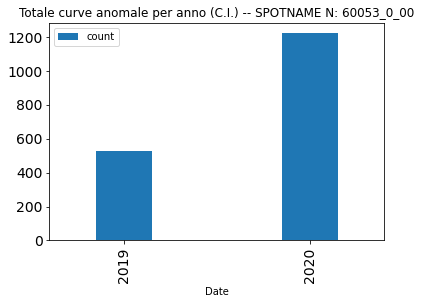

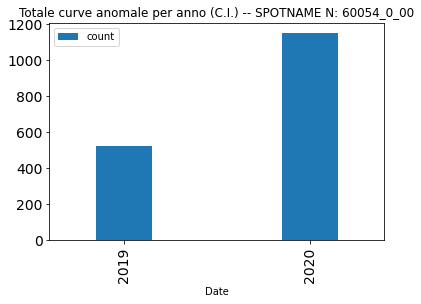

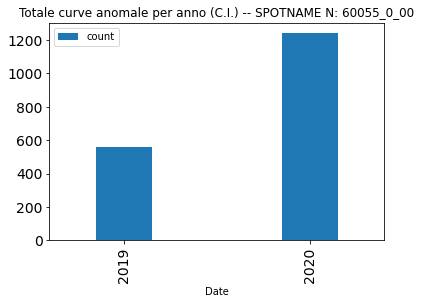

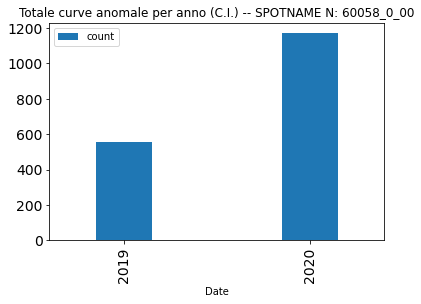

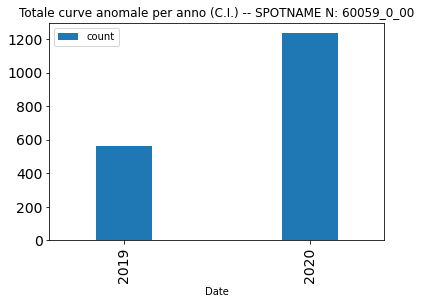

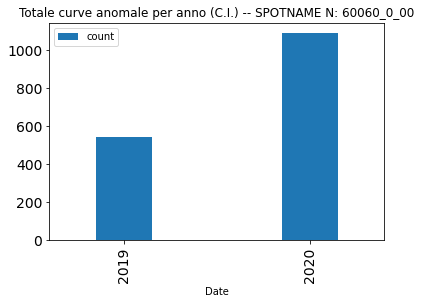

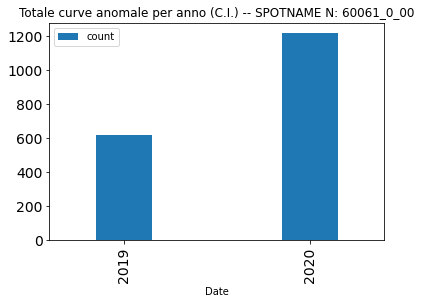

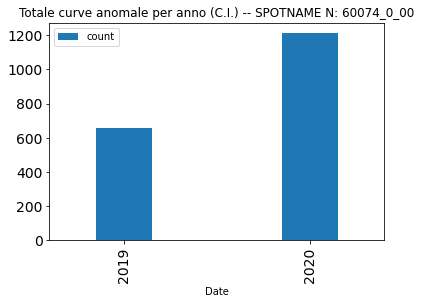

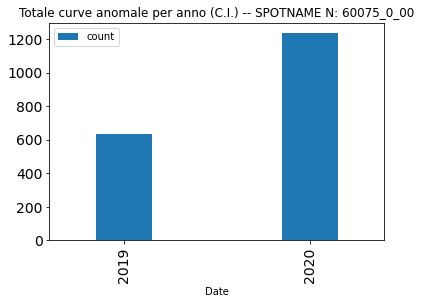

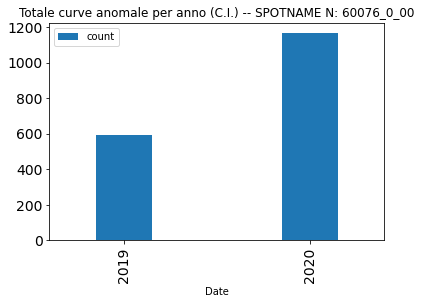

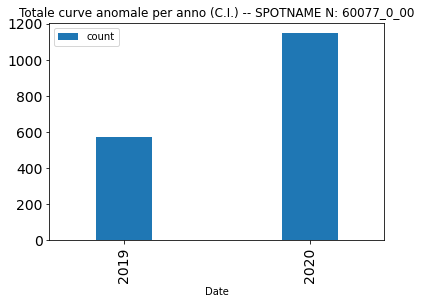

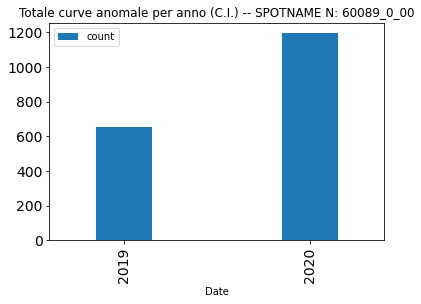

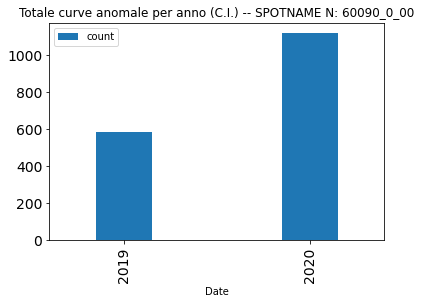

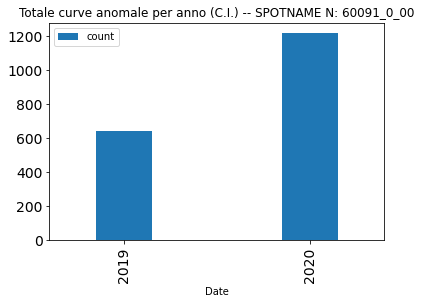

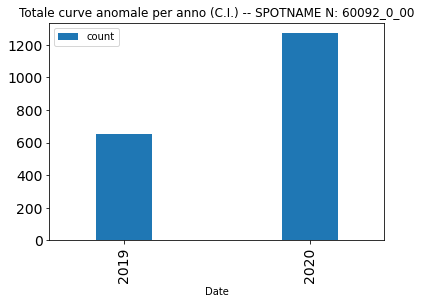

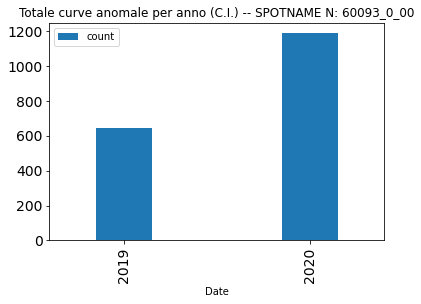

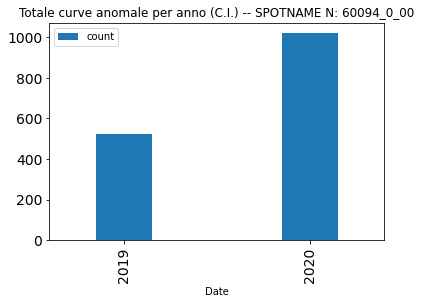

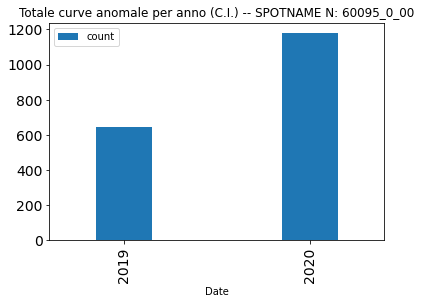

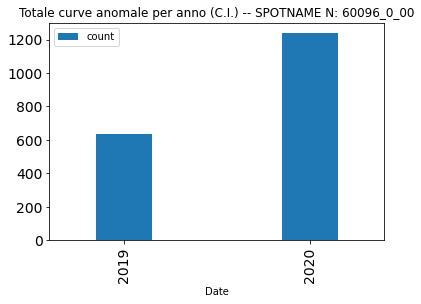

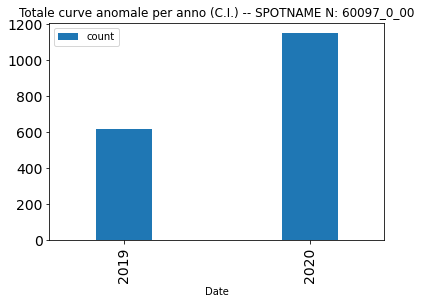

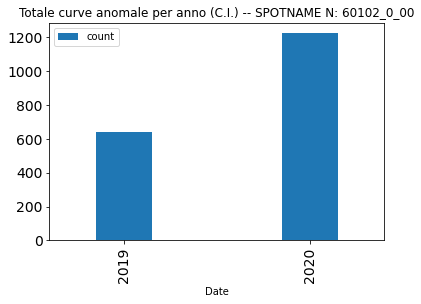

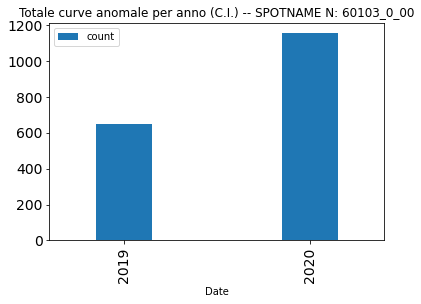

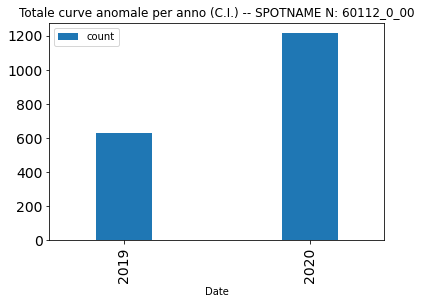

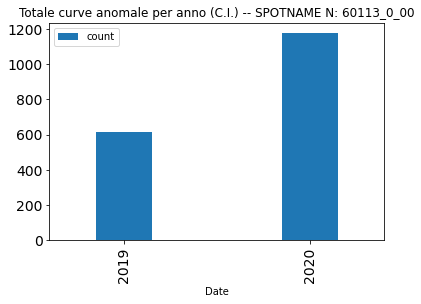

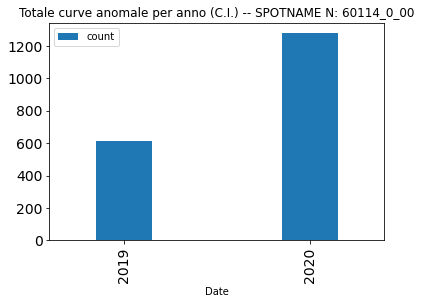

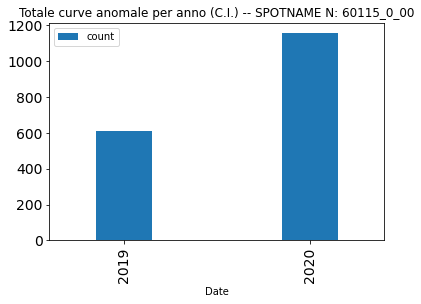

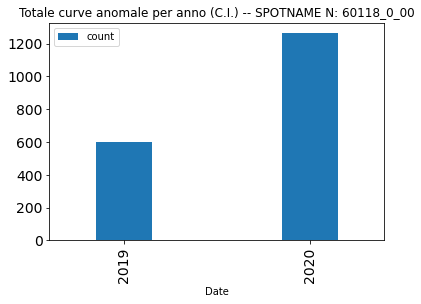

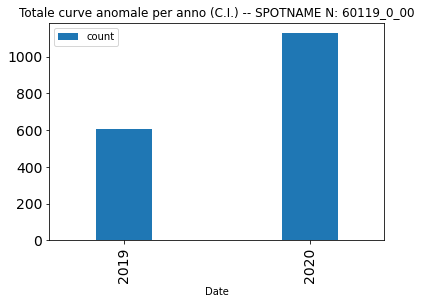

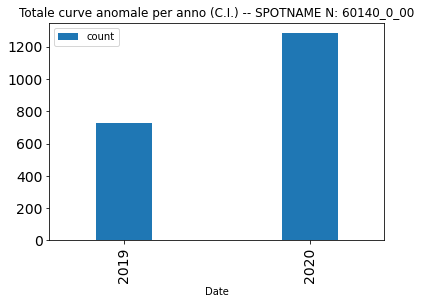

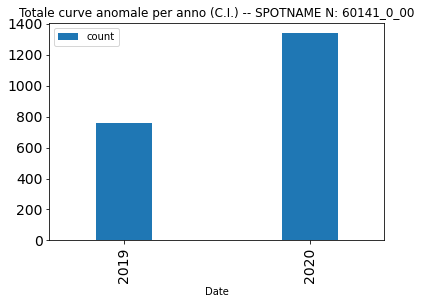

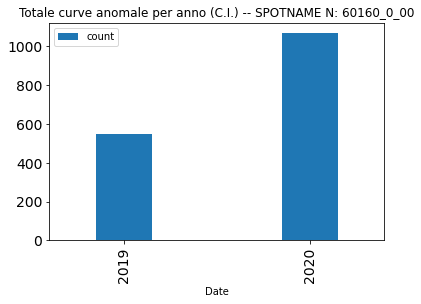

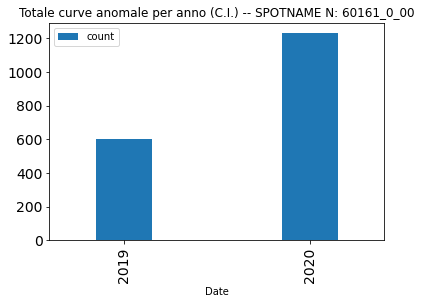

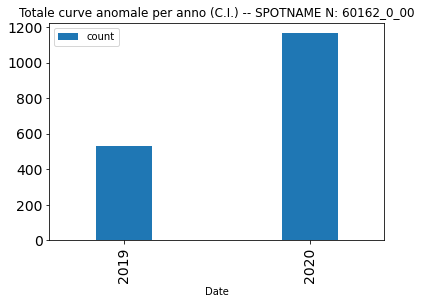

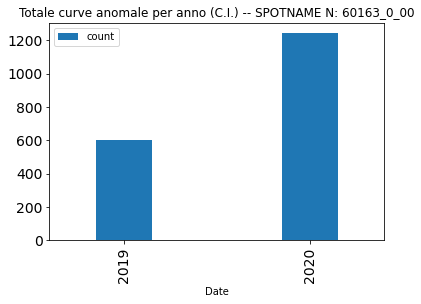

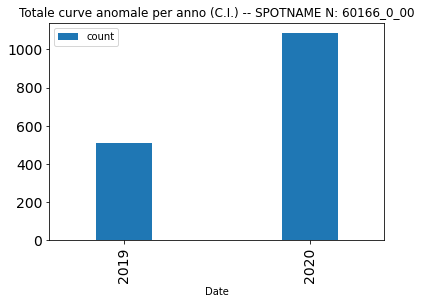

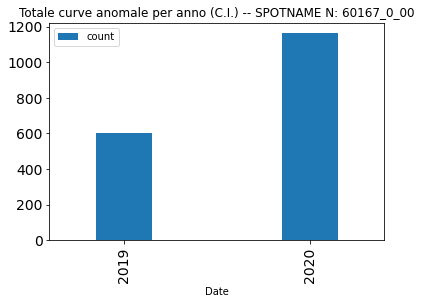

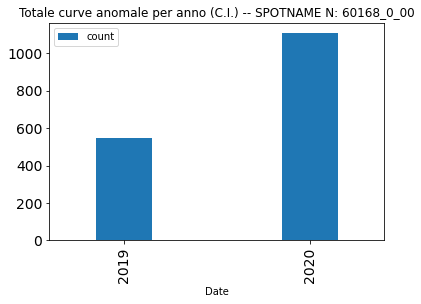

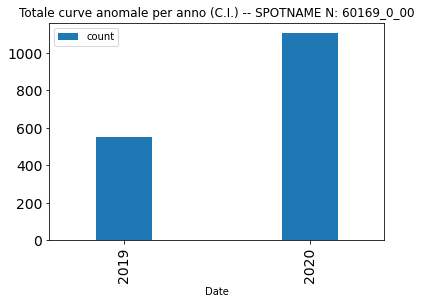

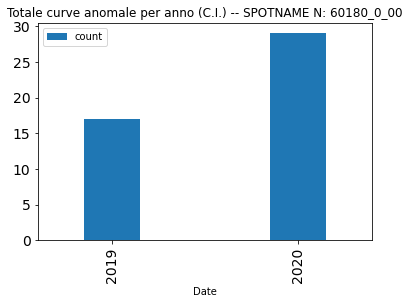

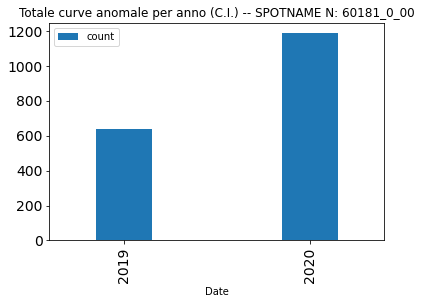

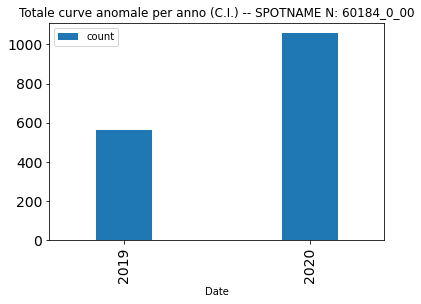

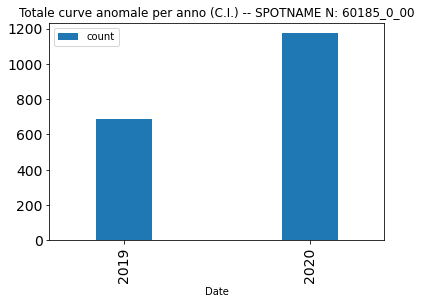

In [21]:
data = daily_analysis[daily_analysis.n_CI_anom > NOT_ANOM_CI].groupby(['spotName', daily_analysis.Date.dt.year])['CurrentCurve'].agg(
    count='count').reset_index()
for spotname in data.spotName.unique():
    temp_ds = data[data.spotName == spotname]\
        .plot(title=f"Totale curve anomale per anno (C.I.) -- SPOTNAME N: {spotname}",
              x='Date', kind='bar', width=0.3, fontsize=14)

### Lunghezza media delle CC considerate anomale

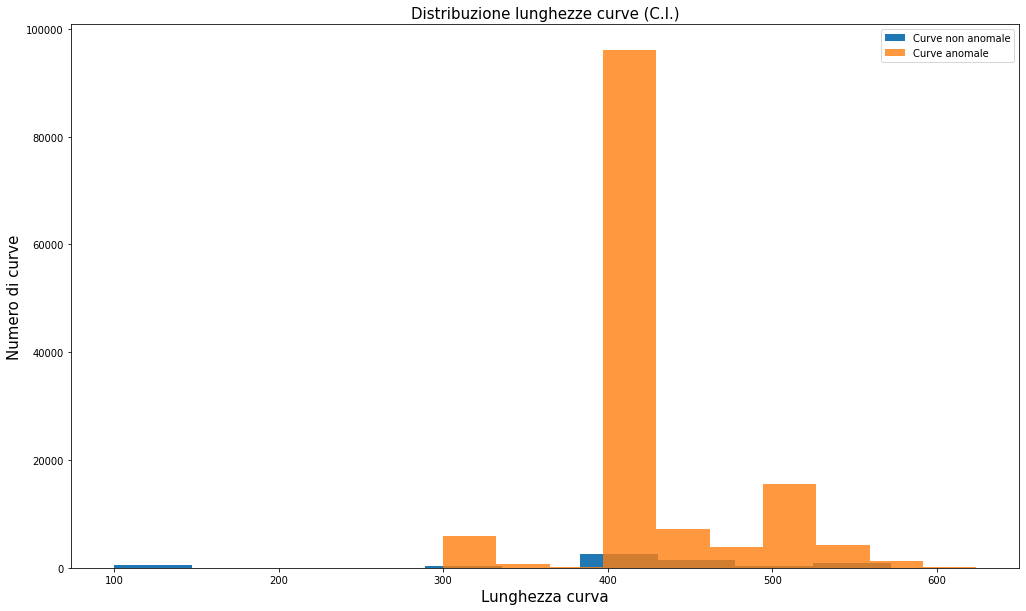

In [22]:
data_anom = daily_analysis[daily_analysis.n_CI_anom > NOT_ANOM_CI]
data_not_anom = daily_analysis[daily_analysis.n_CI_anom <= NOT_ANOM_CI]

distr_leng_anom = [len(curve) for curve in data_anom['CurrentCurve'].to_list()]
distr_leng_not_anom = [len(curve)
                       for curve in data_not_anom['CurrentCurve'].to_list()]

plt.figure(figsize=figsize)
plt.title("Distribuzione lunghezze curve (C.I.)", fontsize=15)
plt.hist(distr_leng_not_anom, label='Curve non anomale')
plt.hist(distr_leng_anom, alpha=0.8, label='Curve anomale')
plt.ylabel("Numero di curve", fontsize=15)
plt.xlabel("Lunghezza curva", fontsize=15)
plt.legend(loc='upper right')
plt.show()